In [1]:
import string
from pathlib import Path
import pandas as pd
import multiprocessing
from functools import partial
import sys, random , re, os
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import math
from PIL import Image
from Bio import SeqIO

import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


all_classes = ['Lysozyme-PF03245',
'Lysozyme-PF16754',
'Lysozyme-PF11860',
'Lysozyme-PF13702',
'Lysozyme-PF00959',
'Lysozyme-PF00182',
'Lysozyme-PF00704',
'Lysozyme-PF01374',
'Lysozyme-PF05838',
'Lysozyme-PF18013',
'Lysozyme-PF04965',
'Lysozyme-PF01183',
'Lysozyme-PF00722',
'peptidase-PF05193',
'peptidase-PF01551',
'peptidase-PF00675',
'peptidase-PF01435',
'peptidase-PF01433',
'peptidase-PF10502',
'peptidase-PF00246',
'peptidase-PF03572',
'peptidase-PF00814',
'peptidase-PF17900',
'Amidase_2-PF01510',
'Amidase_3-PF01520',
'CHAP-PF05257',
'SH3_4-PF06347',
'SH3_3-PF08239',
'SH3_5-PF08460',
'LysM-PF01476']

# util functions
def create_protein_seq_image(item=None, color_map=None):
    """
    Create an image from a sequence
    """
    sequence,img_name, img_h, img_w = item
    image = np.full((img_h, img_w,3), (500,500,500))
    for index in range(len(sequence)):
        image[:, index, :] = color_map[sequence[index]]
    pil_image = Image.fromarray(image.astype(np.uint8))
    assert pil_image.size == (img_w, img_h), f"{pil_image.size}!=({img_w},{img_h})"
    pil_image.save(img_name)
    
    
class Data:
    
    def __init__(self, classes):
        self.classes = classes

class Detectron:
    
    def __init__(self, class_names):
        self.class_names = class_names
        self.data_dir = Path('/home/satish27may/ProteinDomainDetection/data')
        self.model_dir = Path(f"/home/satish27may/ProteinDomainDetection/models/{'_'.join(self.class_names)}")
        self.data_map = {}
        for cls_name in self.class_names:
            self.data_map[cls_name] = {}
            super_class, class_id = cls_name.split('-')
            self.data_map[cls_name]['full_seq_data'] = self.data_dir/f'PfamData/{super_class}___full_sequence_data/{cls_name}___full_sequence_data.fasta'
            self.data_map[cls_name]['domain_data'] = self.data_dir/f'PfamData/{super_class}___full_sequence_data/{cls_name}___domain_data.fasta'     
        self.images_dir = self.data_dir/f"PfamData/{'_'.join(self.class_names)}_images"
        self.images_dir.mkdir(exist_ok=True, parents=True)
        self.model_dir.mkdir(exist_ok=True, parents=True)
        self.classes = class_names

        # COLOR MAP FOR IMAGES
        self.color_map = {}
        index = 0
        for amino_acid in string.ascii_uppercase:
            self.color_map[amino_acid] = (index+10, index+10, index+10)
            index = index+10
        assert len(set(self.color_map.values())) == len(string.ascii_uppercase)
        
    def prepare_protein_data(self):
        """
        Method to create protein data fram which has info of
        sequence id
        sequence
        dom
        dom len
        seq len
        img pth
        """
        data = {}
        for cls_name in self.class_names:
            # extract data from fasta files
            for record in SeqIO.parse(self.data_map[cls_name]['full_seq_data'],'fasta'):
                data[record.id] = {}
                data[record.id]['id'] = record.id
                data[record.id]['name'] = record.name
                data[record.id]['Sequence'] = record.seq._data
                data[record.id]['Class'] = cls_name.split('-')[-1]
                data[record.id]['SeqLen']= len(record.seq._data)
                data[record.id]['SuperClass'] = cls_name.split('-')[0]
                assert 'PF' in data[record.id]['Class']
                data[record.id]['dom_pos'] = []
                data[record.id]['dom_len'] = []
                data[record.id]['dom'] = []
                data[record.id]['img_pth'] = self.images_dir/f"img_{record.id}_{data[record.id]['Class']}_{ data[record.id]['SuperClass']}.png"

            for record in SeqIO.parse(self.data_map[cls_name]['domain_data'], 'fasta'):
                id_ = record.id.split('/')[0]
                # to ensure the indexing of the domains starts at 0 1 is sub
                data[id_]['dom_pos'].append([int(pos)-1 for  pos in record.id.split('/')[-1].split('-')] )
                data[id_]['dom_len'].append(len(record.seq._data))
                data[id_]['dom'].append(record.seq._data)

        data_df = pd.DataFrame(data=data.values())
        data_df['SeqLen'] = data_df['Sequence'].apply(lambda x: len(x))
        # so that none of the domain pos is missing
        assert data_df['dom_pos'].isna().sum() == 0
        # drop sequences above 1k
        num_rows = data_df.shape[0]
        data_df = data_df[data_df['SeqLen']<1000]
        print(f"Dropping {abs(data_df.shape[0]-num_rows)} sequences since there len is > 1k")
        data_df.to_csv(self.data_dir/f"PfamData/{'_'.join(self.class_names)}model_data.csv",index=False)
        print(f"Number of samples available for {'_'.join(self.class_names)}: {data_df.shape[0]}")
        return data_df
    
    def generate_images(self, img_h, img_w, data_df):
        print(f"Generating images of dim: {img_h}x{img_w}")
        partial_create_protein_seq_image = partial(create_protein_seq_image, color_map=self.color_map)
        items = [(sequence, img_name, img_h, img_w ) for sequence, img_name in zip(data_df['Sequence'],data_df['img_pth'])]
        #with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as p:
        #    p.map(partial_create_protein_seq_image, items)
        for item in items:
            partial_create_protein_seq_image(item)
        
        
    def generate_model_config(self, num_iters):
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
        cfg.DATASETS.TRAIN = ("train",)
        cfg.DATASETS.TEST = ("valid",)
        #cfg.MODEL.PIXEL_MEAN = data_mean
        #cfg.MODEL.PIXEL_STD = data_std
        cfg.INPUT.RANDOM_FLIP = "none"
        cfg.TEST.DETECTIONS_PER_IMAGE = 100

        cfg.INPUT.MIN_SIZE_TRAIN = 800
        cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = "choice"
        # Maximum size of the side of the image during training
        cfg.INPUT.MAX_SIZE_TRAIN = 1330
        # Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
        cfg.INPUT.MIN_SIZE_TEST = 800
        # Maximum size of the side of the image during testing
        cfg.INPUT.MAX_SIZE_TEST = 1330


        cfg.TEST.AUG.FLIP = False
        cfg.DATALOADER.NUM_WORKERS = 8
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  
        cfg.SOLVER.IMS_PER_BATCH = 2
        cfg.SOLVER.BASE_LR = 9e-4  
        cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
        cfg.SOLVER.MAX_ITER = num_iters
        cfg.MODEL.RETINANET.NUM_CLASSES = len(self.classes)


        # exp
        cfg.MODEL.RESNETS.NORM = "BN"
        # cfg.MODEL.RETINANET.NORM = "SyncBN" # not working
        # from detectron2.config import CfgNode as CN
        # cfg.INPUT.CROP = CN({"ENABLED": True})
        # cfg.INPUT.CROP.TYPE = "relative_range"
        # cfg.INPUT.CROP.SIZE = [0.95, 0.95]

        cfg.OUTPUT_DIR =str(self.model_dir)
        #os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
        return cfg

    def create_model_data(self, data_df):
        from ast import literal_eval
        
        def create_train_valid_test_data(data_df):
            train_dfs,valid_dfs = [],[],
            for class_name in data_df['Class'].unique():
                class_df = data_df[data_df['Class']==class_name].sample(frac=1)
                num_samples = class_df.shape[0]
                num_train_samples = int(round(num_samples*0.7))
                train_dfs.append(class_df.iloc[:num_train_samples,:])
                valid_dfs.append(class_df.iloc[num_train_samples:,:])
            return pd.concat(train_dfs,axis='rows').sample(frac=1), pd.concat(valid_dfs,axis='rows').sample(frac=1)

        def create_dataset(model_data, img_h, img_w, mode, classes, aug_data):
            print(f"Classes selected: {model_data['Class'].unique()}")
            print(f"SuperClasses selected: {model_data['SuperClass'].unique()}")
            model_data = model_data.reset_index(drop=True)
#             model_data['dom_pos'] = model_data['dom_pos'].apply(lambda x: literal_eval(x))
            C2I = {class_name:index for index, class_name in enumerate(model_data['Class'].unique())}
            train_dicts_list = []
            valid_dicts_list = []
            train, valid = create_train_valid_test_data(model_data)
            print(f"Train data dist:")
            print(train['SuperClass'].value_counts())
            print(f"valid data dist:")
            print(valid['SuperClass'].value_counts())
            if aug_data:
                print(f"train data before aug: {train.shape[0]}\n{train['Class'].value_counts()}")
                train = data_handler.augment_data(train,(img_h,img_w), num_augs=300)
                print(f"Class dist in train after aug:\n {train['Class'].value_counts()}")
                print(f'train data after aug: {train.shape[0]}')
            train = train.reset_index(drop=True)
            valid = valid.reset_index(drop=True)
            for index in tqdm(range(train.shape[0])):
                dom_pos_list = train['dom_pos'][index]
        #         print(dom_pos_list, type(dom_pos_list))
                if len(dom_pos_list)>1:
                    train_annts = []
                    for dom_index in range(len(dom_pos_list)):
                        x1,x2 = dom_pos_list[dom_index]
                        train_annts.append({'bbox':[x1, 0, x2, img_h],
                                                   'bbox_mode':BoxMode.XYXY_ABS,
                                                   'category_id':  C2I[train['Class'][index]],
                                                  })
                elif len(dom_pos_list)==1:
                    x1,x2 = dom_pos_list[0]
                    train_annts = [{'bbox':[x1, 0, x2, img_h],
                                                   'bbox_mode':BoxMode.XYXY_ABS,
                                                   'category_id':  C2I[train['Class'][index]],
                                                  }]


                train_dicts_list.append({'file_name':str(train['img_pth'][index]),
                                   'height':img_h,
                                   'width': img_w,
                                   'image_id': index,
                                   'annotations':train_annts,
                                  })

            for index in tqdm(range(valid.shape[0])):
                dom_pos_list = valid['dom_pos'][index]
                if len(dom_pos_list)>1:
                    valid_annts = []
                    for dom_index in range(len(dom_pos_list)):
                        x1, x2 = dom_pos_list[dom_index]
                        valid_annts.append({'bbox':[x1, 0, x2, img_h],
                                                   'bbox_mode':BoxMode.XYXY_ABS,
                                                   'category_id':  C2I[valid['Class'][index]],
                                                  })
                elif len(dom_pos_list)==1:
                    x1, x2 = dom_pos_list[0]
                    valid_annts = [{'bbox':[x1, 0, x2, img_h],
                                                   'bbox_mode':BoxMode.XYXY_ABS,
                                                   'category_id':  C2I[valid['Class'][index]],
                                                  }]
                valid_dicts_list.append({'file_name':str(valid['img_pth'][index]),
                                   'height':img_h,
                                   'width': img_w,
                                   'image_id': index,
                                   'annotations':valid_annts
                                  })
            if mode=='train':return train_dicts_list
            elif mode=='valid': return valid_dicts_list

        # create train and valid data
        train_list = create_dataset(data_df, img_h=img_h, img_w=img_w, mode='train', classes=self.classes, aug_data=False)
        valid_list = create_dataset(data_df, img_h=img_h, img_w=img_w, mode='valid', classes=self.classes, aug_data=False)

        def get_train_data():
            return train_list

        def get_valid_data():
            return valid_list

        # add custom dataset to detectron 2 pipline
        DatasetCatalog.register("train", get_train_data)
        DatasetCatalog.register("valid", get_valid_data)

        MetadataCatalog.get("train").set(thing_classes = self.classes)
        MetadataCatalog.get("valid").set(thing_classes = self.classes)

    def visualise_model_data(self):
        dataset_dicts = DatasetCatalog.get('train')
        for d in random.sample(dataset_dicts, 10):
            img = cv2.imread(d["file_name"])
            visualizer = Visualizer(img[:, :, ::-1], metadata= MetadataCatalog.get("train").set(thing_classes = self.classes), scale=2.5)
            out = visualizer.draw_dataset_dict(d)
            cv2_imshow(out.get_image()[:, :, ::-1])

/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
ctrlr = Detectron(['CHAP-PF05257','SH3_4-PF06347'])
img_h, img_w = 64, 1000

In [3]:
protein_data = ctrlr.prepare_protein_data()
protein_data = protein_data[protein_data['SeqLen']<300]

ctrlr.generate_images(img_h, img_w, protein_data)
ctrlr.create_model_data(protein_data)


Dropping 94 sequences since there len is > 1k
Number of samples available for CHAP-PF05257_SH3_4-PF06347: 5196
Generating images of dim: 64x1000


  0%|          | 0/2278 [00:00<?, ?it/s]

Classes selected: ['PF05257' 'PF06347']
SuperClasses selected: ['CHAP' 'SH3_4']
Train data dist:
CHAP     1264
SH3_4    1014
Name: SuperClass, dtype: int64
valid data dist:
CHAP     542
SH3_4    435
Name: SuperClass, dtype: int64
Classes selected: ['PF05257' 'PF06347']
SuperClasses selected: ['CHAP' 'SH3_4']
Train data dist:
CHAP     1264
SH3_4    1014
Name: SuperClass, dtype: int64
valid data dist:
CHAP     542
SH3_4    435
Name: SuperClass, dtype: int64


100%|██████████| 977/977 [00:00<00:00, 23229.44it/s]


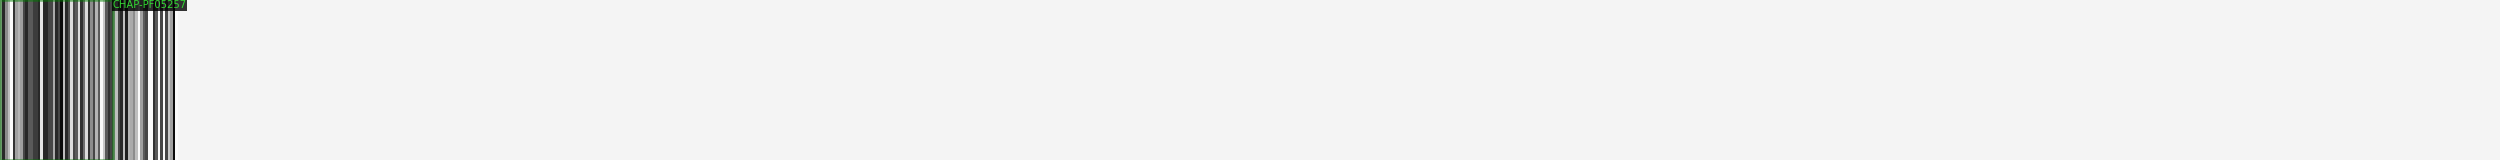

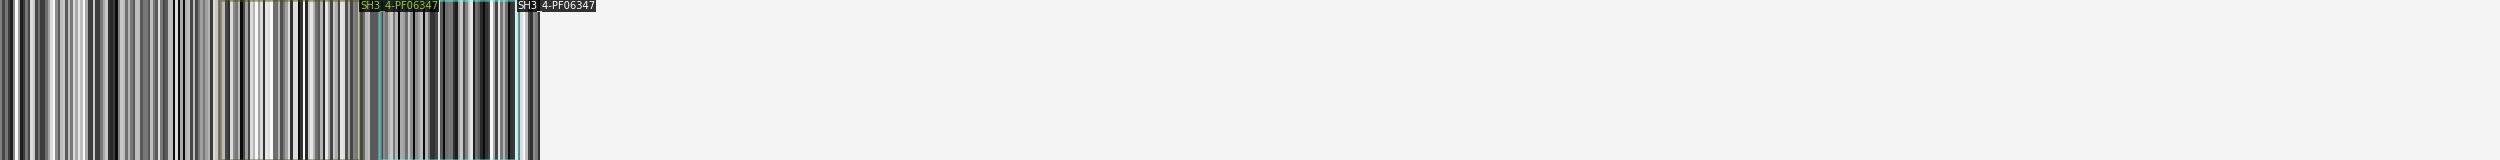

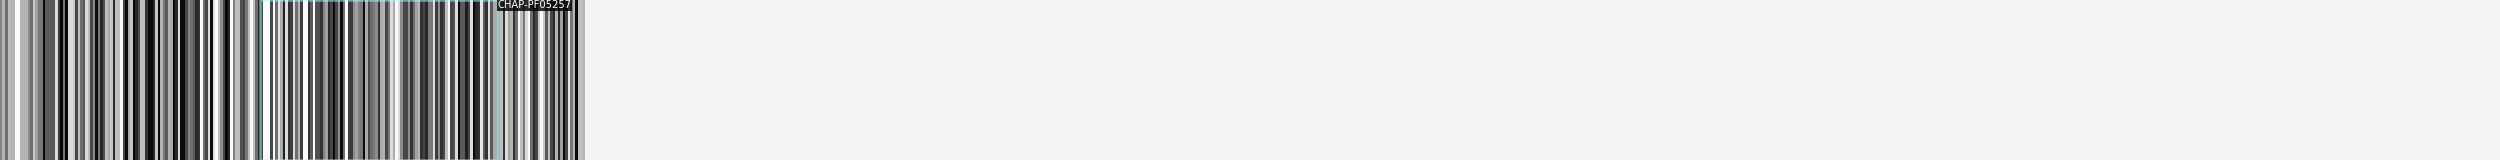

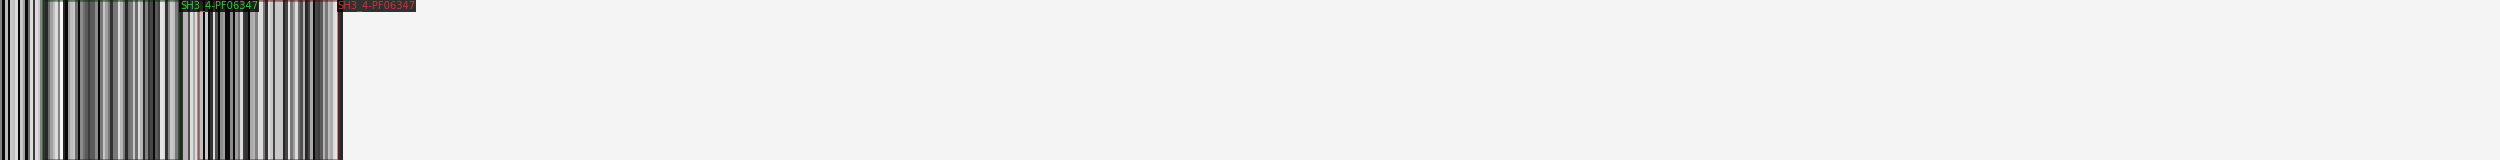

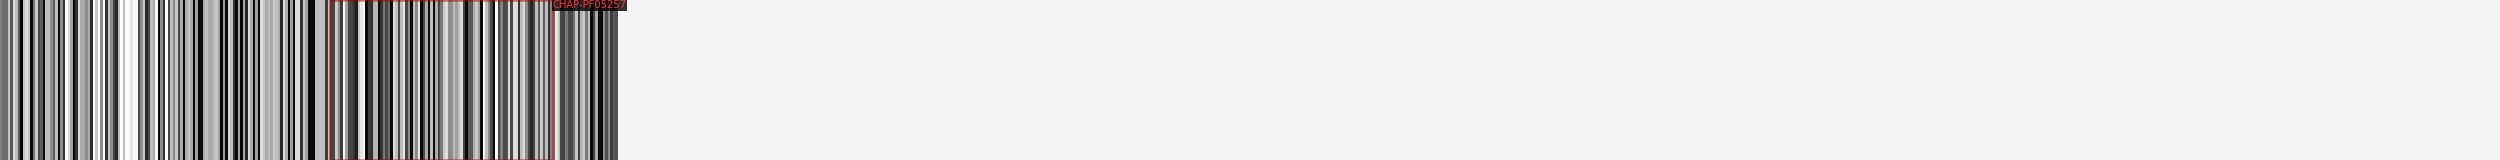

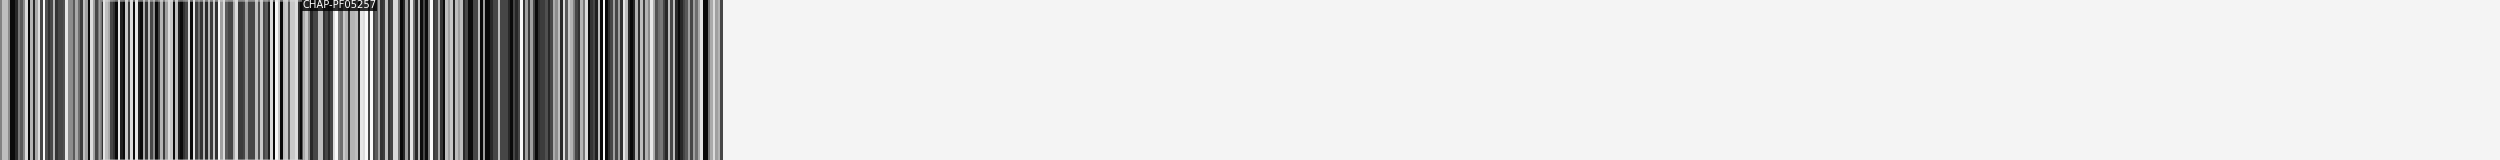

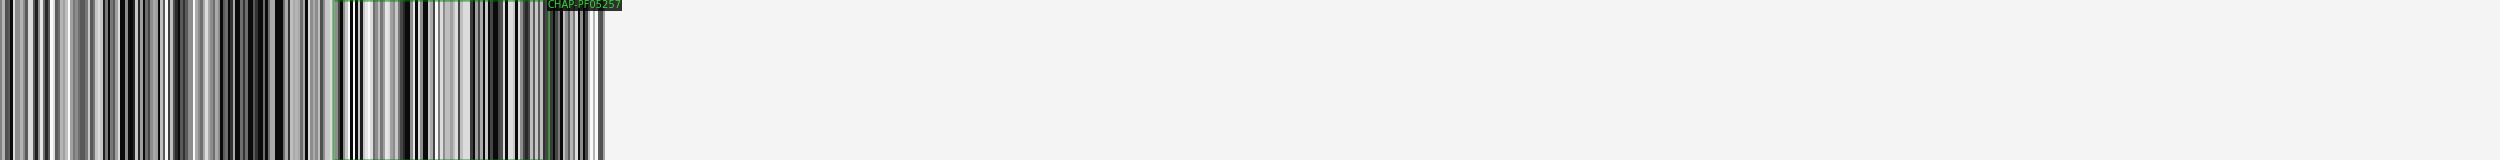

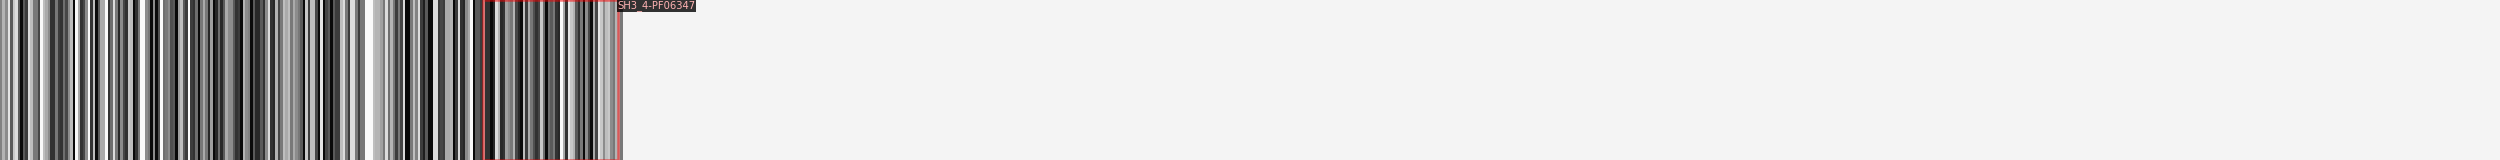

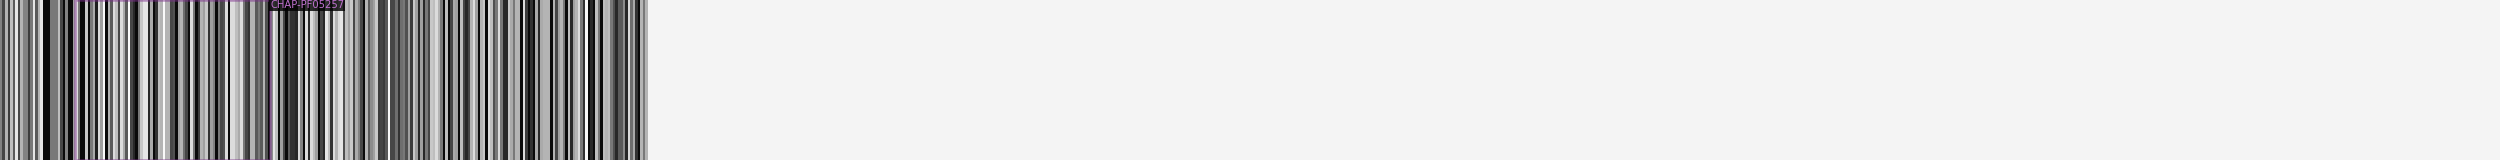

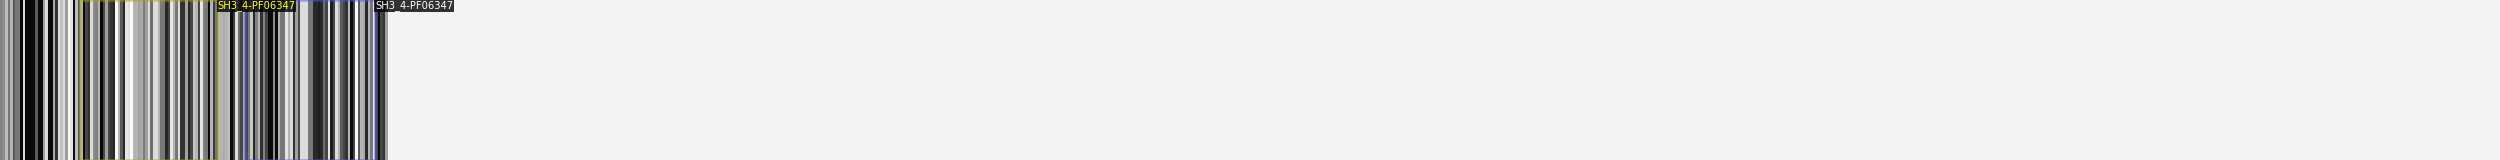

In [4]:
ctrlr.visualise_model_data()

In [5]:
cfg=ctrlr.generate_model_config(num_iters=3000)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train() #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# evaluate model
evaluator = COCOEvaluator("valid", ("bbox",), False, output_dir=cfg.OUTPUT_DIR )
val_loader = build_detection_test_loader(cfg, "valid")
trainer.test(cfg, trainer.model, evaluator)

Loading config /home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[12/09 10:31:28 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (18, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (18,) in the model! You might want to double check if this is expected.


[12/09 10:31:30 d2.engine.train_loop]: Starting training from iteration 0
[12/09 10:31:33 d2.utils.events]:  eta: 0:02:58  iter: 19  total_loss: 1.745  loss_cls: 1.137  loss_box_reg: 0.5641  time: 0.0875  data_time: 0.0234  lr: 1.7981e-05  max_mem: 763M
[12/09 10:31:34 d2.utils.events]:  eta: 0:02:56  iter: 39  total_loss: 1.554  loss_cls: 1.096  loss_box_reg: 0.452  time: 0.0728  data_time: 0.0033  lr: 3.595e-05  max_mem: 763M
[12/09 10:31:35 d2.utils.events]:  eta: 0:02:54  iter: 59  total_loss: 1.569  loss_cls: 1.167  loss_box_reg: 0.4032  time: 0.0682  data_time: 0.0033  lr: 5.3895e-05  max_mem: 763M
[12/09 10:31:37 d2.utils.events]:  eta: 0:02:53  iter: 79  total_loss: 1.387  loss_cls: 1.051  loss_box_reg: 0.3736  time: 0.0661  data_time: 0.0033  lr: 7.1806e-05  max_mem: 763M
[12/09 10:31:38 d2.utils.events]:  eta: 0:02:52  iter: 99  total_loss: 1.324  loss_cls: 0.973  loss_box_reg: 0.3687  time: 0.0648  data_time: 0.0033  lr: 8.967e-05  max_mem: 763M
[12/09 10:31:39 d2.utils.even

OrderedDict([('bbox',
              {'AP': 78.1203679508442,
               'AP-CHAP-PF05257': 70.98853848822333,
               'AP-SH3_4-PF06347': 85.25219741346507,
               'AP50': 93.42505231371902,
               'AP75': 89.34680002015979,
               'APl': 40.0,
               'APm': 78.17292530463689,
               'APs': nan})])

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.9   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

  0%|          | 0/435 [00:00<?, ?it/s]

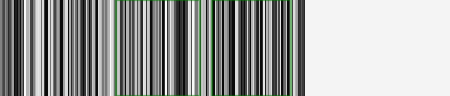

predicted


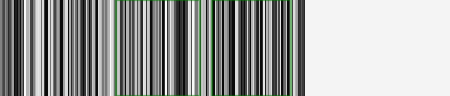

predicted


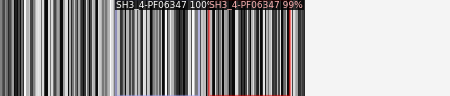

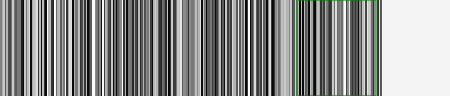

predicted


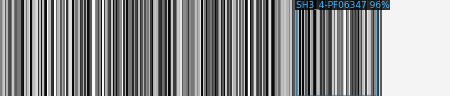

  0%|          | 2/435 [00:00<00:39, 10.99it/s]

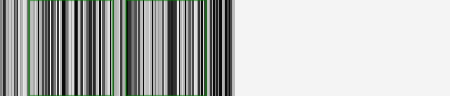

predicted


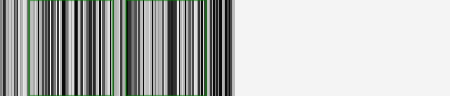

predicted


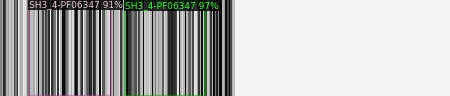

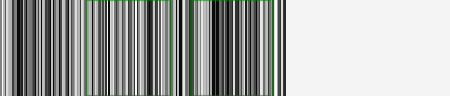

predicted


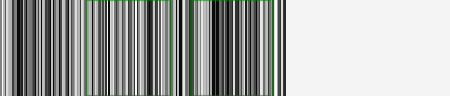

predicted


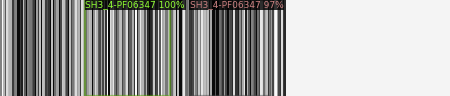

  1%|          | 4/435 [00:00<00:39, 10.92it/s]

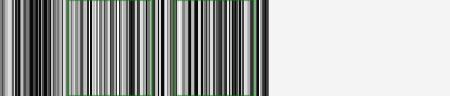

predicted


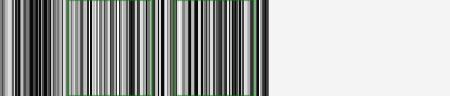

predicted


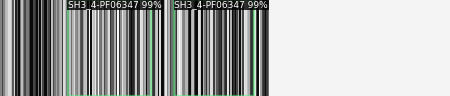

  1%|          | 5/435 [00:00<00:58,  7.37it/s]

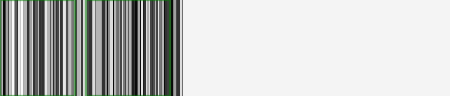

predicted


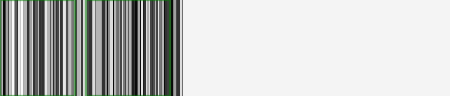

predicted


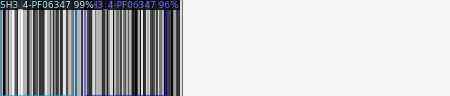

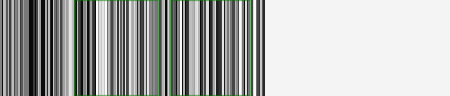

predicted


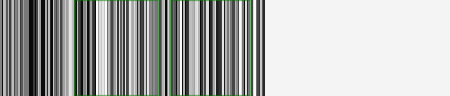

predicted


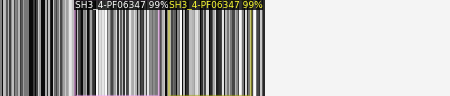

  2%|▏         | 7/435 [00:00<00:52,  8.16it/s]

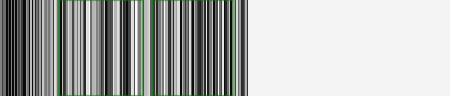

predicted


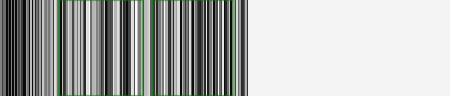

predicted


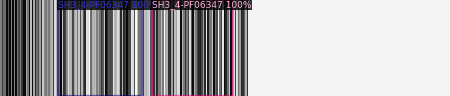

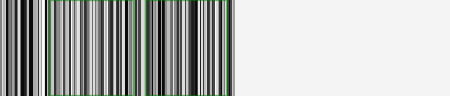

predicted


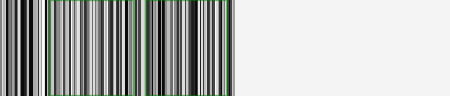

predicted


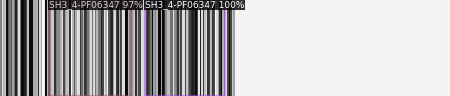

  2%|▏         | 9/435 [00:00<00:48,  8.80it/s]

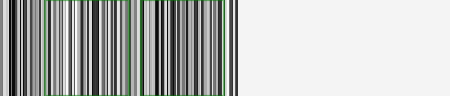

predicted


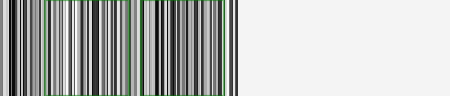

predicted


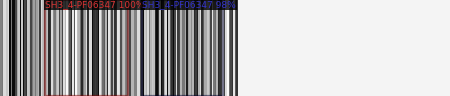

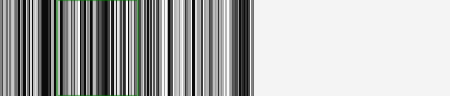

predicted


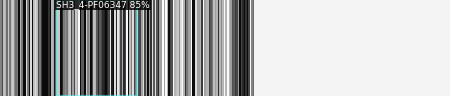

  3%|▎         | 11/435 [00:01<00:44,  9.46it/s]

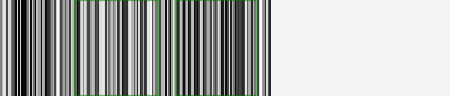

predicted


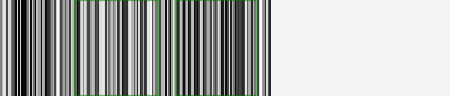

predicted


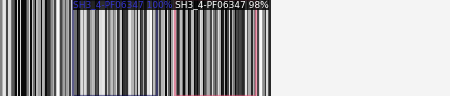

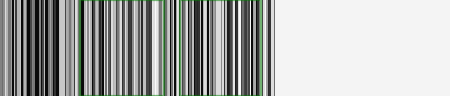

predicted


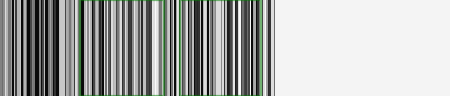

predicted


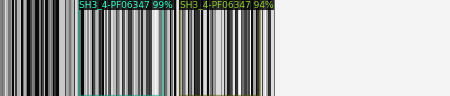

  3%|▎         | 13/435 [00:01<00:43,  9.79it/s]

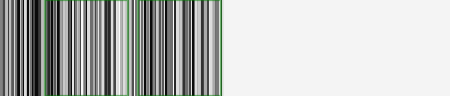

predicted


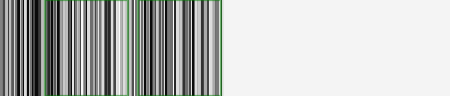

predicted


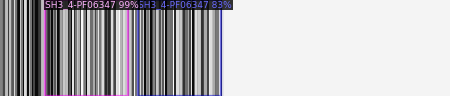

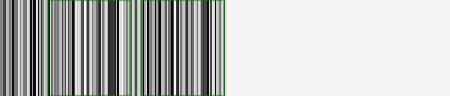

predicted


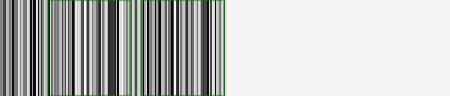

predicted


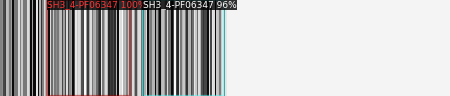

  3%|▎         | 15/435 [00:01<00:41, 10.02it/s]

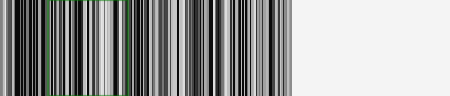

predicted


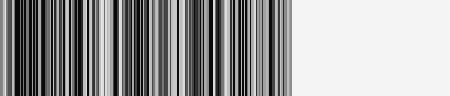

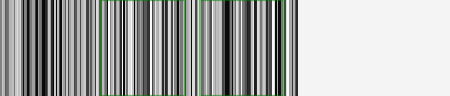

predicted


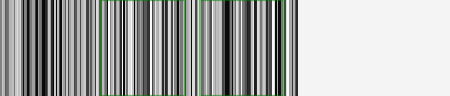

predicted


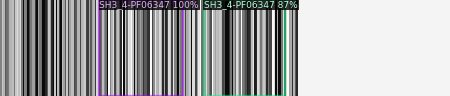

  4%|▍         | 17/435 [00:01<00:39, 10.47it/s]

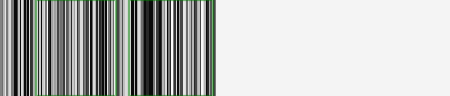

predicted


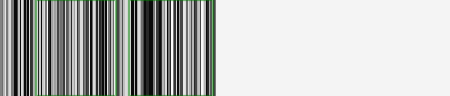

predicted


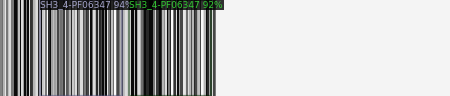

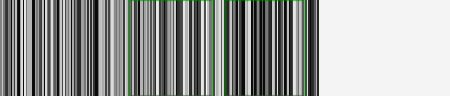

predicted


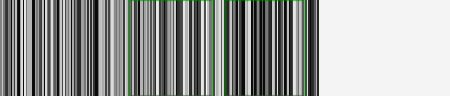

predicted


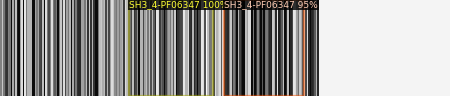

  4%|▍         | 19/435 [00:01<00:39, 10.54it/s]

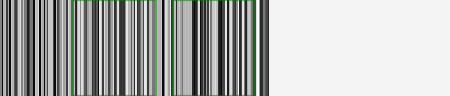

predicted


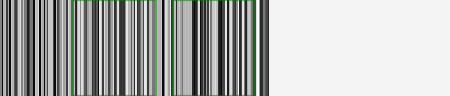

predicted


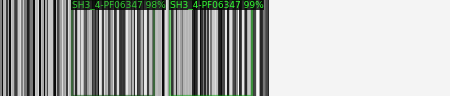

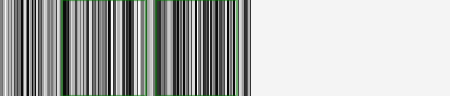

predicted


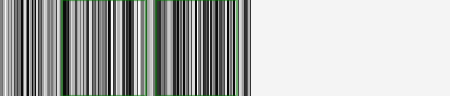

predicted


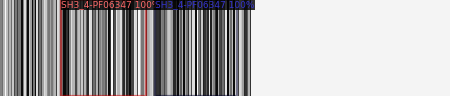

  5%|▍         | 21/435 [00:02<00:39, 10.58it/s]

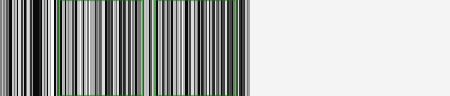

predicted


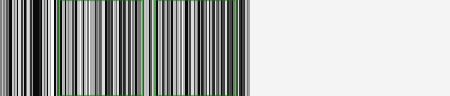

predicted


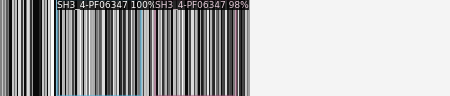

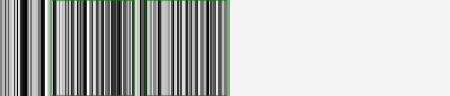

predicted


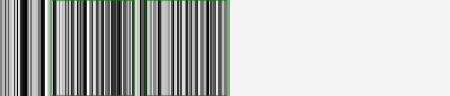

predicted


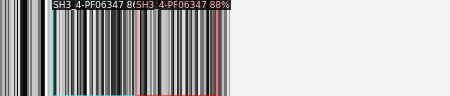

  5%|▌         | 23/435 [00:02<00:38, 10.65it/s]

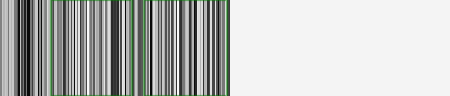

predicted


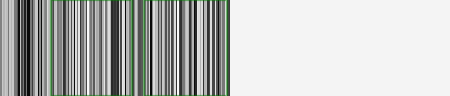

predicted


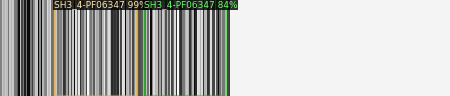

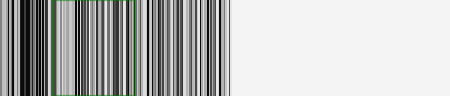

predicted


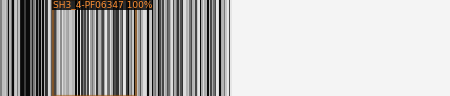

  6%|▌         | 25/435 [00:02<00:37, 10.87it/s]

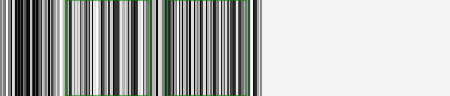

predicted


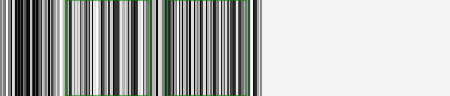

predicted


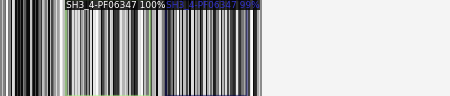

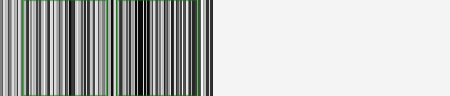

predicted


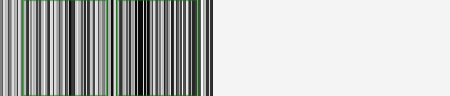

predicted


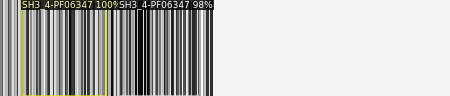

  6%|▌         | 27/435 [00:02<00:37, 10.87it/s]

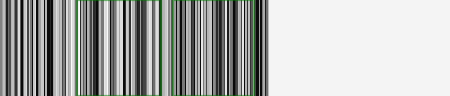

predicted


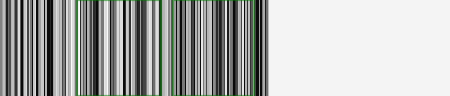

predicted


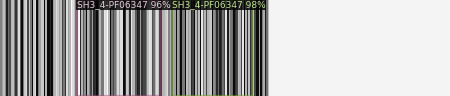

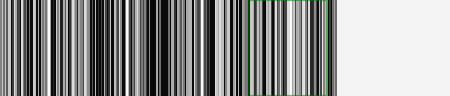

predicted


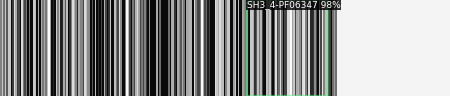

  7%|▋         | 29/435 [00:02<00:36, 11.04it/s]

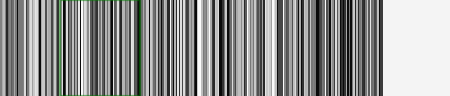

predicted


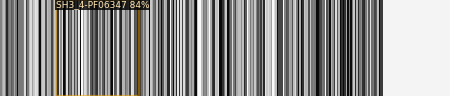

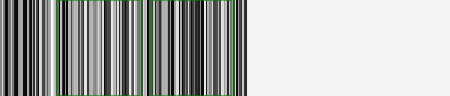

predicted


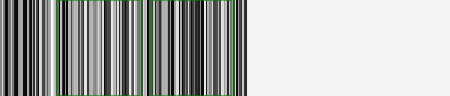

predicted


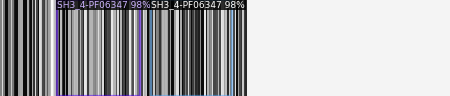

  7%|▋         | 31/435 [00:03<00:44,  9.02it/s]

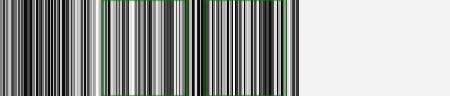

predicted


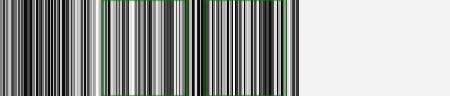

predicted


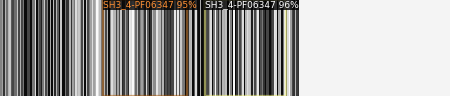

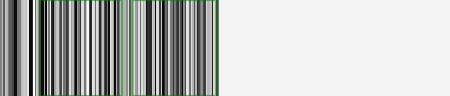

predicted


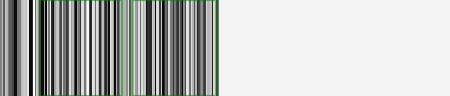

predicted


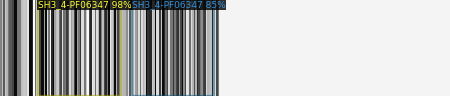

  8%|▊         | 33/435 [00:03<00:42,  9.47it/s]

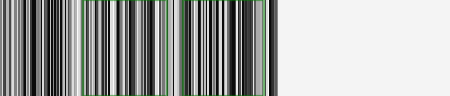

predicted


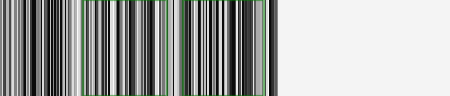

predicted


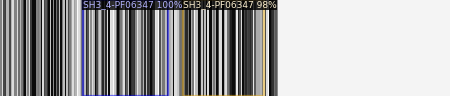

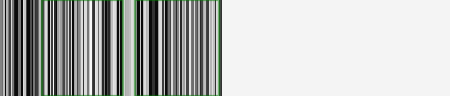

predicted


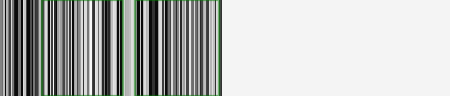

predicted


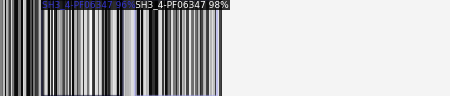

  8%|▊         | 35/435 [00:03<00:40,  9.79it/s]

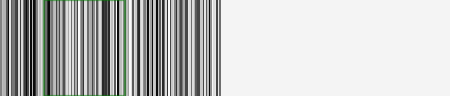

predicted


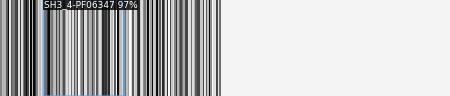

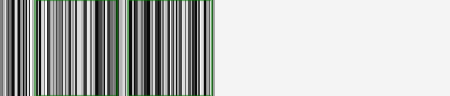

predicted


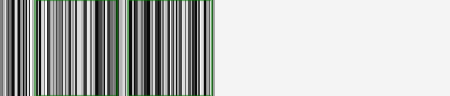

predicted


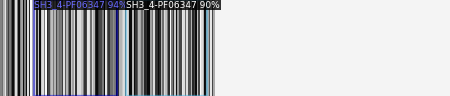

  9%|▊         | 37/435 [00:03<00:38, 10.25it/s]

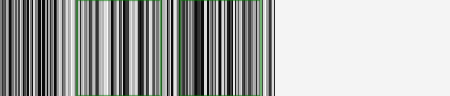

predicted


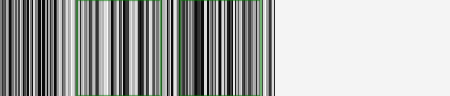

predicted


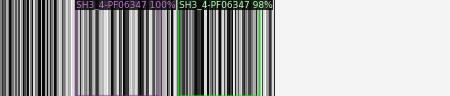

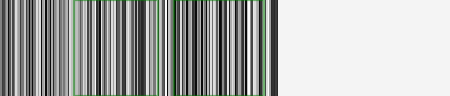

predicted


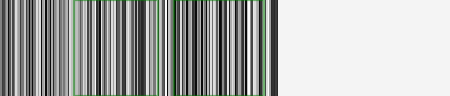

predicted


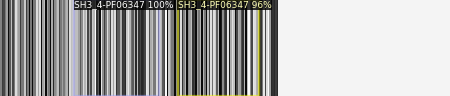

  9%|▉         | 39/435 [00:03<00:38, 10.40it/s]

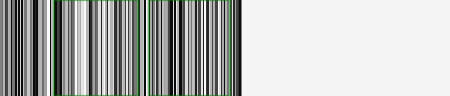

predicted


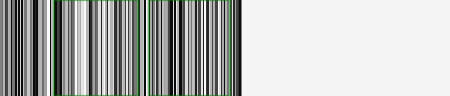

predicted


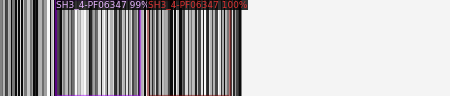

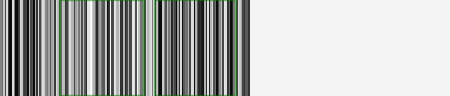

predicted


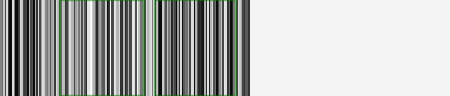

predicted


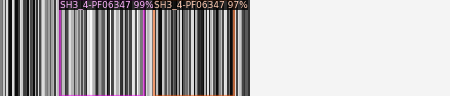

  9%|▉         | 41/435 [00:04<00:37, 10.51it/s]

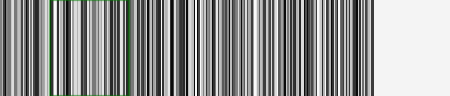

predicted


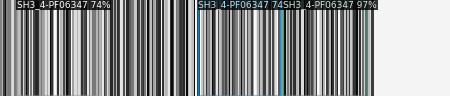

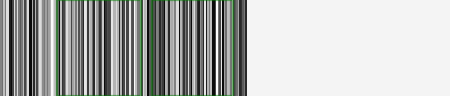

predicted


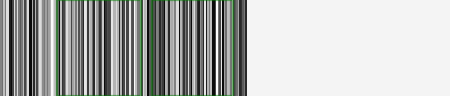

predicted


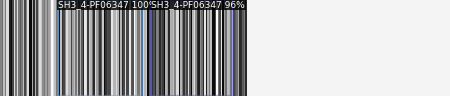

 10%|▉         | 43/435 [00:04<00:36, 10.66it/s]

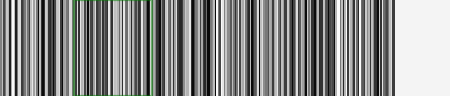

predicted


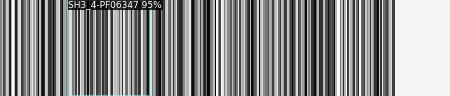

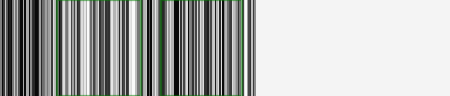

predicted


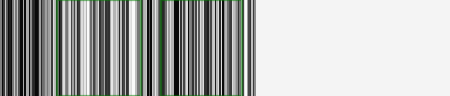

predicted


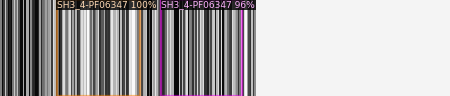

 10%|█         | 45/435 [00:04<00:35, 10.91it/s]

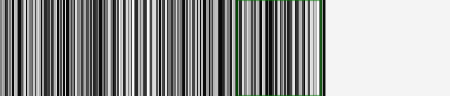

predicted


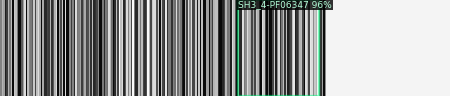

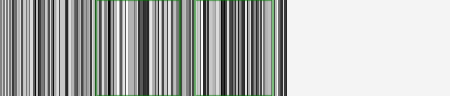

predicted


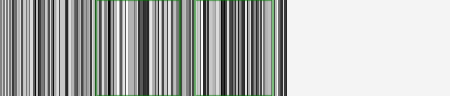

predicted


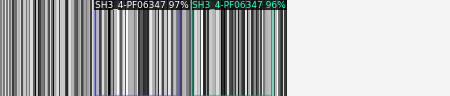

 11%|█         | 47/435 [00:04<00:34, 11.11it/s]

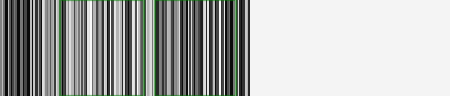

predicted


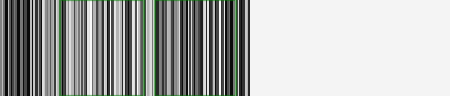

predicted


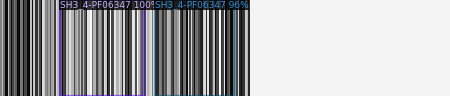

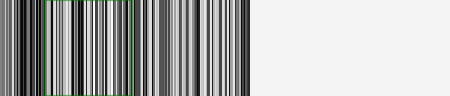

predicted


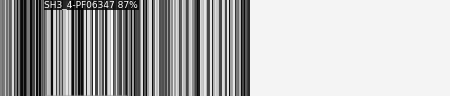

 11%|█▏        | 49/435 [00:04<00:34, 11.24it/s]

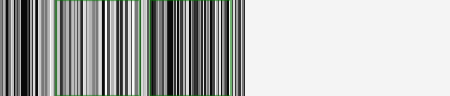

predicted


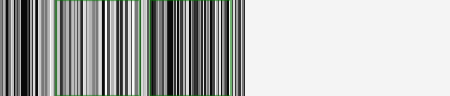

predicted


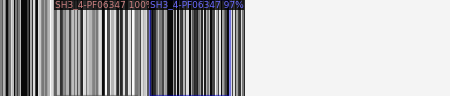

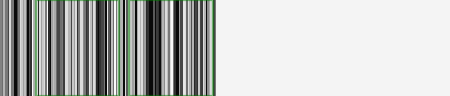

predicted


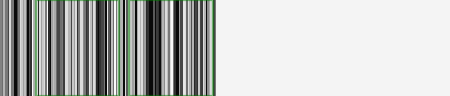

predicted


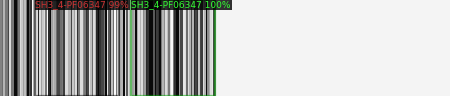

 12%|█▏        | 51/435 [00:04<00:34, 11.09it/s]

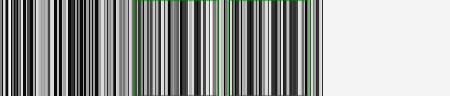

predicted


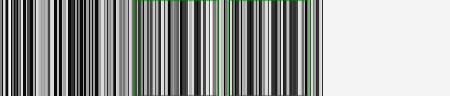

predicted


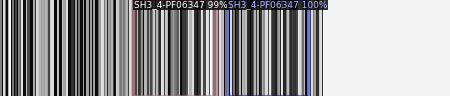

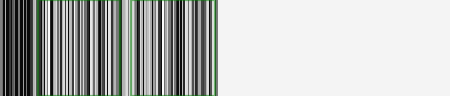

predicted


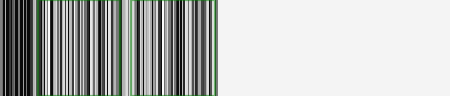

predicted


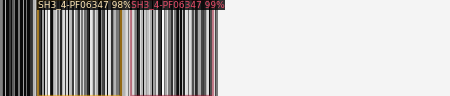

 12%|█▏        | 53/435 [00:05<00:34, 10.93it/s]

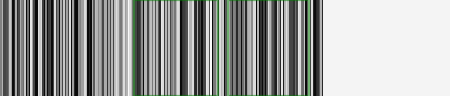

predicted


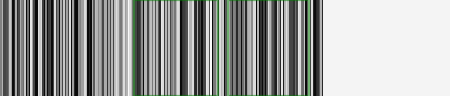

predicted


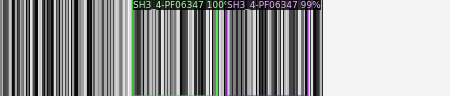

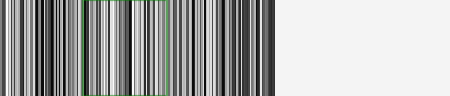

predicted


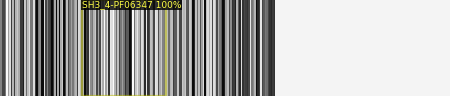

 13%|█▎        | 55/435 [00:05<00:34, 11.11it/s]

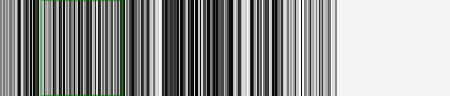

predicted


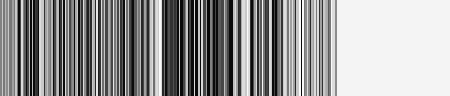

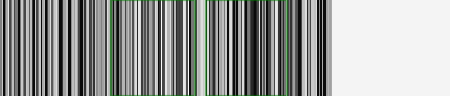

predicted


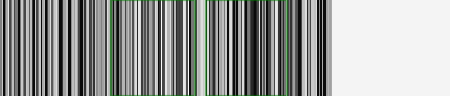

predicted


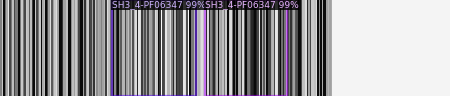

 13%|█▎        | 57/435 [00:05<00:41,  9.08it/s]

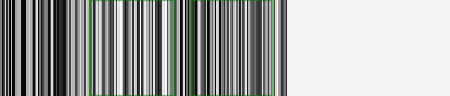

predicted


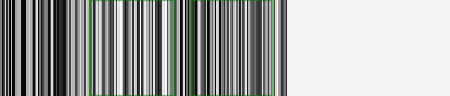

predicted


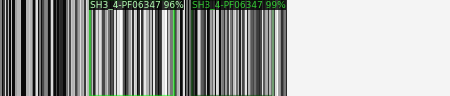

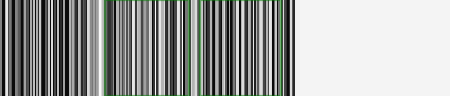

predicted


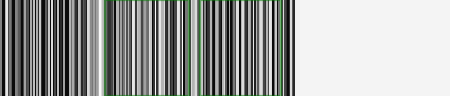

predicted


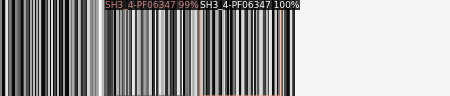

 14%|█▎        | 59/435 [00:05<00:39,  9.51it/s]

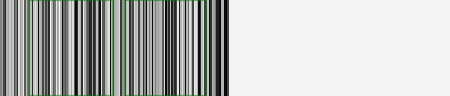

predicted


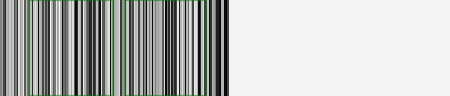

predicted


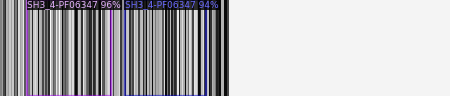

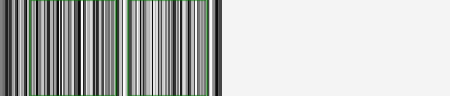

predicted


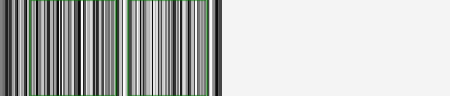

predicted


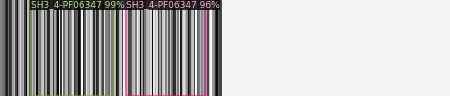

 14%|█▍        | 61/435 [00:05<00:37,  9.85it/s]

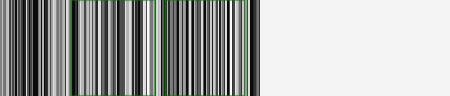

predicted


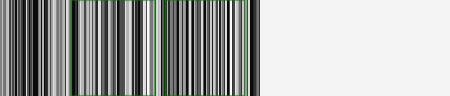

predicted


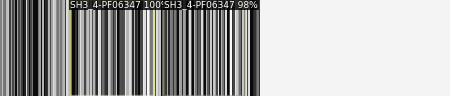

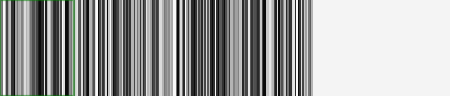

predicted


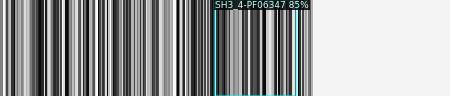

 14%|█▍        | 63/435 [00:06<00:36, 10.30it/s]

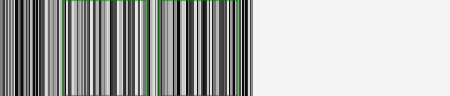

predicted


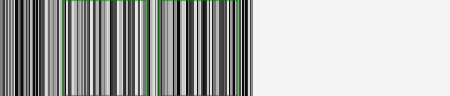

predicted


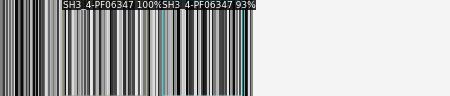

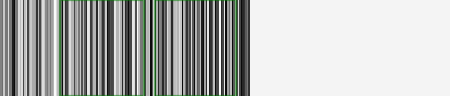

predicted


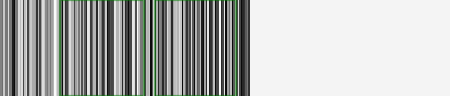

predicted


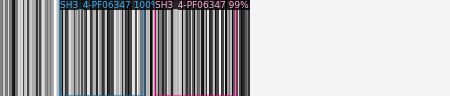

 15%|█▍        | 65/435 [00:06<00:35, 10.47it/s]

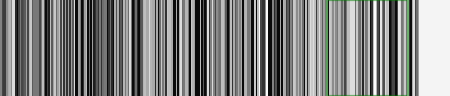

predicted


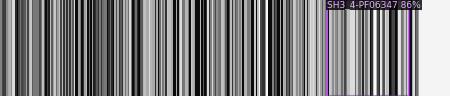

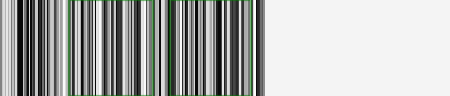

predicted


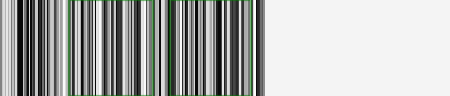

predicted


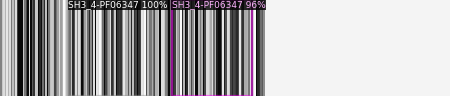

 15%|█▌        | 67/435 [00:06<00:34, 10.80it/s]

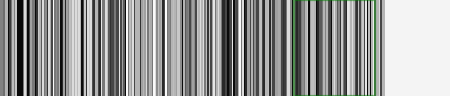

predicted


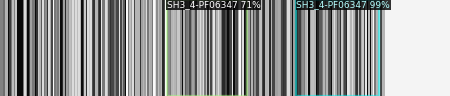

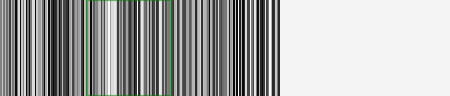

predicted


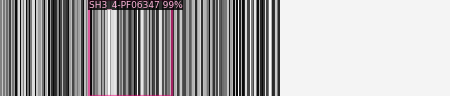

 16%|█▌        | 69/435 [00:06<00:32, 11.17it/s]

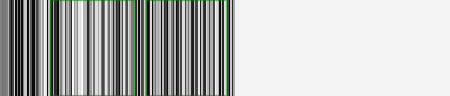

predicted


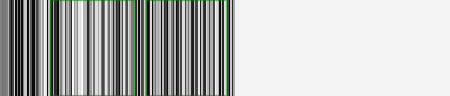

predicted


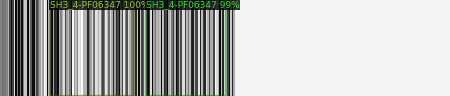

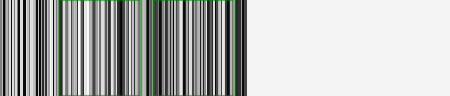

predicted


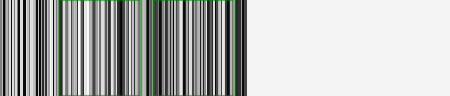

predicted


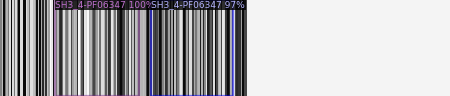

 16%|█▋        | 71/435 [00:06<00:32, 11.04it/s]

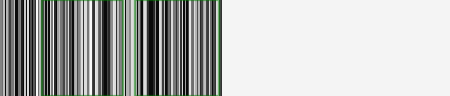

predicted


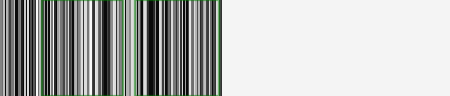

predicted


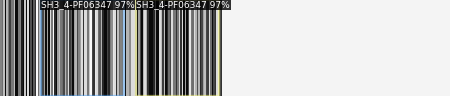

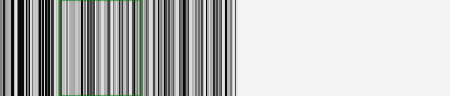

predicted


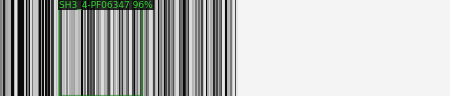

 17%|█▋        | 73/435 [00:07<00:32, 11.18it/s]

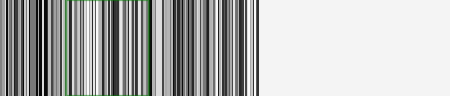

predicted


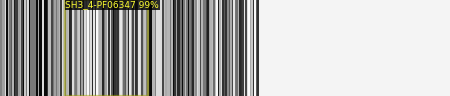

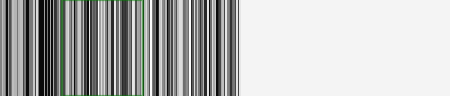

predicted


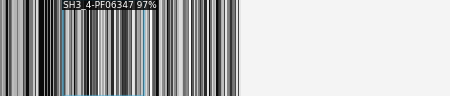

 17%|█▋        | 75/435 [00:07<00:31, 11.55it/s]

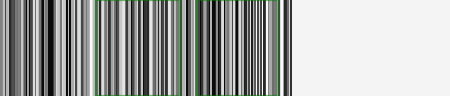

predicted


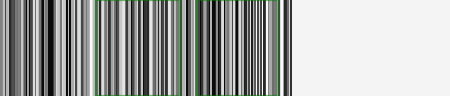

predicted


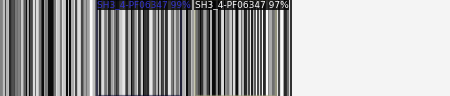

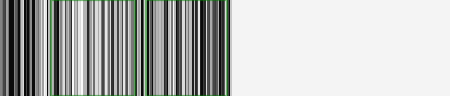

predicted


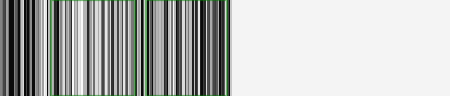

predicted


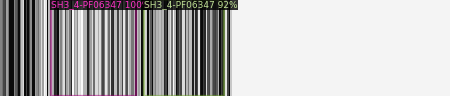

 18%|█▊        | 77/435 [00:07<00:31, 11.30it/s]

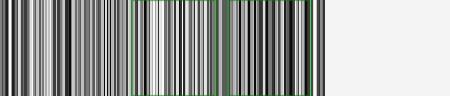

predicted


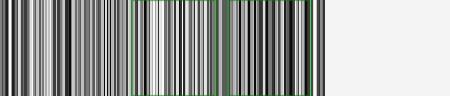

predicted


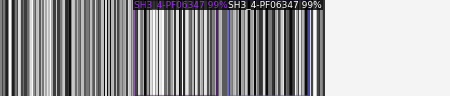

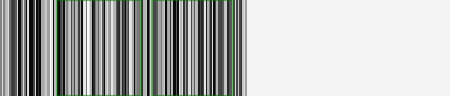

predicted


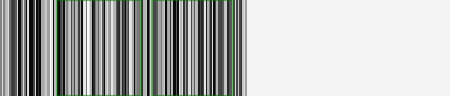

predicted


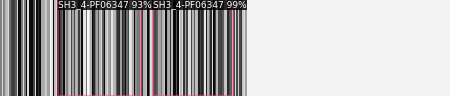

 18%|█▊        | 79/435 [00:07<00:31, 11.19it/s]

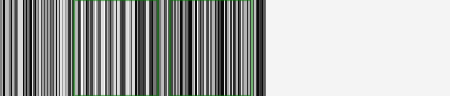

predicted


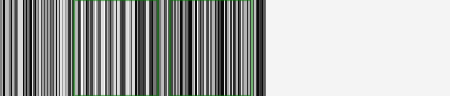

predicted


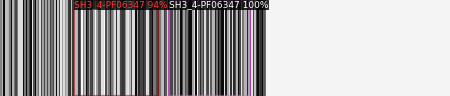

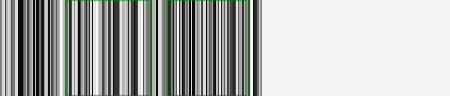

predicted


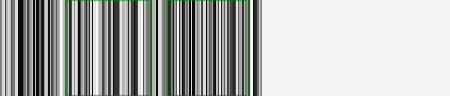

predicted


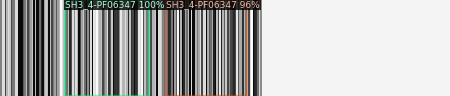

 19%|█▊        | 81/435 [00:07<00:39,  8.95it/s]

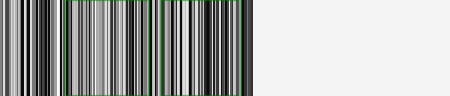

predicted


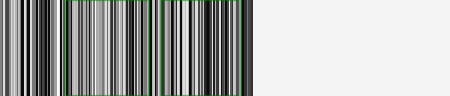

predicted


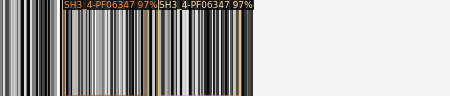

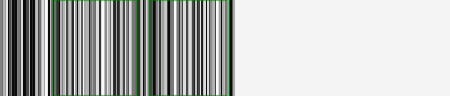

predicted


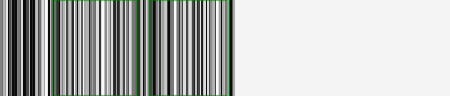

predicted


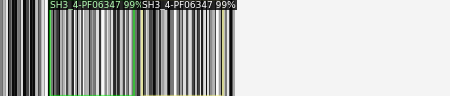

 19%|█▉        | 83/435 [00:08<00:37,  9.42it/s]

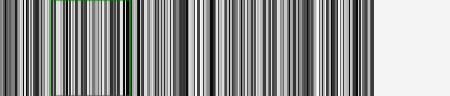

predicted


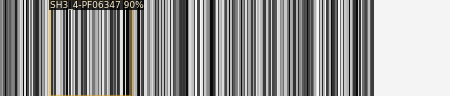

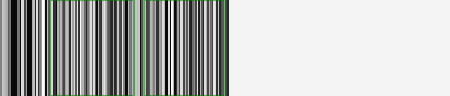

predicted


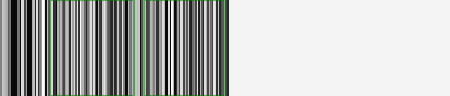

predicted


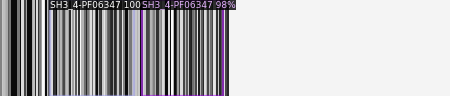

 20%|█▉        | 85/435 [00:08<00:35,  9.92it/s]

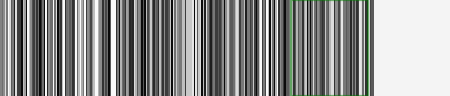

predicted


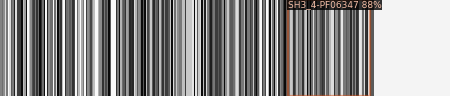

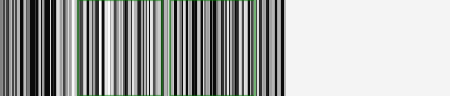

predicted


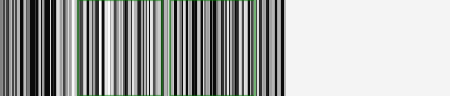

predicted


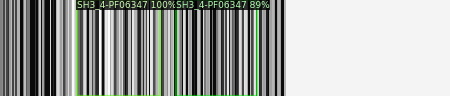

 20%|██        | 87/435 [00:08<00:33, 10.39it/s]

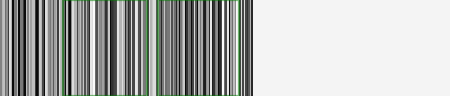

predicted


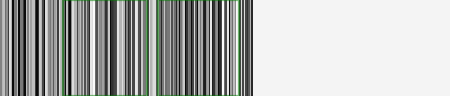

predicted


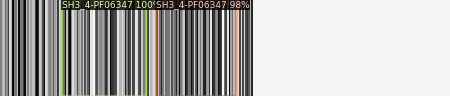

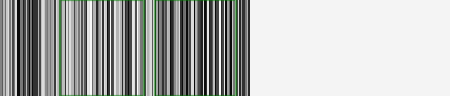

predicted


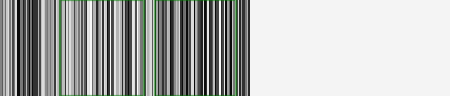

predicted


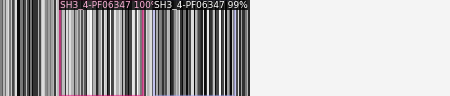

 20%|██        | 89/435 [00:08<00:32, 10.51it/s]

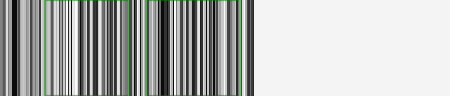

predicted


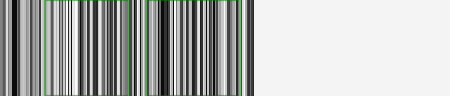

predicted


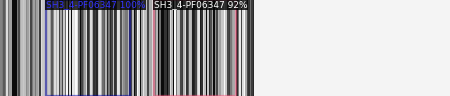

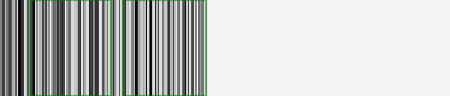

predicted


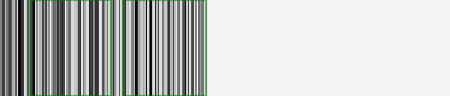

predicted


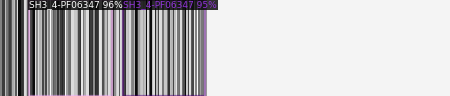

 21%|██        | 91/435 [00:08<00:32, 10.61it/s]

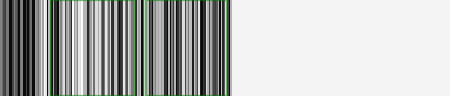

predicted


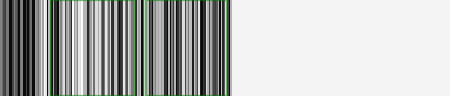

predicted


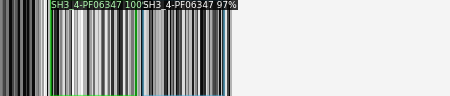

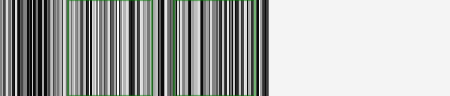

predicted


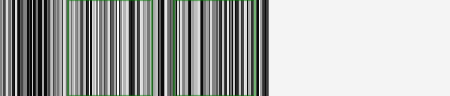

predicted


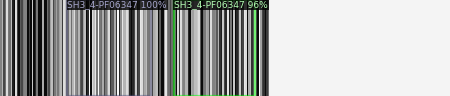

 21%|██▏       | 93/435 [00:08<00:32, 10.69it/s]

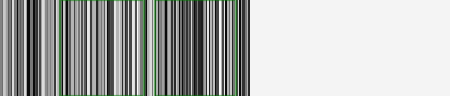

predicted


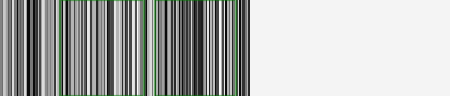

predicted


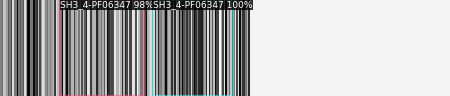

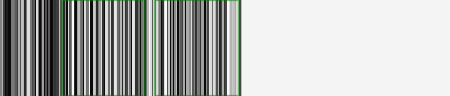

predicted


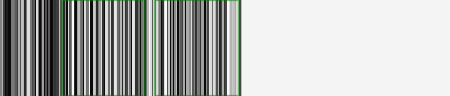

predicted


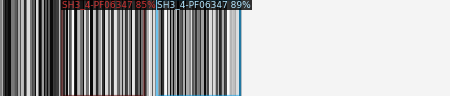

 22%|██▏       | 95/435 [00:09<00:31, 10.71it/s]

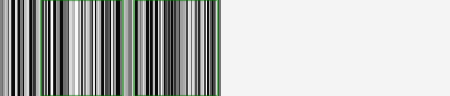

predicted


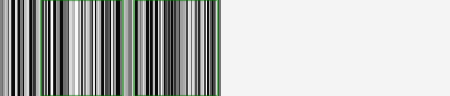

predicted


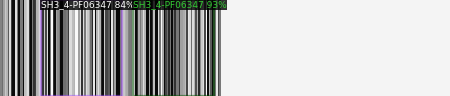

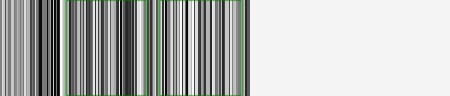

predicted


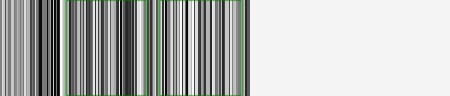

predicted


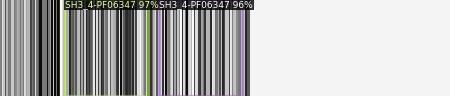

 22%|██▏       | 97/435 [00:09<00:31, 10.72it/s]

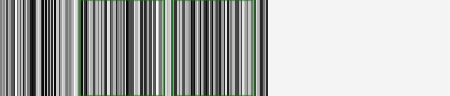

predicted


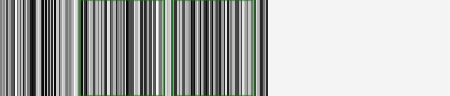

predicted


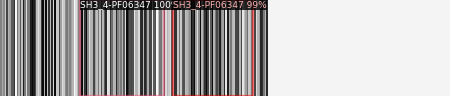

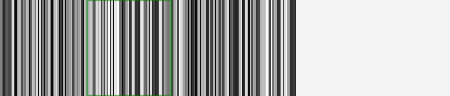

predicted


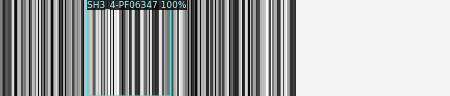

 23%|██▎       | 99/435 [00:09<00:30, 10.93it/s]

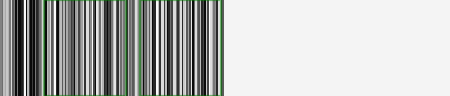

predicted


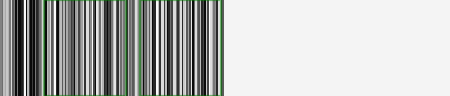

predicted


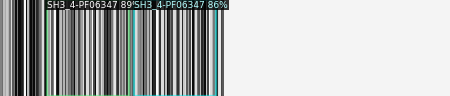

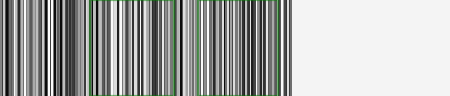

predicted


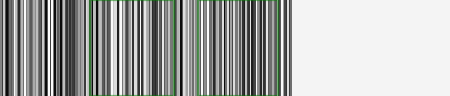

predicted


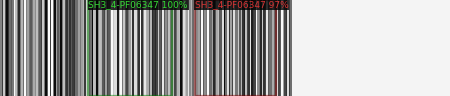

 23%|██▎       | 101/435 [00:09<00:30, 10.94it/s]

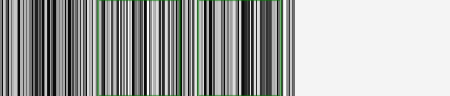

predicted


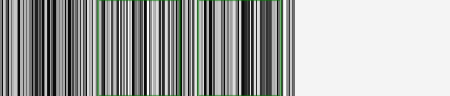

predicted


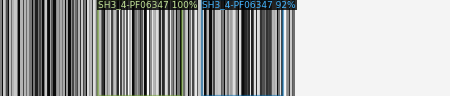

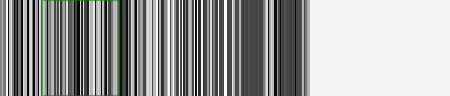

predicted


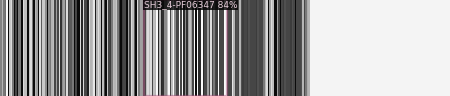

 24%|██▎       | 103/435 [00:09<00:29, 11.14it/s]

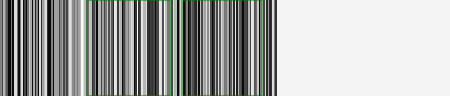

predicted


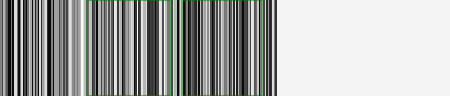

predicted


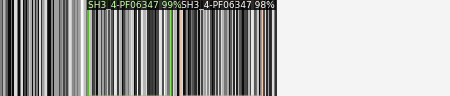

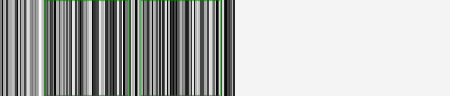

predicted


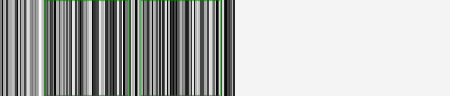

predicted


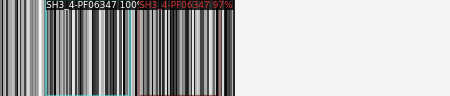

 24%|██▍       | 105/435 [00:10<00:29, 11.07it/s]

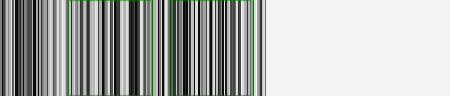

predicted


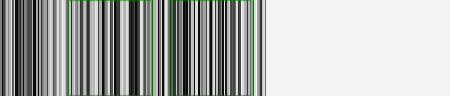

predicted


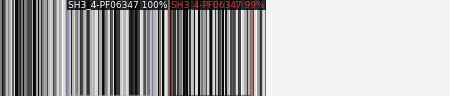

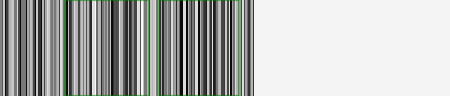

predicted


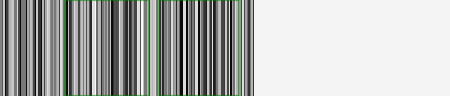

predicted


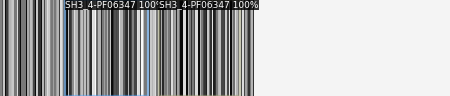

 25%|██▍       | 107/435 [00:10<00:36,  8.89it/s]

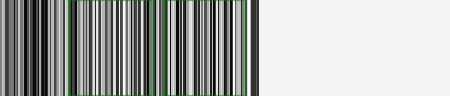

predicted


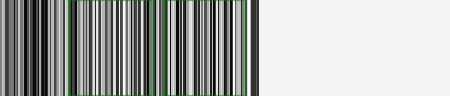

predicted


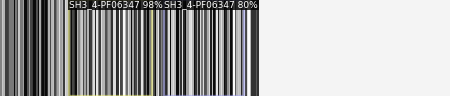

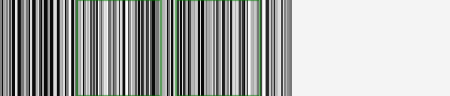

predicted


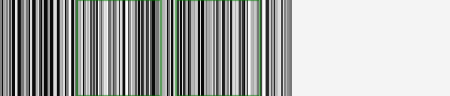

predicted


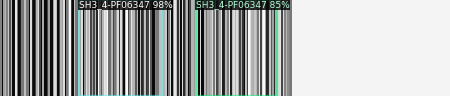

 25%|██▌       | 109/435 [00:10<00:34,  9.39it/s]

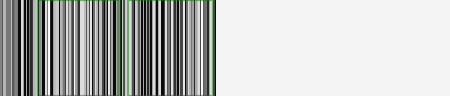

predicted


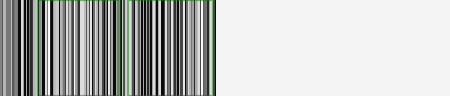

predicted


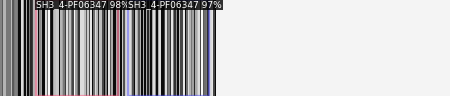

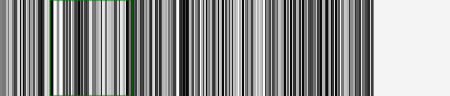

predicted


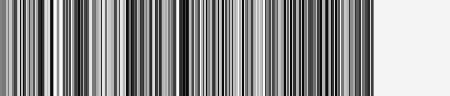

 26%|██▌       | 111/435 [00:10<00:32, 10.04it/s]

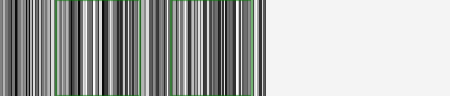

predicted


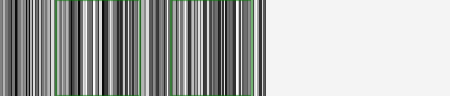

predicted


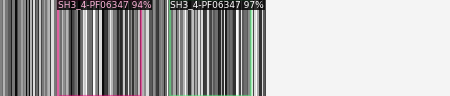

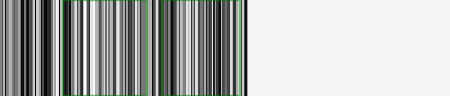

predicted


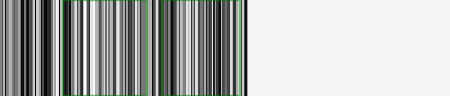

predicted


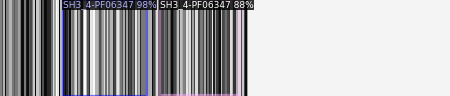

 26%|██▌       | 113/435 [00:10<00:31, 10.21it/s]

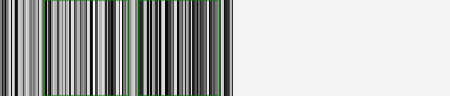

predicted


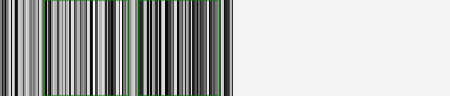

predicted


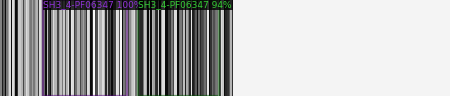

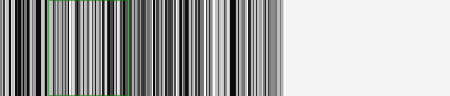

predicted


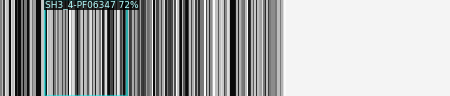

 26%|██▋       | 115/435 [00:11<00:30, 10.46it/s]

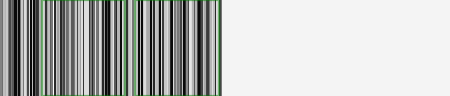

predicted


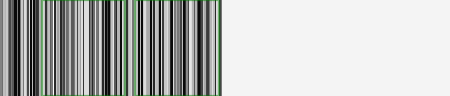

predicted


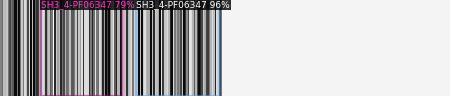

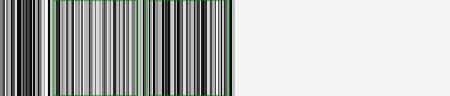

predicted


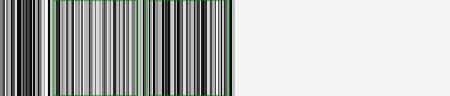

predicted


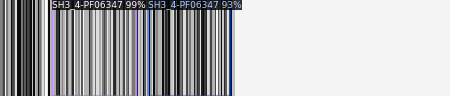

 27%|██▋       | 117/435 [00:11<00:30, 10.57it/s]

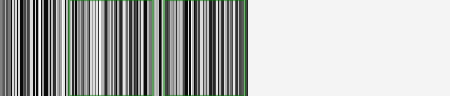

predicted


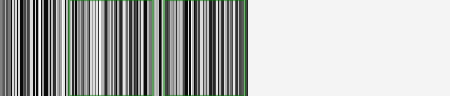

predicted


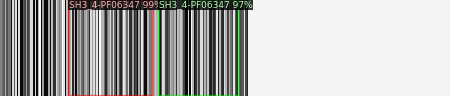

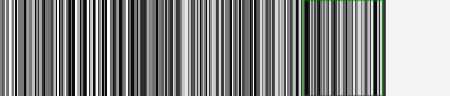

predicted


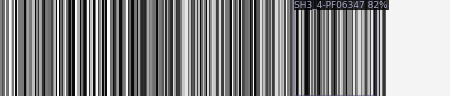

 27%|██▋       | 119/435 [00:11<00:29, 10.82it/s]

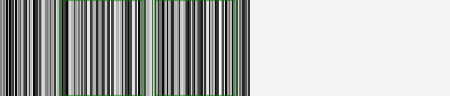

predicted


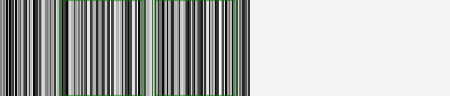

predicted


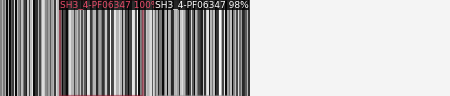

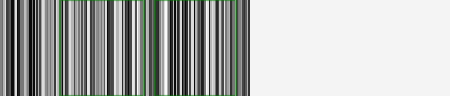

predicted


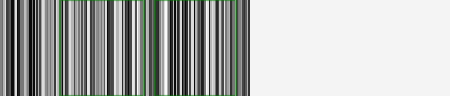

predicted


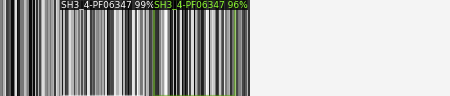

 28%|██▊       | 121/435 [00:11<00:29, 10.80it/s]

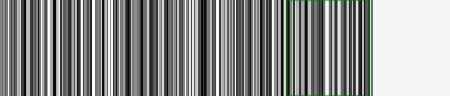

predicted


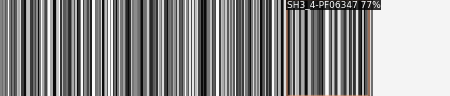

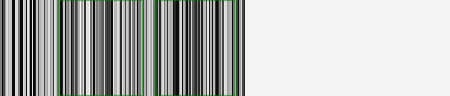

predicted


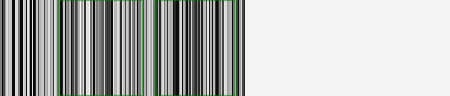

predicted


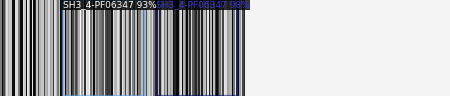

 28%|██▊       | 123/435 [00:11<00:28, 10.98it/s]

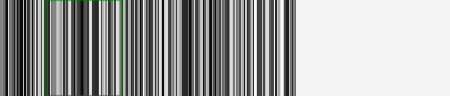

predicted


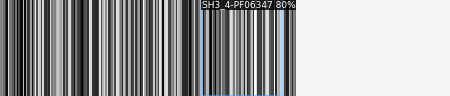

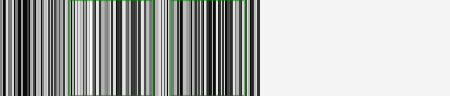

predicted


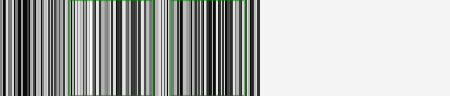

predicted


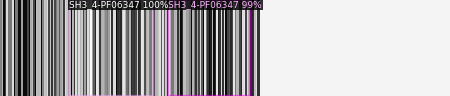

 29%|██▊       | 125/435 [00:11<00:27, 11.16it/s]

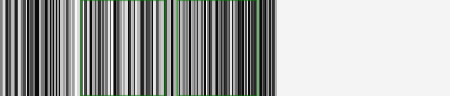

predicted


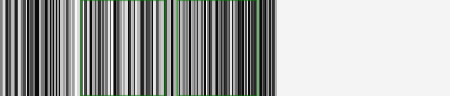

predicted


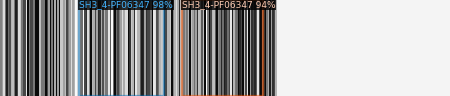

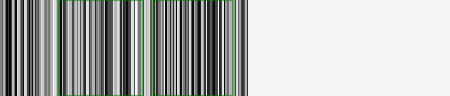

predicted


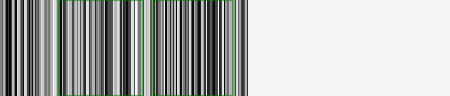

predicted


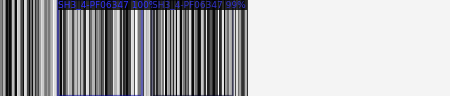

 29%|██▉       | 127/435 [00:12<00:27, 11.12it/s]

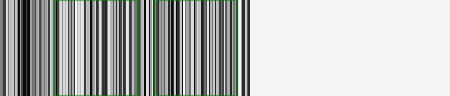

predicted


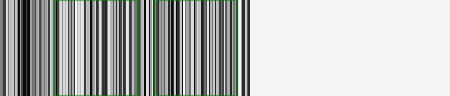

predicted


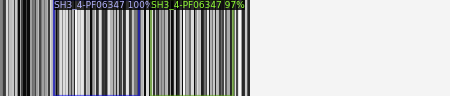

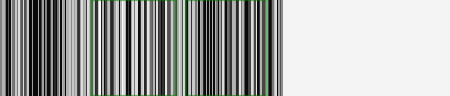

predicted


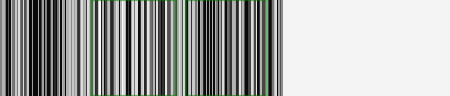

predicted


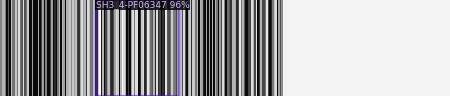

 30%|██▉       | 129/435 [00:12<00:27, 11.12it/s]

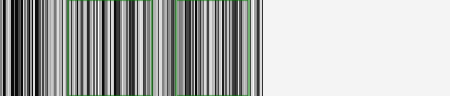

predicted


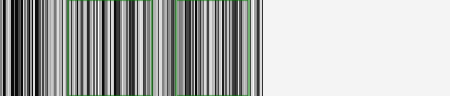

predicted


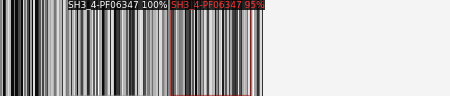

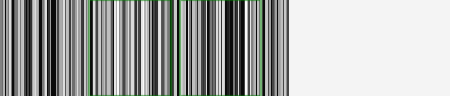

predicted


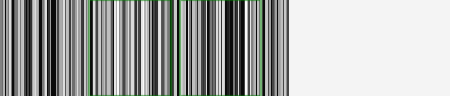

predicted


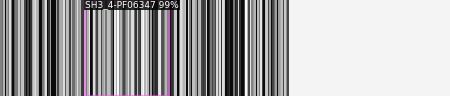

 30%|███       | 131/435 [00:12<00:33,  9.00it/s]

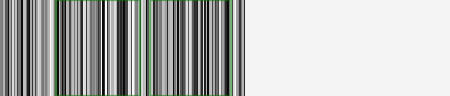

predicted


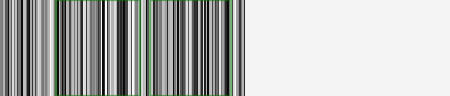

predicted


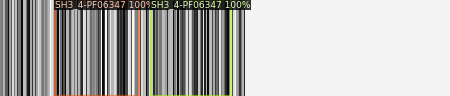

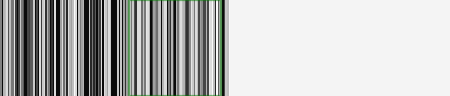

predicted


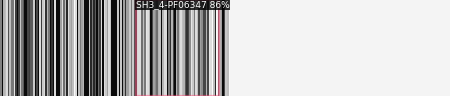

 31%|███       | 133/435 [00:12<00:31,  9.65it/s]

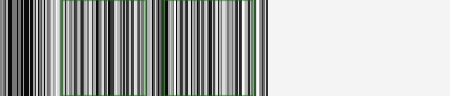

predicted


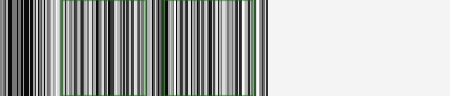

predicted


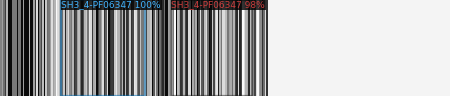

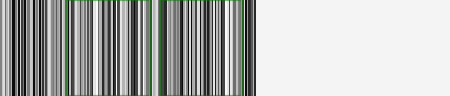

predicted


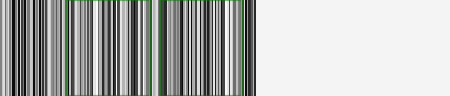

predicted


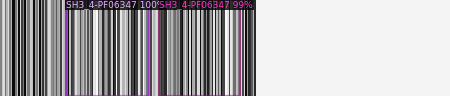

 31%|███       | 135/435 [00:13<00:30,  9.97it/s]

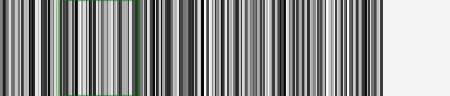

predicted


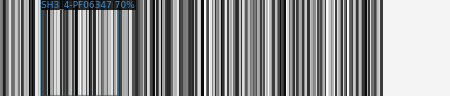

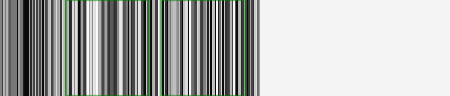

predicted


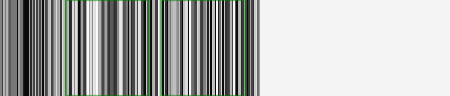

predicted


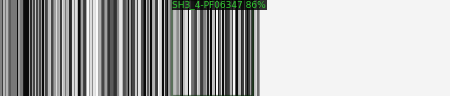

 31%|███▏      | 137/435 [00:13<00:28, 10.45it/s]

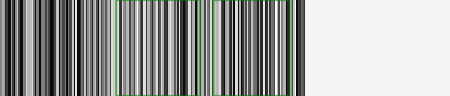

predicted


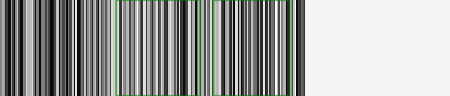

predicted


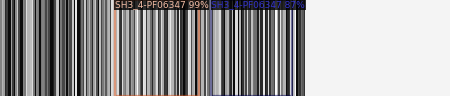

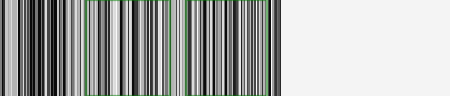

predicted


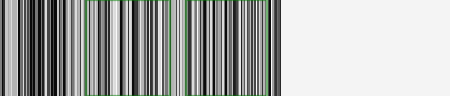

predicted


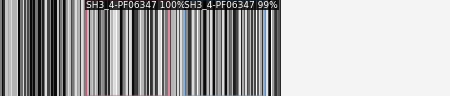

 32%|███▏      | 139/435 [00:13<00:28, 10.55it/s]

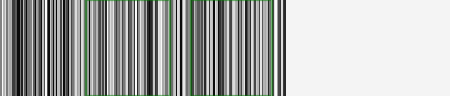

predicted


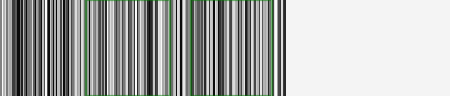

predicted


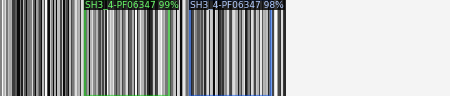

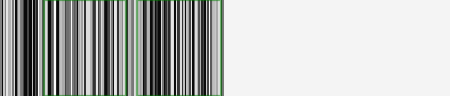

predicted


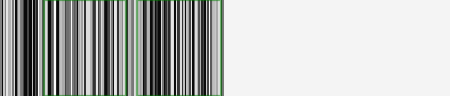

predicted


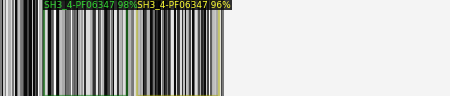

 32%|███▏      | 141/435 [00:13<00:27, 10.63it/s]

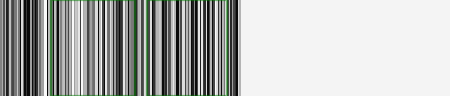

predicted


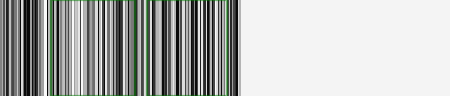

predicted


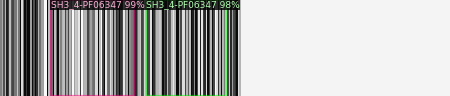

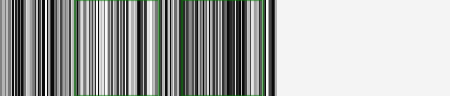

predicted


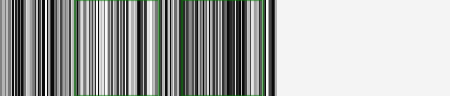

predicted


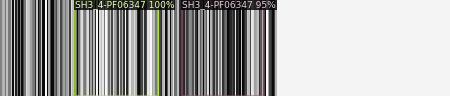

 33%|███▎      | 143/435 [00:13<00:27, 10.65it/s]

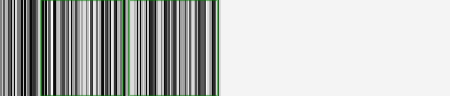

predicted


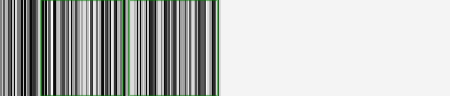

predicted


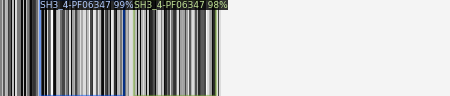

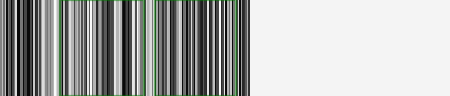

predicted


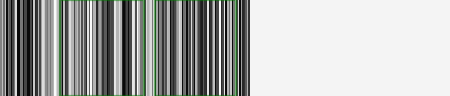

predicted


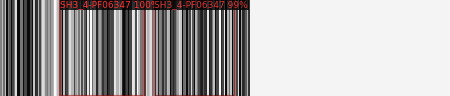

 33%|███▎      | 145/435 [00:13<00:27, 10.65it/s]

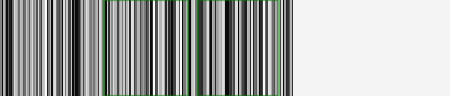

predicted


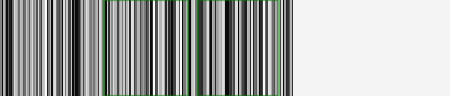

predicted


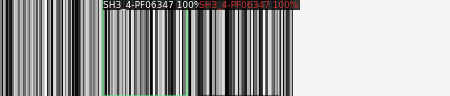

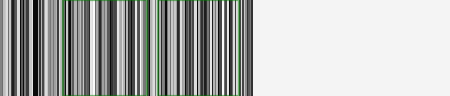

predicted


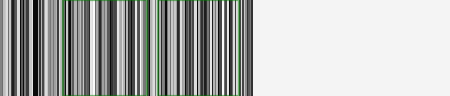

predicted


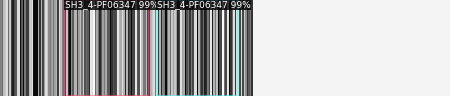

 34%|███▍      | 147/435 [00:14<00:26, 10.73it/s]

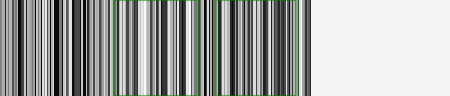

predicted


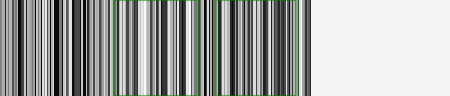

predicted


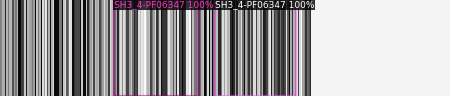

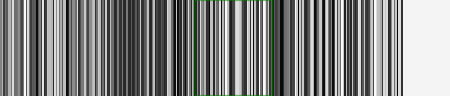

predicted


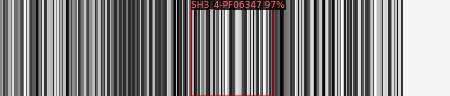

 34%|███▍      | 149/435 [00:14<00:26, 10.96it/s]

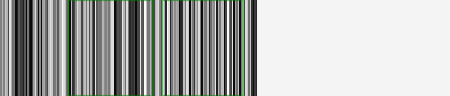

predicted


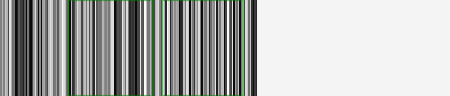

predicted


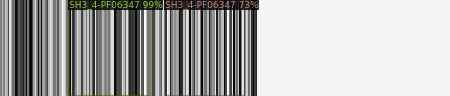

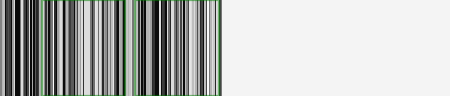

predicted


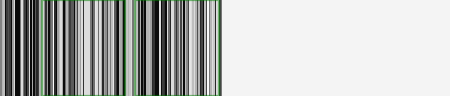

predicted


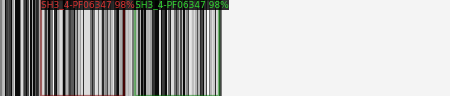

 35%|███▍      | 151/435 [00:14<00:26, 10.88it/s]

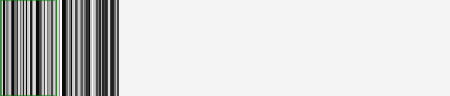

predicted


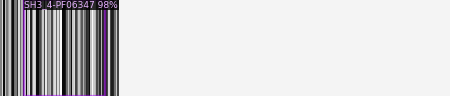

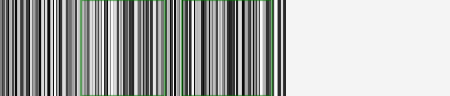

predicted


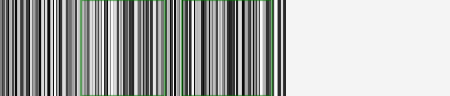

predicted


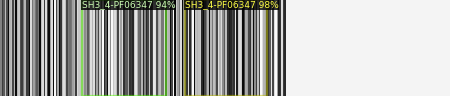

 35%|███▌      | 153/435 [00:14<00:25, 11.09it/s]

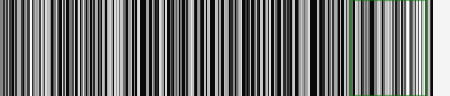

predicted


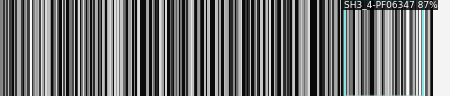

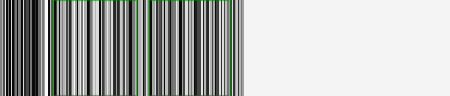

predicted


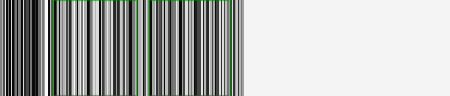

predicted


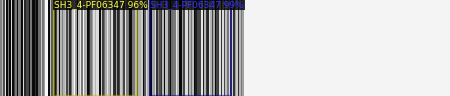

 36%|███▌      | 155/435 [00:14<00:30,  9.06it/s]

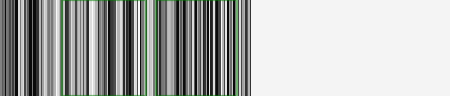

predicted


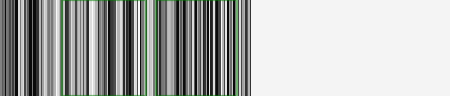

predicted


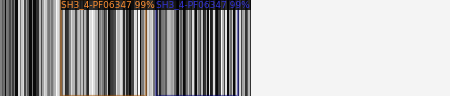

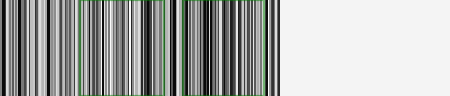

predicted


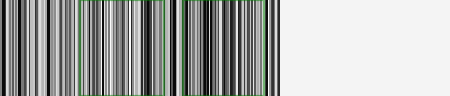

predicted


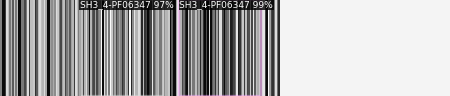

 36%|███▌      | 157/435 [00:15<00:29,  9.45it/s]

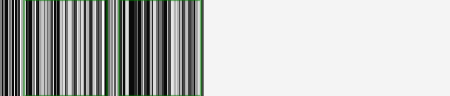

predicted


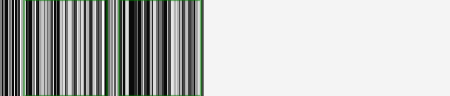

predicted


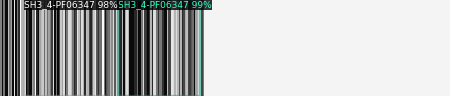

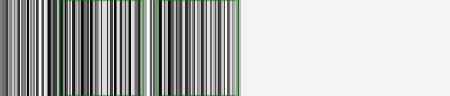

predicted


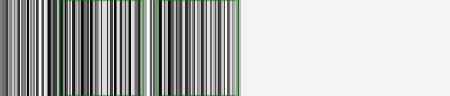

predicted


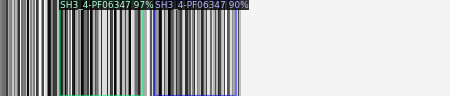

 37%|███▋      | 159/435 [00:15<00:28,  9.76it/s]

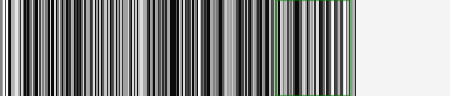

predicted


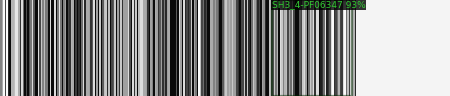

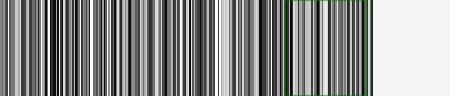

predicted


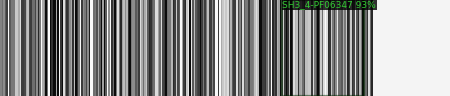

 37%|███▋      | 161/435 [00:15<00:26, 10.41it/s]

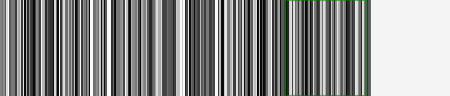

predicted


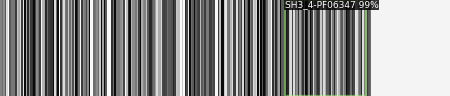

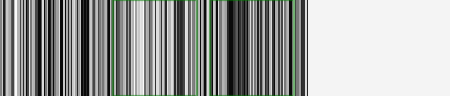

predicted


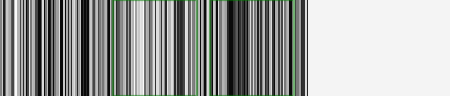

predicted


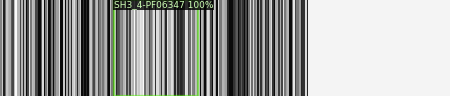

 37%|███▋      | 163/435 [00:15<00:25, 10.77it/s]

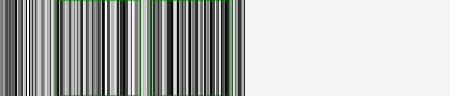

predicted


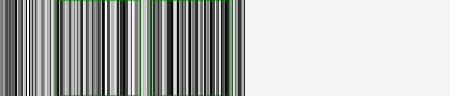

predicted


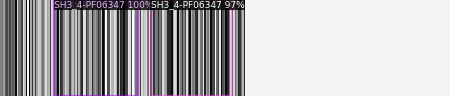

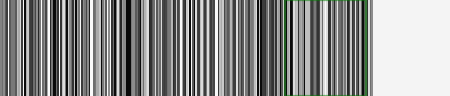

predicted


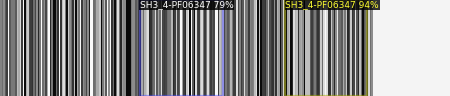

 38%|███▊      | 165/435 [00:15<00:24, 10.87it/s]

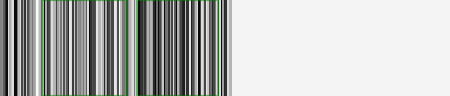

predicted


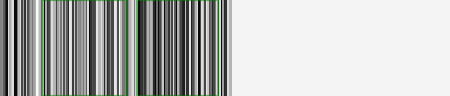

predicted


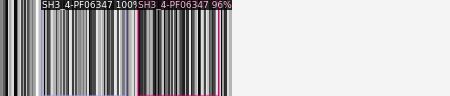

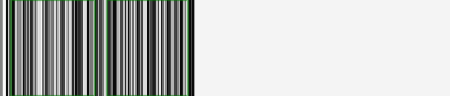

predicted


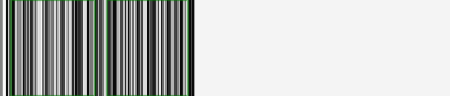

predicted


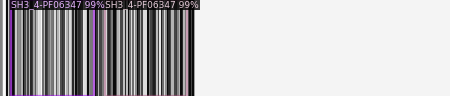

 38%|███▊      | 167/435 [00:16<00:24, 10.86it/s]

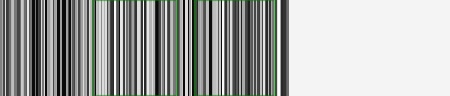

predicted


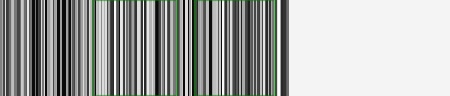

predicted


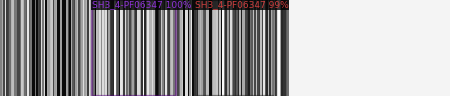

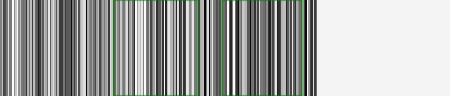

predicted


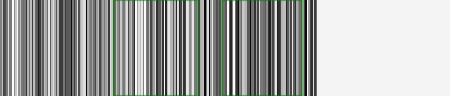

predicted


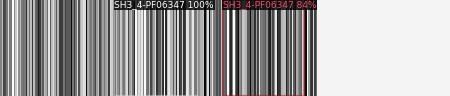

 39%|███▉      | 169/435 [00:16<00:24, 10.84it/s]

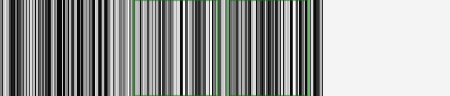

predicted


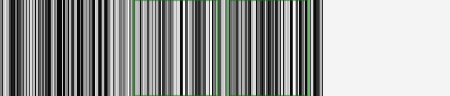

predicted


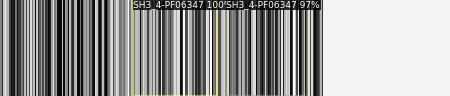

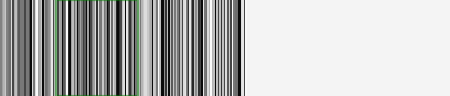

predicted


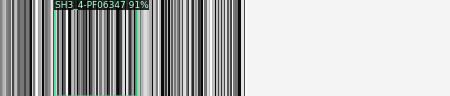

 39%|███▉      | 171/435 [00:16<00:23, 11.07it/s]

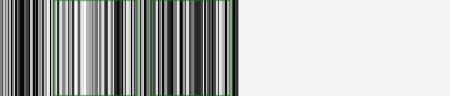

predicted


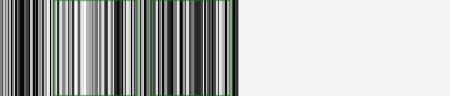

predicted


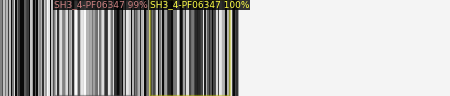

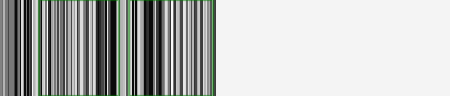

predicted


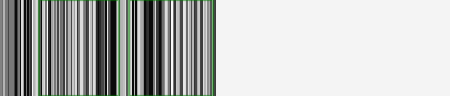

predicted


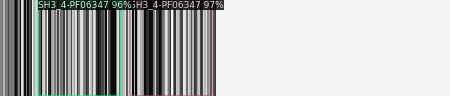

 40%|███▉      | 173/435 [00:16<00:23, 10.99it/s]

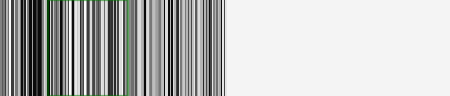

predicted


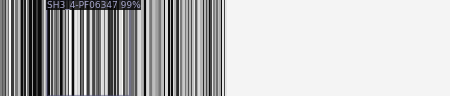

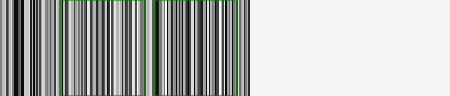

predicted


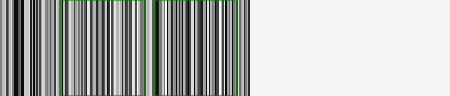

predicted


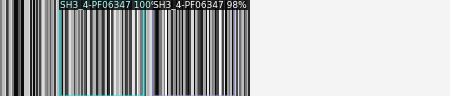

 40%|████      | 175/435 [00:16<00:23, 11.15it/s]

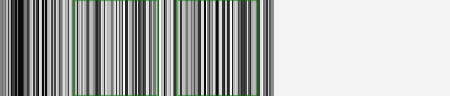

predicted


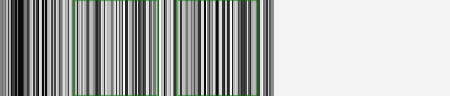

predicted


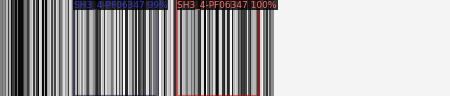

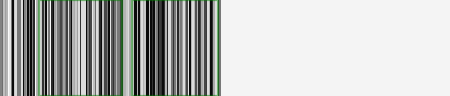

predicted


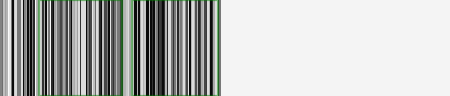

predicted


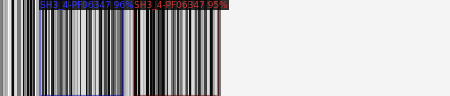

 41%|████      | 177/435 [00:16<00:23, 11.08it/s]

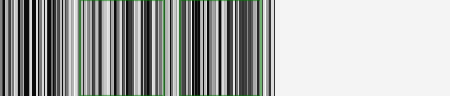

predicted


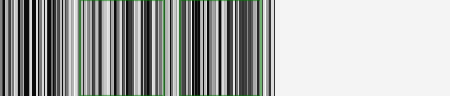

predicted


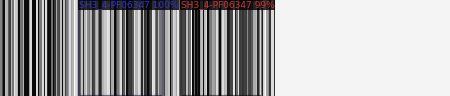

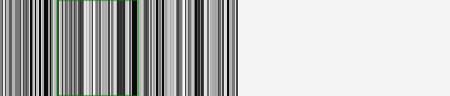

predicted


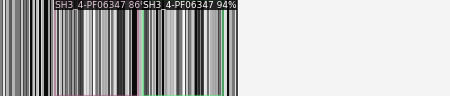

 41%|████      | 179/435 [00:17<00:28,  8.97it/s]

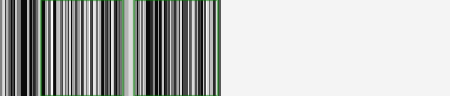

predicted


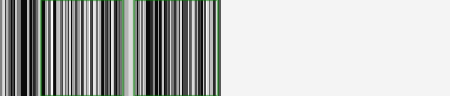

predicted


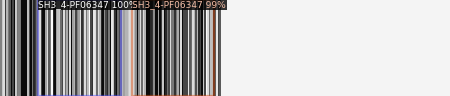

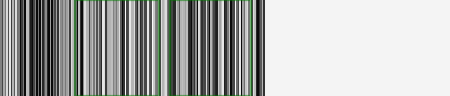

predicted


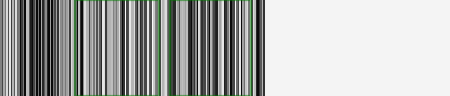

predicted


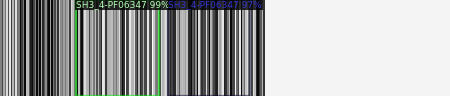

 42%|████▏     | 181/435 [00:17<00:26,  9.41it/s]

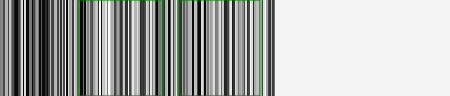

predicted


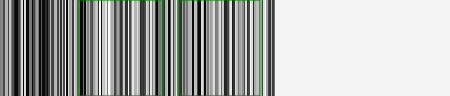

predicted


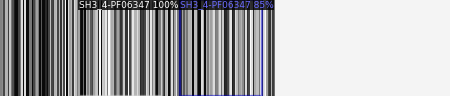

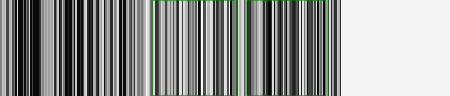

predicted


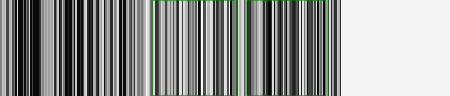

predicted


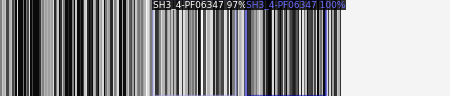

 42%|████▏     | 183/435 [00:17<00:25,  9.78it/s]

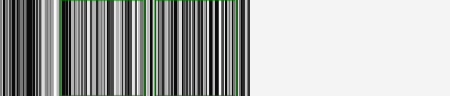

predicted


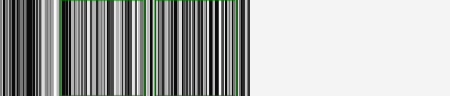

predicted


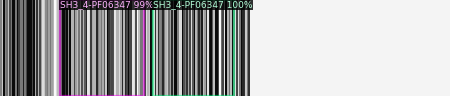

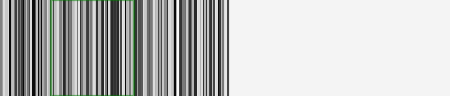

predicted


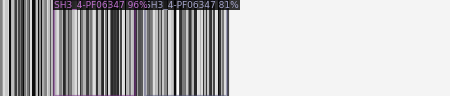

 43%|████▎     | 185/435 [00:17<00:24, 10.18it/s]

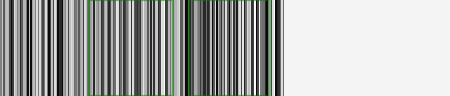

predicted


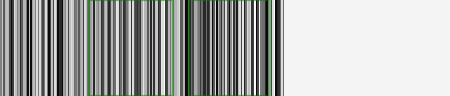

predicted


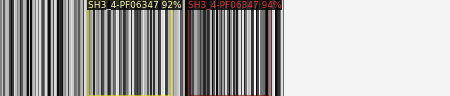

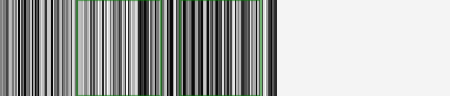

predicted


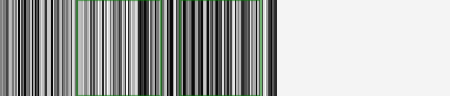

predicted


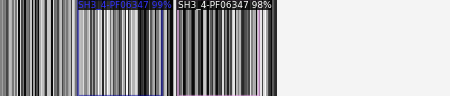

 43%|████▎     | 187/435 [00:18<00:23, 10.36it/s]

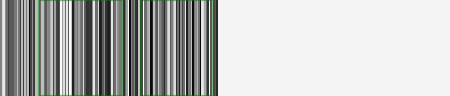

predicted


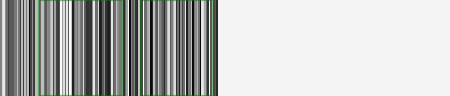

predicted


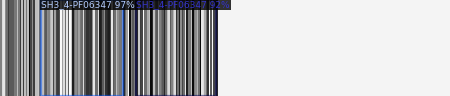

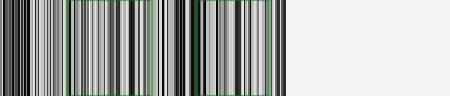

predicted


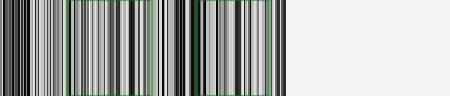

predicted


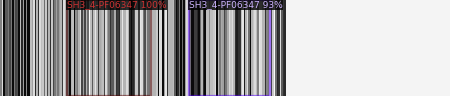

 43%|████▎     | 189/435 [00:18<00:23, 10.49it/s]

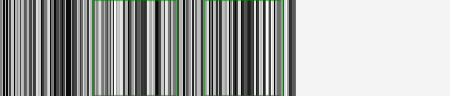

predicted


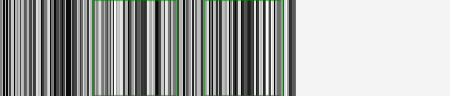

predicted


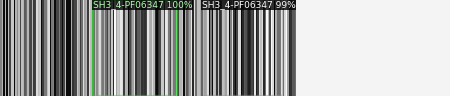

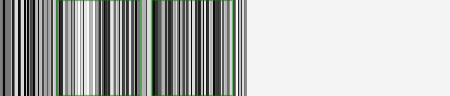

predicted


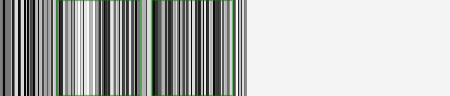

predicted


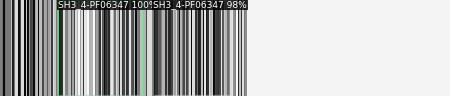

 44%|████▍     | 191/435 [00:18<00:23, 10.59it/s]

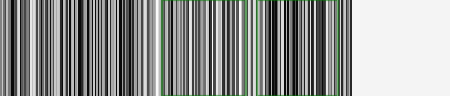

predicted


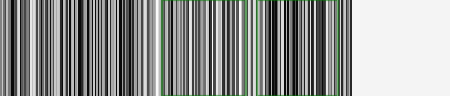

predicted


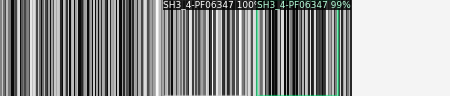

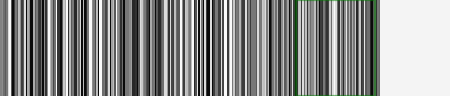

predicted


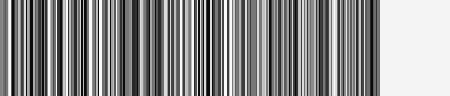

 44%|████▍     | 193/435 [00:18<00:22, 11.00it/s]

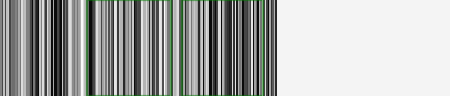

predicted


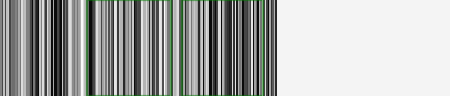

predicted


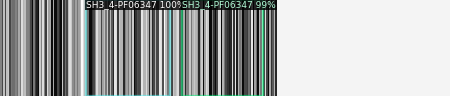

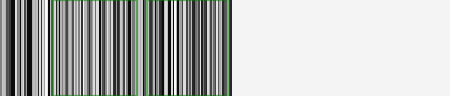

predicted


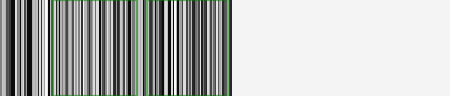

predicted


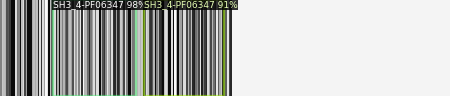

 45%|████▍     | 195/435 [00:18<00:22, 10.90it/s]

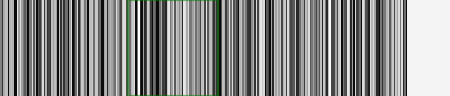

predicted


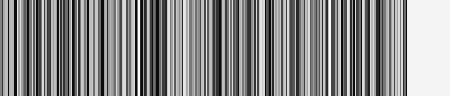

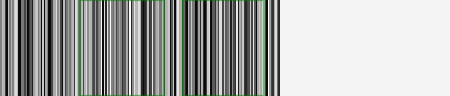

predicted


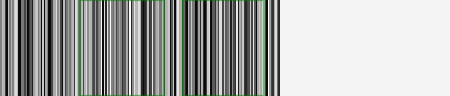

predicted


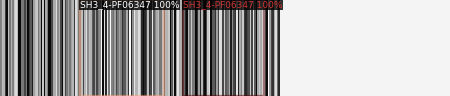

 45%|████▌     | 197/435 [00:18<00:21, 11.18it/s]

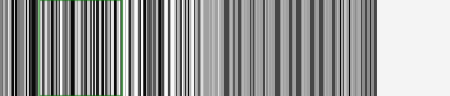

predicted


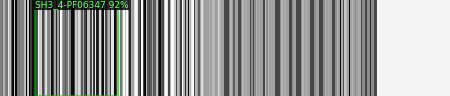

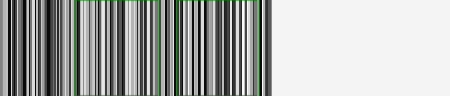

predicted


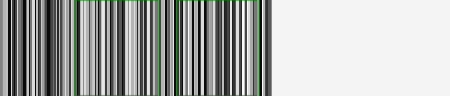

predicted


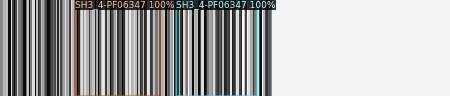

 46%|████▌     | 199/435 [00:19<00:20, 11.27it/s]

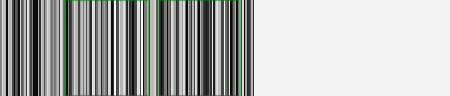

predicted


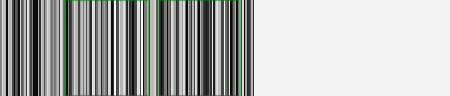

predicted


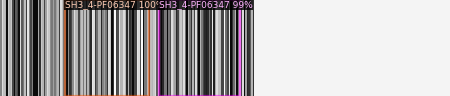

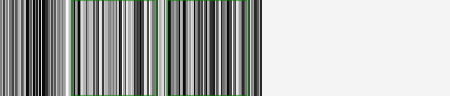

predicted


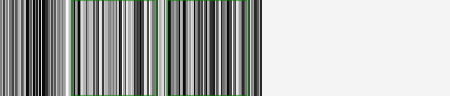

predicted


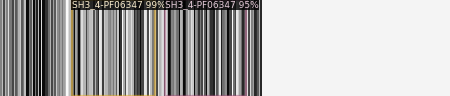

 46%|████▌     | 201/435 [00:19<00:20, 11.16it/s]

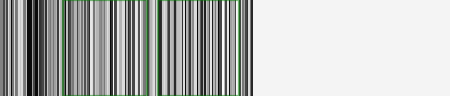

predicted


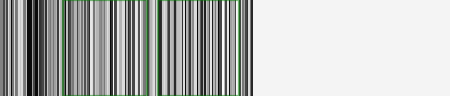

predicted


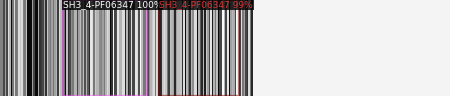

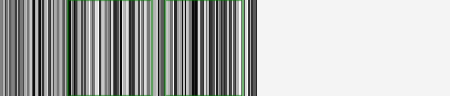

predicted


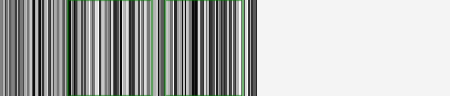

predicted


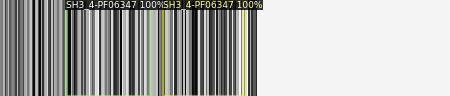

 47%|████▋     | 203/435 [00:19<00:25,  8.98it/s]

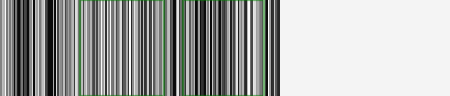

predicted


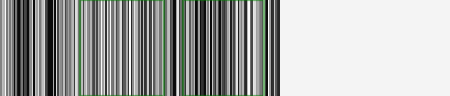

predicted


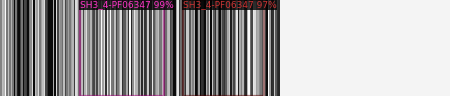

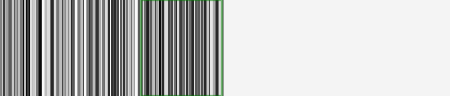

predicted


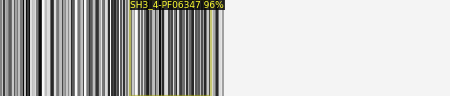

 47%|████▋     | 205/435 [00:19<00:23,  9.61it/s]

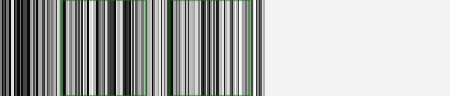

predicted


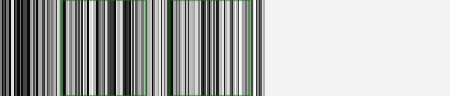

predicted


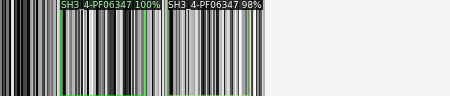

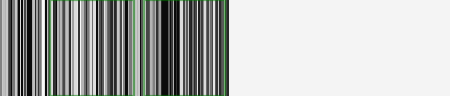

predicted


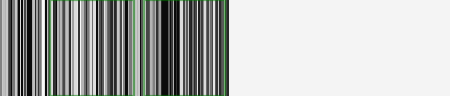

predicted


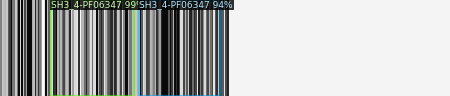

 48%|████▊     | 207/435 [00:19<00:22,  9.94it/s]

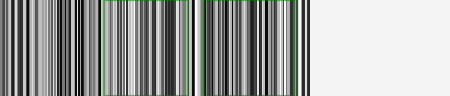

predicted


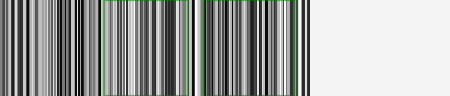

predicted


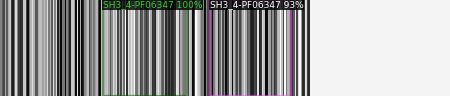

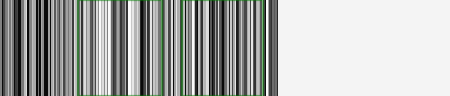

predicted


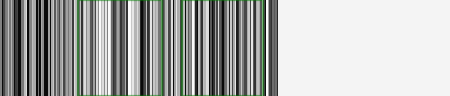

predicted


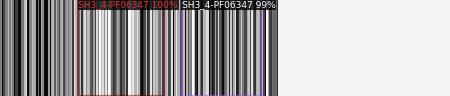

 48%|████▊     | 209/435 [00:20<00:22, 10.18it/s]

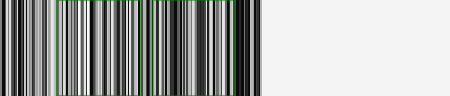

predicted


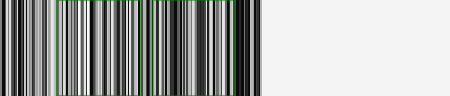

predicted


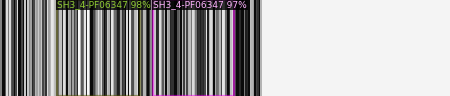

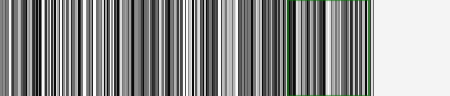

predicted


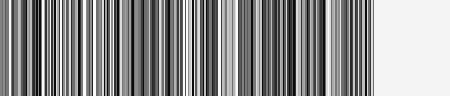

 49%|████▊     | 211/435 [00:20<00:21, 10.66it/s]

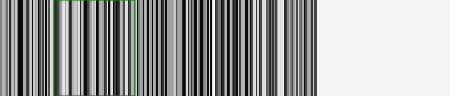

predicted


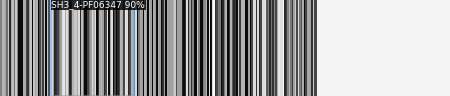

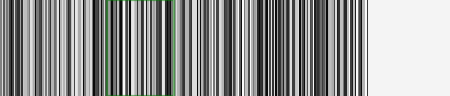

predicted


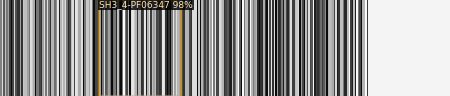

 49%|████▉     | 213/435 [00:20<00:19, 11.13it/s]

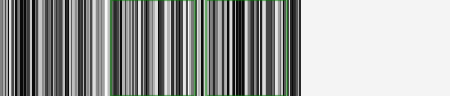

predicted


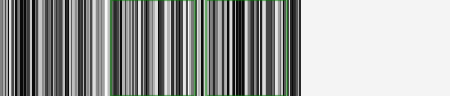

predicted


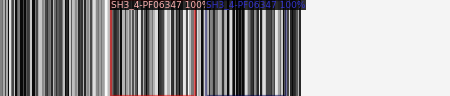

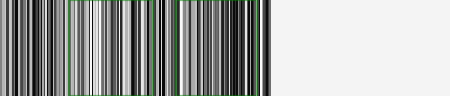

predicted


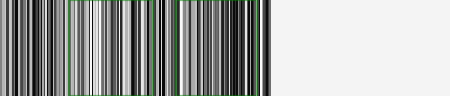

predicted


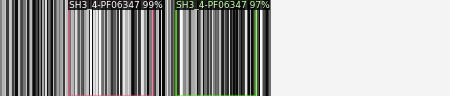

 49%|████▉     | 215/435 [00:20<00:19, 11.02it/s]

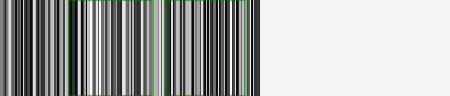

predicted


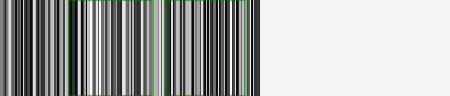

predicted


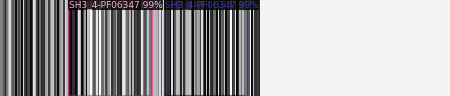

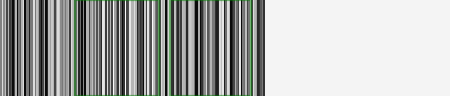

predicted


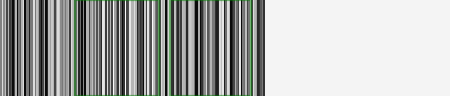

predicted


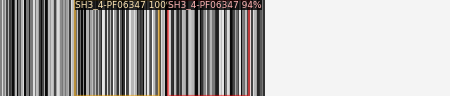

 50%|████▉     | 217/435 [00:20<00:20, 10.86it/s]

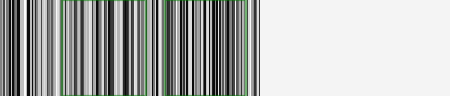

predicted


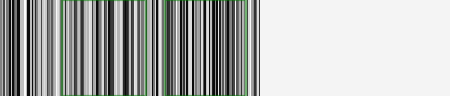

predicted


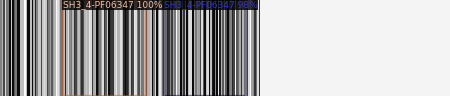

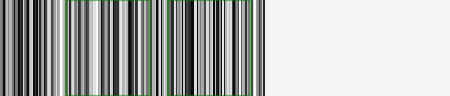

predicted


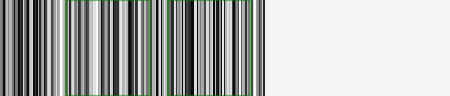

predicted


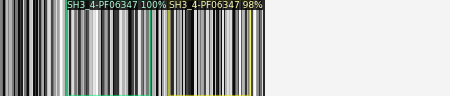

 50%|█████     | 219/435 [00:21<00:20, 10.74it/s]

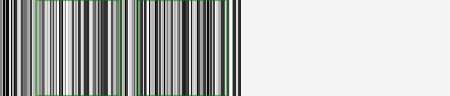

predicted


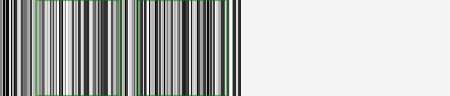

predicted


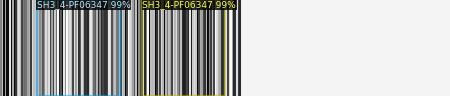

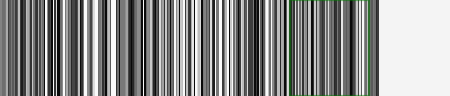

predicted


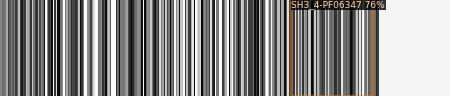

 51%|█████     | 221/435 [00:21<00:19, 10.95it/s]

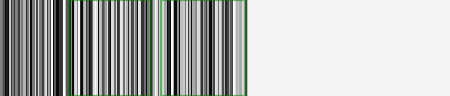

predicted


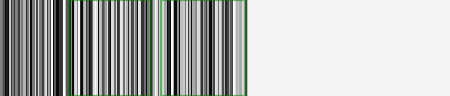

predicted


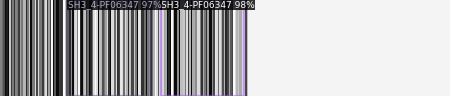

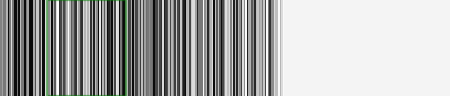

predicted


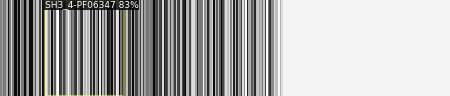

 51%|█████▏    | 223/435 [00:21<00:19, 11.12it/s]

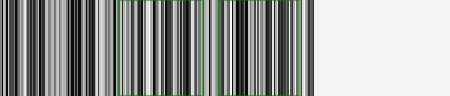

predicted


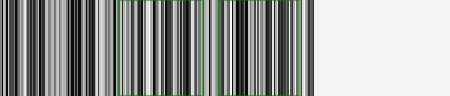

predicted


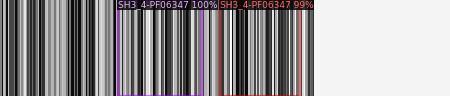

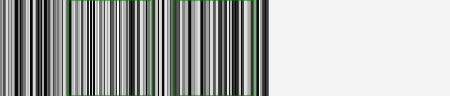

predicted


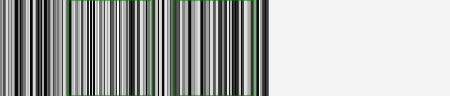

predicted


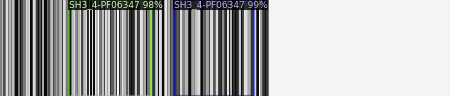

 52%|█████▏    | 225/435 [00:21<00:19, 11.04it/s]

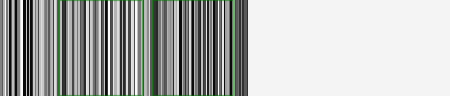

predicted


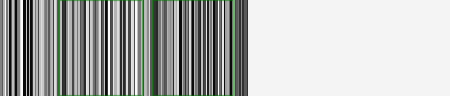

predicted


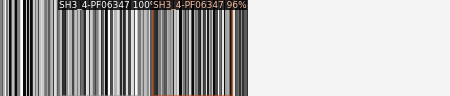

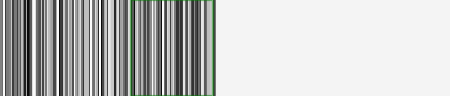

predicted


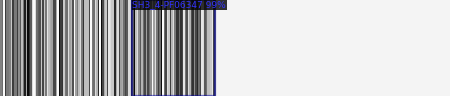

 52%|█████▏    | 227/435 [00:21<00:23,  9.02it/s]

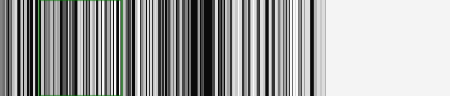

predicted


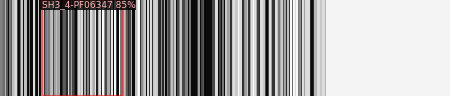

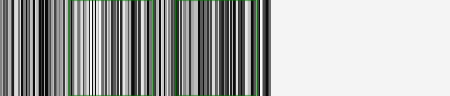

predicted


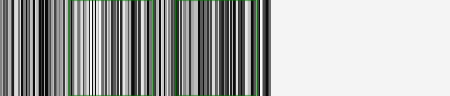

predicted


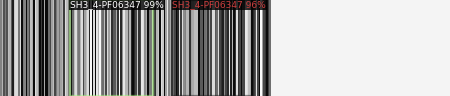

 53%|█████▎    | 229/435 [00:22<00:21,  9.65it/s]

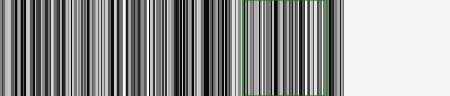

predicted


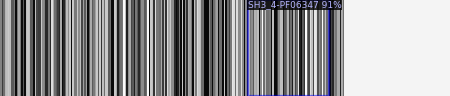

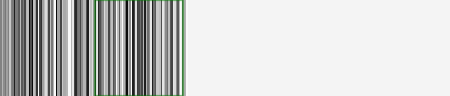

predicted


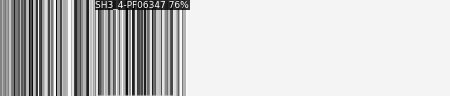

 53%|█████▎    | 231/435 [00:22<00:19, 10.35it/s]

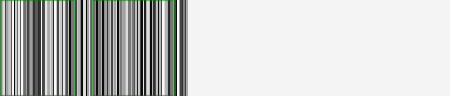

predicted


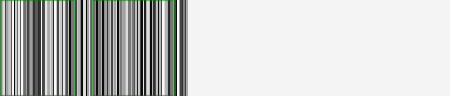

predicted


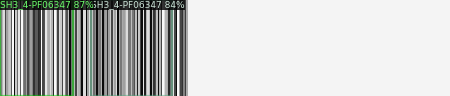

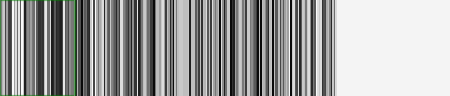

predicted


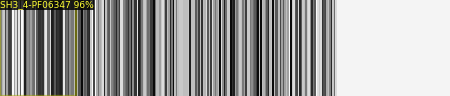

 54%|█████▎    | 233/435 [00:22<00:18, 10.68it/s]

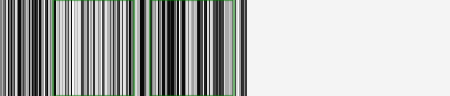

predicted


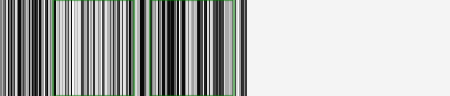

predicted


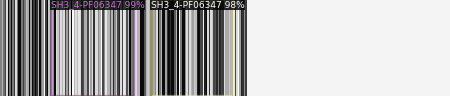

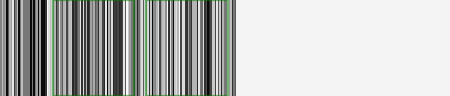

predicted


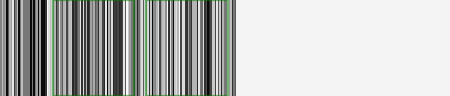

predicted


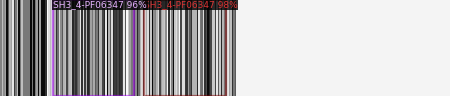

 54%|█████▍    | 235/435 [00:22<00:18, 10.73it/s]

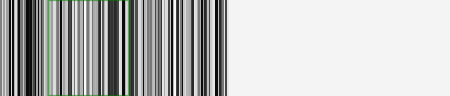

predicted


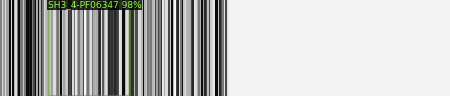

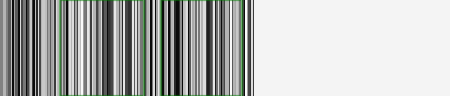

predicted


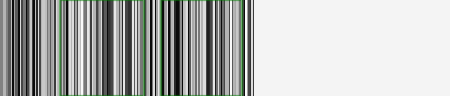

predicted


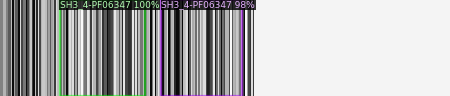

 54%|█████▍    | 237/435 [00:22<00:18, 10.88it/s]

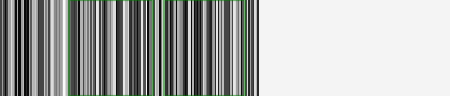

predicted


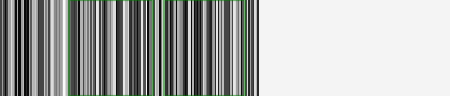

predicted


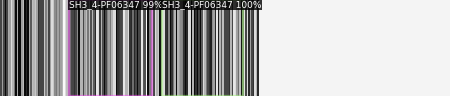

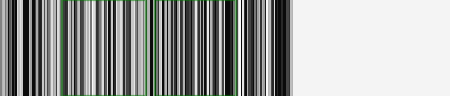

predicted


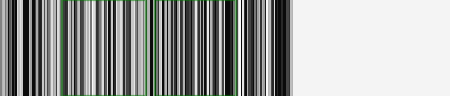

predicted


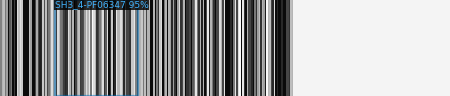

 55%|█████▍    | 239/435 [00:22<00:18, 10.88it/s]

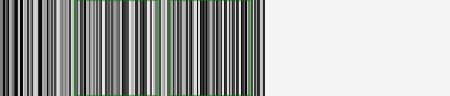

predicted


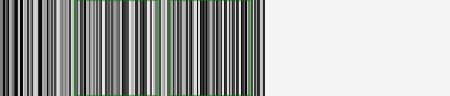

predicted


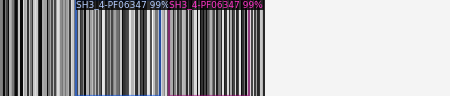

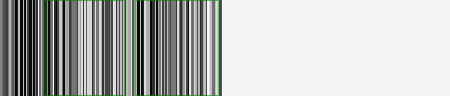

predicted


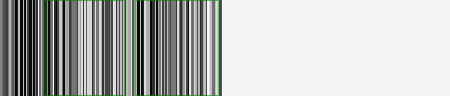

predicted


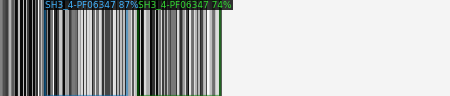

 55%|█████▌    | 241/435 [00:23<00:17, 10.80it/s]

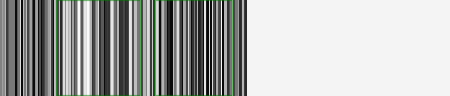

predicted


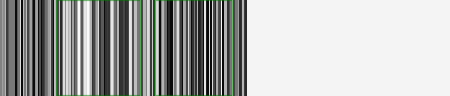

predicted


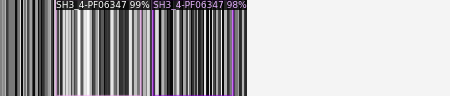

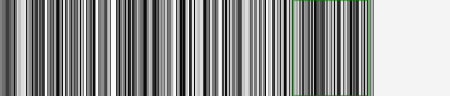

predicted


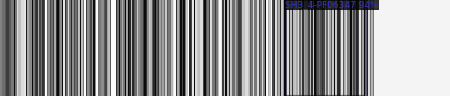

 56%|█████▌    | 243/435 [00:23<00:17, 10.94it/s]

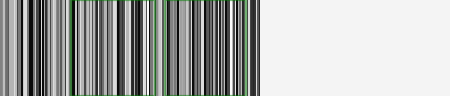

predicted


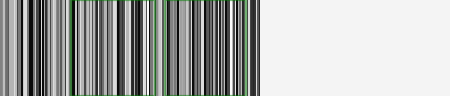

predicted


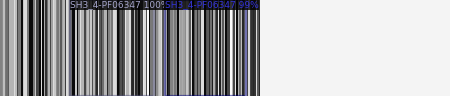

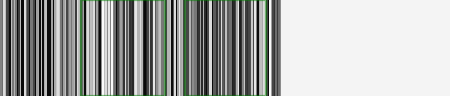

predicted


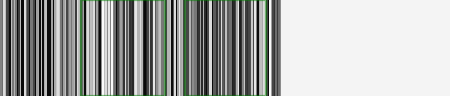

predicted


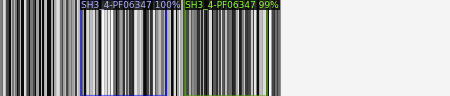

 56%|█████▋    | 245/435 [00:23<00:17, 10.87it/s]

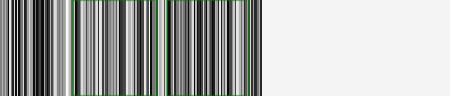

predicted


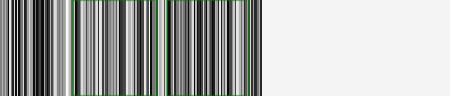

predicted


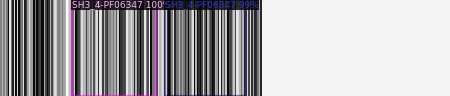

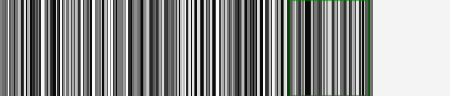

predicted


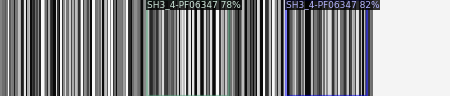

 57%|█████▋    | 247/435 [00:23<00:17, 11.02it/s]

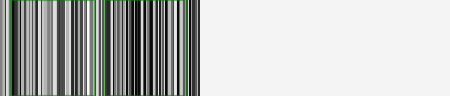

predicted


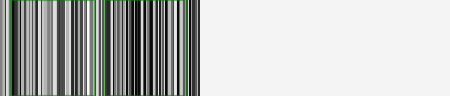

predicted


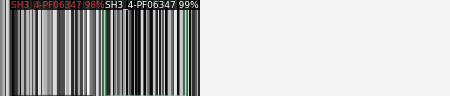

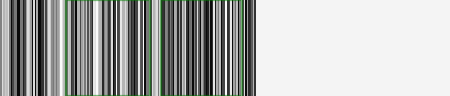

predicted


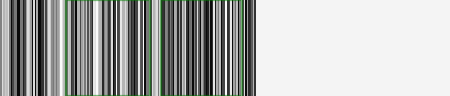

predicted


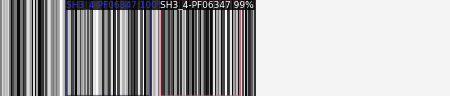

 57%|█████▋    | 249/435 [00:23<00:16, 10.97it/s]

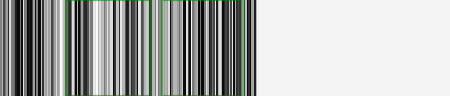

predicted


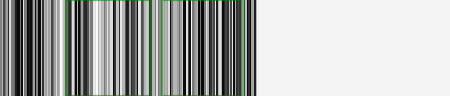

predicted


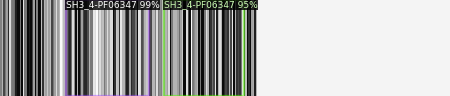

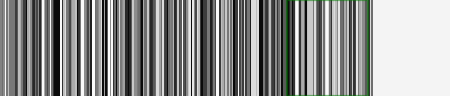

predicted


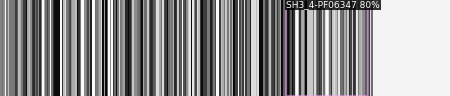

 58%|█████▊    | 251/435 [00:24<00:20,  9.02it/s]

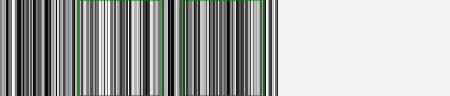

predicted


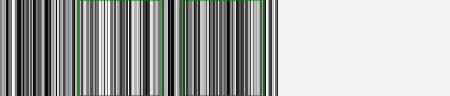

predicted


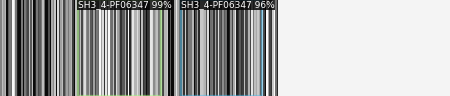

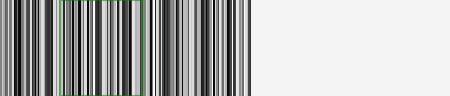

predicted


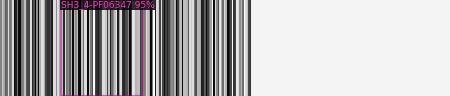

 58%|█████▊    | 253/435 [00:24<00:18,  9.67it/s]

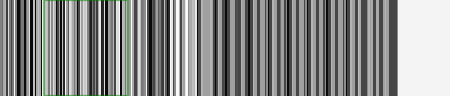

predicted


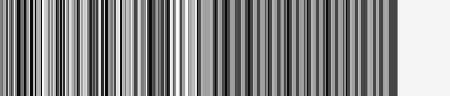

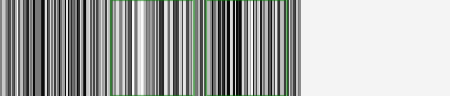

predicted


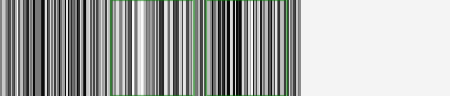

predicted


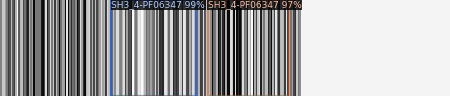

 59%|█████▊    | 255/435 [00:24<00:17, 10.27it/s]

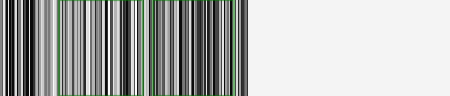

predicted


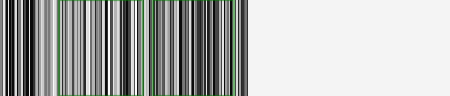

predicted


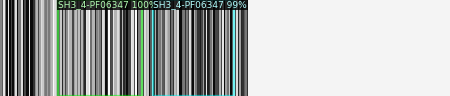

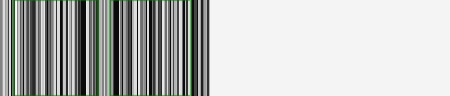

predicted


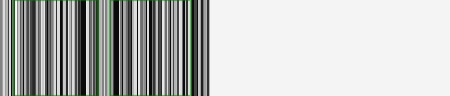

predicted


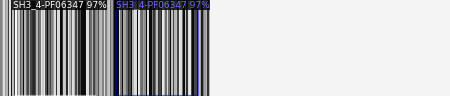

 59%|█████▉    | 257/435 [00:24<00:17, 10.43it/s]

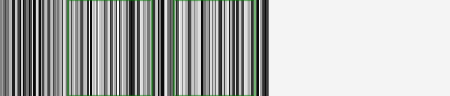

predicted


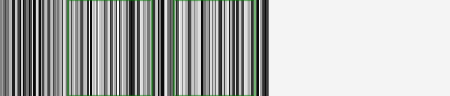

predicted


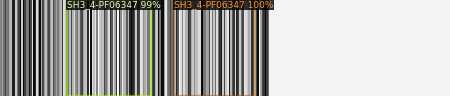

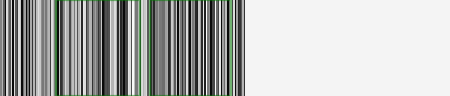

predicted


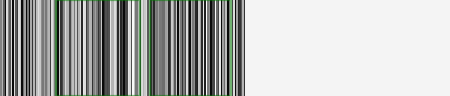

predicted


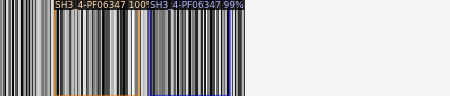

 60%|█████▉    | 259/435 [00:24<00:16, 10.54it/s]

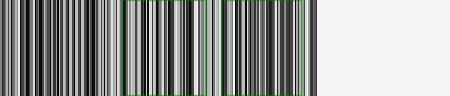

predicted


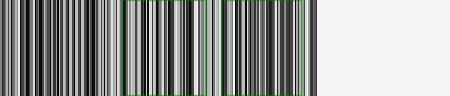

predicted


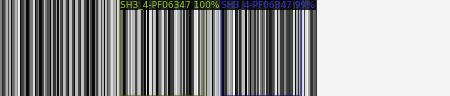

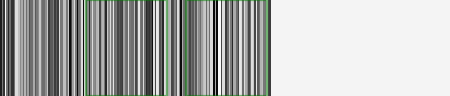

predicted


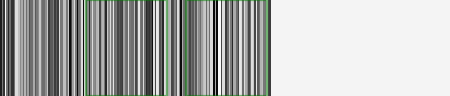

predicted


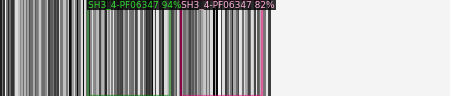

 60%|██████    | 261/435 [00:25<00:16, 10.58it/s]

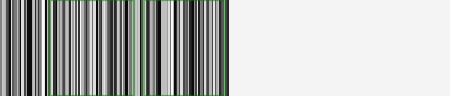

predicted


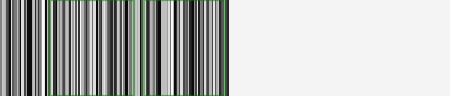

predicted


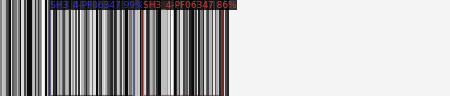

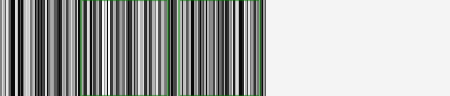

predicted


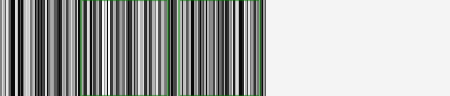

predicted


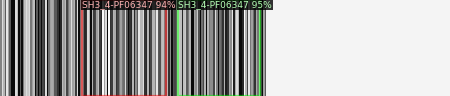

 60%|██████    | 263/435 [00:25<00:16, 10.62it/s]

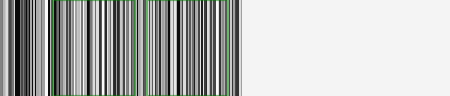

predicted


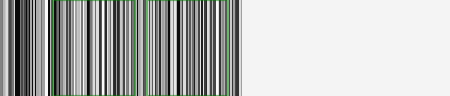

predicted


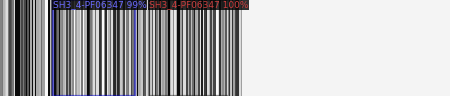

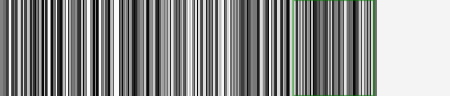

predicted


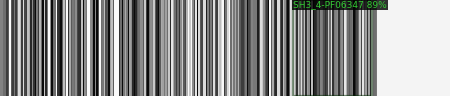

 61%|██████    | 265/435 [00:25<00:15, 10.86it/s]

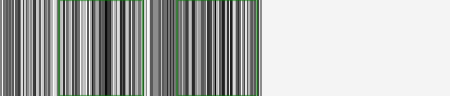

predicted


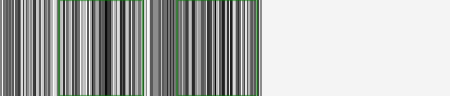

predicted


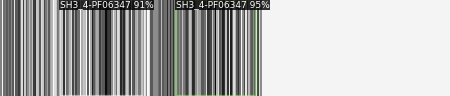

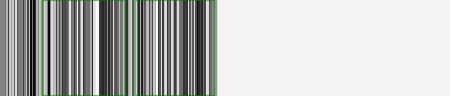

predicted


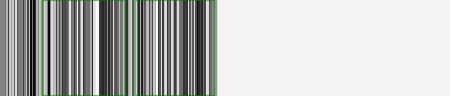

predicted


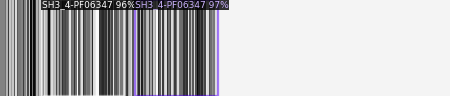

 61%|██████▏   | 267/435 [00:25<00:15, 10.75it/s]

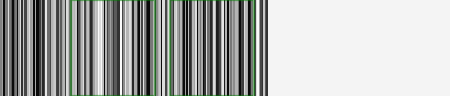

predicted


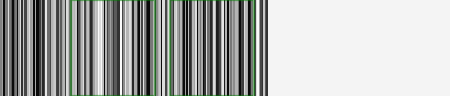

predicted


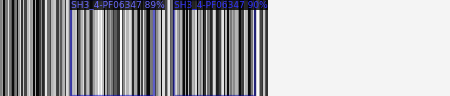

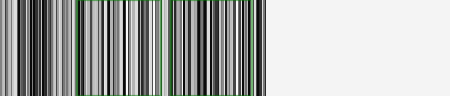

predicted


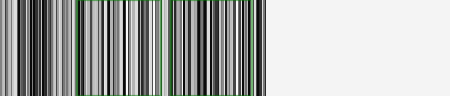

predicted


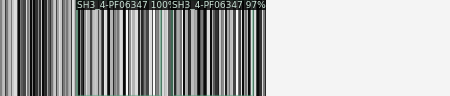

 62%|██████▏   | 269/435 [00:25<00:15, 10.65it/s]

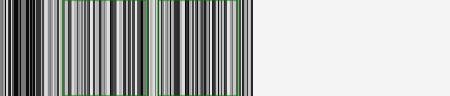

predicted


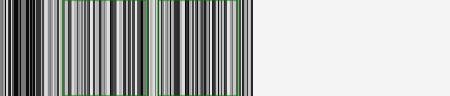

predicted


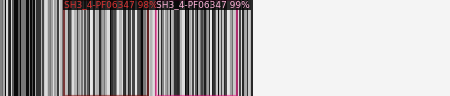

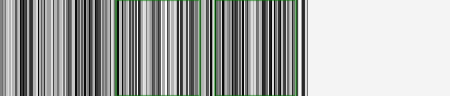

predicted


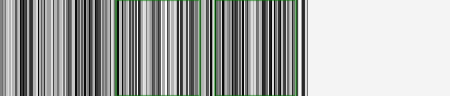

predicted


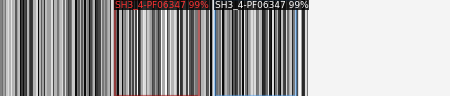

 62%|██████▏   | 271/435 [00:25<00:15, 10.62it/s]

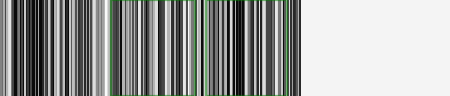

predicted


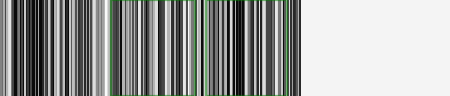

predicted


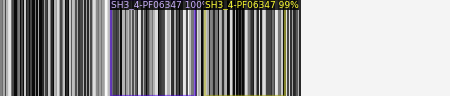

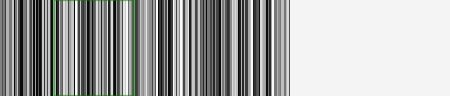

predicted


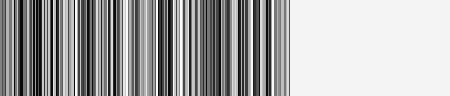

 63%|██████▎   | 273/435 [00:26<00:14, 10.93it/s]

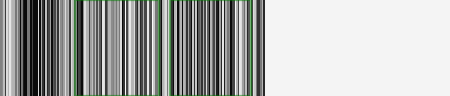

predicted


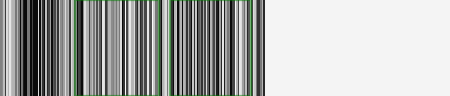

predicted


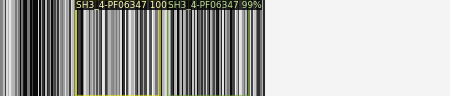

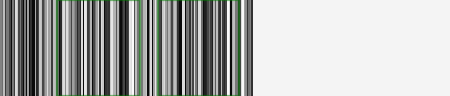

predicted


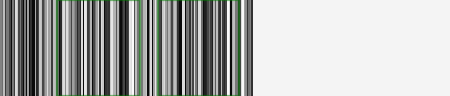

predicted


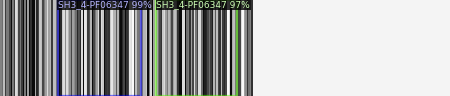

 63%|██████▎   | 275/435 [00:26<00:18,  8.75it/s]

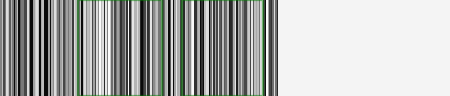

predicted


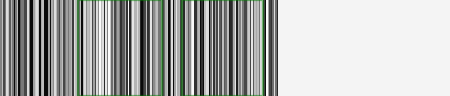

predicted


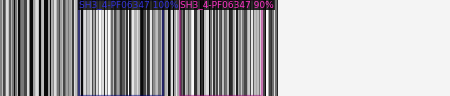

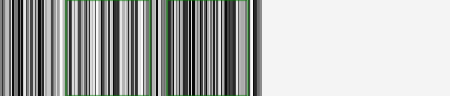

predicted


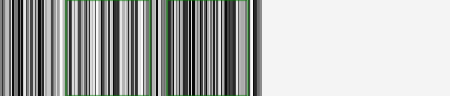

predicted


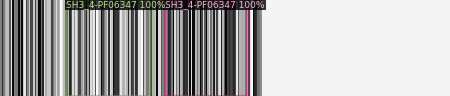

 64%|██████▎   | 277/435 [00:26<00:17,  9.23it/s]

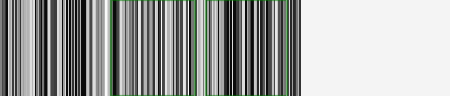

predicted


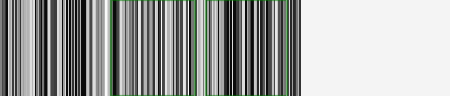

predicted


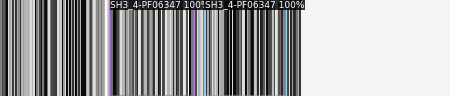

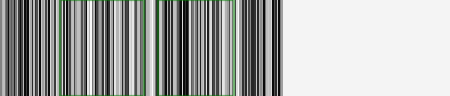

predicted


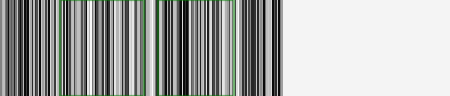

predicted


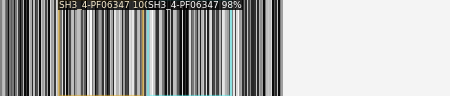

 64%|██████▍   | 279/435 [00:26<00:16,  9.61it/s]

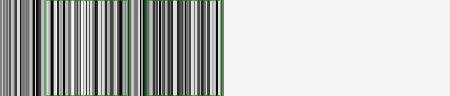

predicted


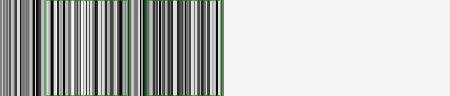

predicted


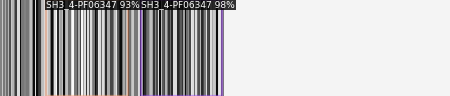

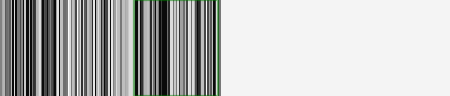

predicted


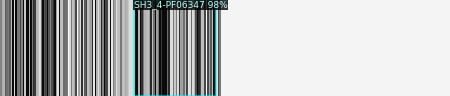

 65%|██████▍   | 281/435 [00:27<00:15, 10.15it/s]

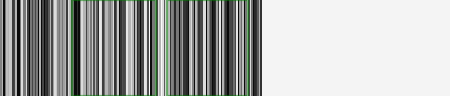

predicted


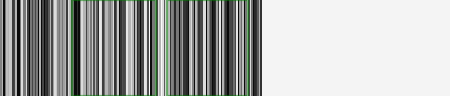

predicted


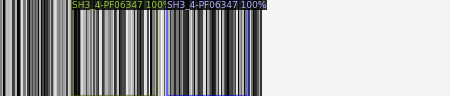

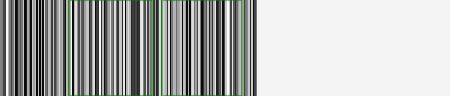

predicted


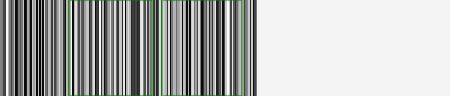

predicted


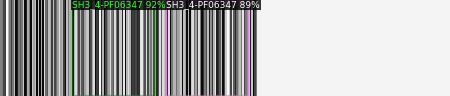

 65%|██████▌   | 283/435 [00:27<00:14, 10.36it/s]

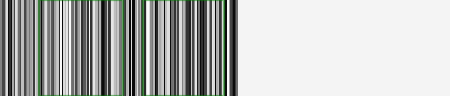

predicted


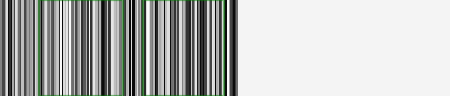

predicted


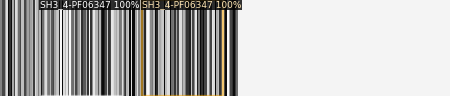

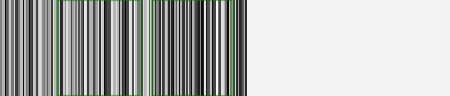

predicted


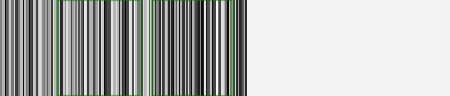

predicted


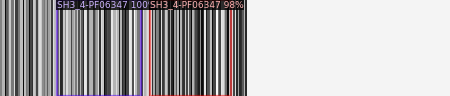

 66%|██████▌   | 285/435 [00:27<00:14, 10.45it/s]

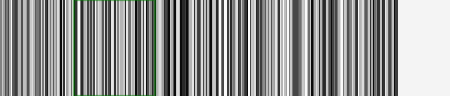

predicted


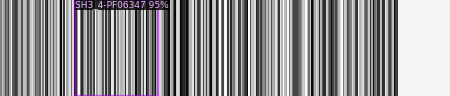

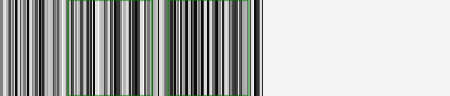

predicted


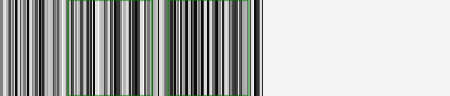

predicted


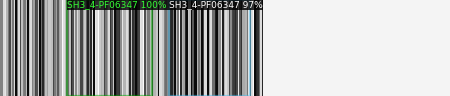

 66%|██████▌   | 287/435 [00:27<00:13, 10.77it/s]

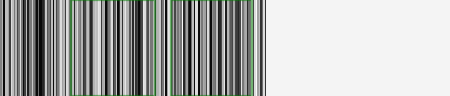

predicted


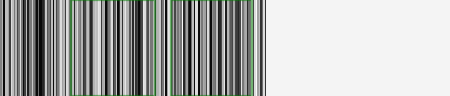

predicted


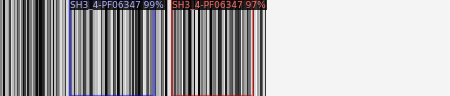

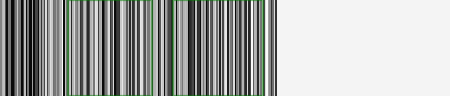

predicted


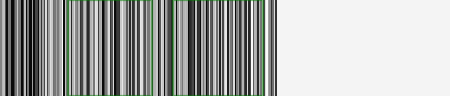

predicted


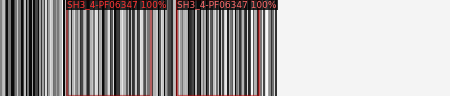

 66%|██████▋   | 289/435 [00:27<00:13, 10.79it/s]

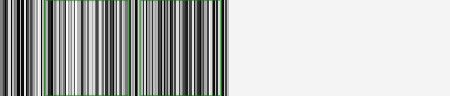

predicted


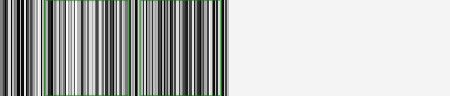

predicted


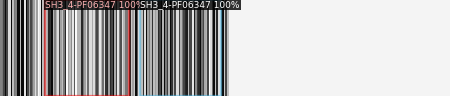

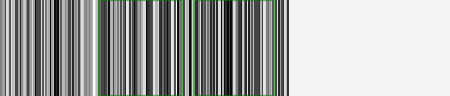

predicted


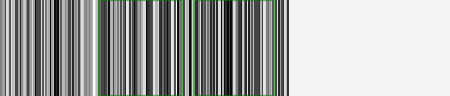

predicted


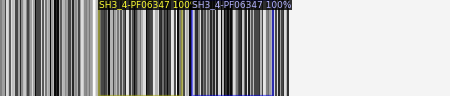

 67%|██████▋   | 291/435 [00:27<00:13, 10.87it/s]

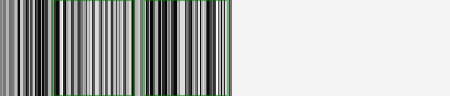

predicted


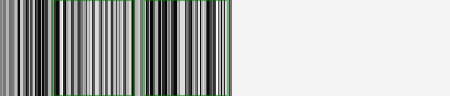

predicted


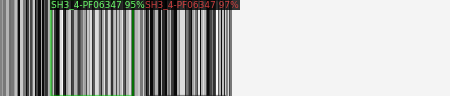

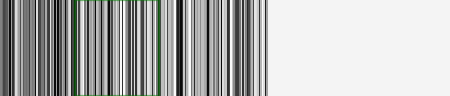

predicted


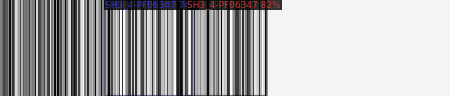

 67%|██████▋   | 293/435 [00:28<00:12, 11.02it/s]

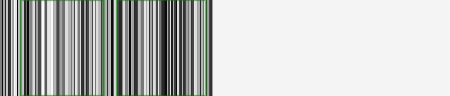

predicted


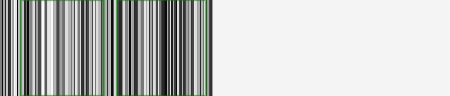

predicted


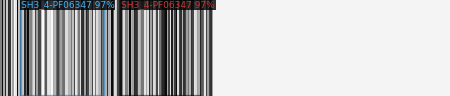

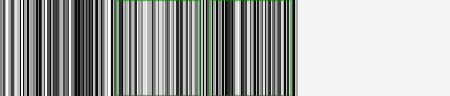

predicted


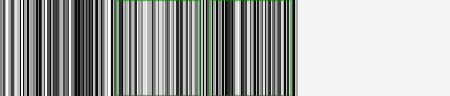

predicted


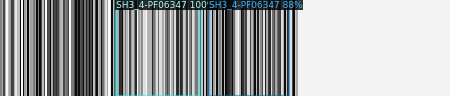

 68%|██████▊   | 295/435 [00:28<00:12, 10.98it/s]

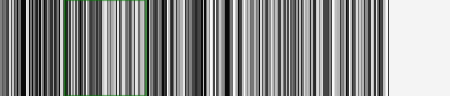

predicted


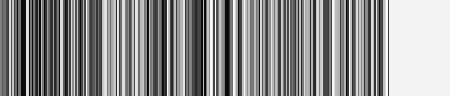

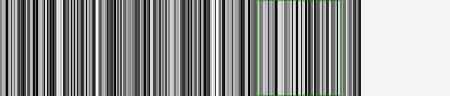

predicted


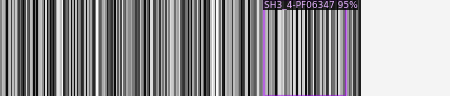

 68%|██████▊   | 297/435 [00:28<00:11, 11.55it/s]

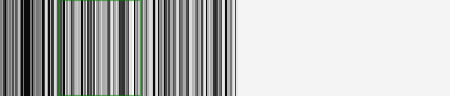

predicted


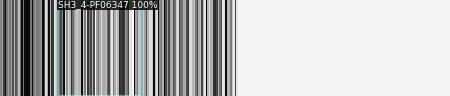

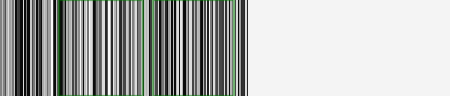

predicted


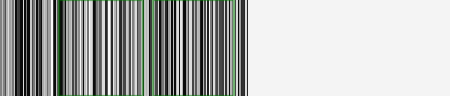

predicted


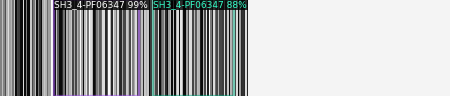

 69%|██████▊   | 299/435 [00:28<00:11, 11.58it/s]

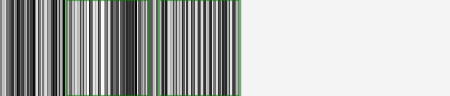

predicted


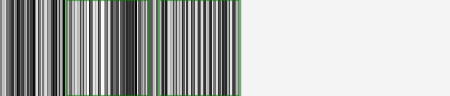

predicted


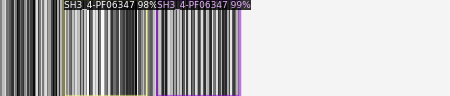

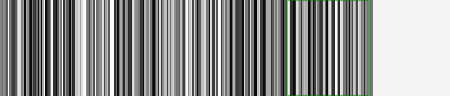

predicted


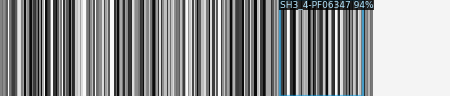

 69%|██████▉   | 301/435 [00:28<00:14,  9.31it/s]

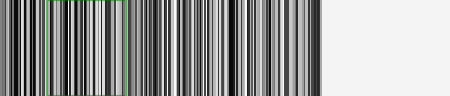

predicted


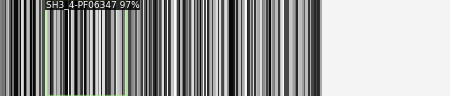

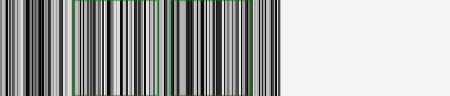

predicted


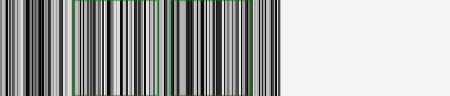

predicted


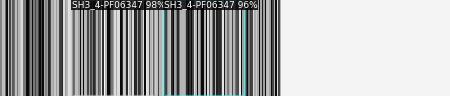

 70%|██████▉   | 303/435 [00:29<00:13,  9.91it/s]

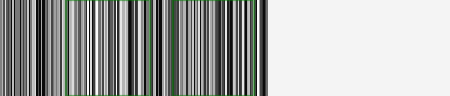

predicted


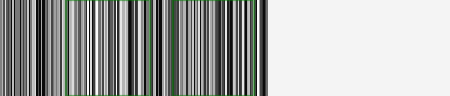

predicted


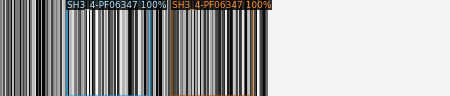

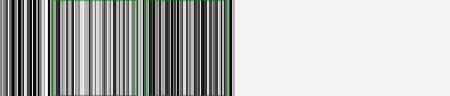

predicted


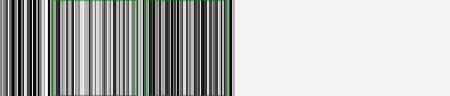

predicted


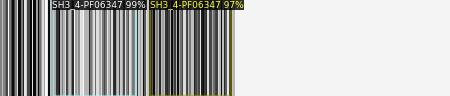

 70%|███████   | 305/435 [00:29<00:12, 10.17it/s]

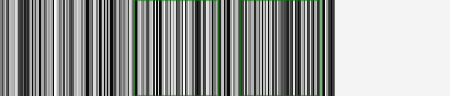

predicted


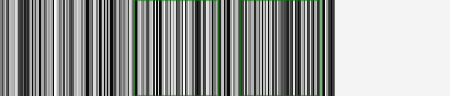

predicted


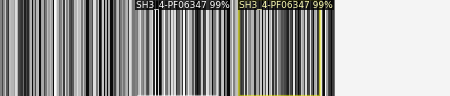

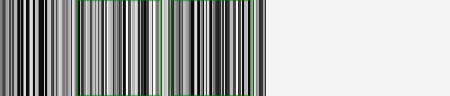

predicted


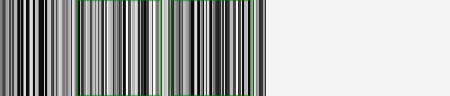

predicted


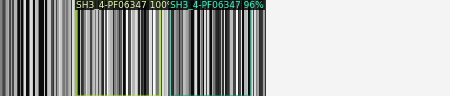

 71%|███████   | 307/435 [00:29<00:12, 10.39it/s]

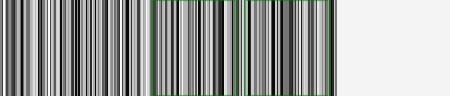

predicted


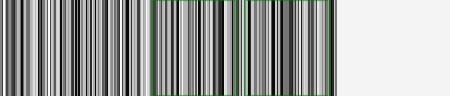

predicted


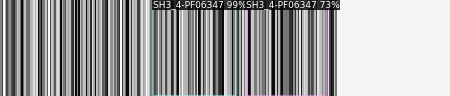

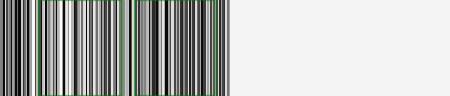

predicted


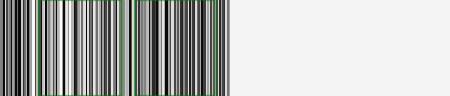

predicted


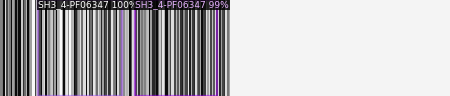

 71%|███████   | 309/435 [00:29<00:11, 10.54it/s]

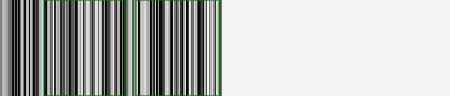

predicted


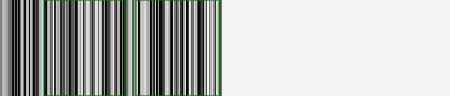

predicted


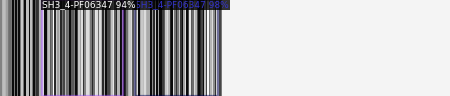

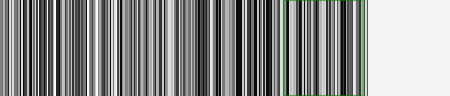

predicted


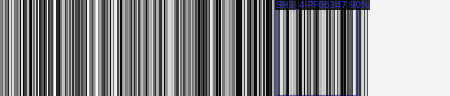

 71%|███████▏  | 311/435 [00:29<00:11, 10.80it/s]

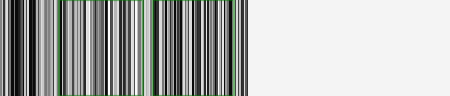

predicted


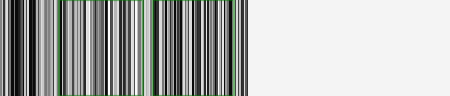

predicted


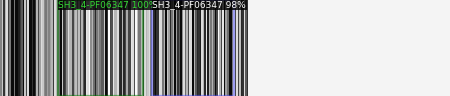

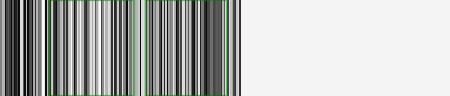

predicted


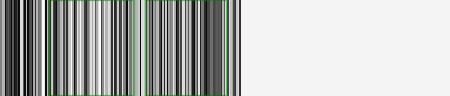

predicted


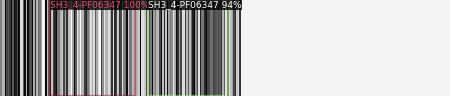

 72%|███████▏  | 313/435 [00:30<00:11, 10.82it/s]

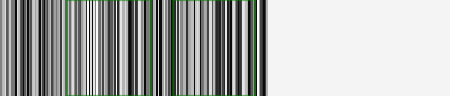

predicted


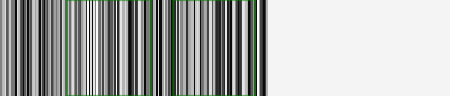

predicted


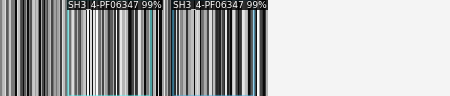

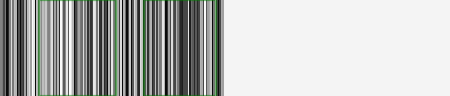

predicted


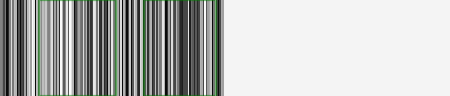

predicted


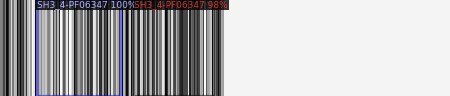

 72%|███████▏  | 315/435 [00:30<00:11, 10.84it/s]

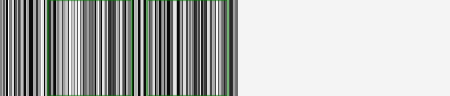

predicted


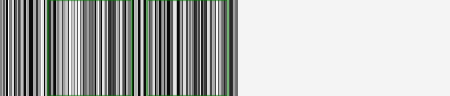

predicted


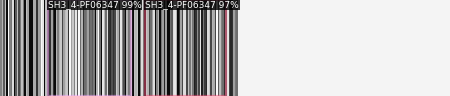

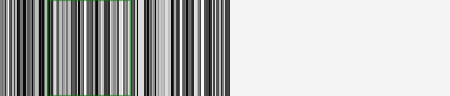

predicted


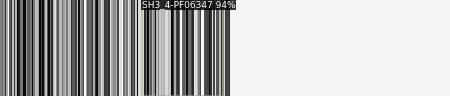

 73%|███████▎  | 317/435 [00:30<00:10, 11.08it/s]

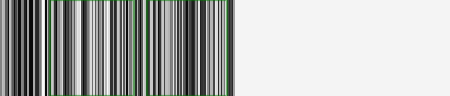

predicted


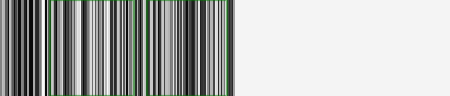

predicted


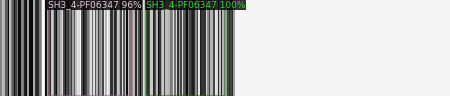

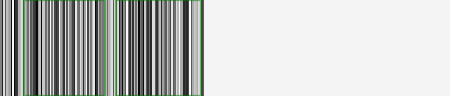

predicted


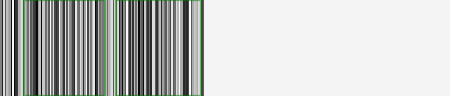

predicted


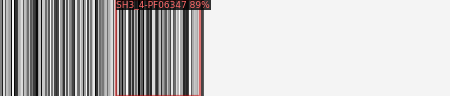

 73%|███████▎  | 319/435 [00:30<00:10, 11.12it/s]

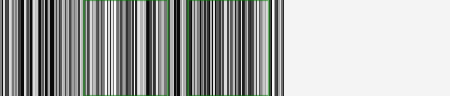

predicted


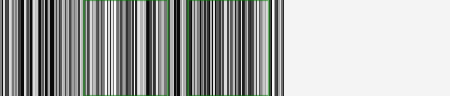

predicted


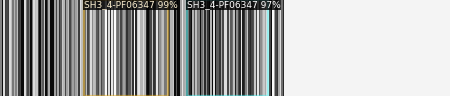

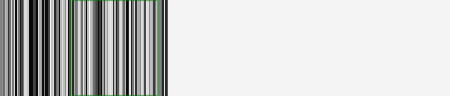

predicted


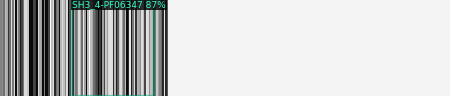

 74%|███████▍  | 321/435 [00:30<00:10, 11.25it/s]

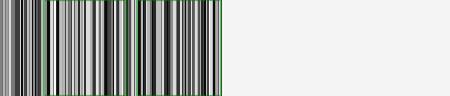

predicted


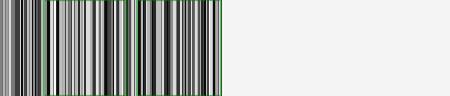

predicted


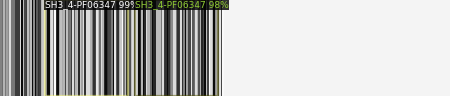

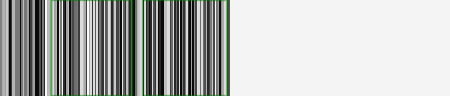

predicted


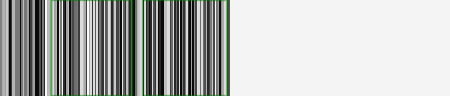

predicted


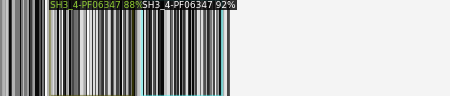

 74%|███████▍  | 323/435 [00:30<00:10, 11.12it/s]

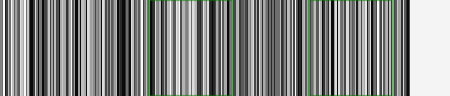

predicted


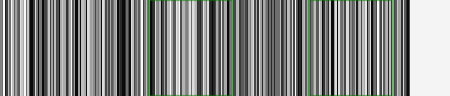

predicted


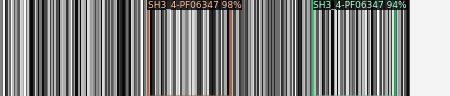

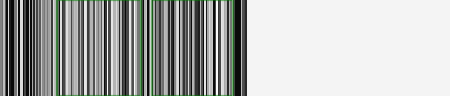

predicted


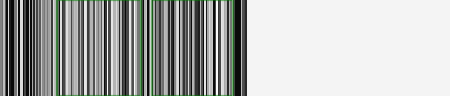

predicted


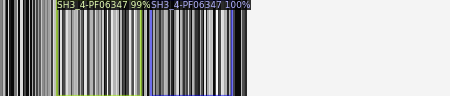

 75%|███████▍  | 325/435 [00:31<00:12,  8.97it/s]

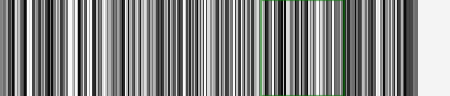

predicted


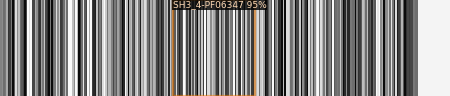

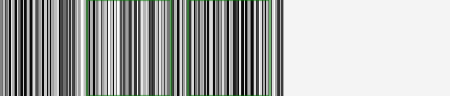

predicted


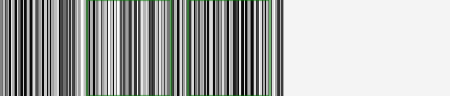

predicted


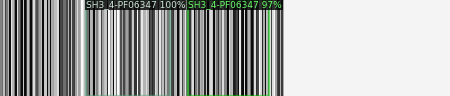

 75%|███████▌  | 327/435 [00:31<00:11,  9.64it/s]

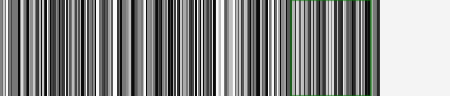

predicted


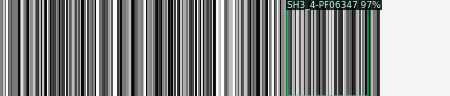

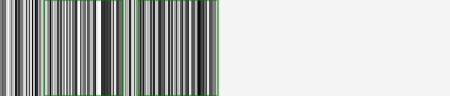

predicted


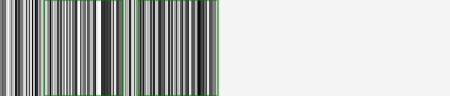

predicted


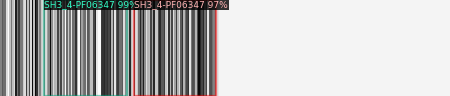

 76%|███████▌  | 329/435 [00:31<00:10, 10.19it/s]

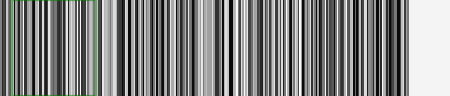

predicted


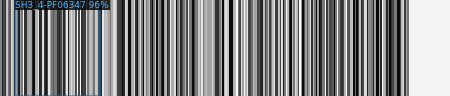

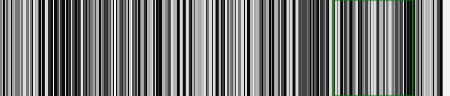

predicted


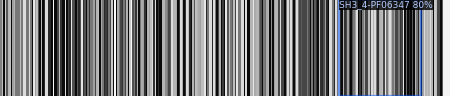

 76%|███████▌  | 331/435 [00:31<00:09, 10.76it/s]

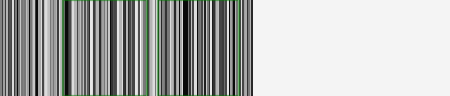

predicted


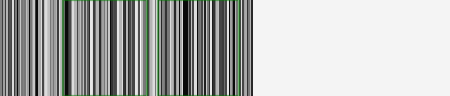

predicted


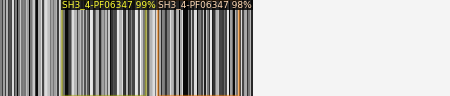

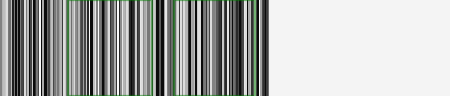

predicted


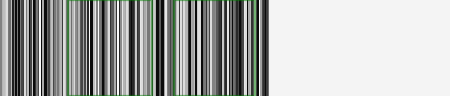

predicted


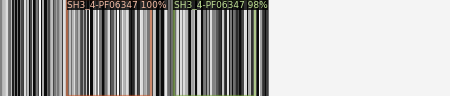

 77%|███████▋  | 333/435 [00:31<00:09, 10.81it/s]

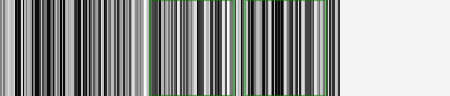

predicted


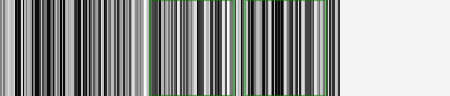

predicted


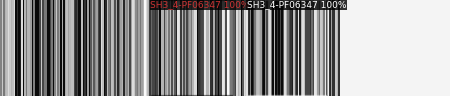

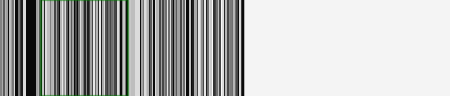

predicted


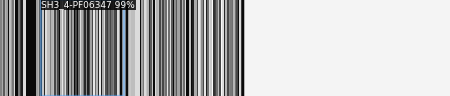

 77%|███████▋  | 335/435 [00:32<00:09, 11.06it/s]

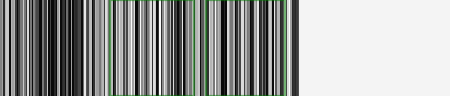

predicted


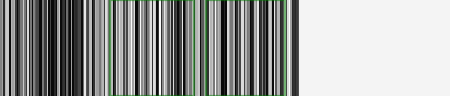

predicted


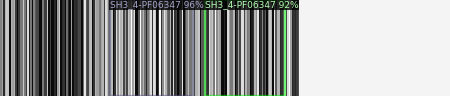

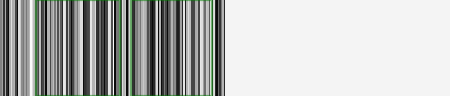

predicted


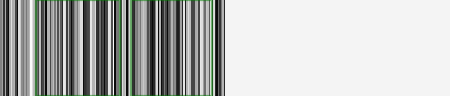

predicted


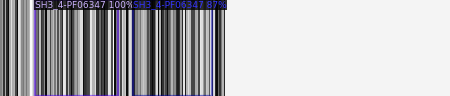

 77%|███████▋  | 337/435 [00:32<00:08, 11.02it/s]

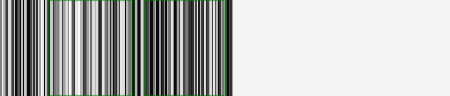

predicted


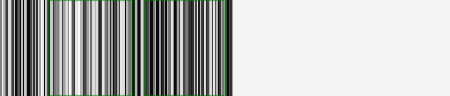

predicted


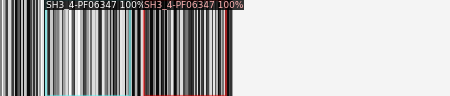

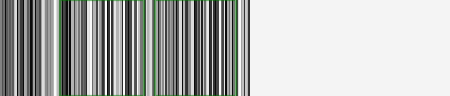

predicted


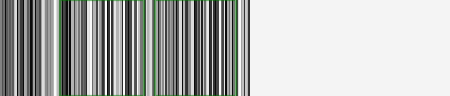

predicted


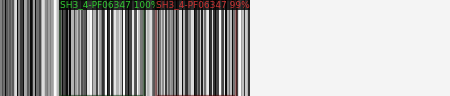

 78%|███████▊  | 339/435 [00:32<00:08, 11.02it/s]

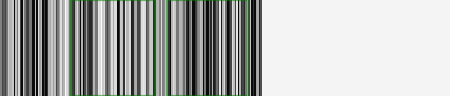

predicted


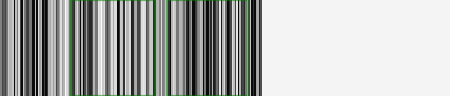

predicted


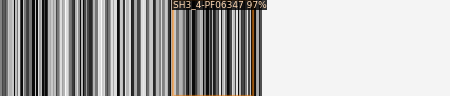

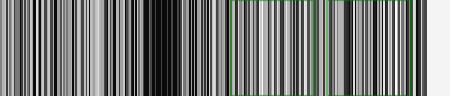

predicted


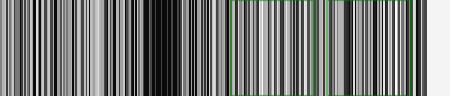

predicted


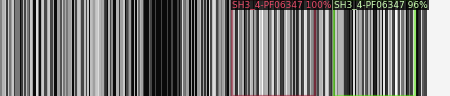

 78%|███████▊  | 341/435 [00:32<00:08, 11.06it/s]

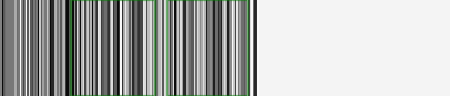

predicted


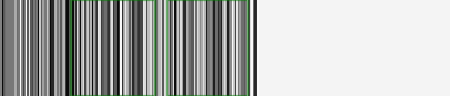

predicted


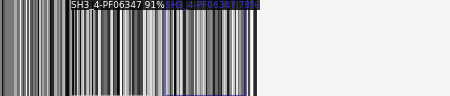

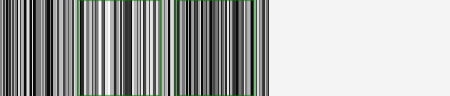

predicted


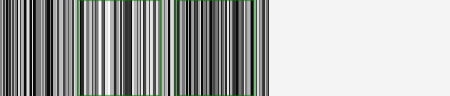

predicted


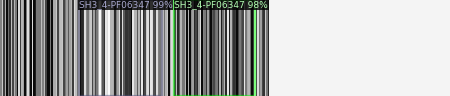

 79%|███████▉  | 343/435 [00:32<00:08, 10.95it/s]

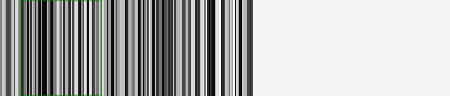

predicted


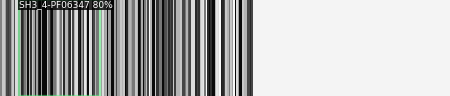

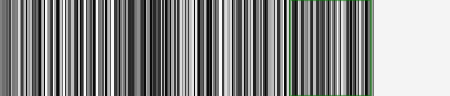

predicted


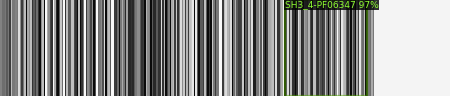

 79%|███████▉  | 345/435 [00:32<00:07, 11.34it/s]

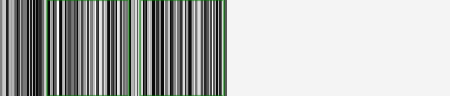

predicted


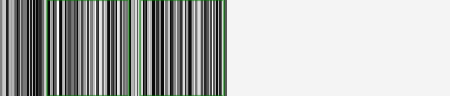

predicted


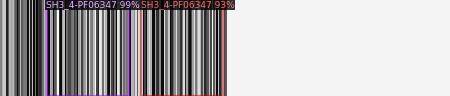

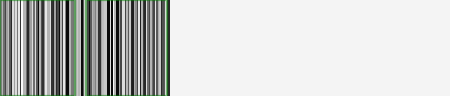

predicted


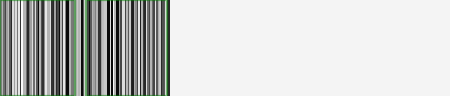

predicted


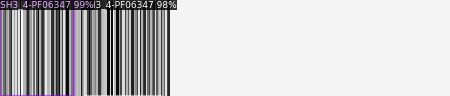

 80%|███████▉  | 347/435 [00:33<00:07, 11.10it/s]

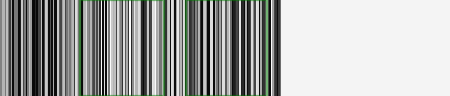

predicted


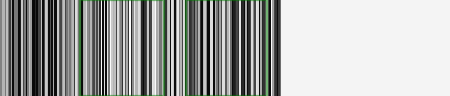

predicted


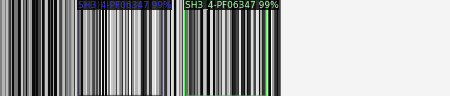

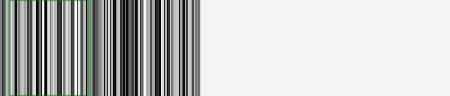

predicted


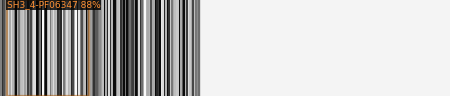

 80%|████████  | 349/435 [00:33<00:09,  9.05it/s]

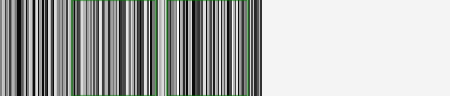

predicted


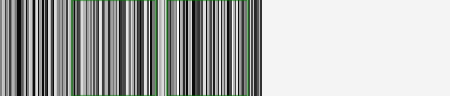

predicted


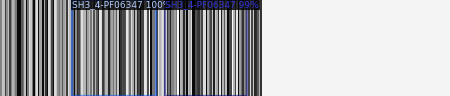

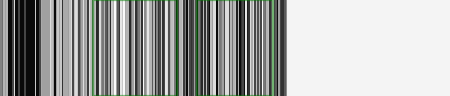

predicted


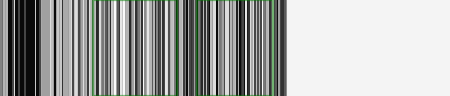

predicted


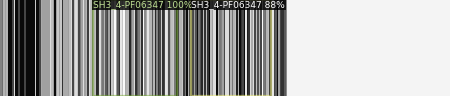

 81%|████████  | 351/435 [00:33<00:08,  9.55it/s]

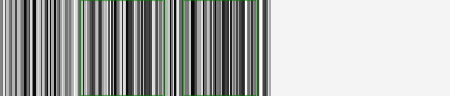

predicted


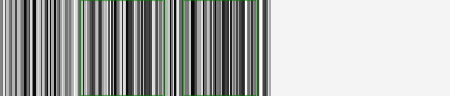

predicted


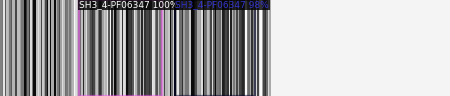

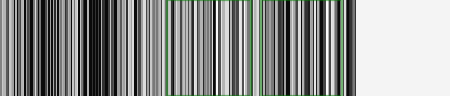

predicted


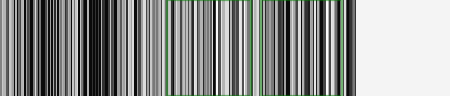

predicted


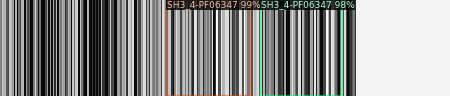

 81%|████████  | 353/435 [00:33<00:08,  9.95it/s]

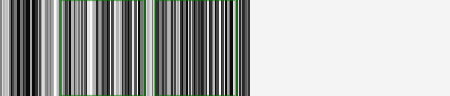

predicted


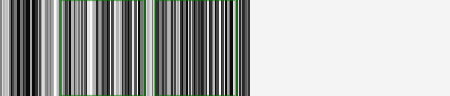

predicted


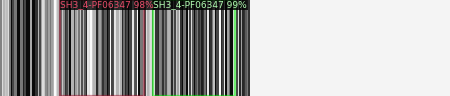

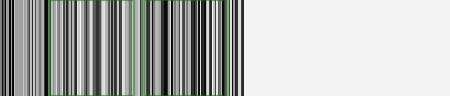

predicted


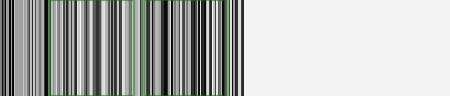

predicted


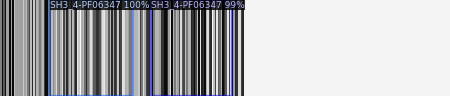

 82%|████████▏ | 355/435 [00:34<00:07, 10.22it/s]

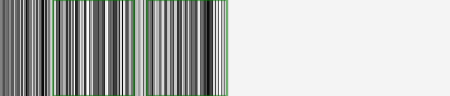

predicted


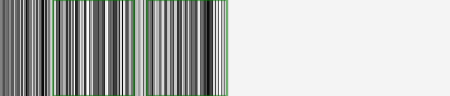

predicted


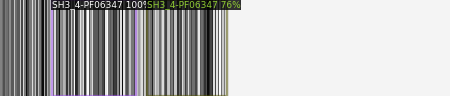

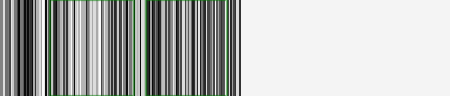

predicted


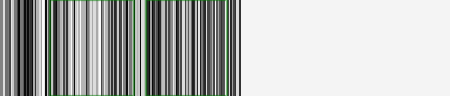

predicted


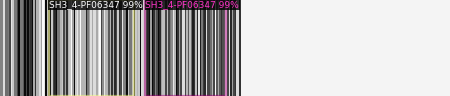

 82%|████████▏ | 357/435 [00:34<00:07, 10.47it/s]

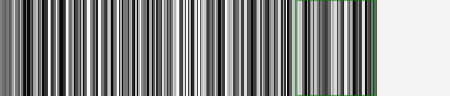

predicted


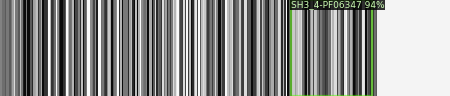

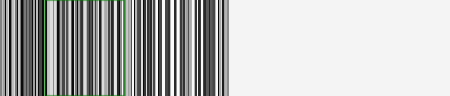

predicted


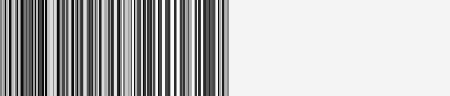

 83%|████████▎ | 359/435 [00:34<00:06, 11.14it/s]

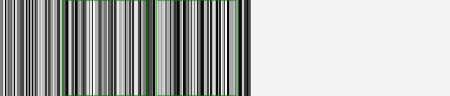

predicted


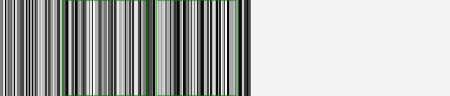

predicted


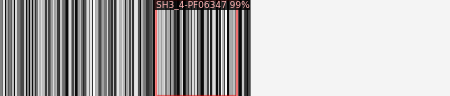

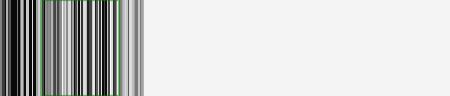

predicted


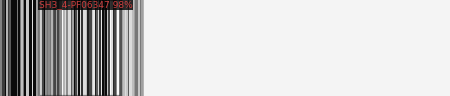

 83%|████████▎ | 361/435 [00:34<00:06, 11.38it/s]

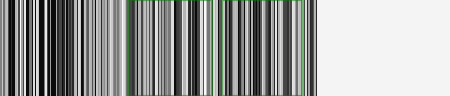

predicted


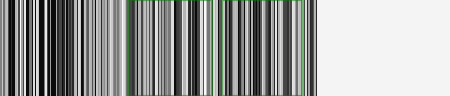

predicted


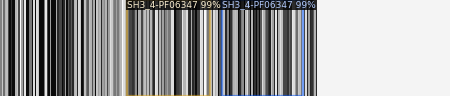

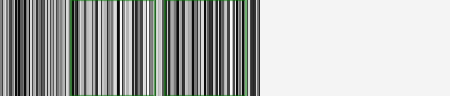

predicted


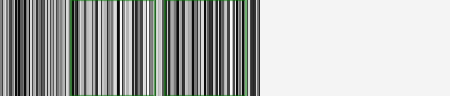

predicted


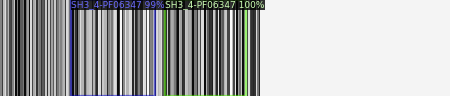

 83%|████████▎ | 363/435 [00:34<00:06, 11.17it/s]

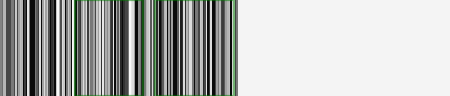

predicted


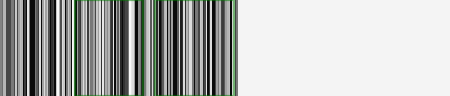

predicted


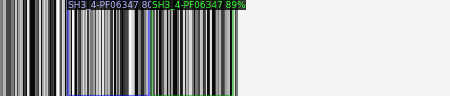

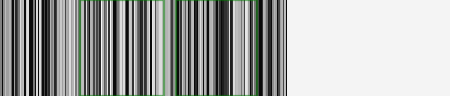

predicted


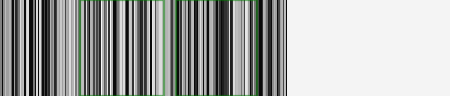

predicted


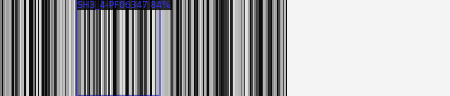

 84%|████████▍ | 365/435 [00:34<00:06, 11.14it/s]

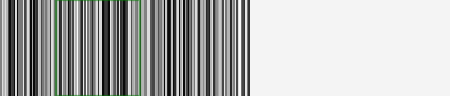

predicted


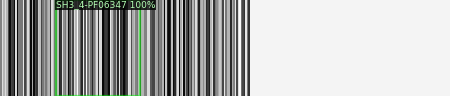

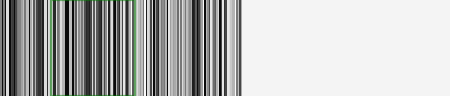

predicted


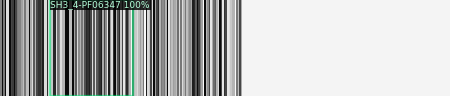

 84%|████████▍ | 367/435 [00:35<00:05, 11.46it/s]

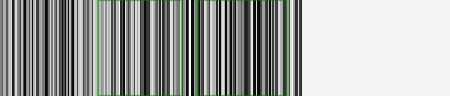

predicted


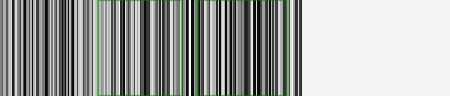

predicted


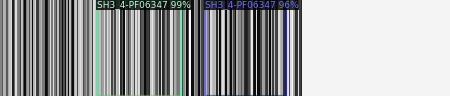

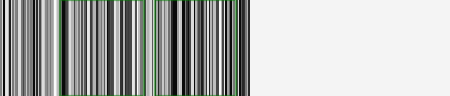

predicted


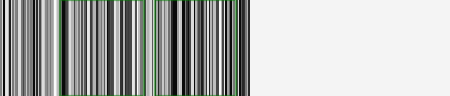

predicted


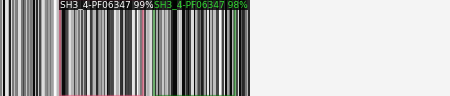

 85%|████████▍ | 369/435 [00:35<00:05, 11.25it/s]

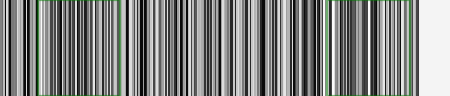

predicted


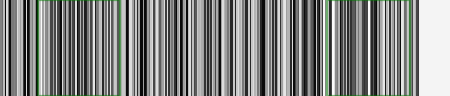

predicted


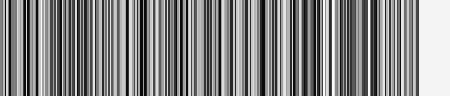

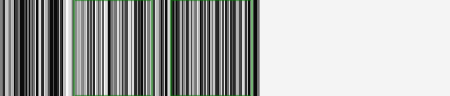

predicted


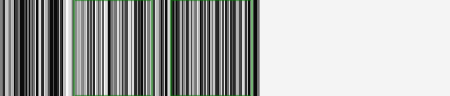

predicted


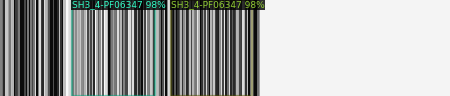

 85%|████████▌ | 371/435 [00:35<00:05, 11.34it/s]

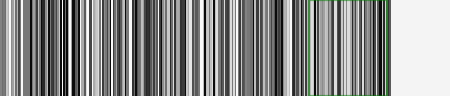

predicted


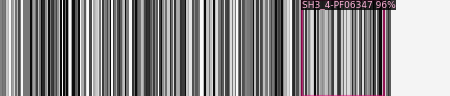

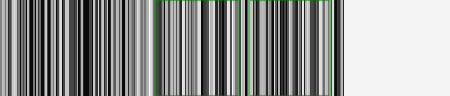

predicted


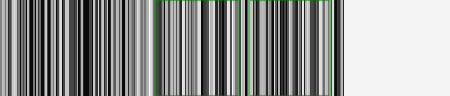

predicted


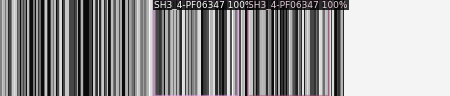

 86%|████████▌ | 373/435 [00:35<00:06,  9.12it/s]

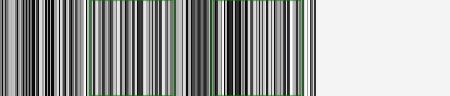

predicted


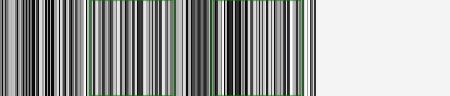

predicted


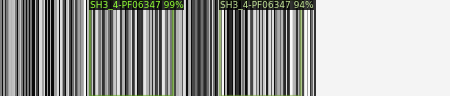

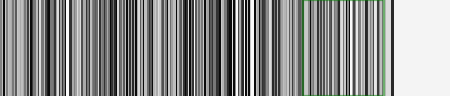

predicted


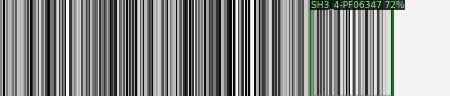

 86%|████████▌ | 375/435 [00:35<00:06,  9.70it/s]

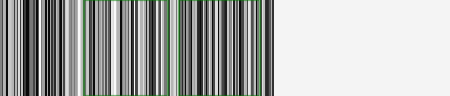

predicted


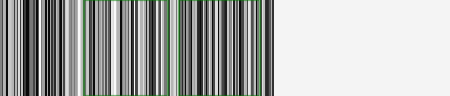

predicted


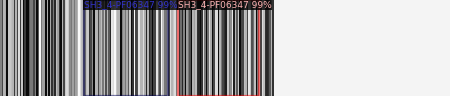

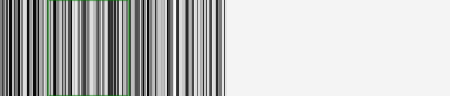

predicted


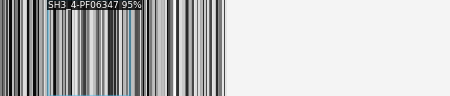

 87%|████████▋ | 377/435 [00:36<00:05, 10.11it/s]

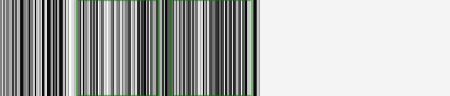

predicted


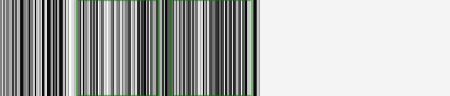

predicted


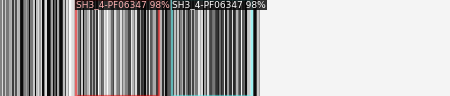

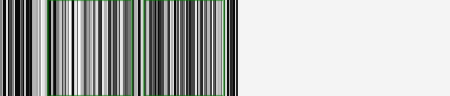

predicted


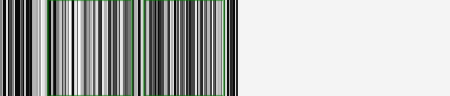

predicted


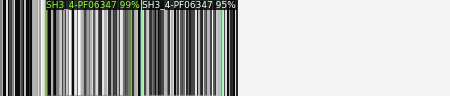

 87%|████████▋ | 379/435 [00:36<00:05, 10.26it/s]

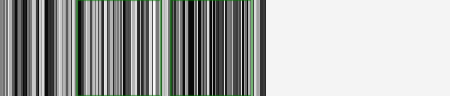

predicted


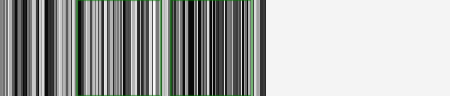

predicted


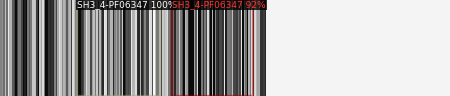

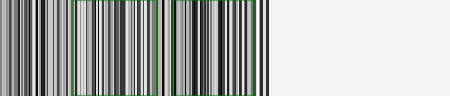

predicted


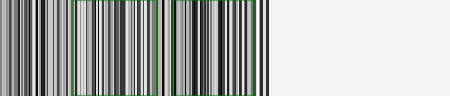

predicted


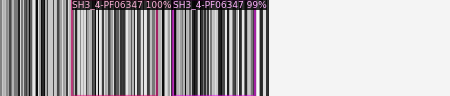

 88%|████████▊ | 381/435 [00:36<00:05, 10.42it/s]

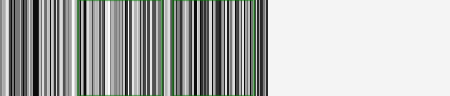

predicted


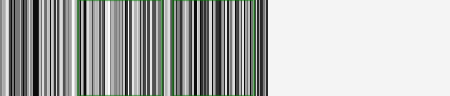

predicted


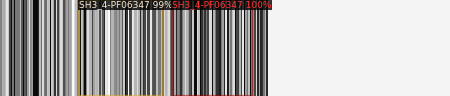

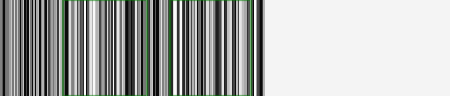

predicted


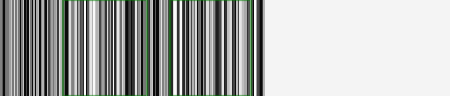

predicted


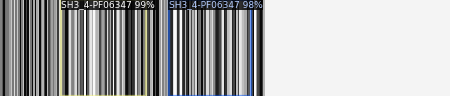

 88%|████████▊ | 383/435 [00:36<00:04, 10.47it/s]

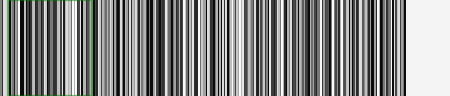

predicted


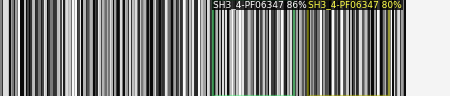

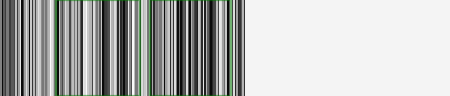

predicted


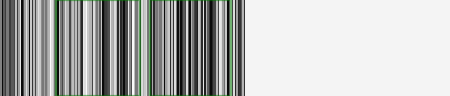

predicted


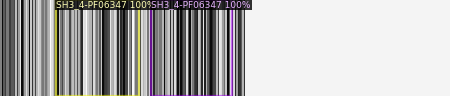

 89%|████████▊ | 385/435 [00:36<00:04, 10.69it/s]

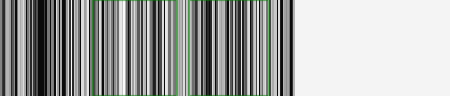

predicted


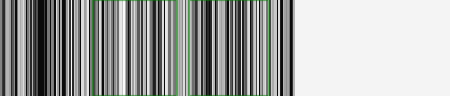

predicted


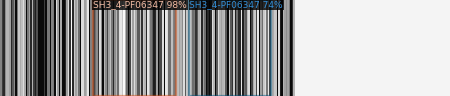

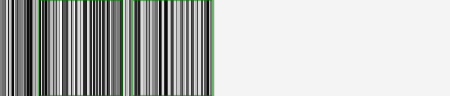

predicted


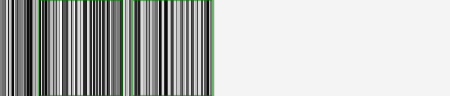

predicted


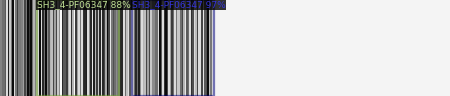

 89%|████████▉ | 387/435 [00:37<00:04, 10.69it/s]

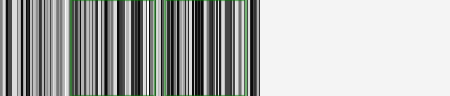

predicted


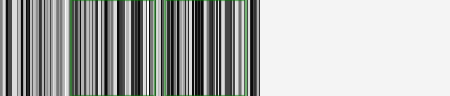

predicted


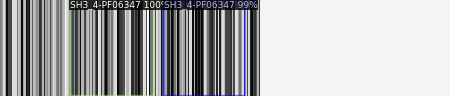

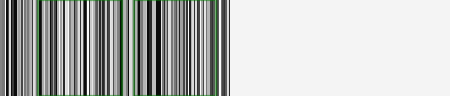

predicted


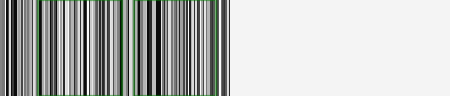

predicted


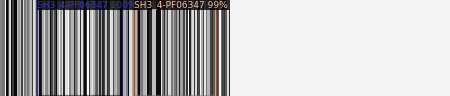

 89%|████████▉ | 389/435 [00:37<00:04, 10.77it/s]

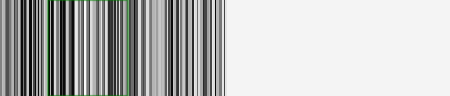

predicted


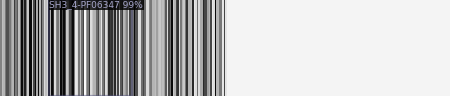

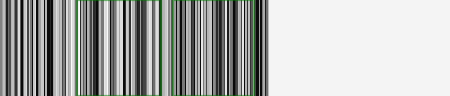

predicted


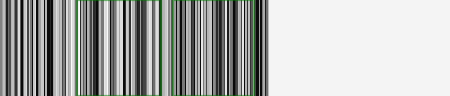

predicted


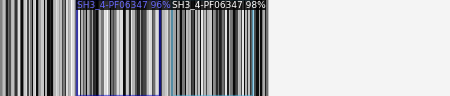

 90%|████████▉ | 391/435 [00:37<00:03, 11.01it/s]

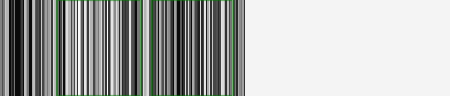

predicted


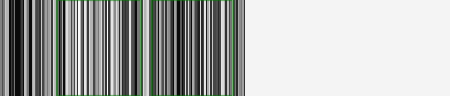

predicted


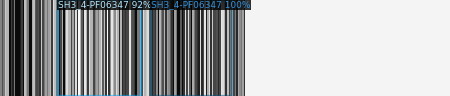

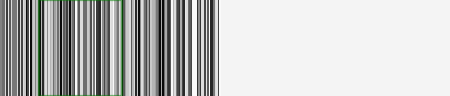

predicted


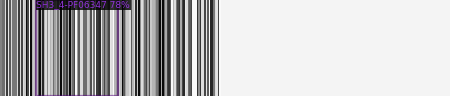

 90%|█████████ | 393/435 [00:37<00:03, 11.22it/s]

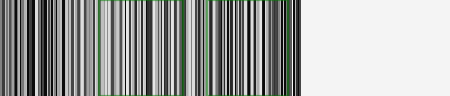

predicted


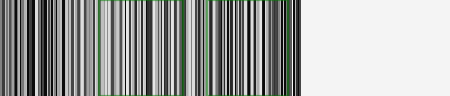

predicted


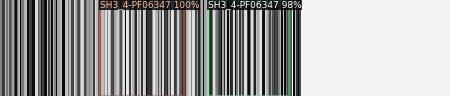

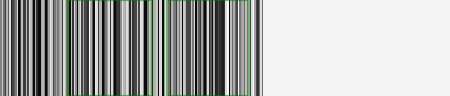

predicted


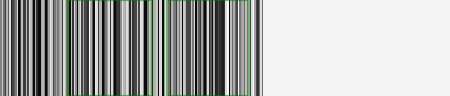

predicted


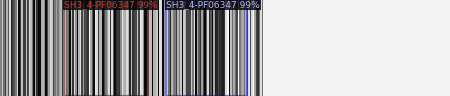

 91%|█████████ | 395/435 [00:37<00:03, 11.11it/s]

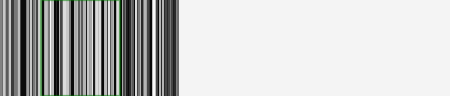

predicted


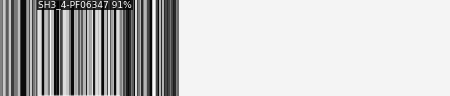

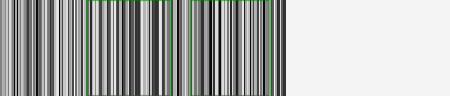

predicted


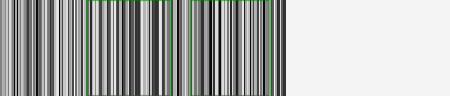

predicted


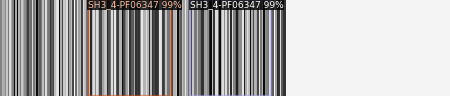

 91%|█████████▏| 397/435 [00:38<00:04,  9.10it/s]

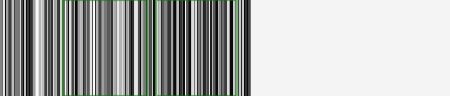

predicted


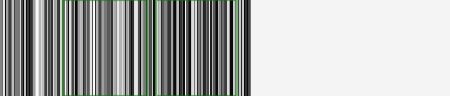

predicted


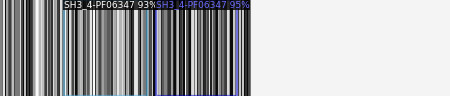

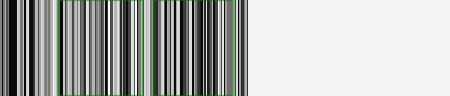

predicted


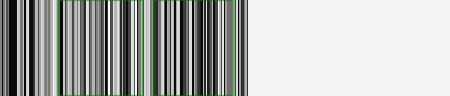

predicted


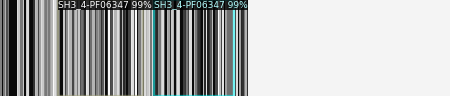

 92%|█████████▏| 399/435 [00:38<00:03,  9.55it/s]

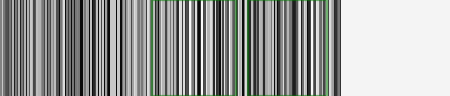

predicted


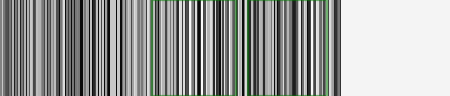

predicted


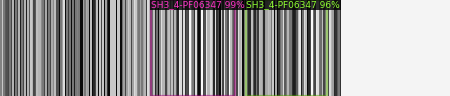

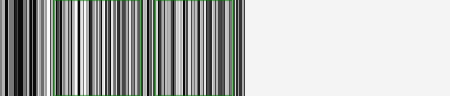

predicted


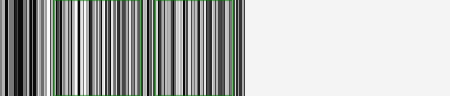

predicted


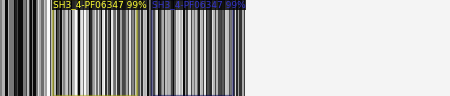

 92%|█████████▏| 401/435 [00:38<00:03,  9.93it/s]

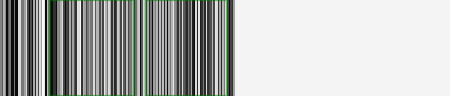

predicted


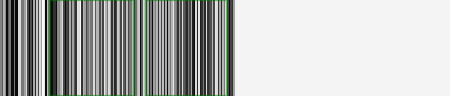

predicted


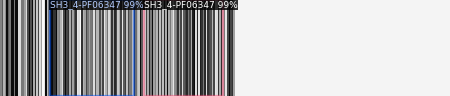

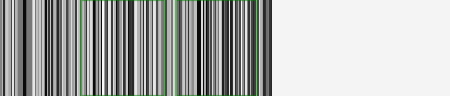

predicted


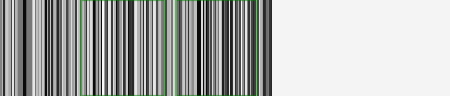

predicted


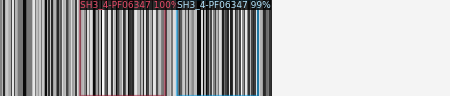

 93%|█████████▎| 403/435 [00:38<00:03, 10.23it/s]

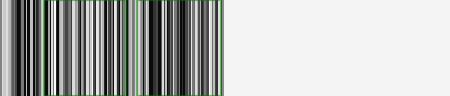

predicted


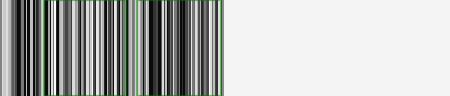

predicted


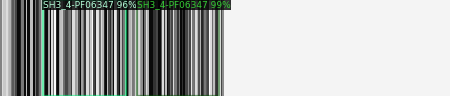

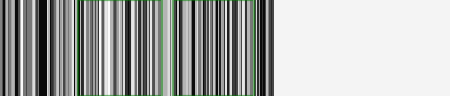

predicted


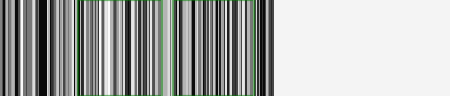

predicted


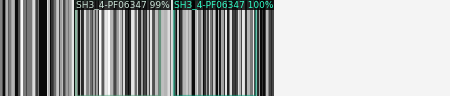

 93%|█████████▎| 405/435 [00:38<00:02, 10.40it/s]

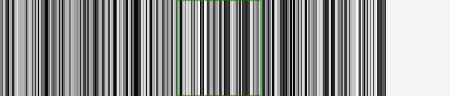

predicted


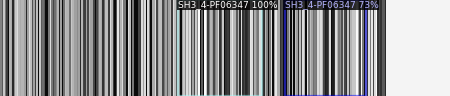

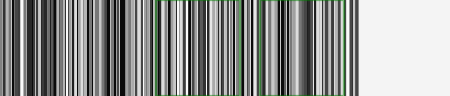

predicted


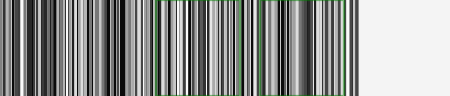

predicted


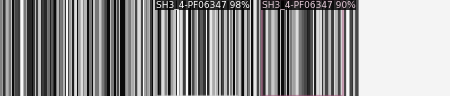

 94%|█████████▎| 407/435 [00:38<00:02, 10.66it/s]

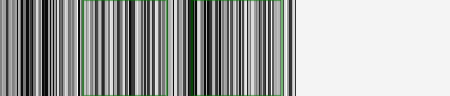

predicted


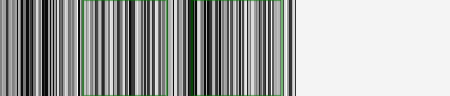

predicted


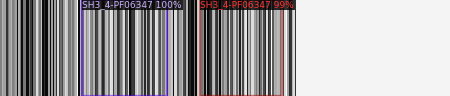

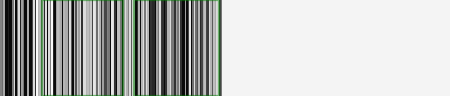

predicted


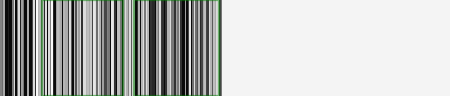

predicted


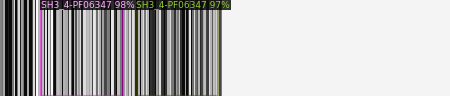

 94%|█████████▍| 409/435 [00:39<00:02, 10.75it/s]

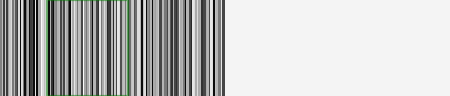

predicted


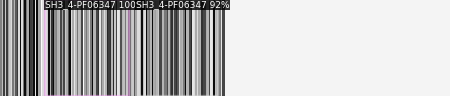

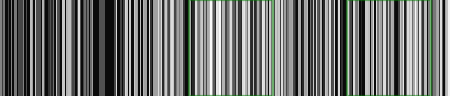

predicted


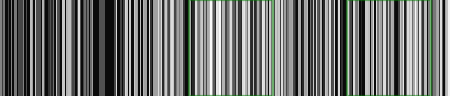

predicted


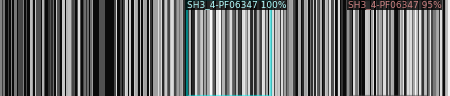

 94%|█████████▍| 411/435 [00:39<00:02, 10.99it/s]

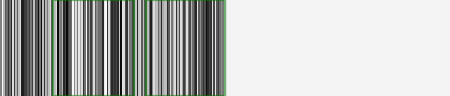

predicted


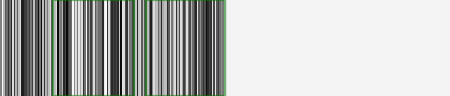

predicted


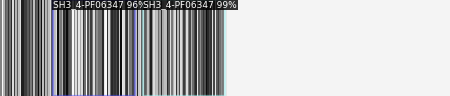

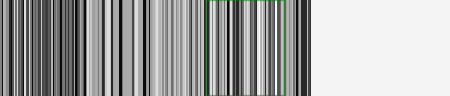

predicted


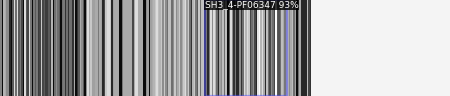

 95%|█████████▍| 413/435 [00:39<00:01, 11.22it/s]

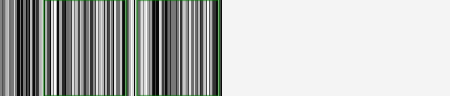

predicted


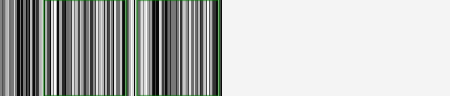

predicted


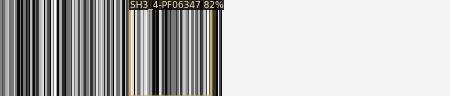

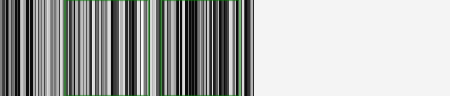

predicted


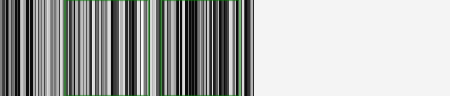

predicted


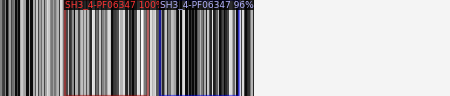

 95%|█████████▌| 415/435 [00:39<00:01, 11.22it/s]

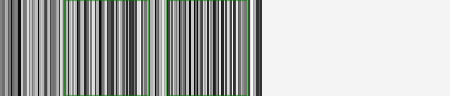

predicted


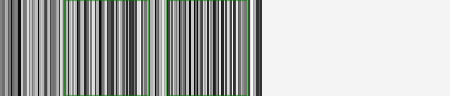

predicted


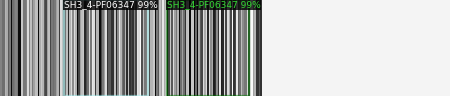

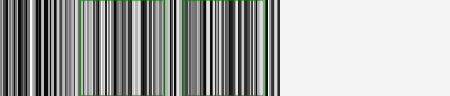

predicted


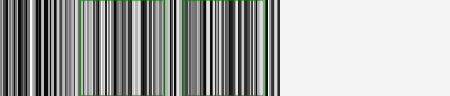

predicted


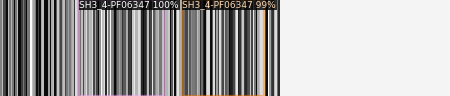

 96%|█████████▌| 417/435 [00:39<00:01, 11.10it/s]

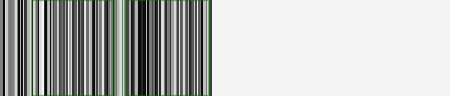

predicted


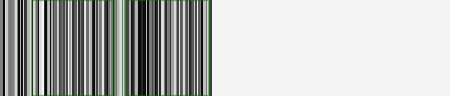

predicted


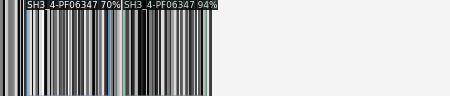

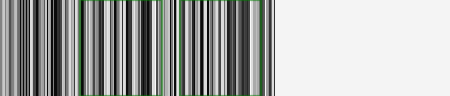

predicted


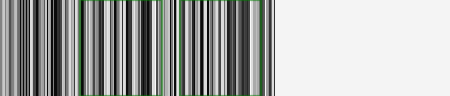

predicted


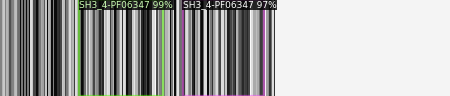

 96%|█████████▋| 419/435 [00:40<00:01, 11.05it/s]

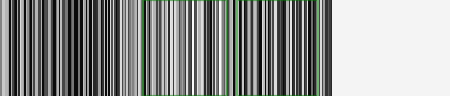

predicted


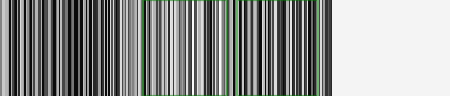

predicted


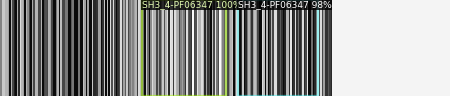

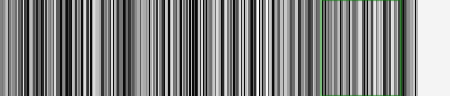

predicted


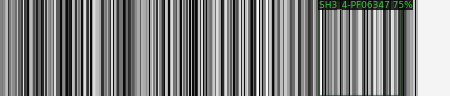

 97%|█████████▋| 421/435 [00:40<00:01,  9.15it/s]

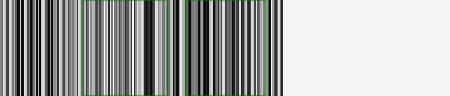

predicted


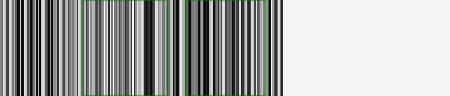

predicted


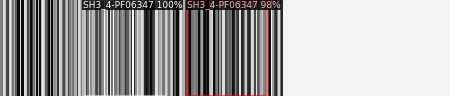

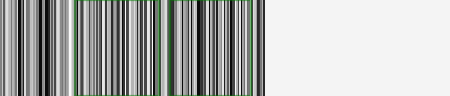

predicted


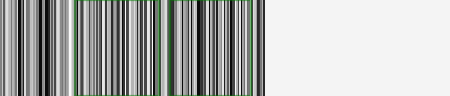

predicted


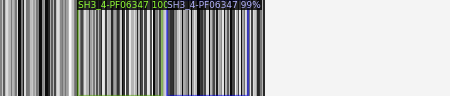

 97%|█████████▋| 423/435 [00:40<00:01,  9.62it/s]

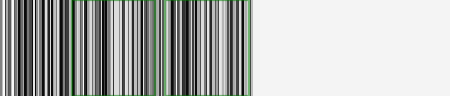

predicted


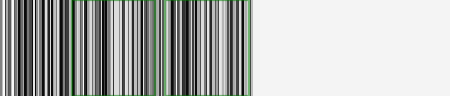

predicted


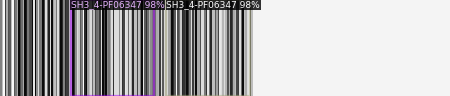

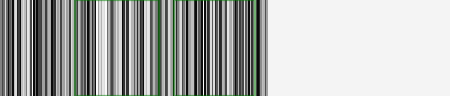

predicted


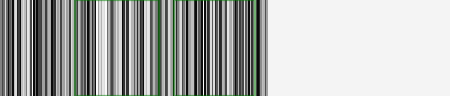

predicted


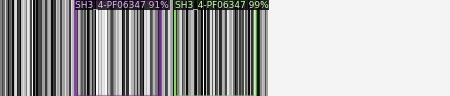

 98%|█████████▊| 425/435 [00:40<00:01,  9.96it/s]

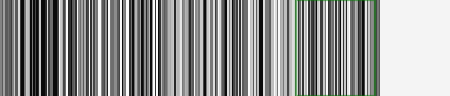

predicted


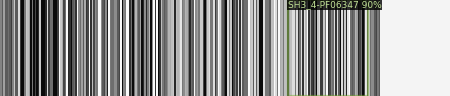

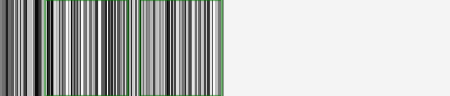

predicted


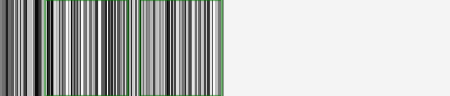

predicted


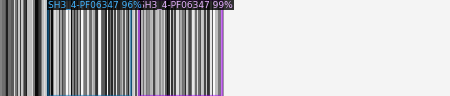

 98%|█████████▊| 427/435 [00:40<00:00, 10.42it/s]

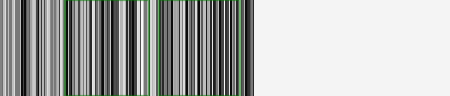

predicted


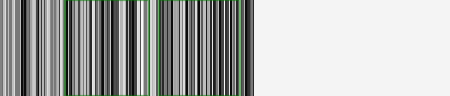

predicted


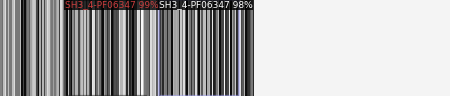

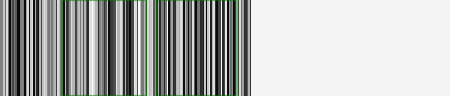

predicted


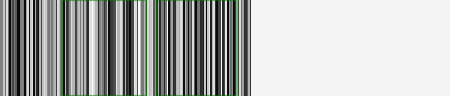

predicted


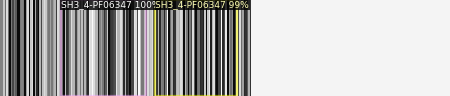

 99%|█████████▊| 429/435 [00:41<00:00, 10.57it/s]

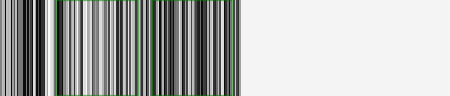

predicted


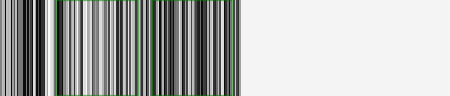

predicted


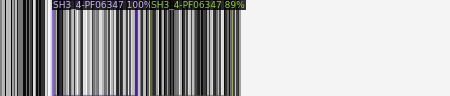

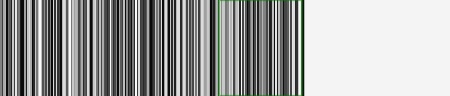

predicted


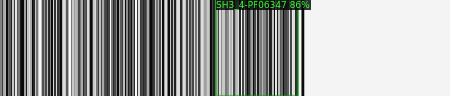

 99%|█████████▉| 431/435 [00:41<00:00, 10.88it/s]

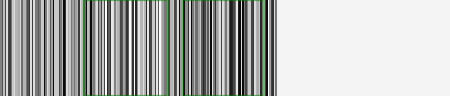

predicted


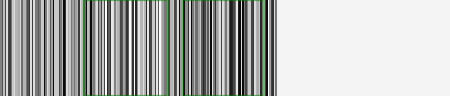

predicted


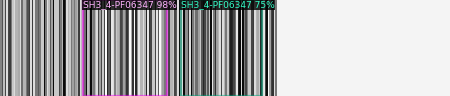

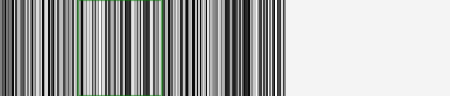

predicted


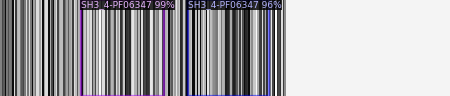

100%|█████████▉| 433/435 [00:41<00:00, 10.96it/s]

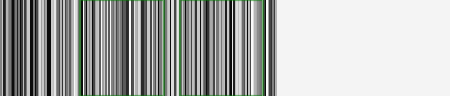

predicted


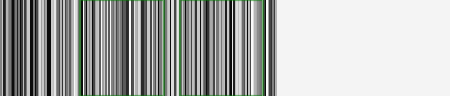

predicted


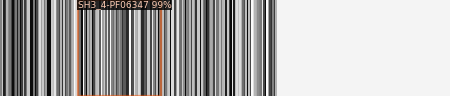

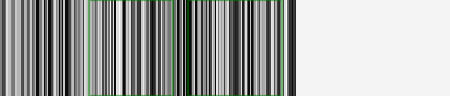

predicted


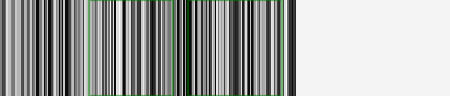

predicted


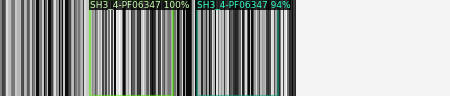

100%|██████████| 435/435 [00:41<00:00, 10.46it/s]


In [25]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("valid")
count=0
for d in tqdm(dataset_dicts):   
#     print(d)
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v1 = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("valid").set(thing_classes = ctrlr.classes), 
                   scale=1.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    v2 = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("valid").set(thing_classes = ctrlr.classes), 
                   scale=1.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v1.draw_instance_predictions(outputs["instances"].to("cpu"))
    if len(outputs['instances'].get_fields()['scores'])==0:
        count+=1
    actual=[]
    for bbox in d['annotations']:
        
        actual.append(v2.draw_box(bbox['bbox']))
    for i in actual:
        cv2_imshow(i.get_image()[:, :, ::-1])
        print('predicted')
    cv2_imshow(out.get_image()[:, :, ::-1])

In [24]:
outputs

{'instances': Instances(num_instances=2, image_height=64, image_width=300, fields=[pred_boxes: Boxes(tensor([[5.9671e+01, 0.0000e+00, 1.1553e+02, 6.4000e+01],
         [1.3116e+02, 5.8659e-02, 1.8547e+02, 6.3809e+01]], device='cuda:0')), scores: tensor([0.9980, 0.9419], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}

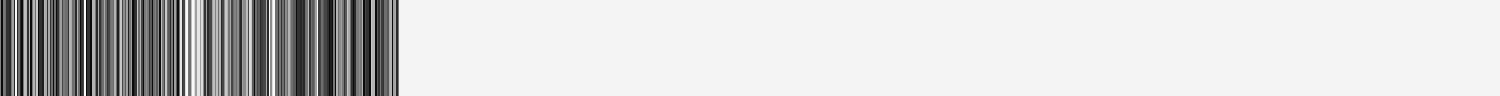

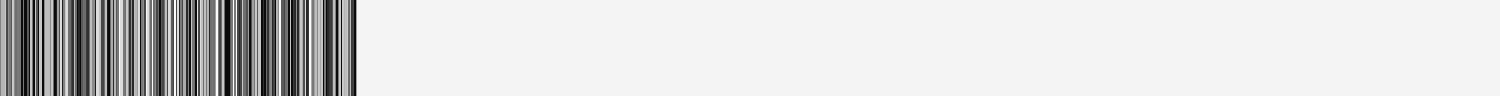

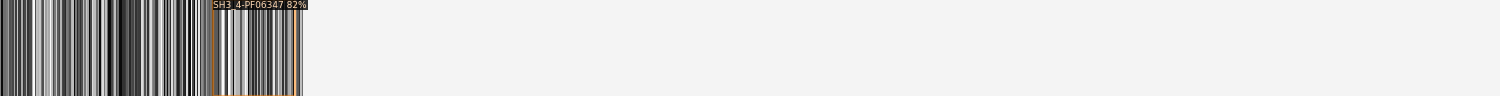

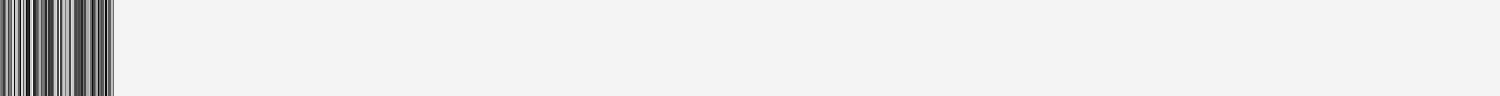

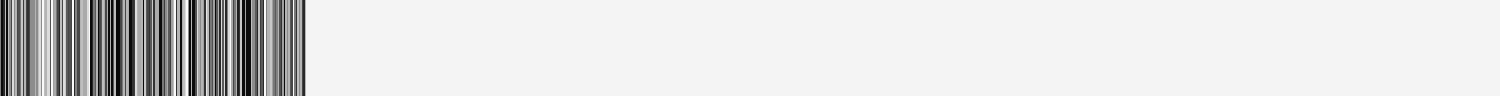

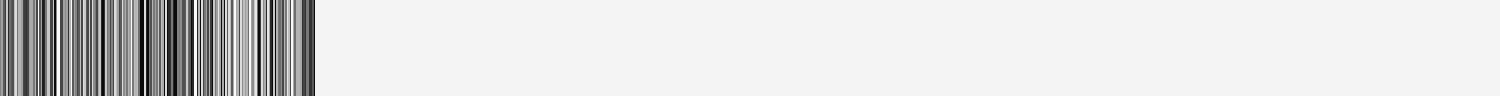

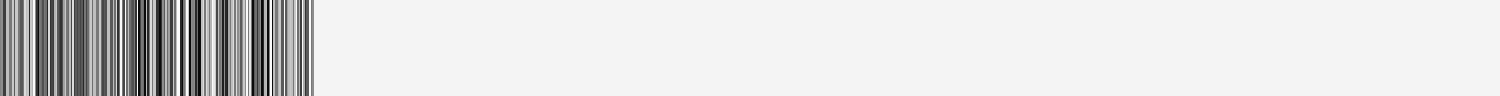

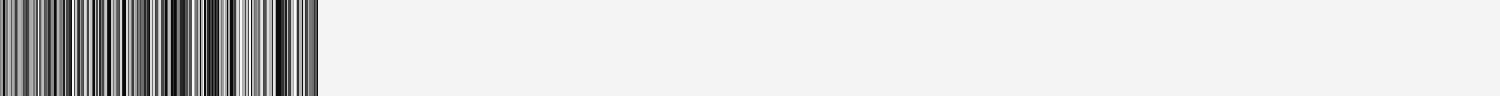

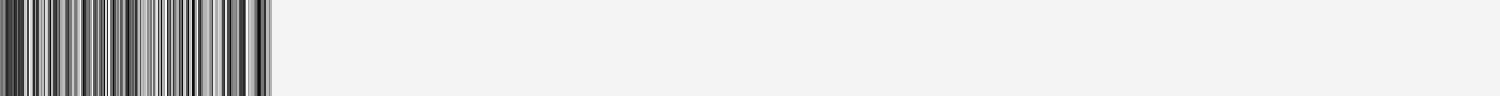

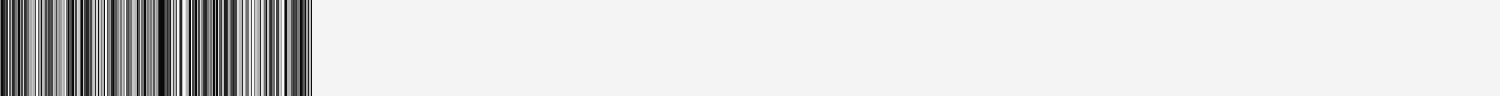

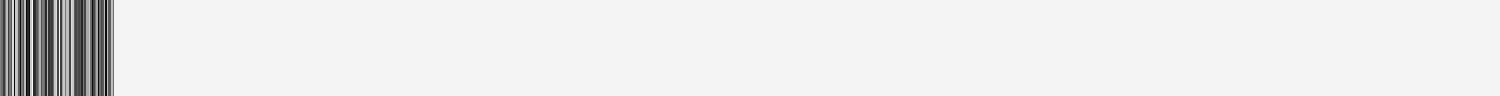

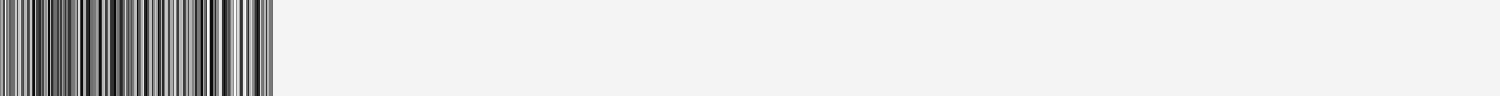

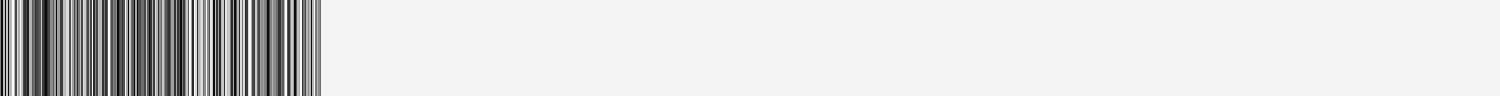

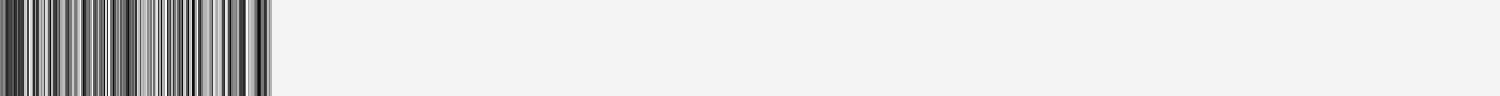

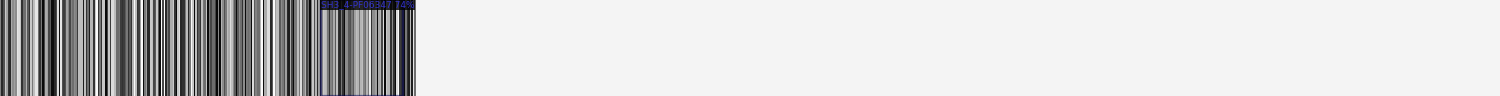

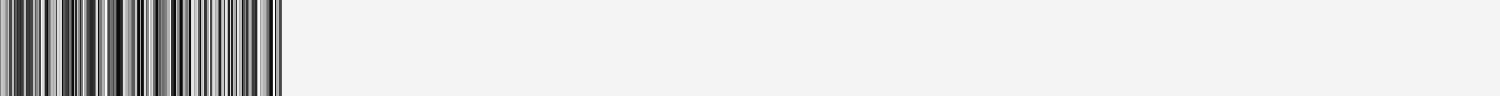

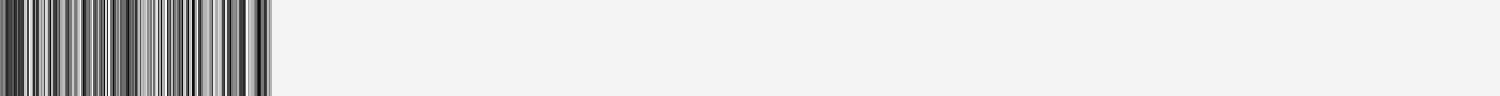

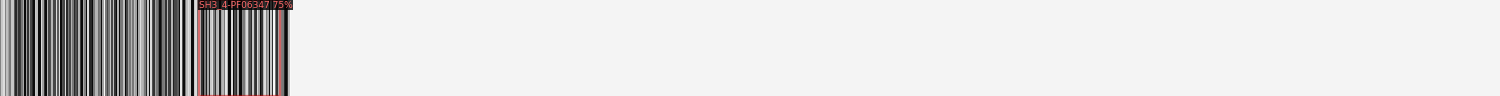

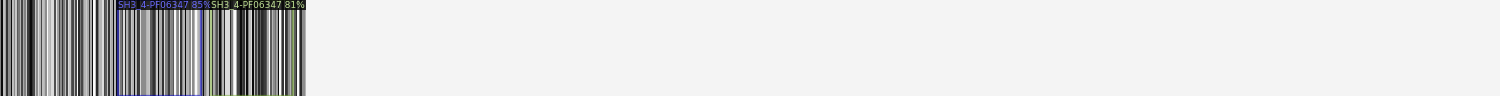

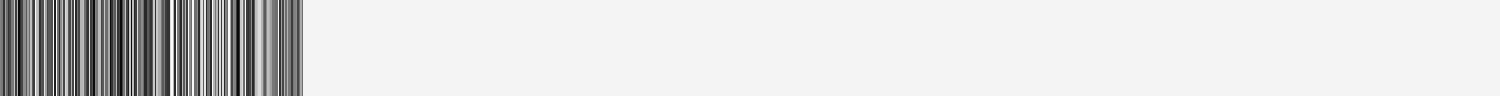

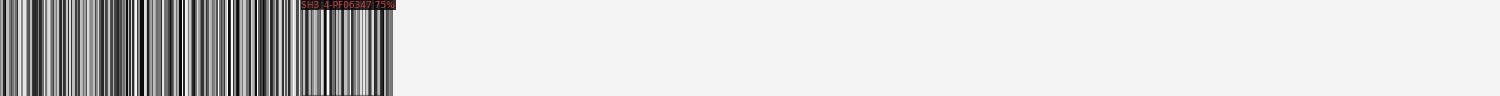

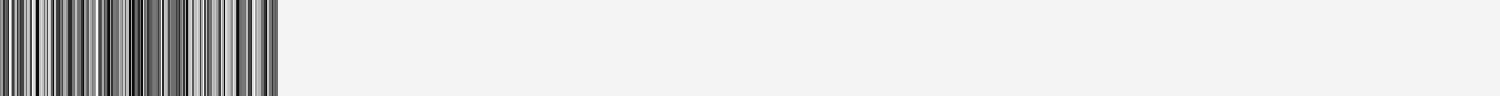

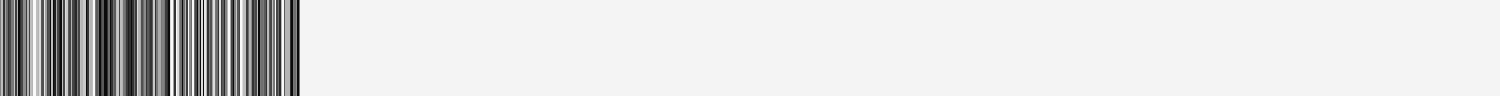

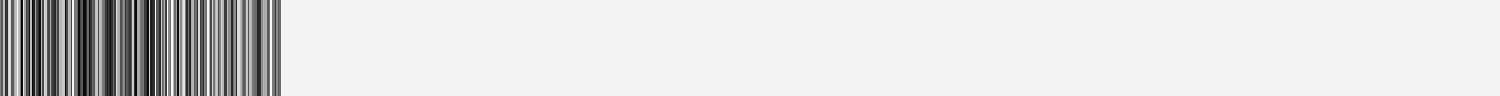

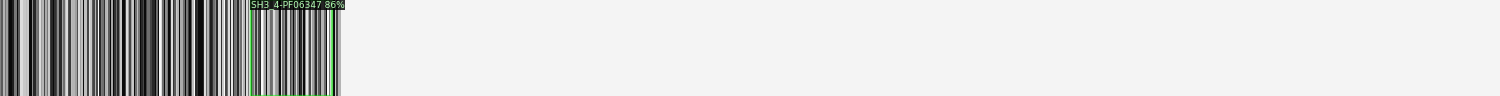

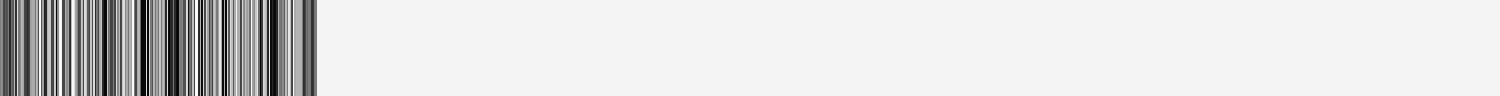

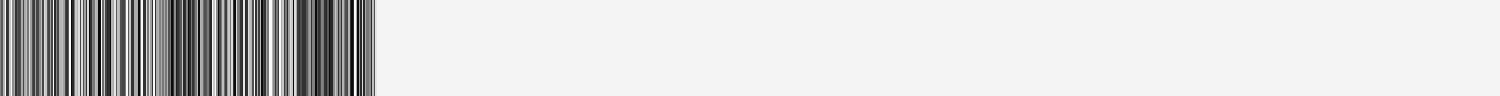

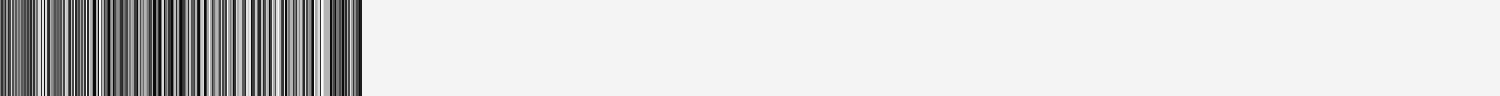

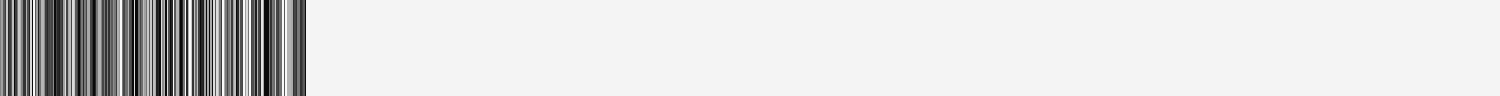

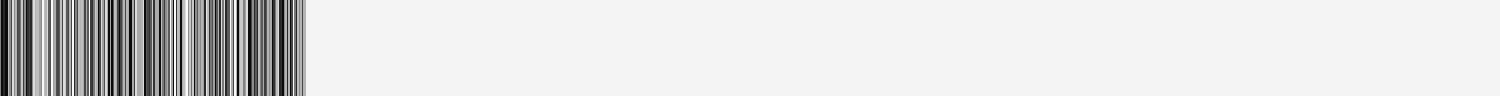

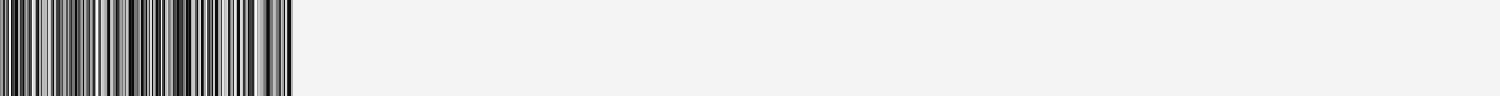

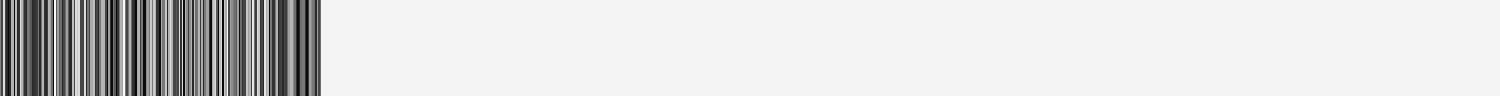

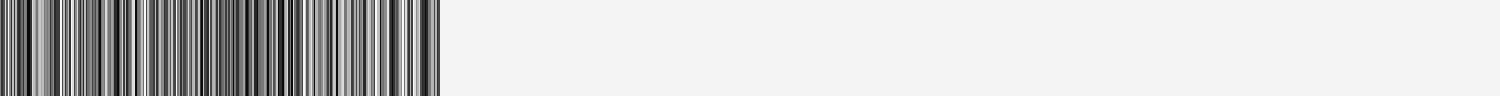

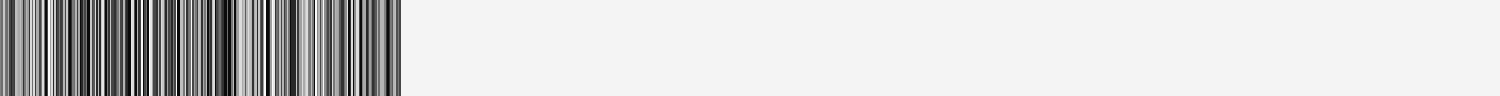

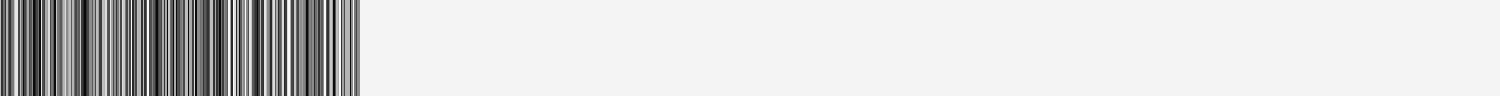

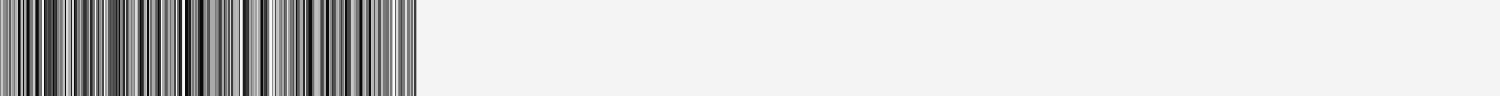

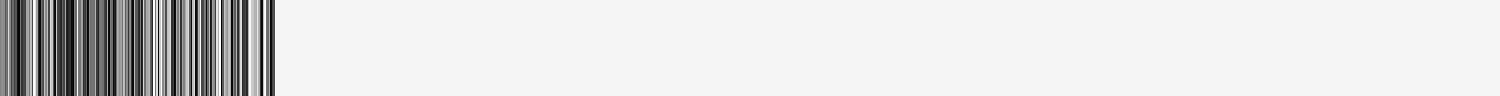

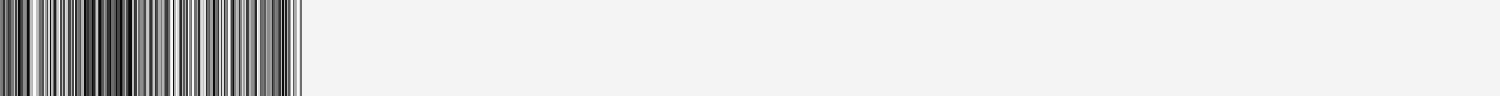

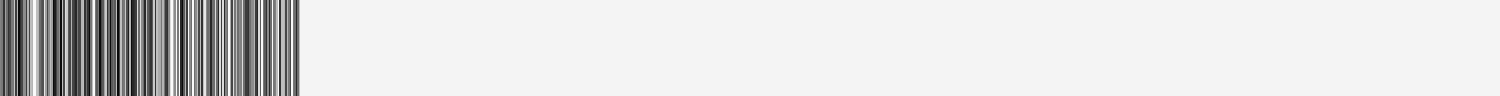

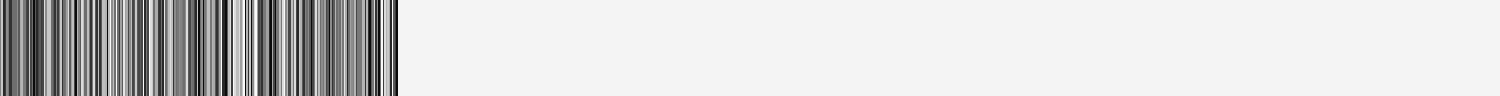

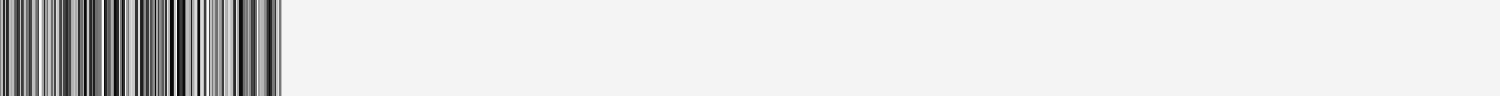

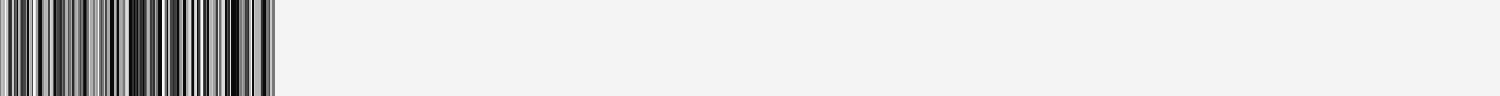

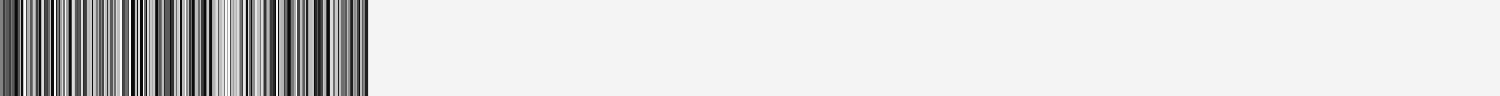

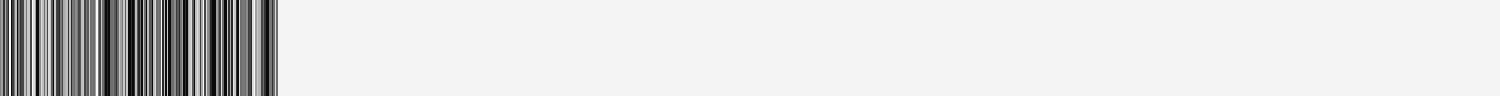

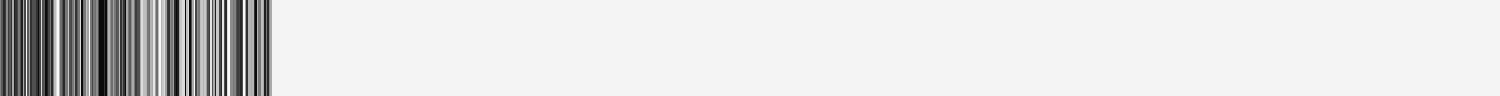

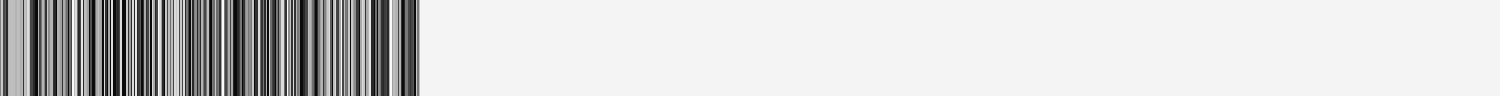

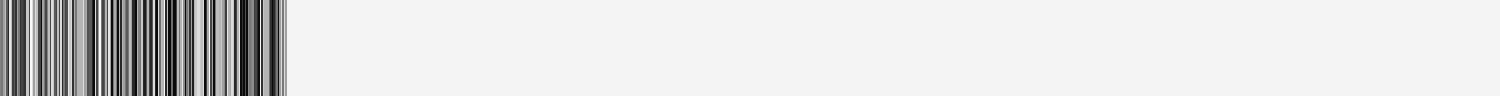

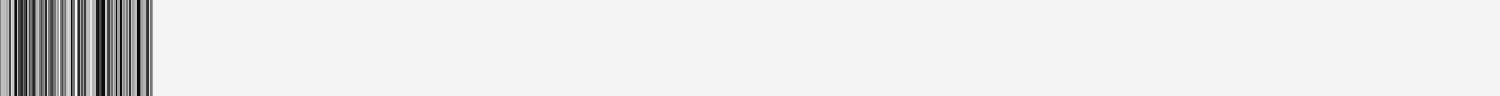

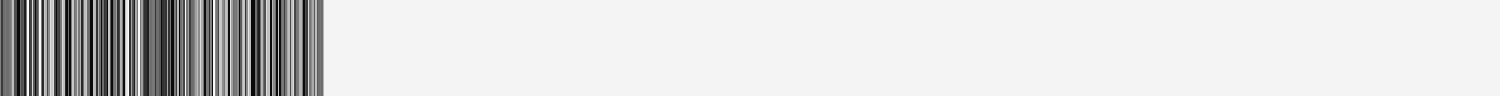

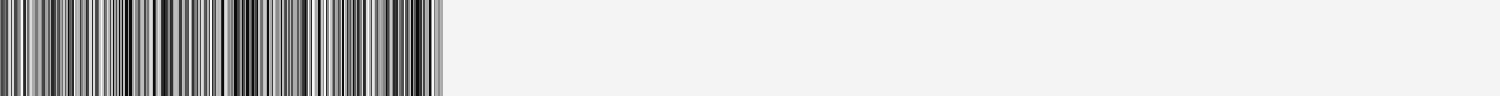

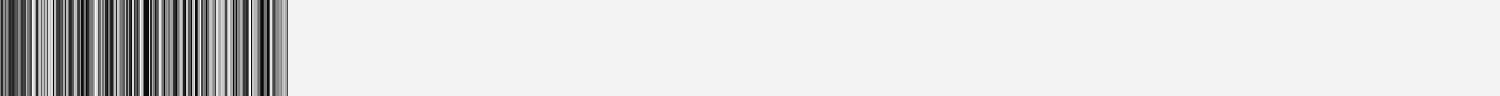

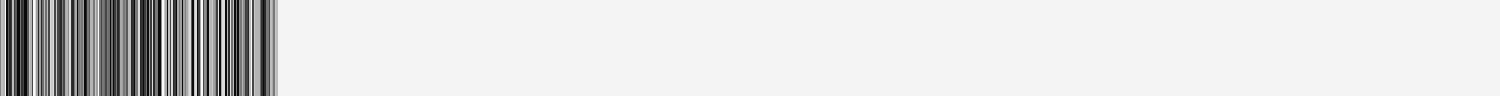

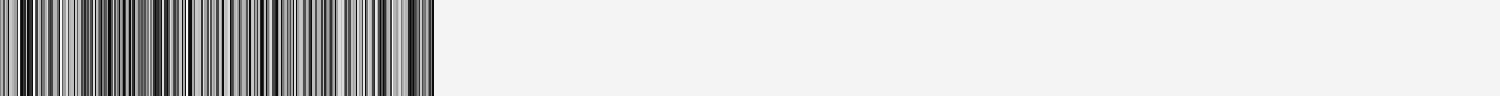

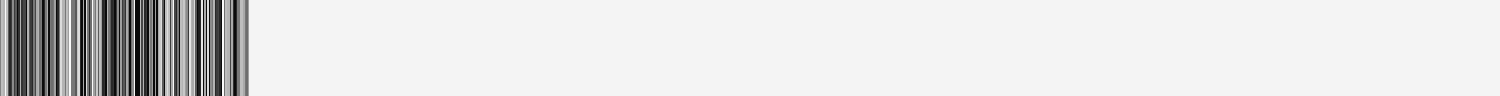

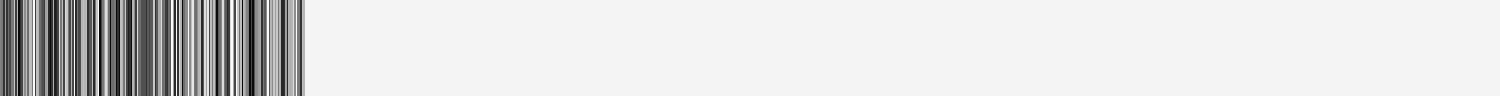

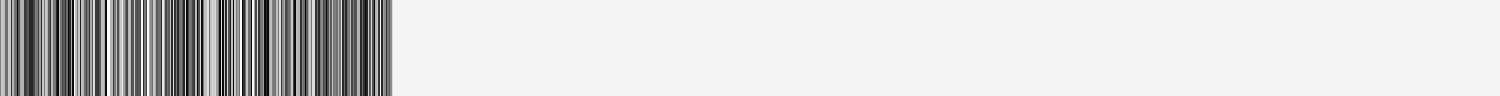

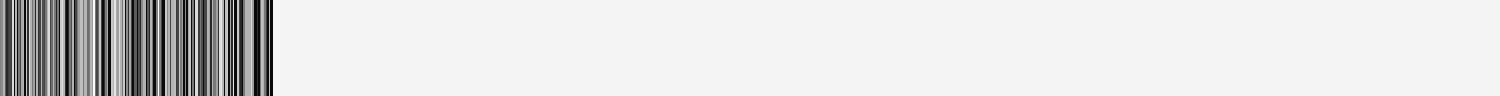

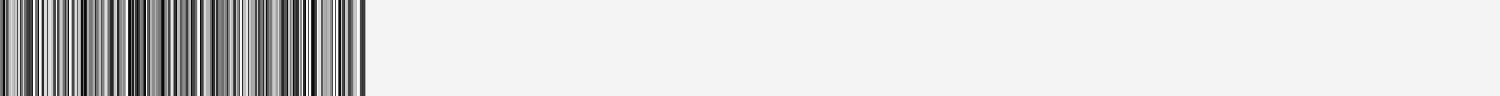

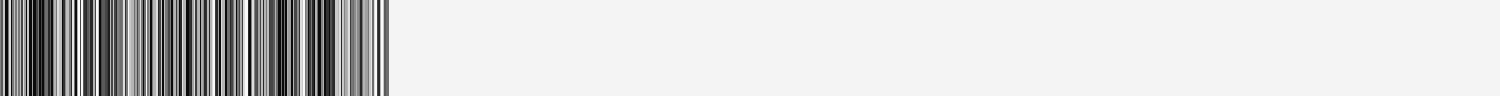

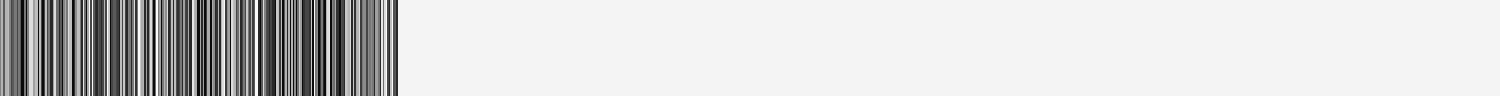

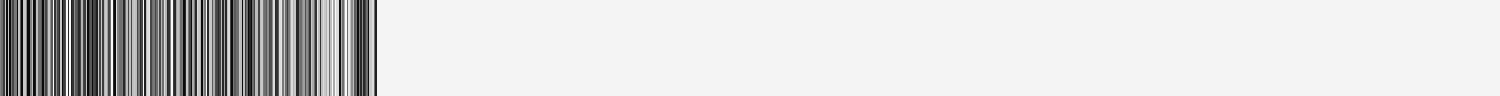

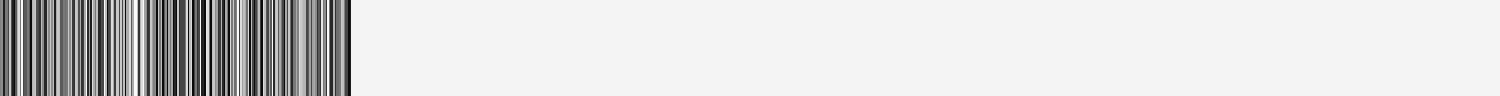

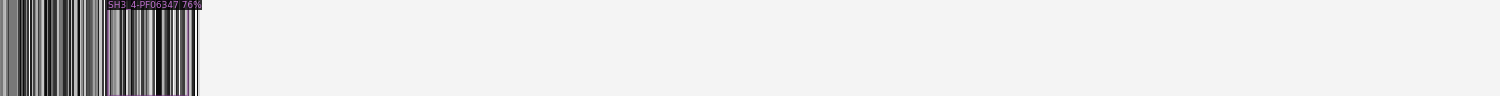

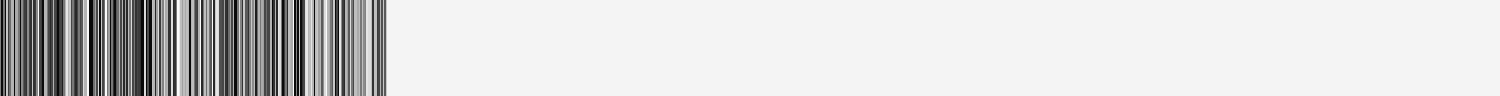

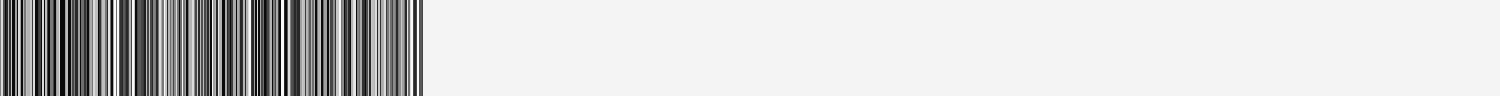

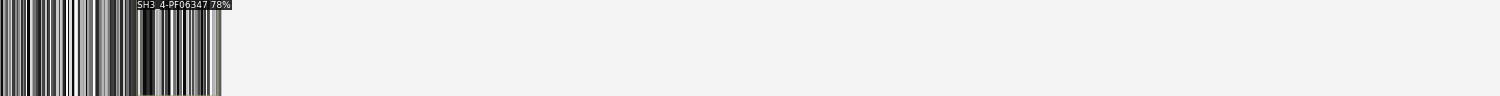

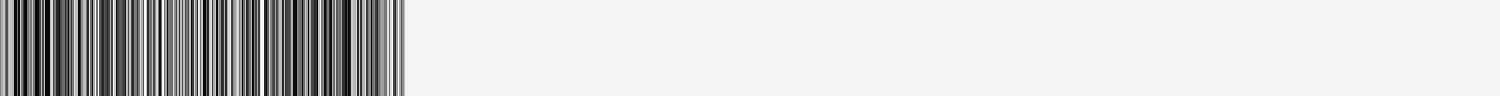

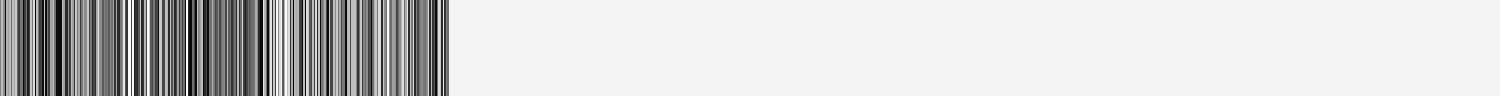

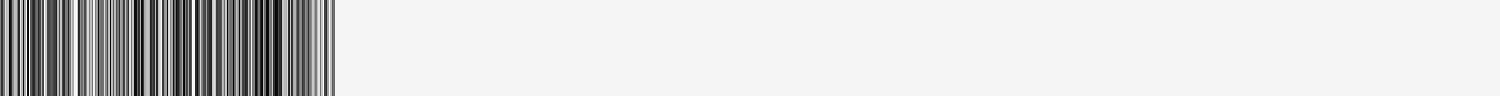

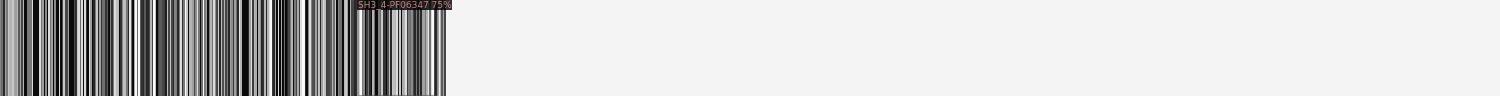

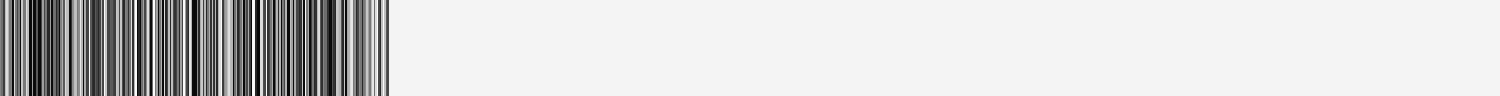

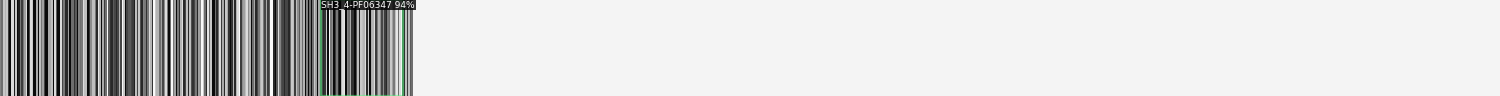

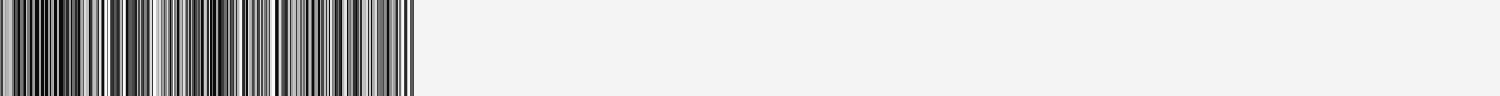

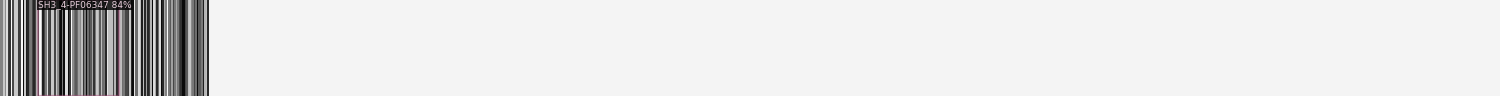

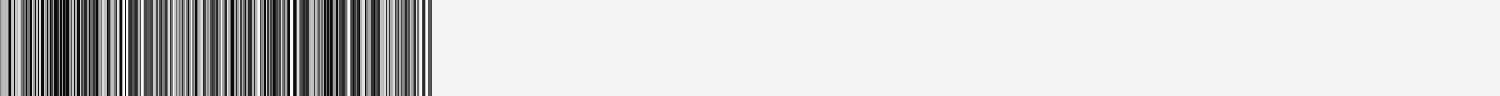

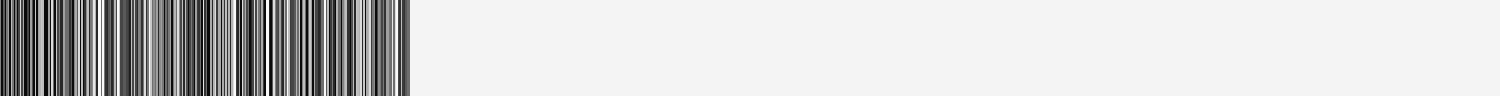

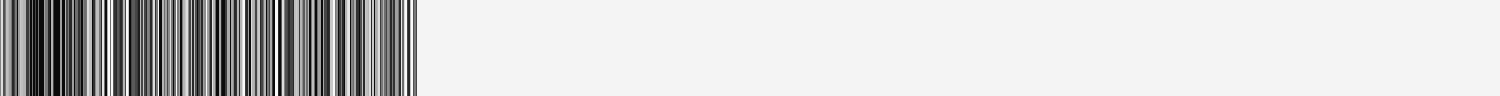

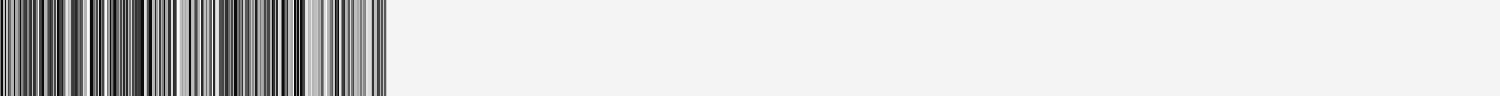

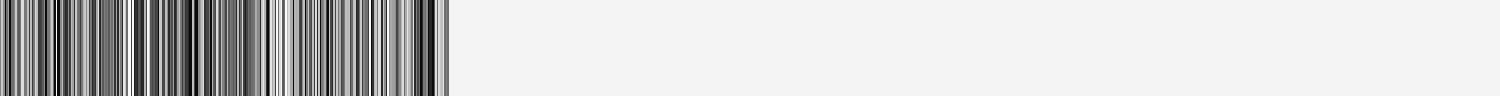

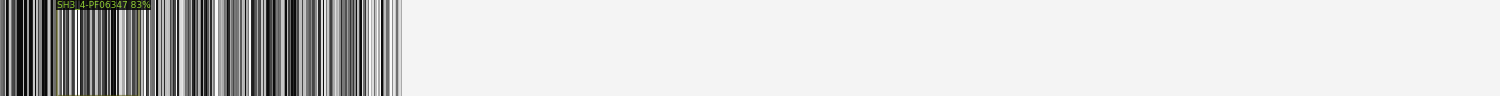

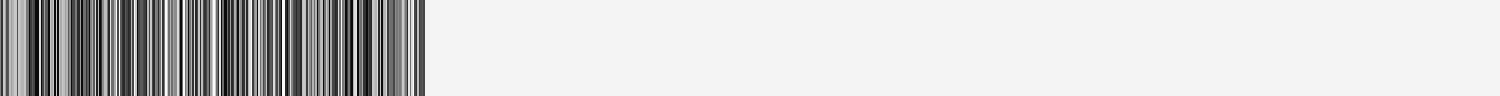

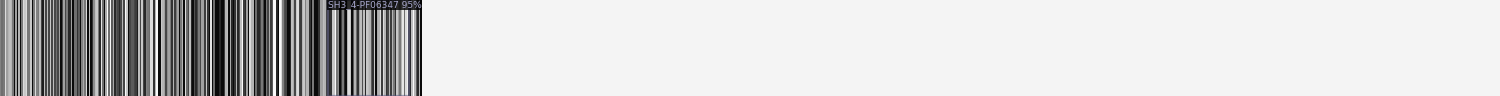

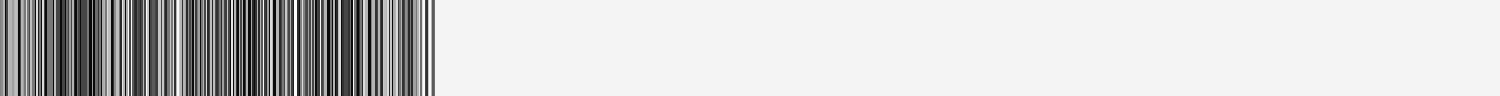

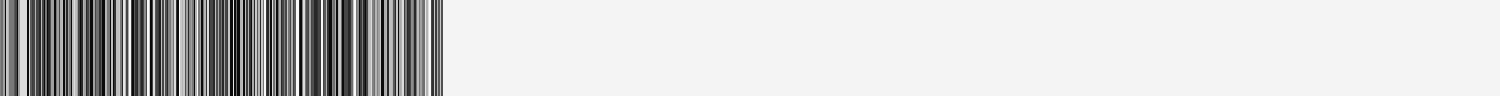

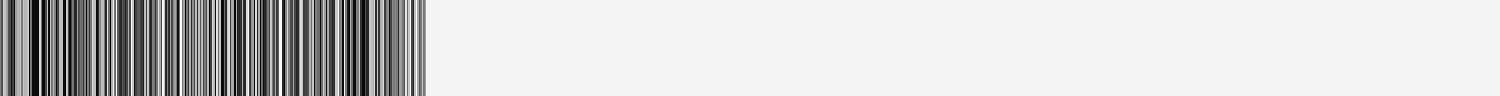

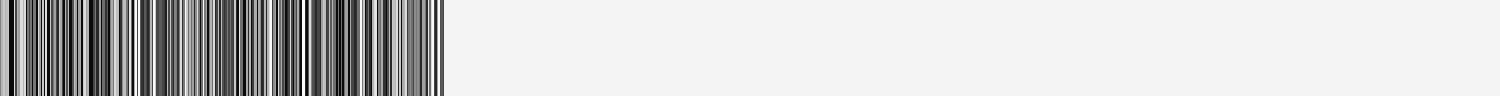

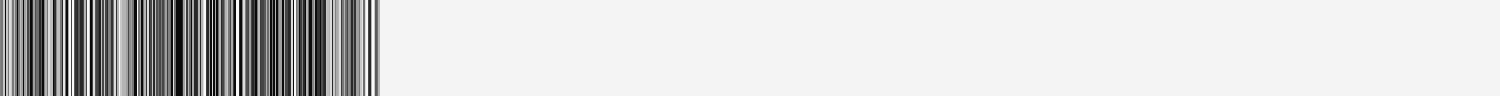

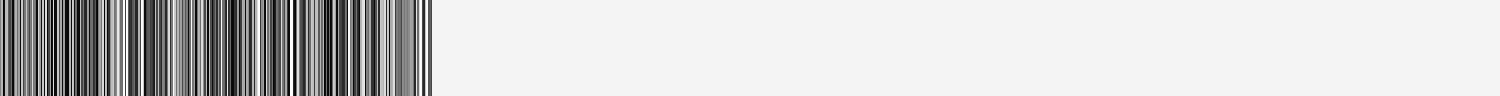

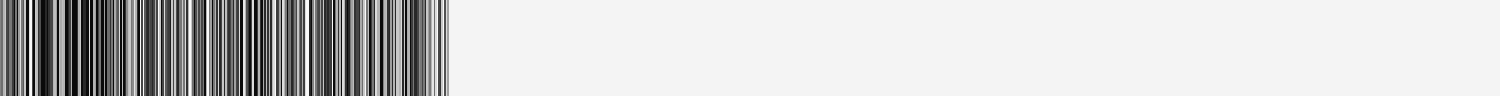

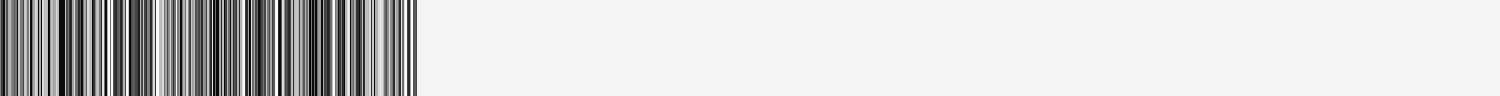

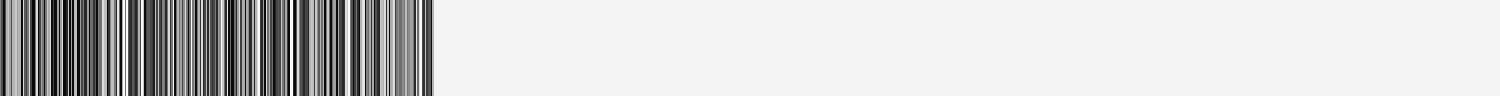

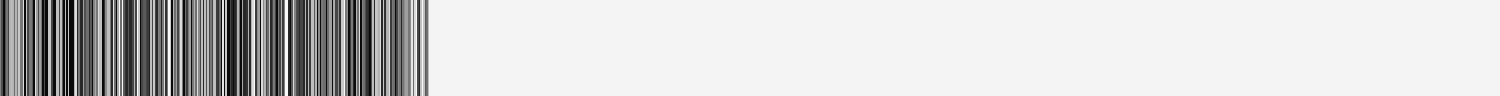

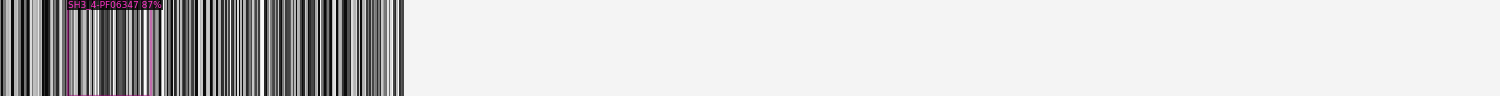

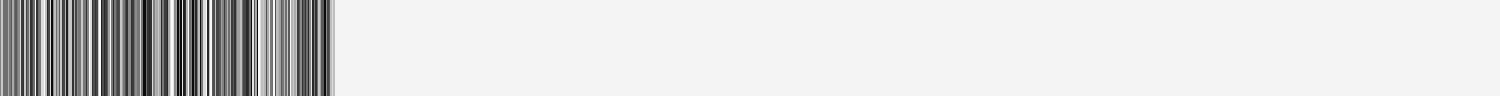

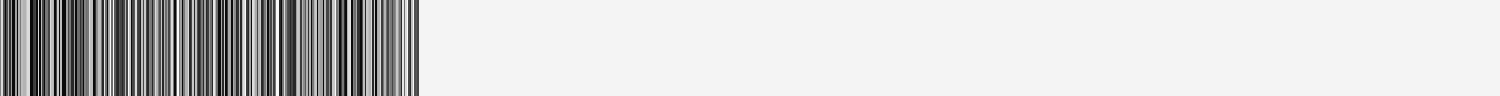

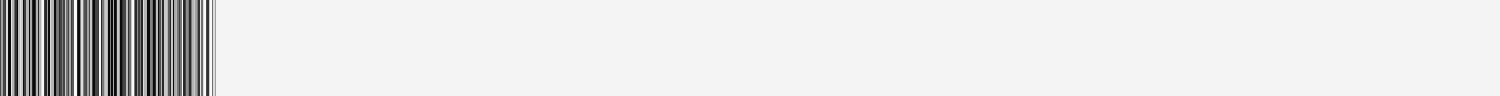

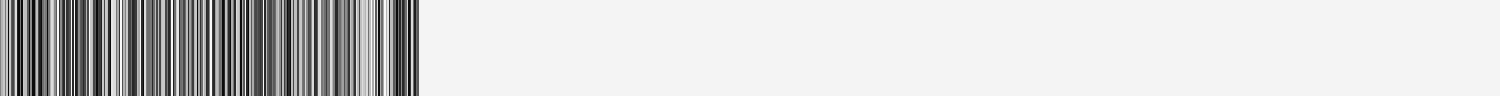

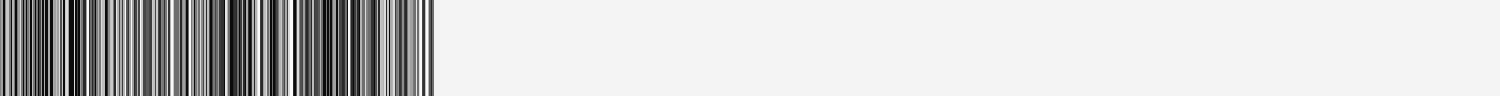

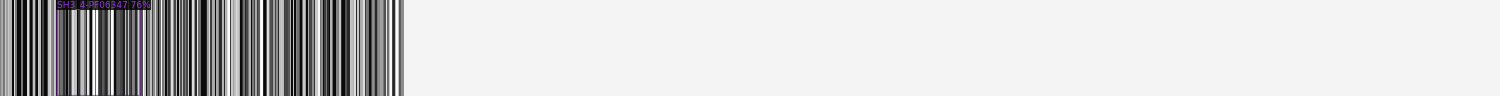

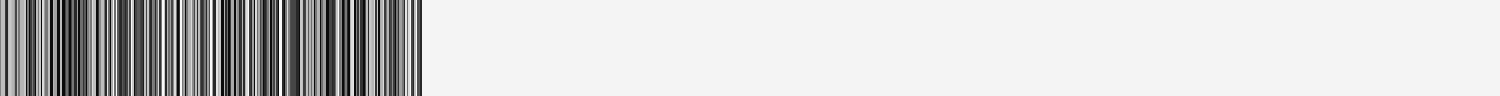

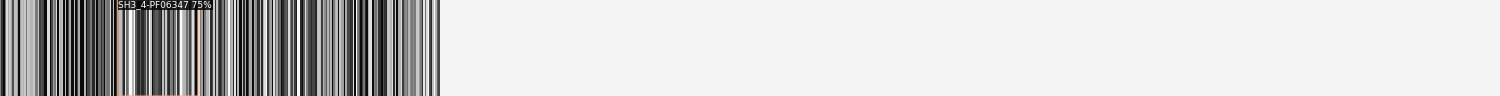

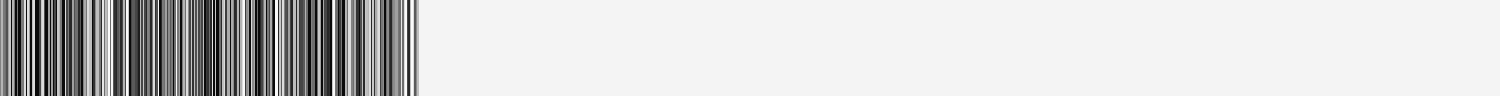

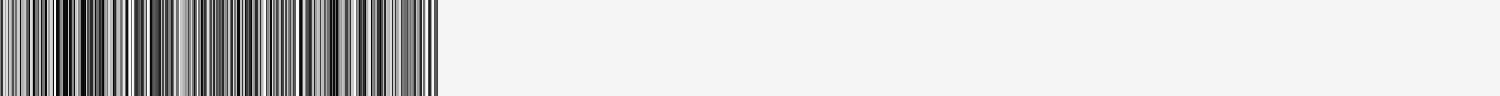

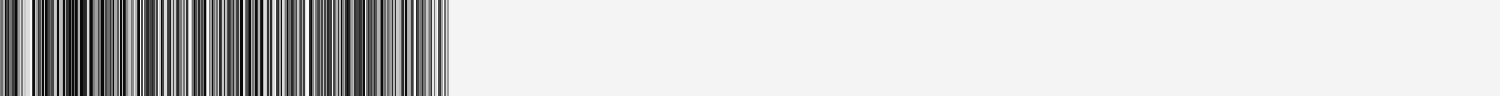

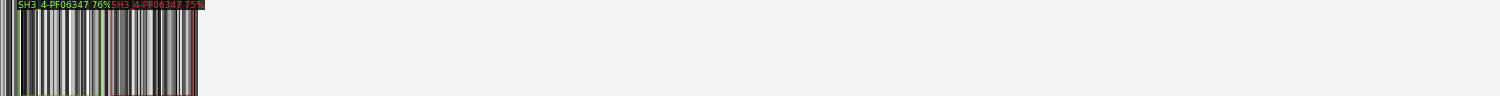

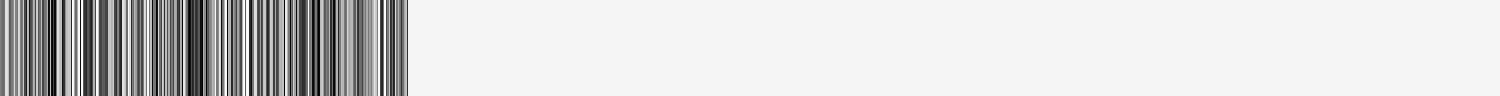

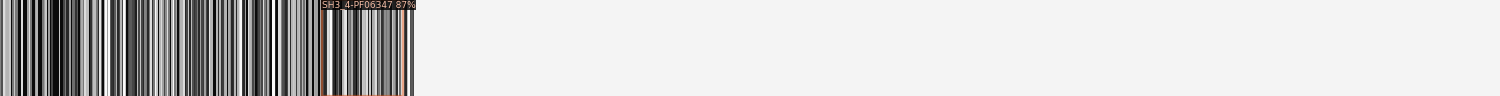

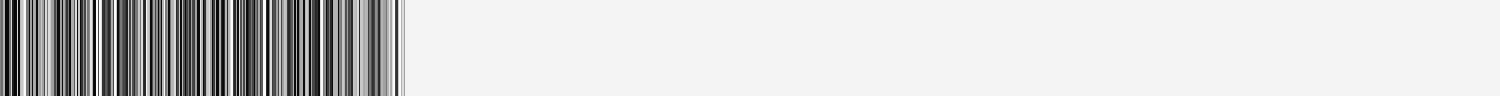

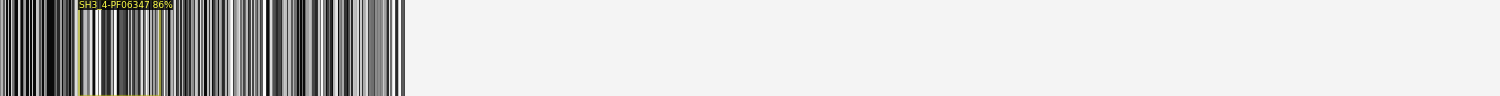

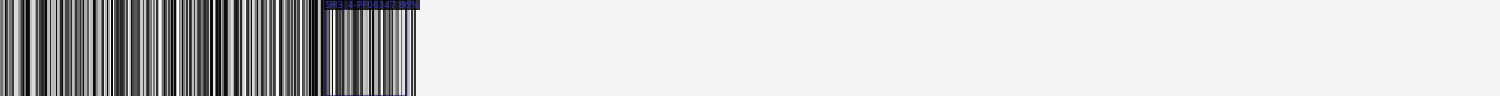

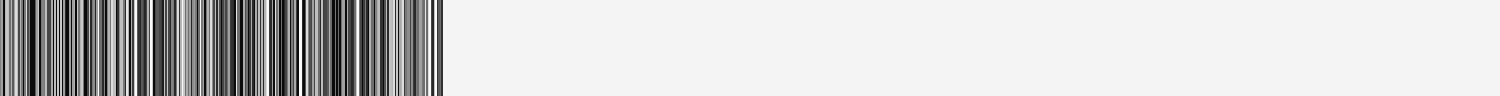

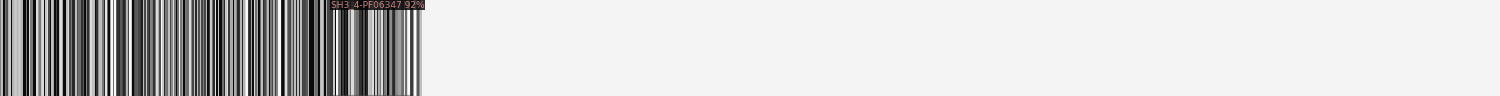

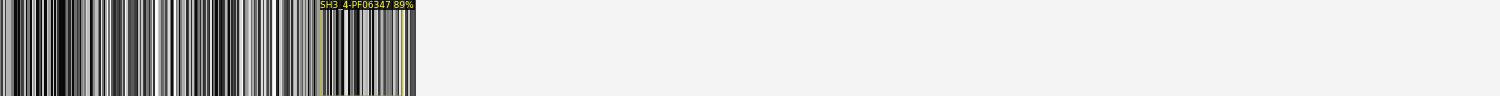

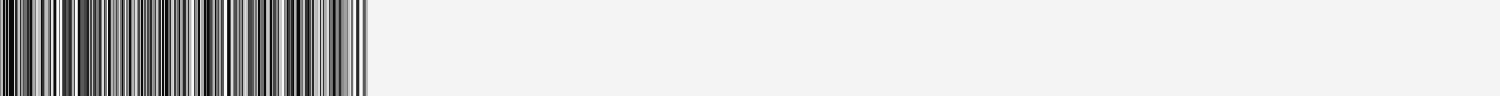

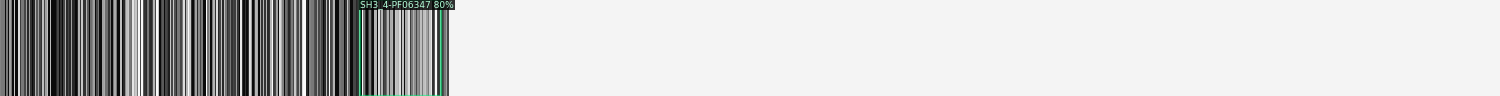

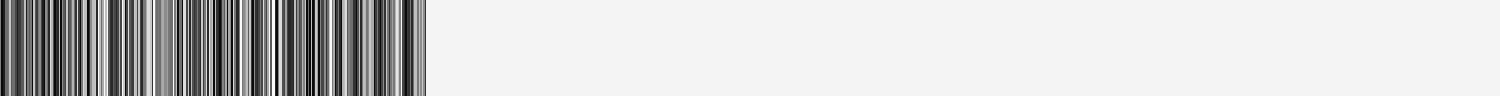

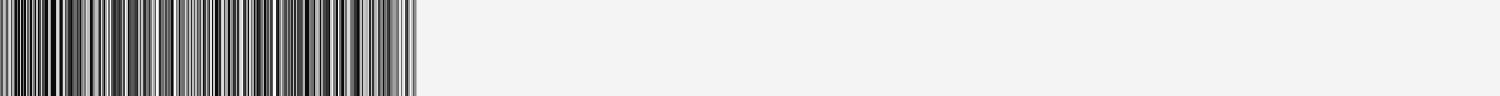

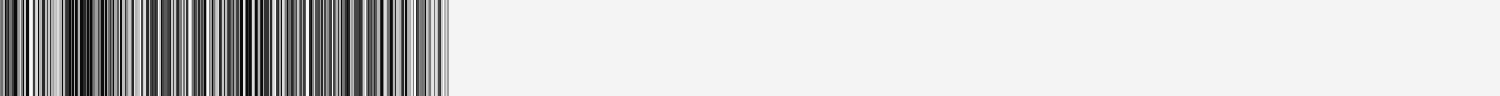

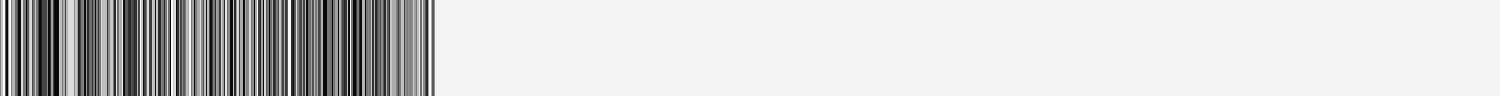

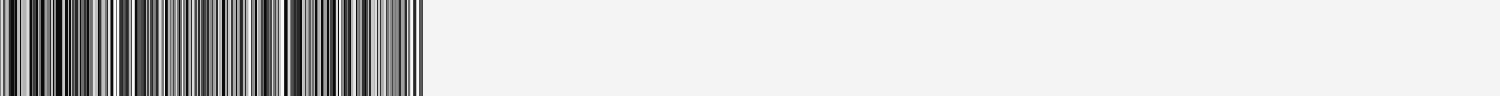

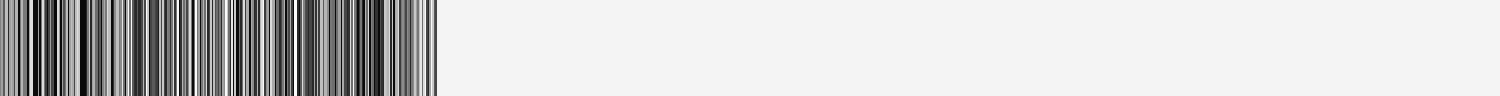

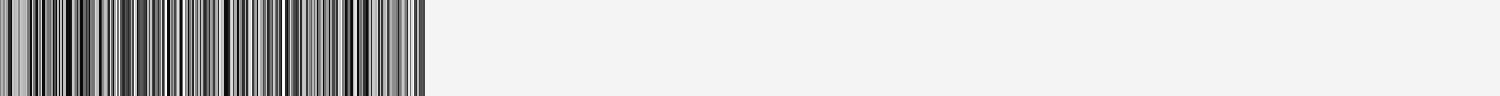

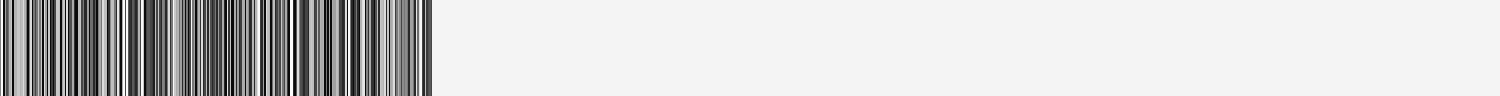

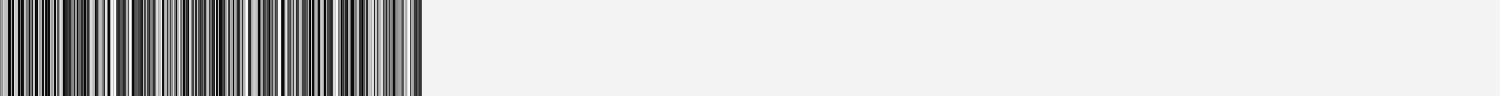

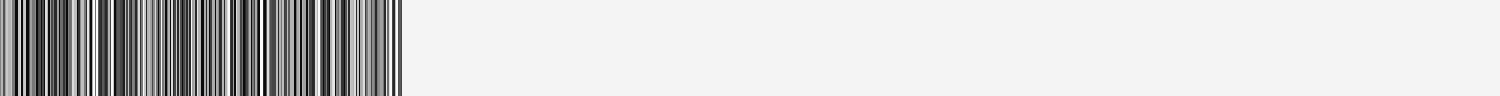

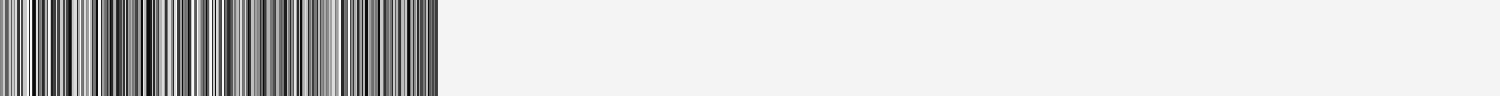

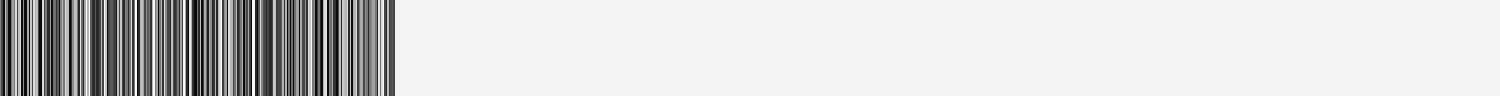

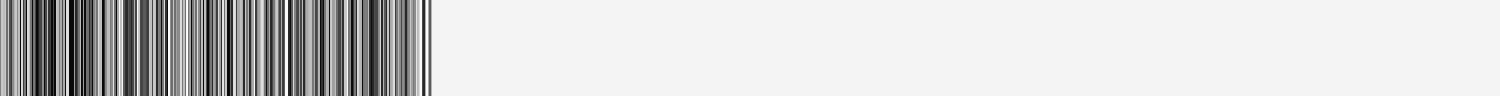

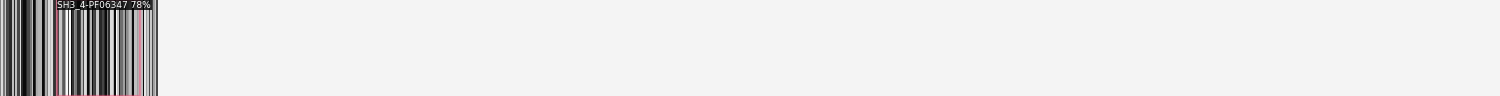

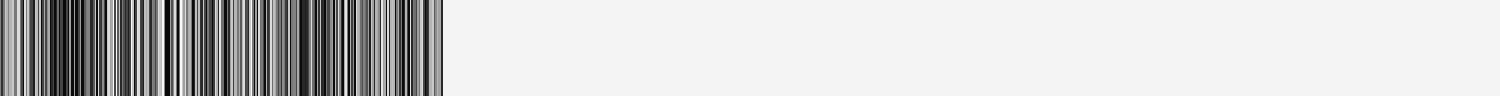

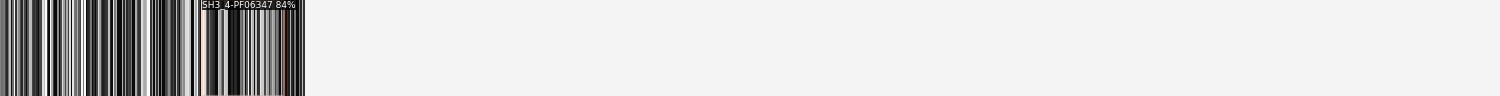

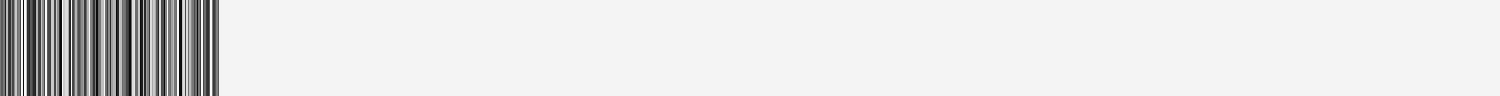

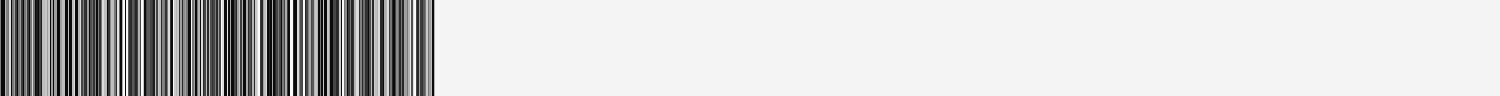

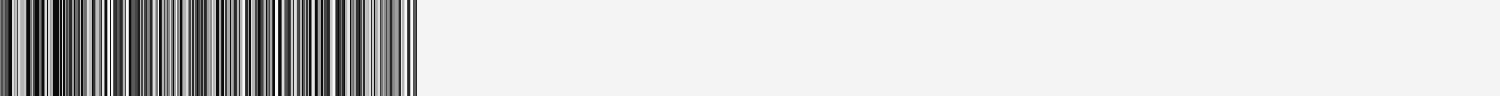

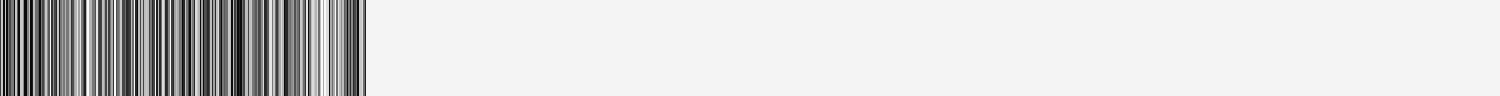

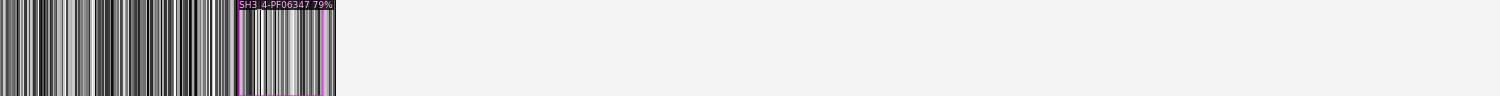

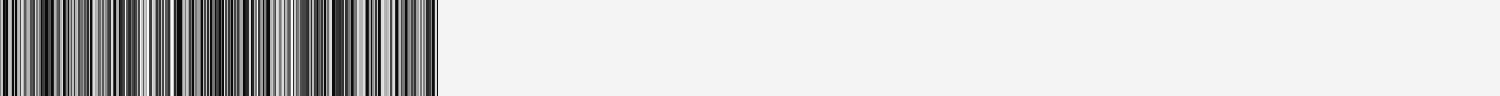

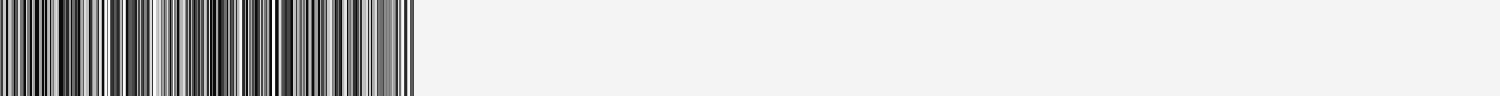

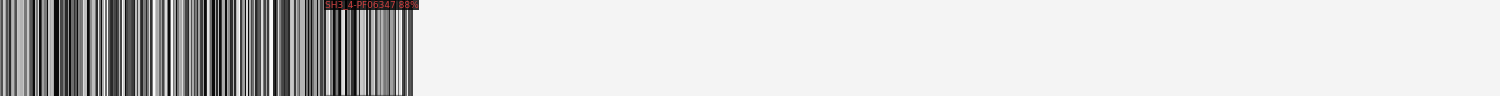

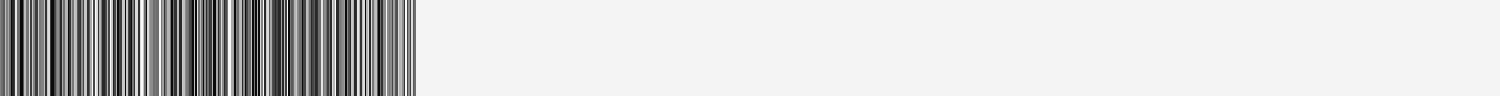

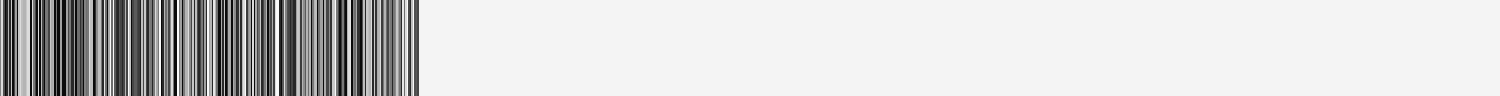

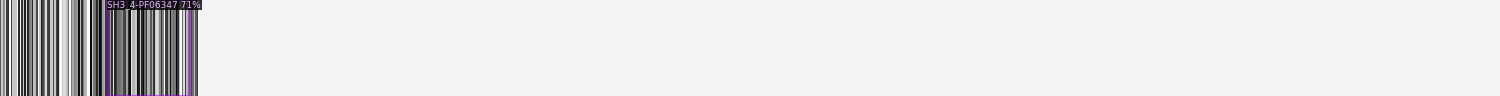

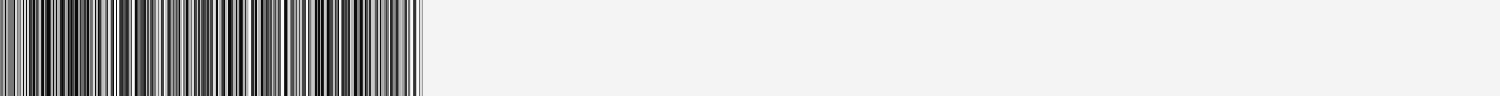

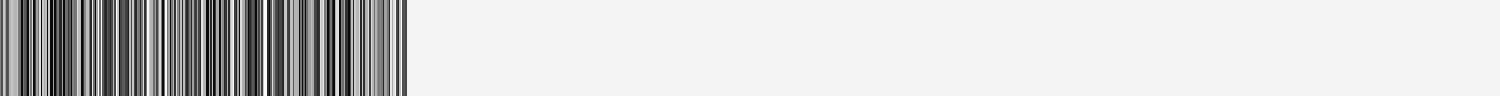

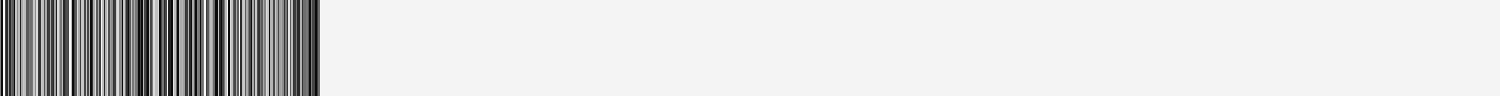

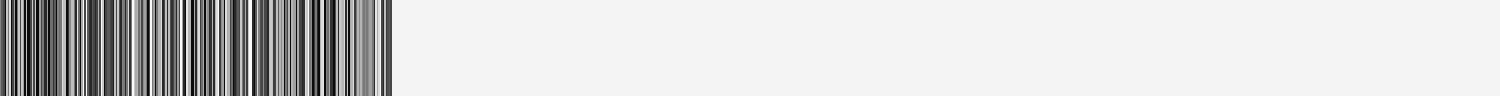

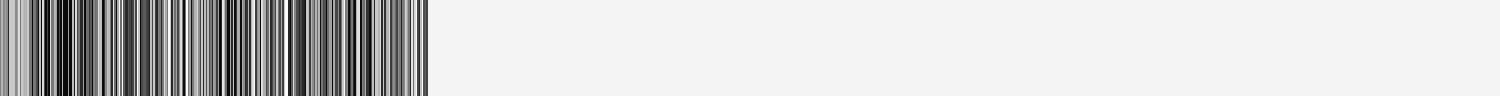

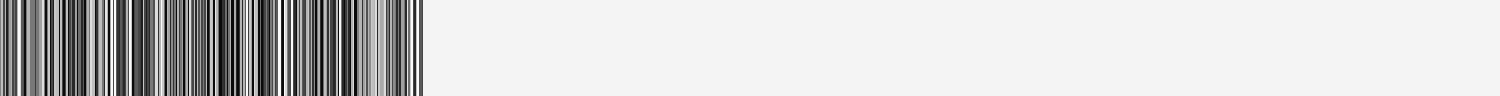

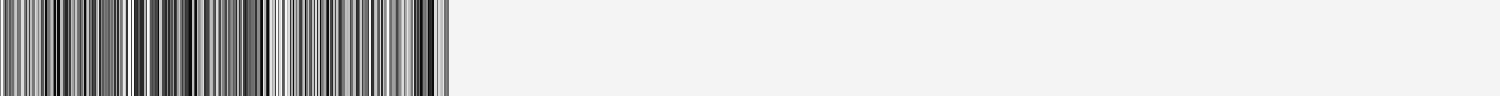

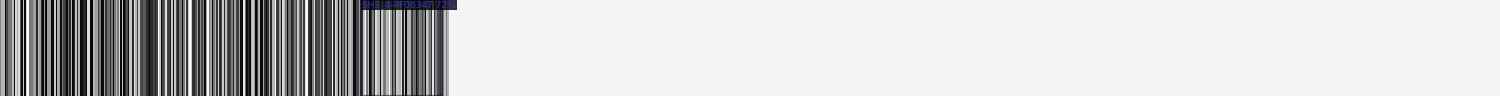

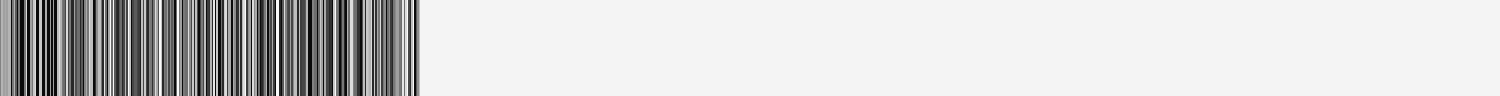

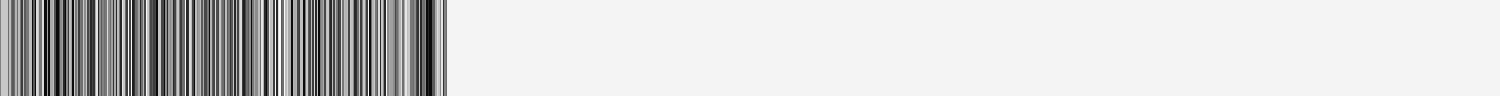

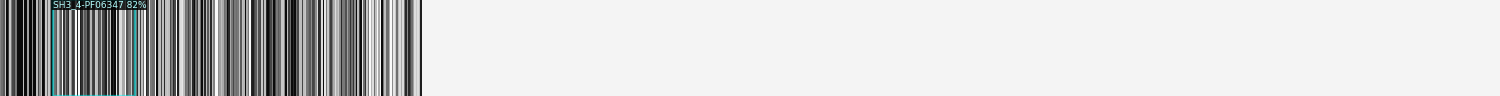

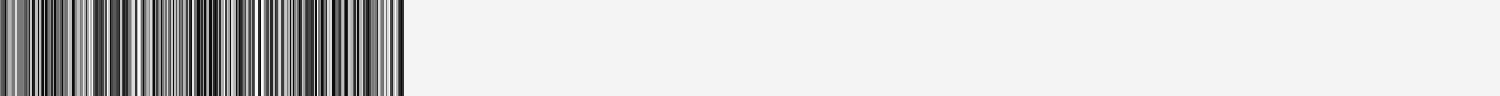

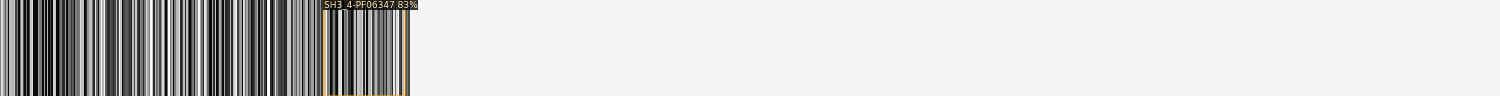

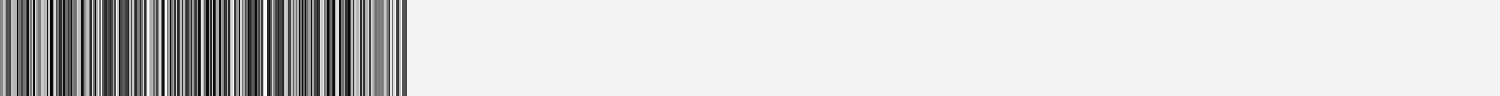

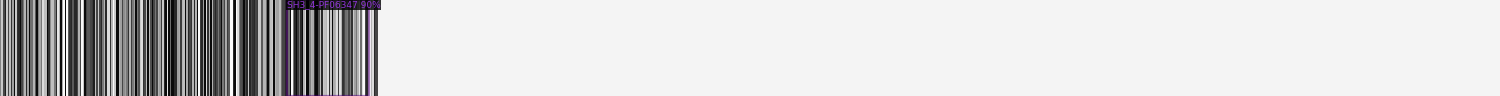

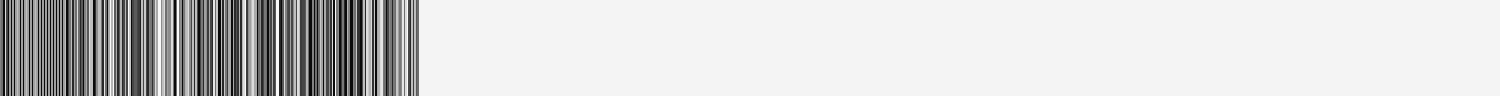

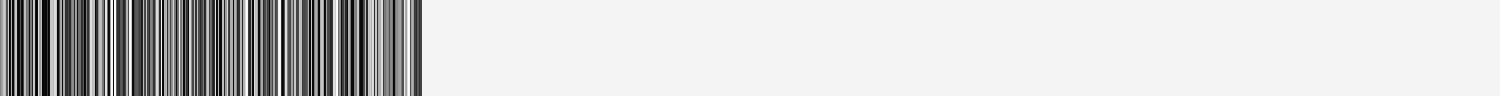

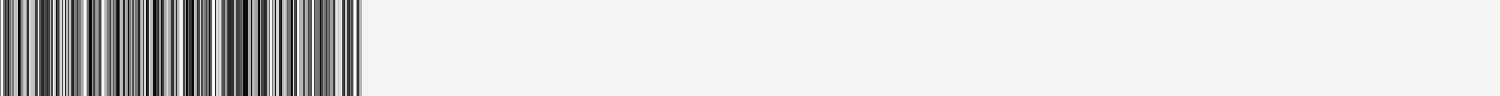

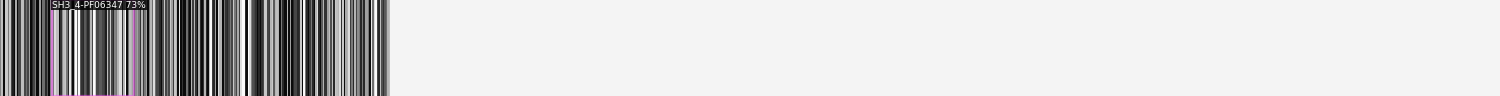

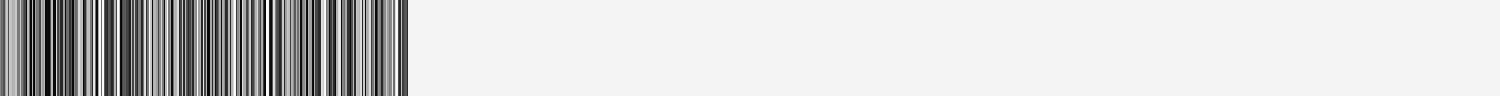

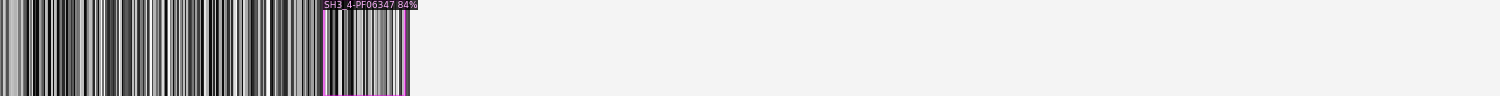

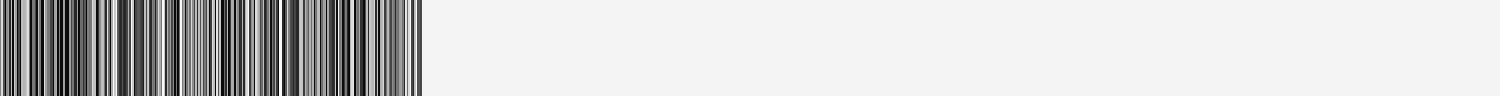

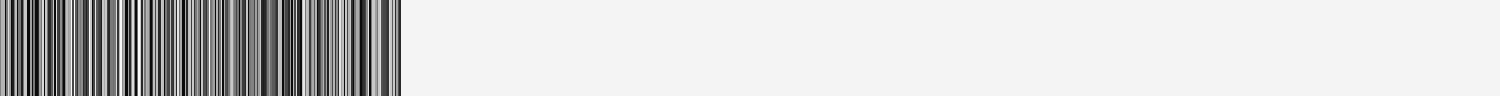

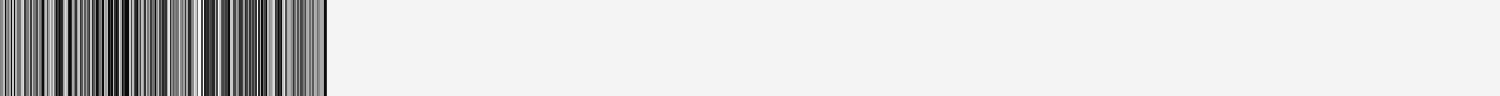

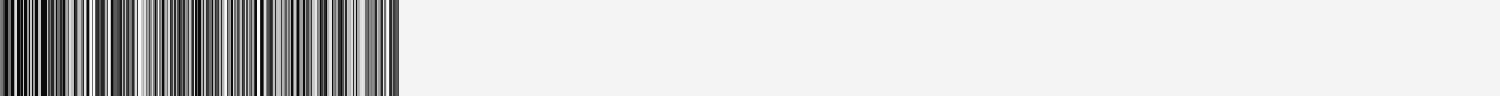

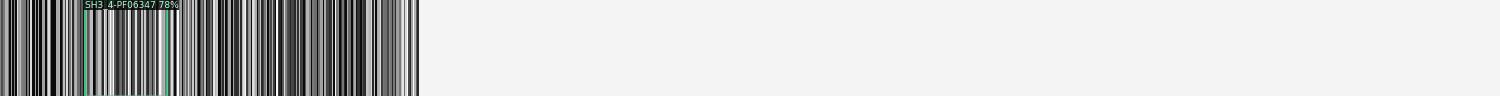

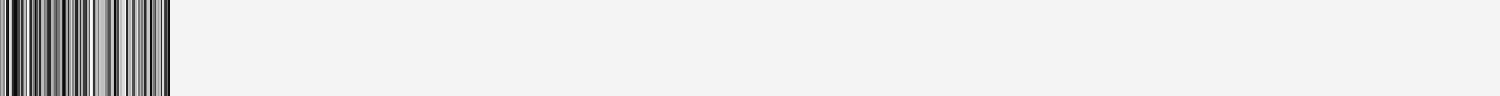

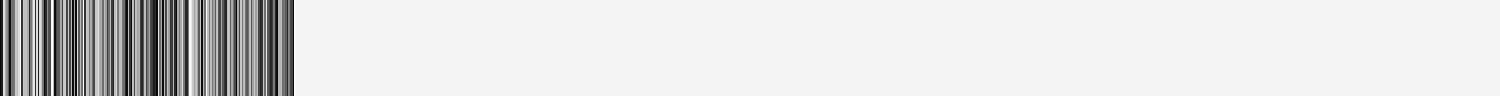

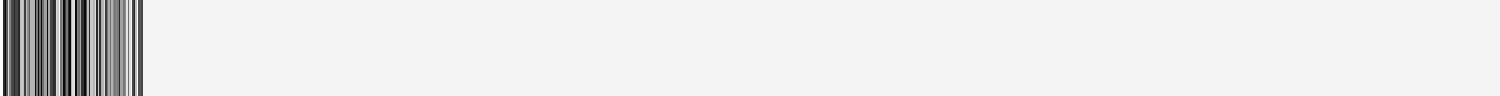

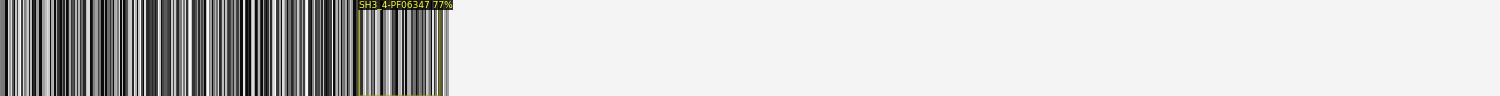

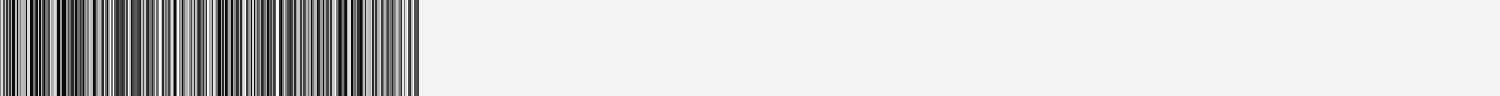

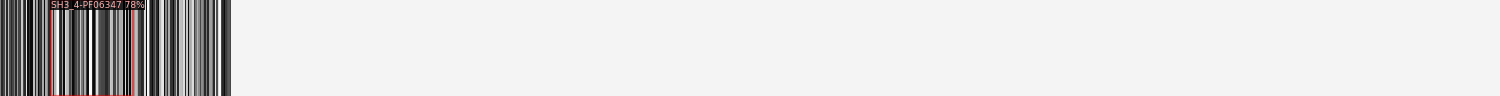

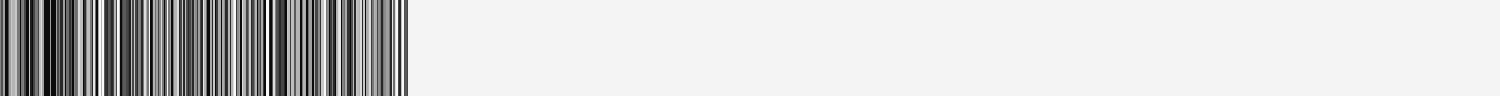

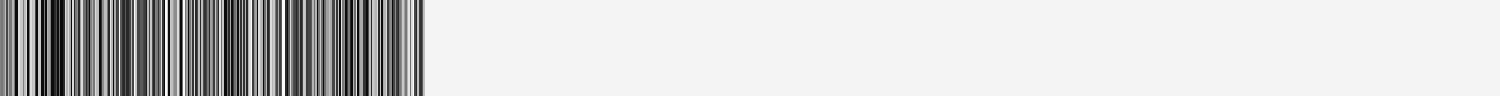

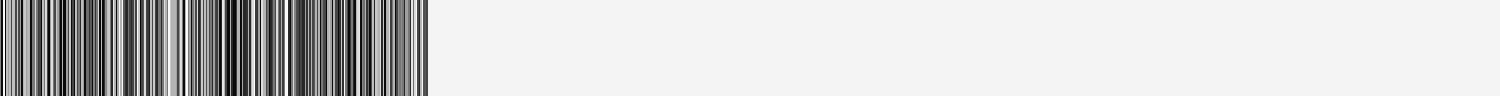

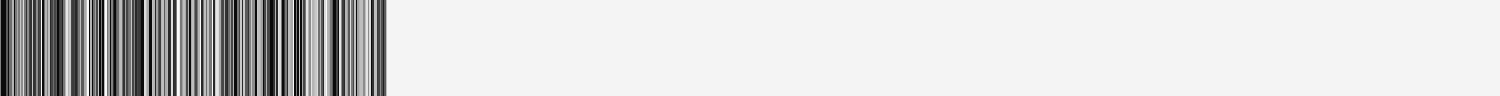

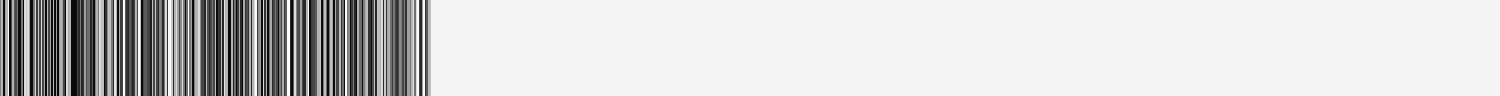

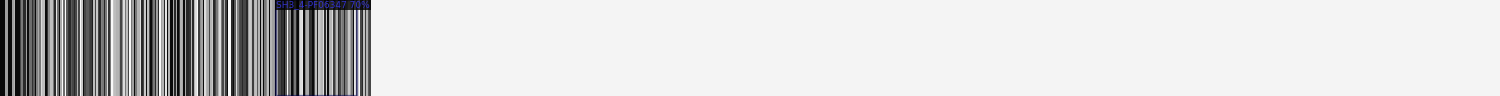

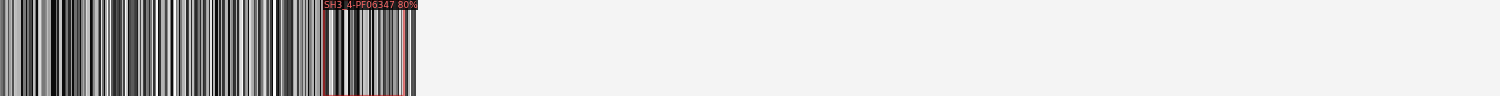

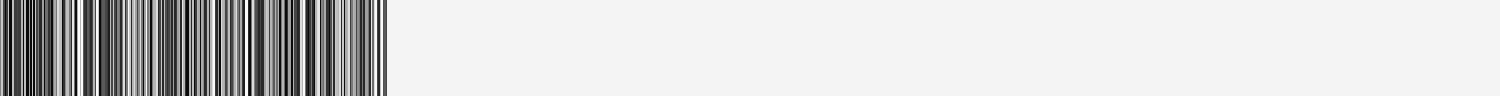

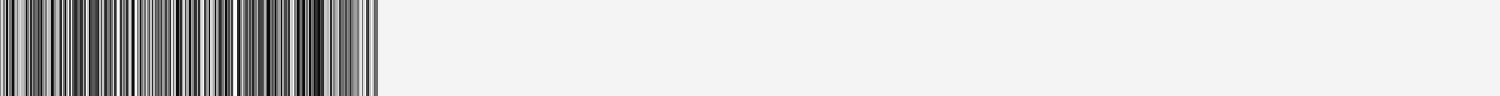

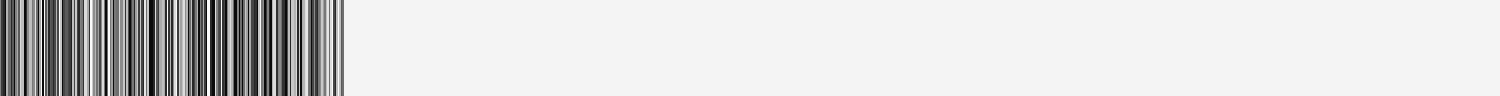

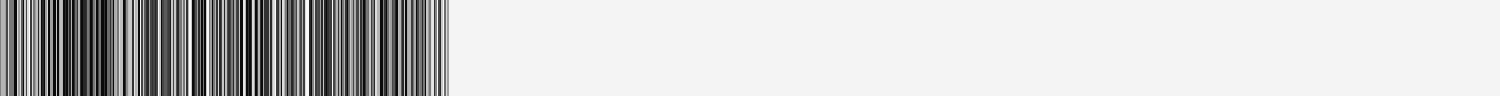

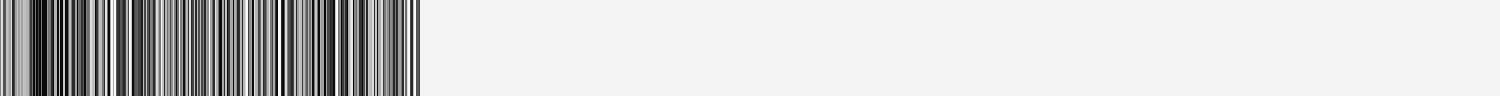

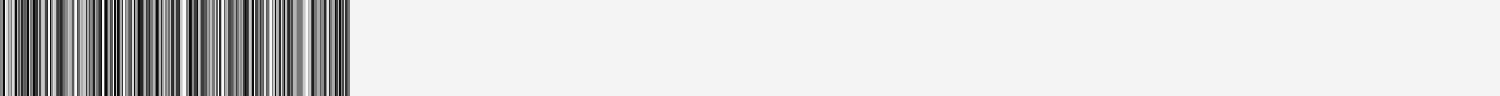

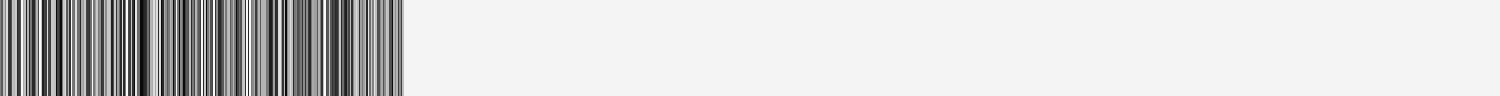

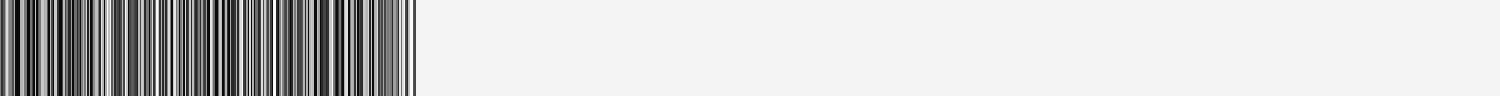

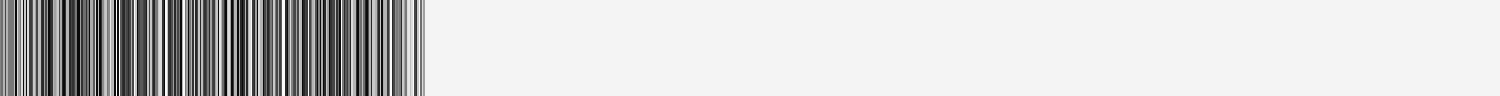

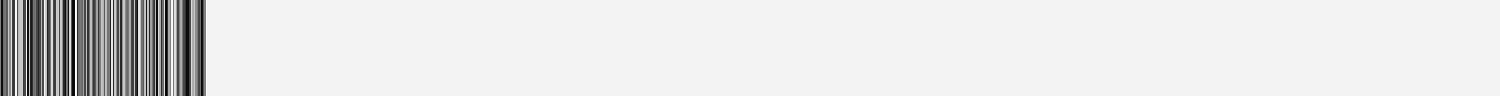

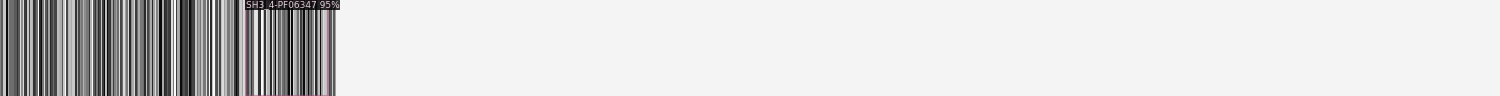

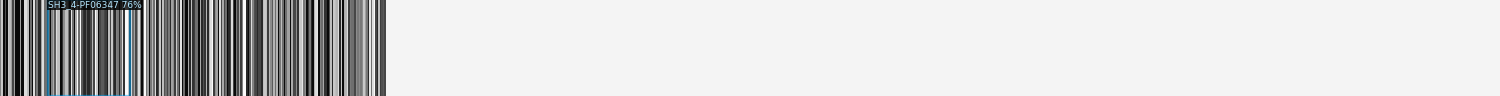

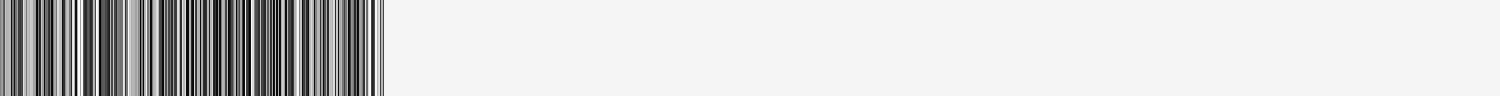

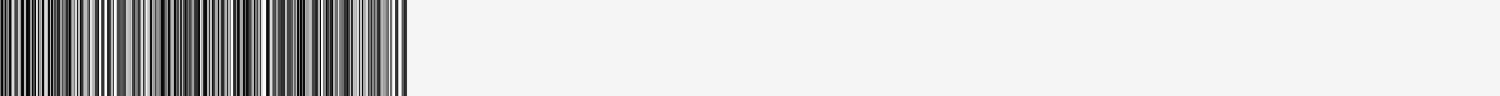

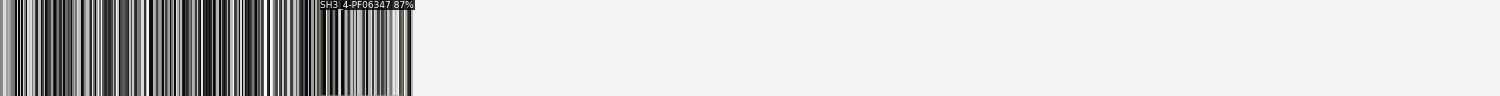

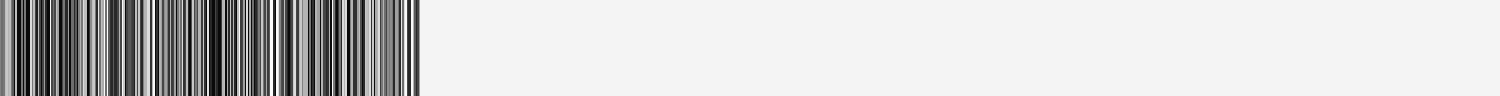

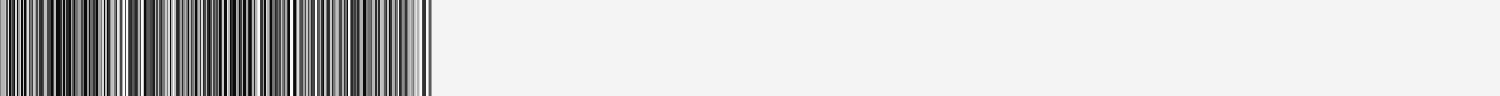

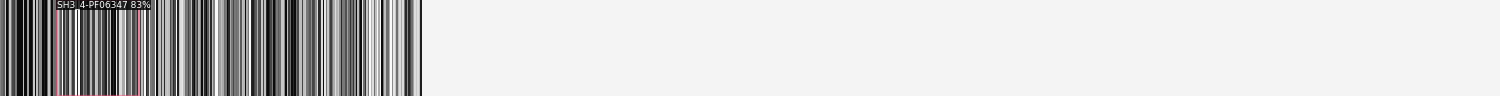

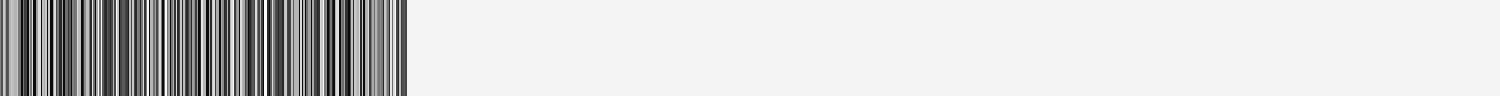

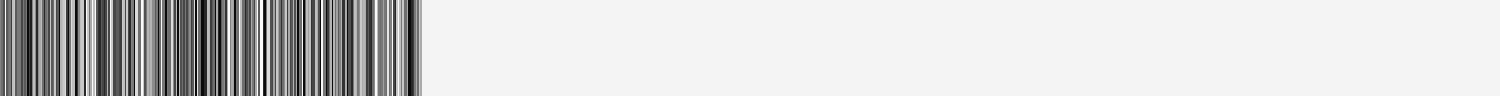

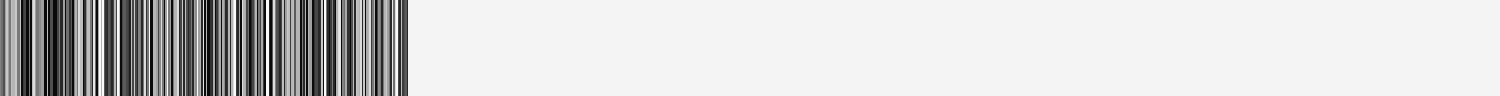

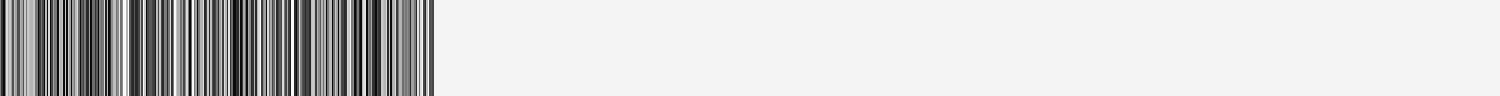

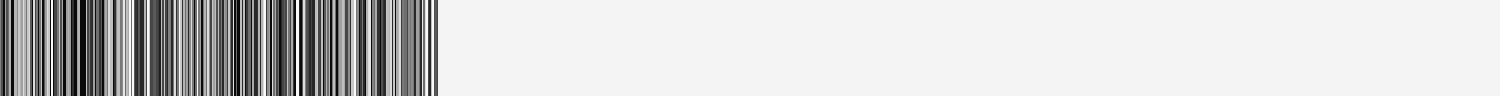

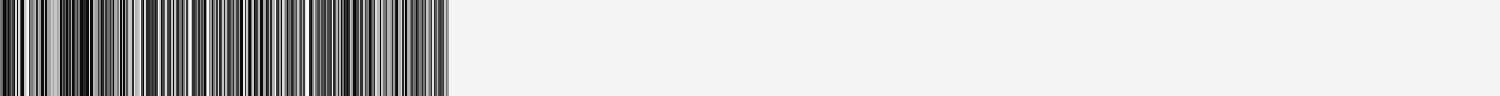

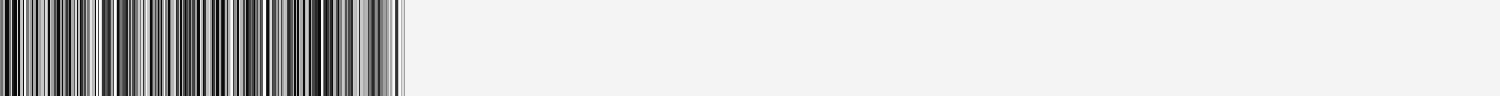

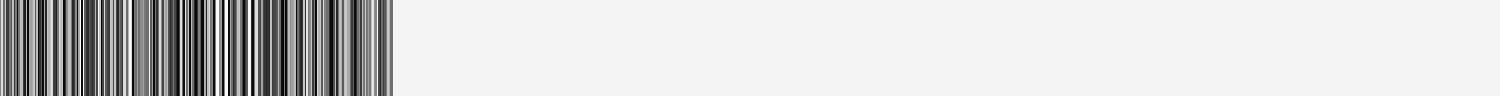

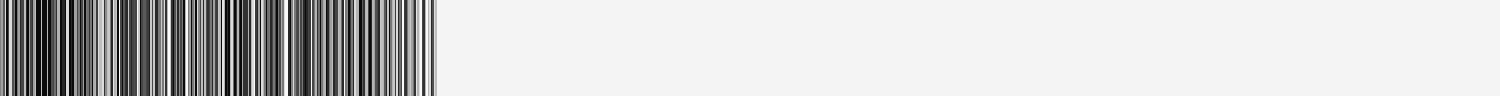

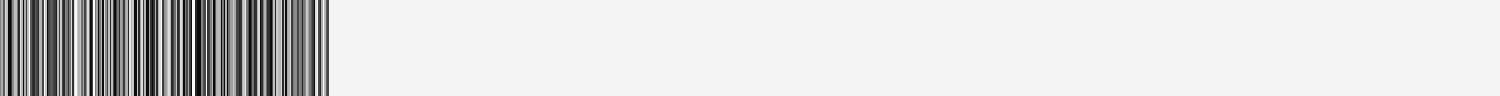

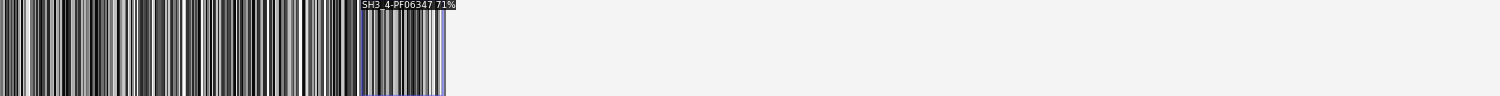

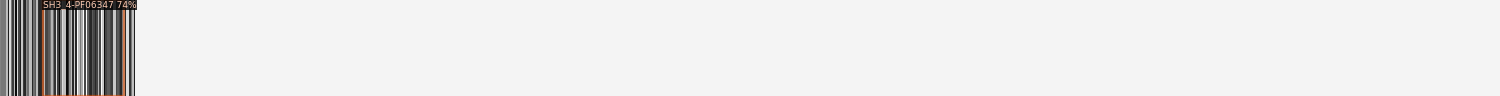

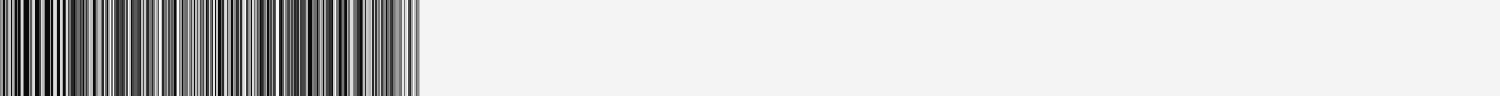

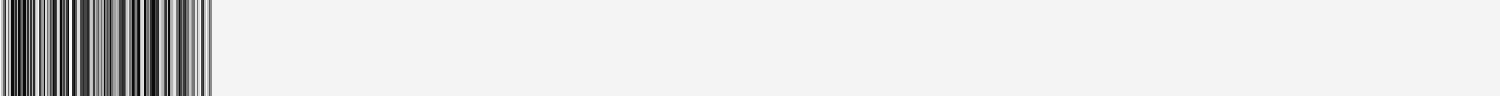

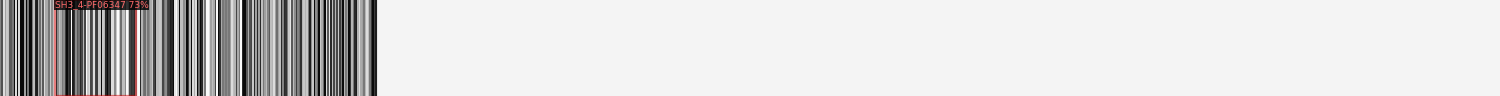

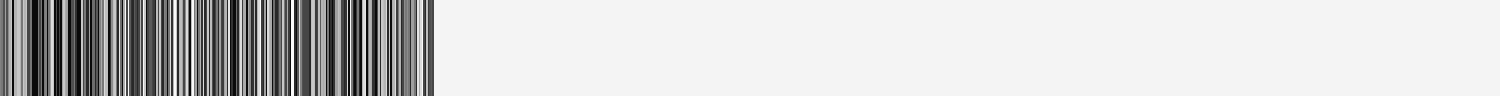

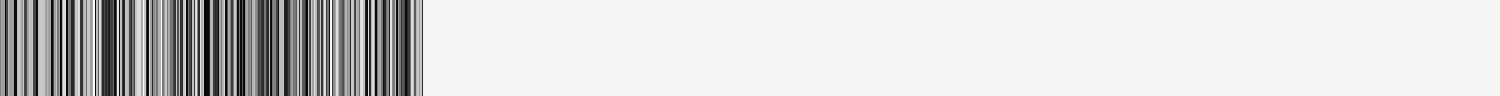

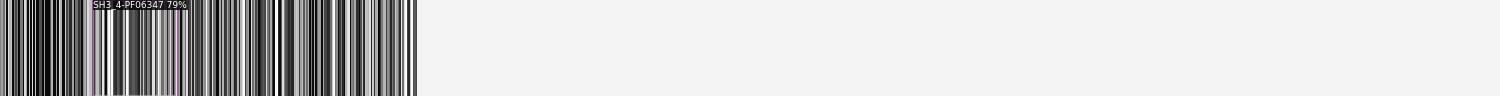

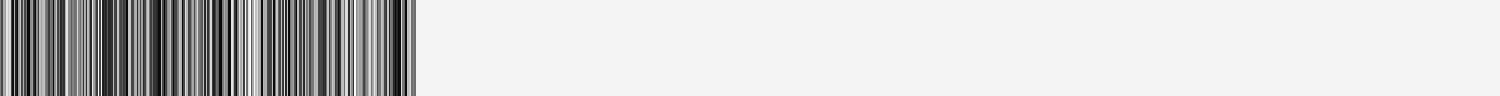

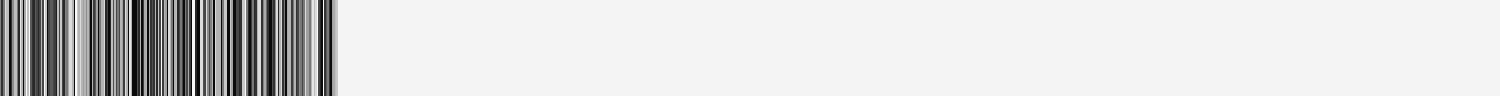

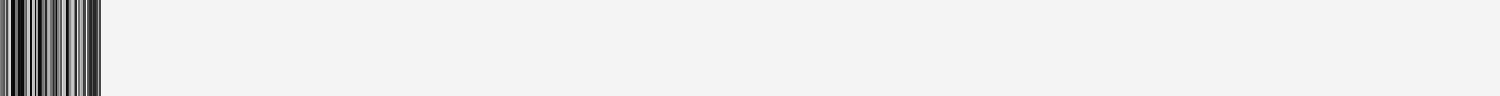

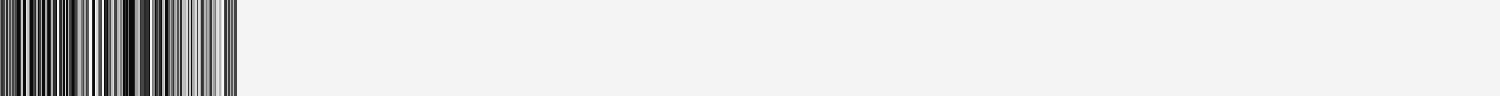

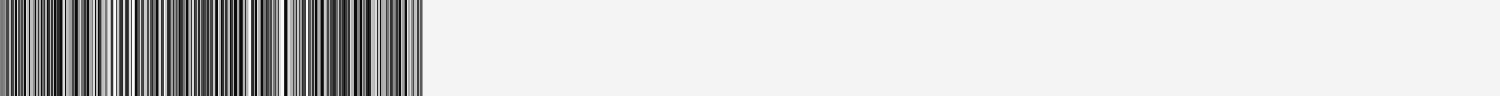

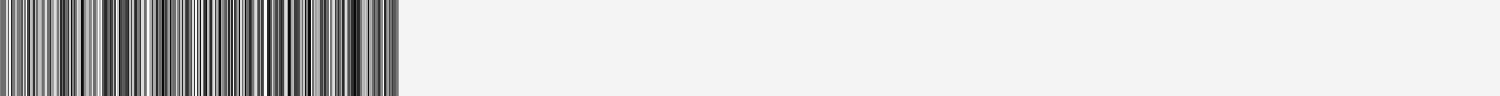

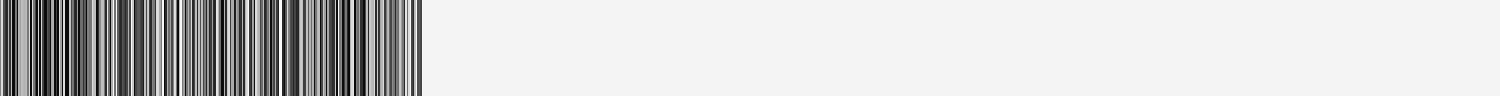

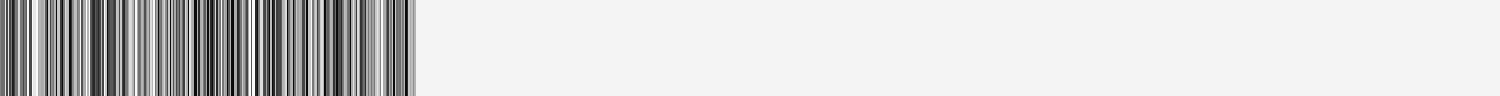

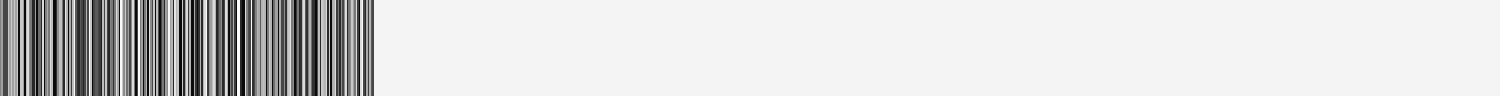

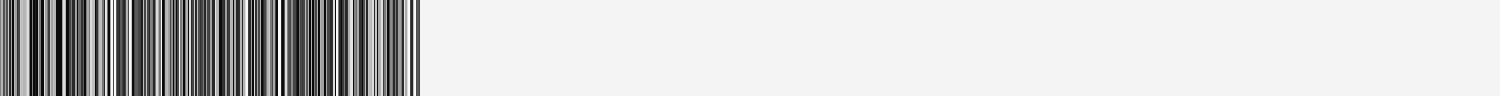

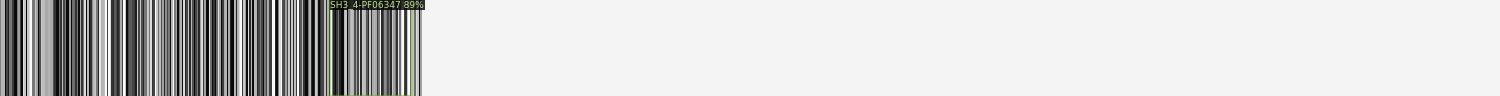

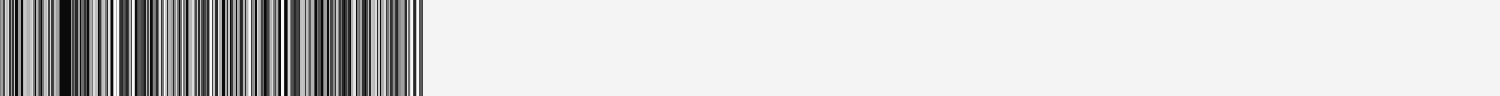

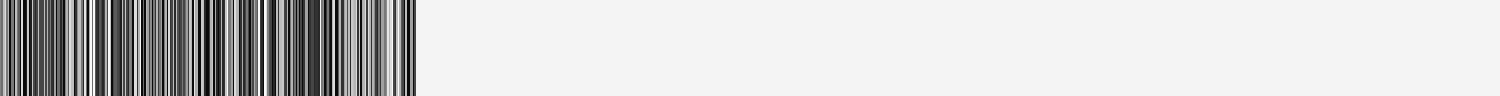

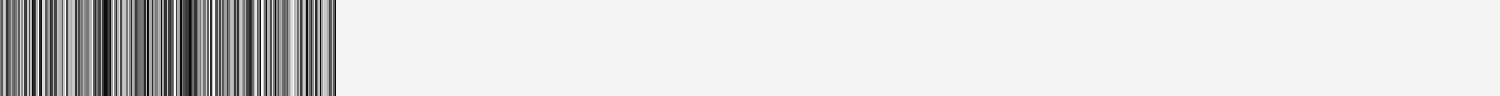

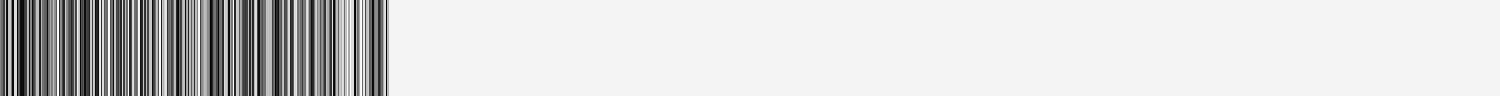

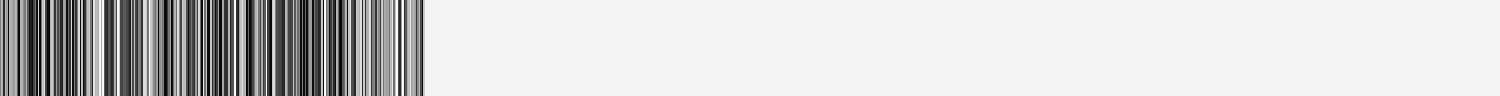

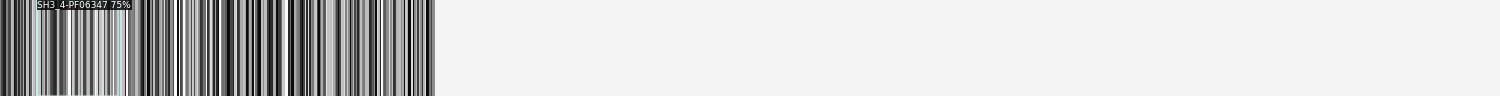

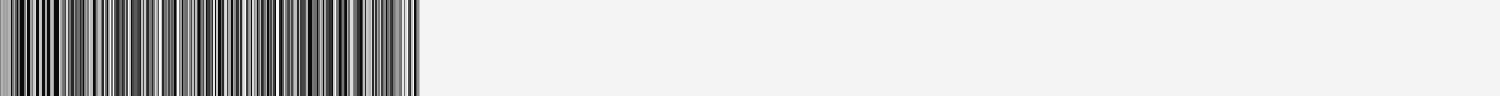

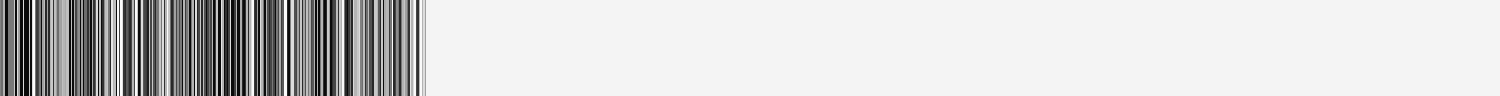

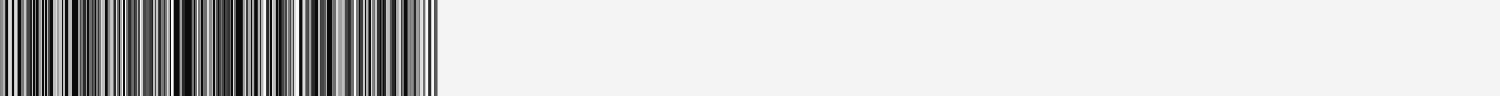

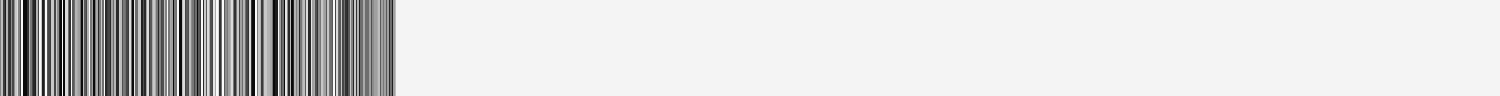

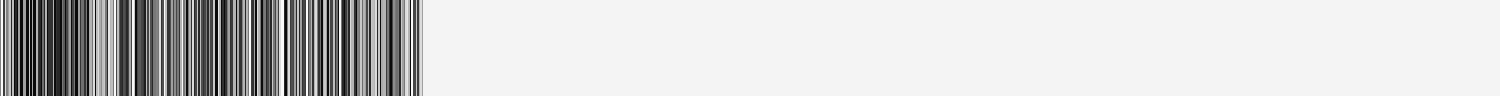

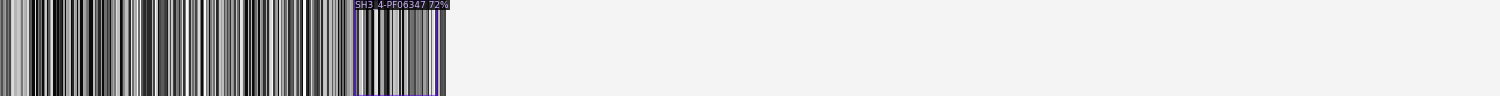

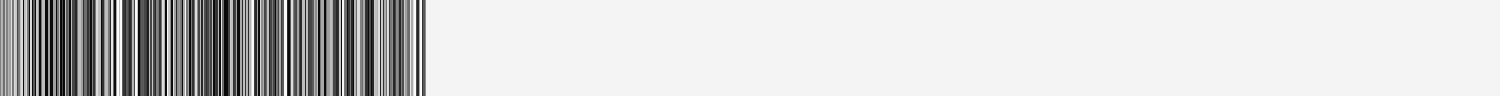

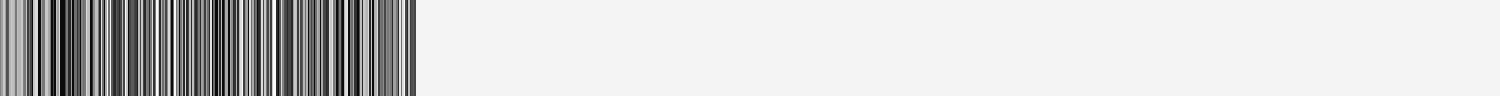

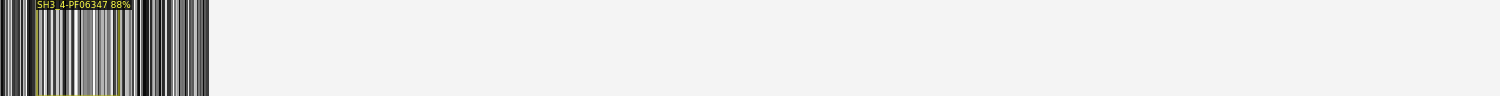

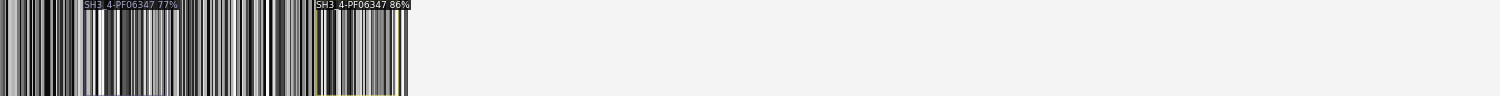

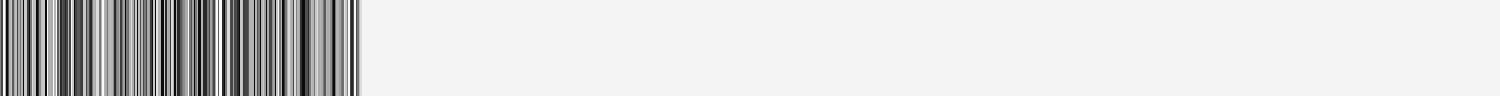

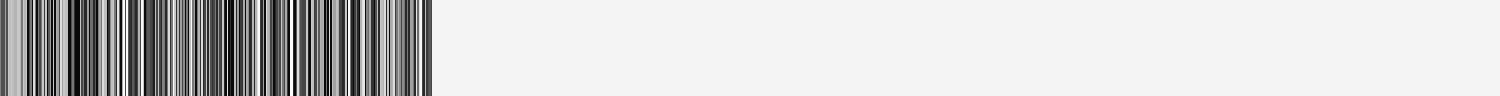

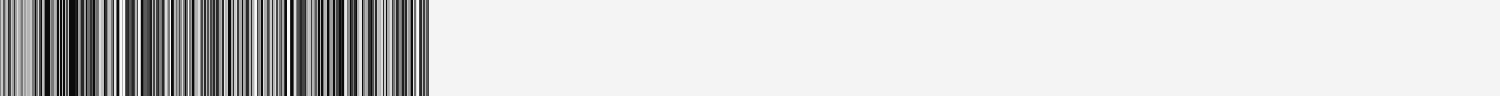

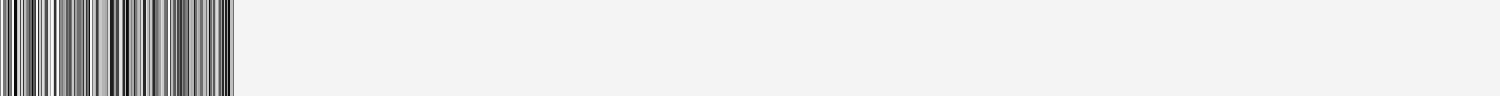

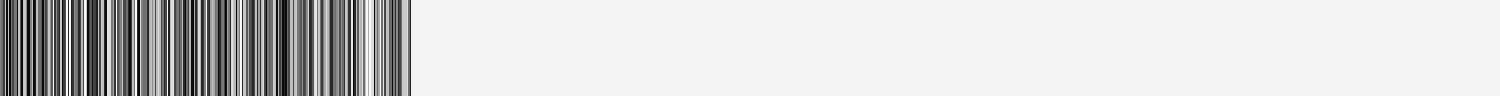

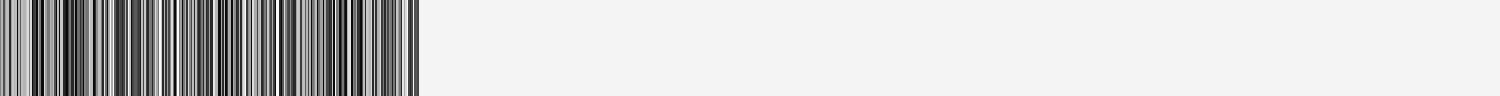

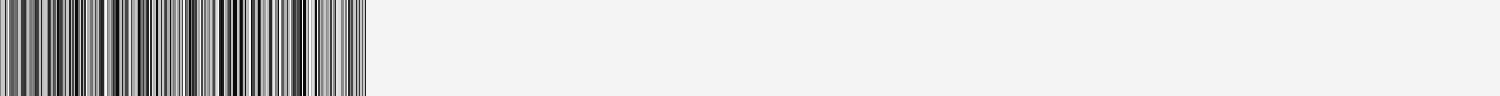

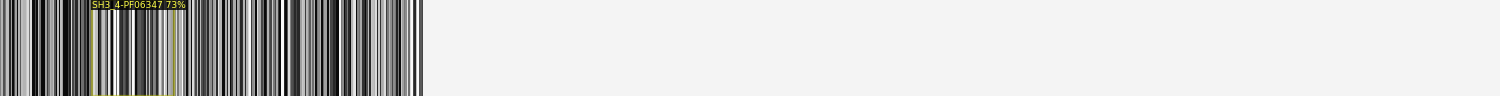

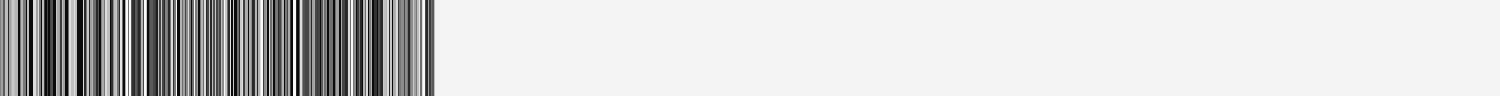

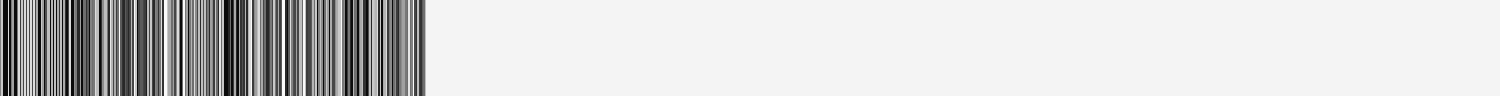

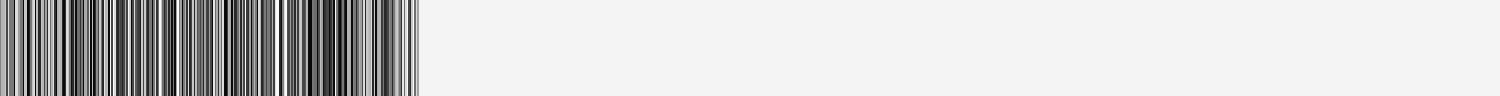

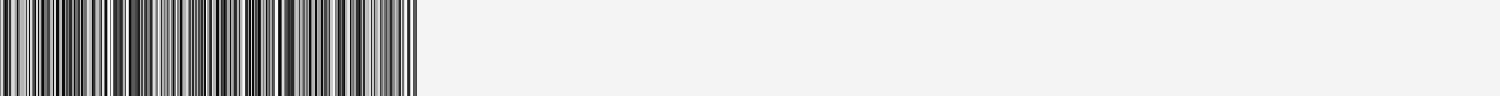

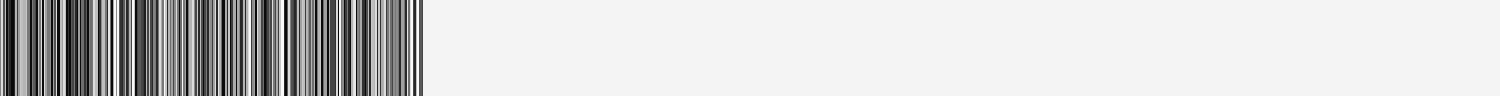

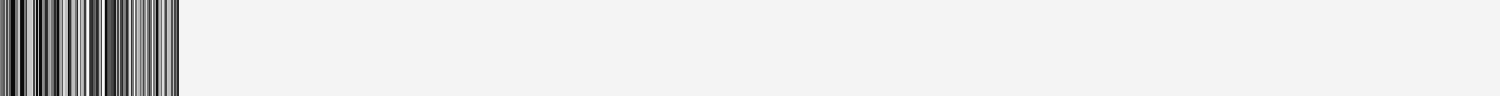

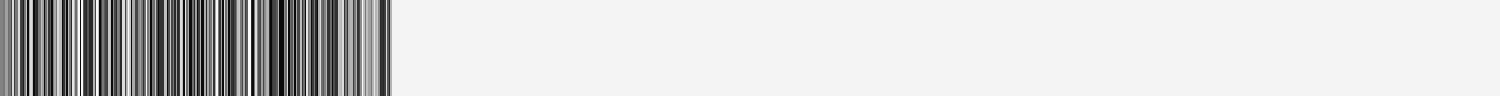

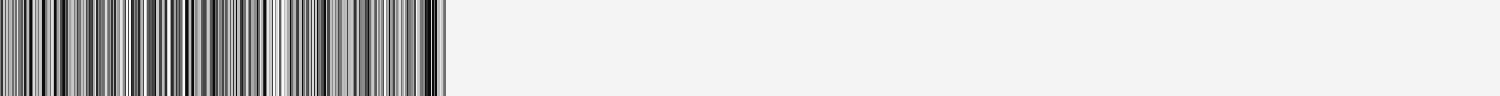

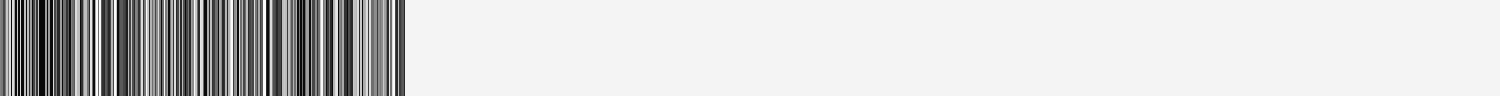

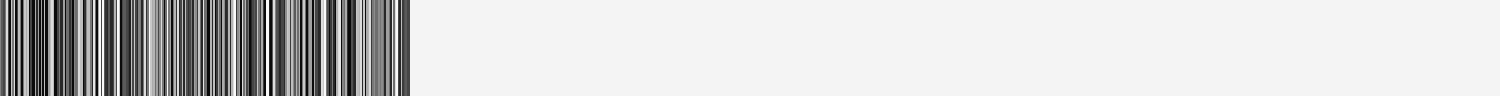

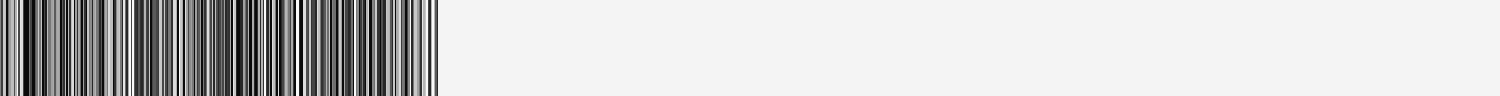

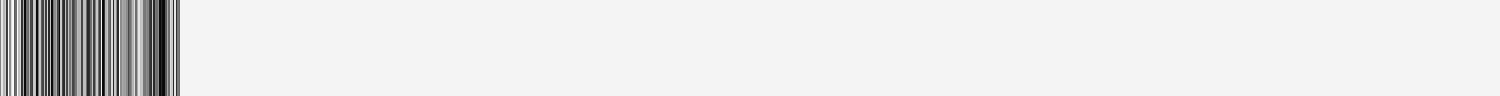

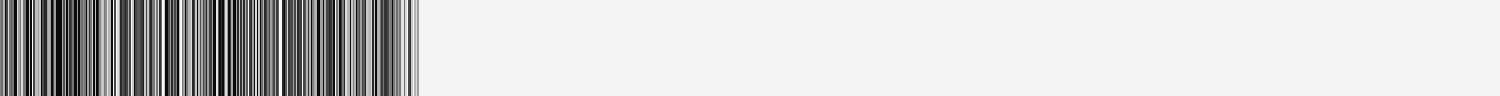

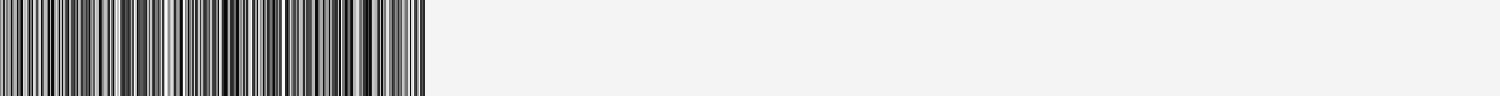

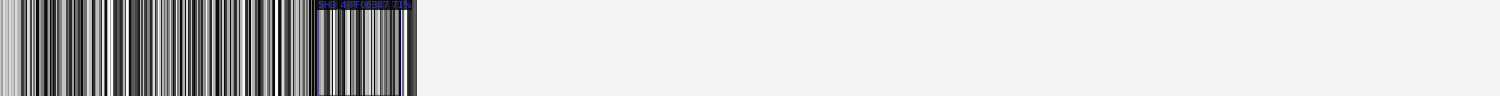

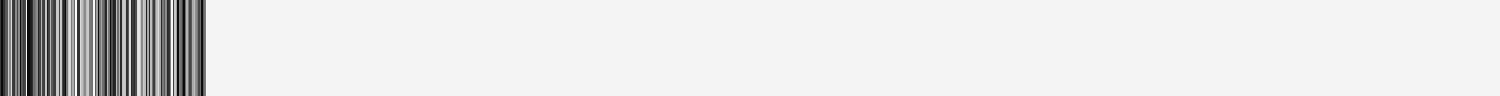

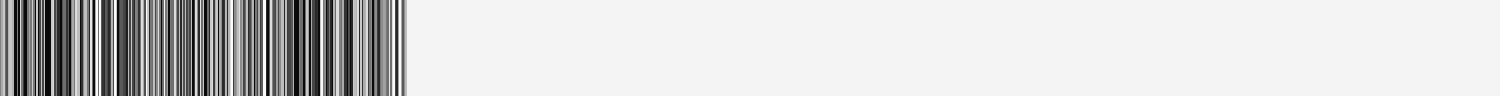

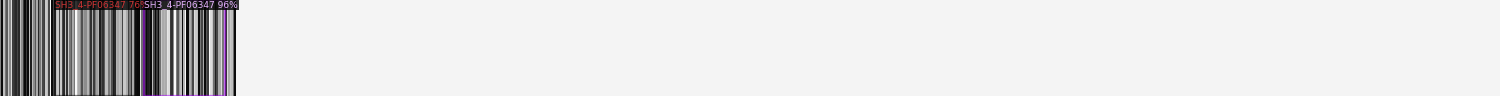

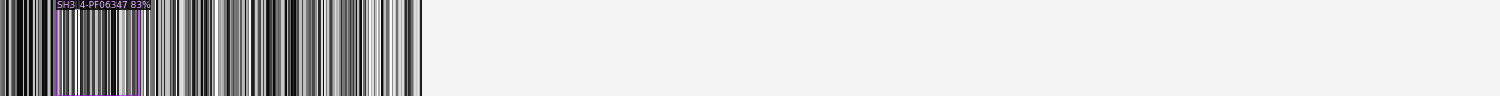

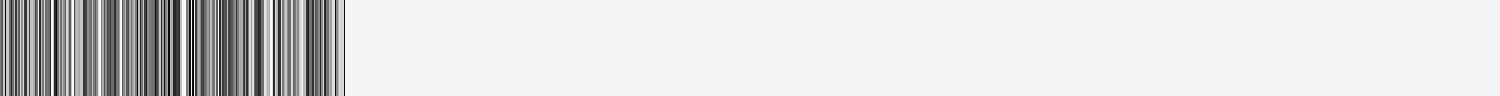

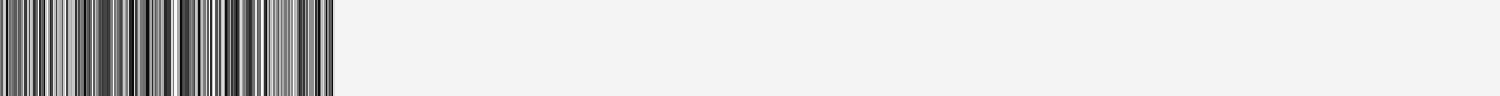

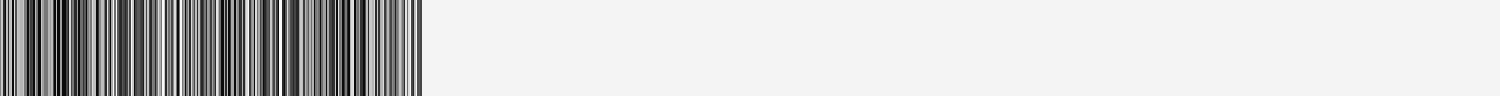

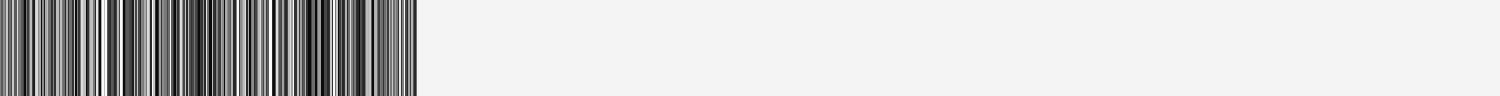

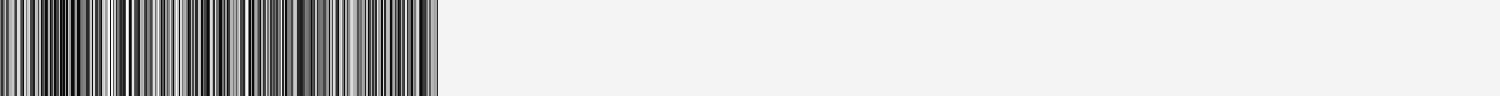

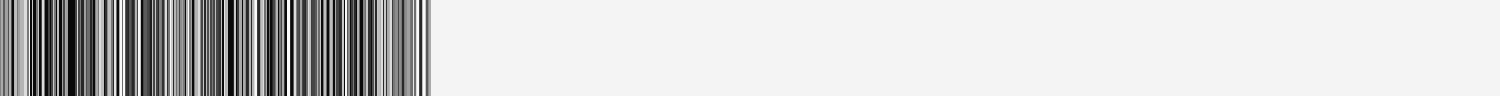

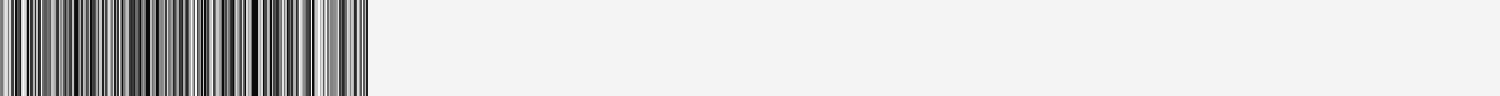

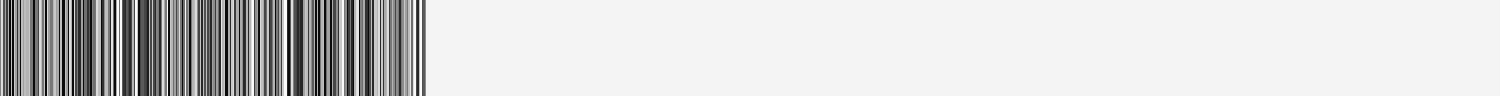

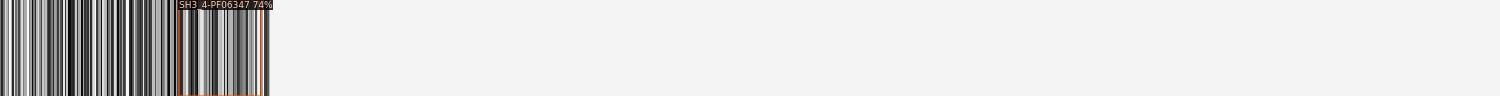

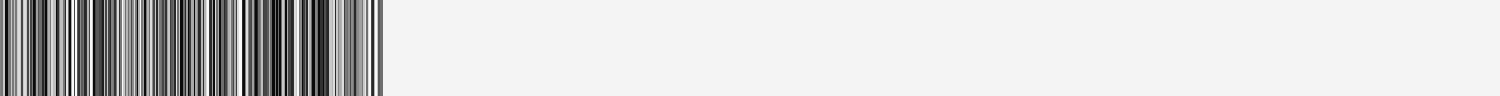

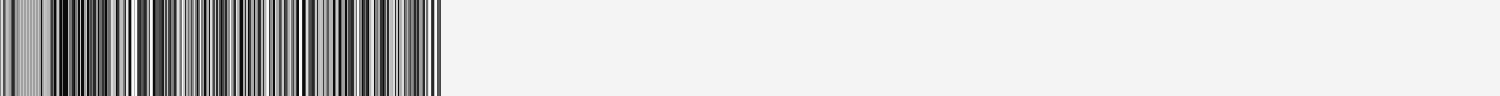

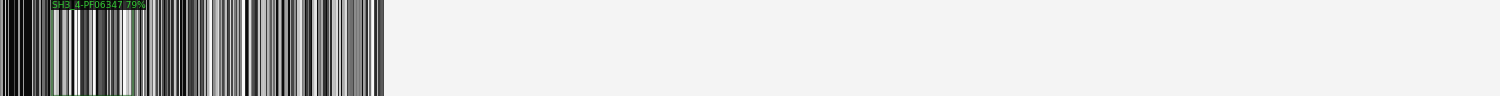

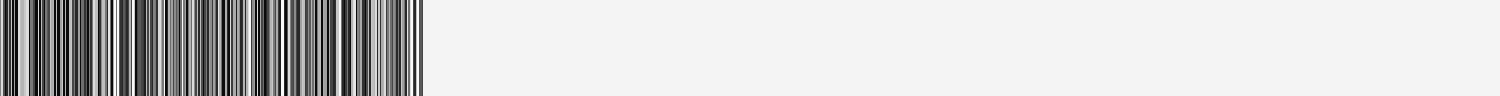

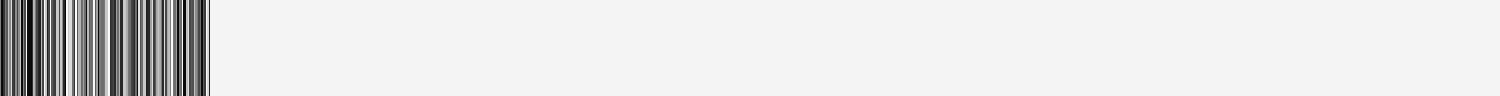

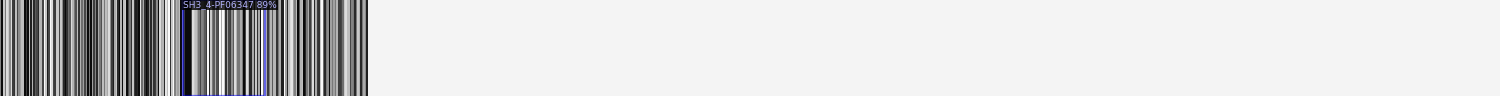

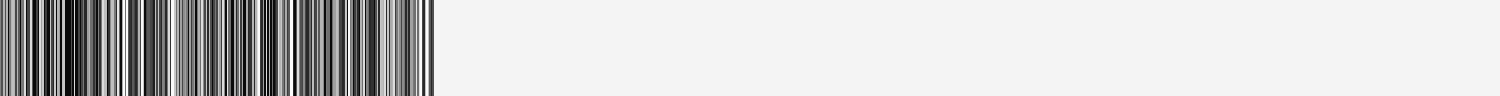

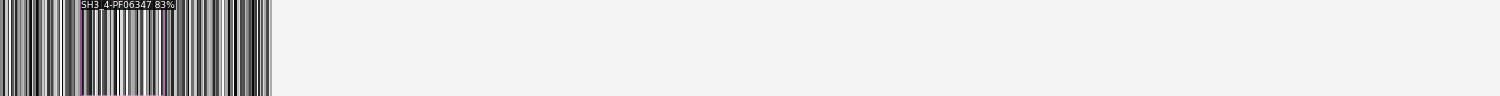

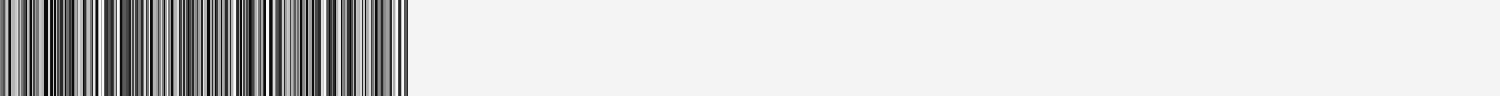

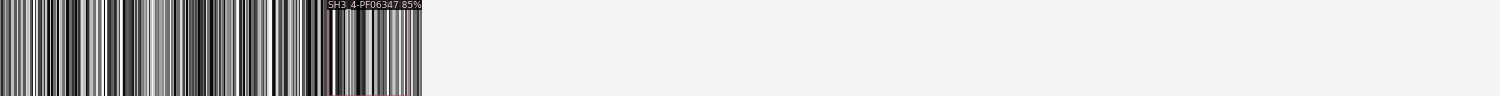

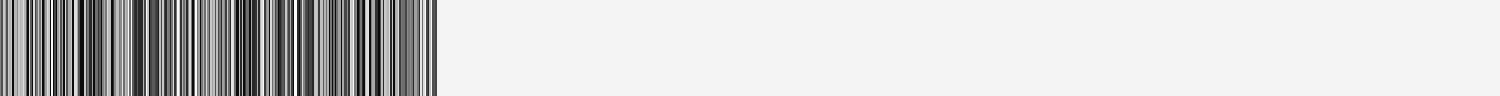

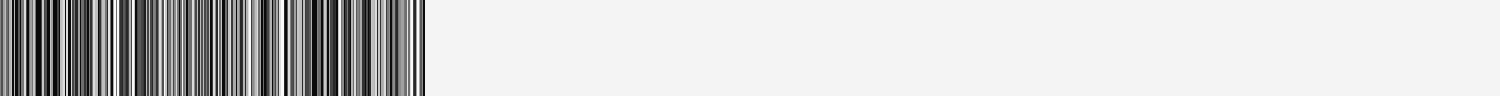

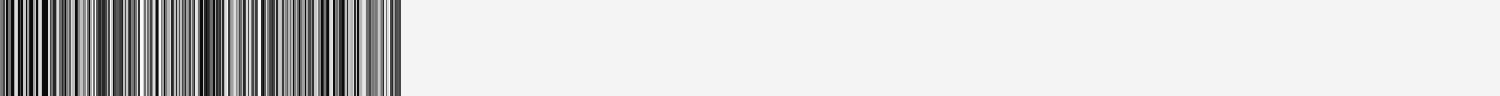

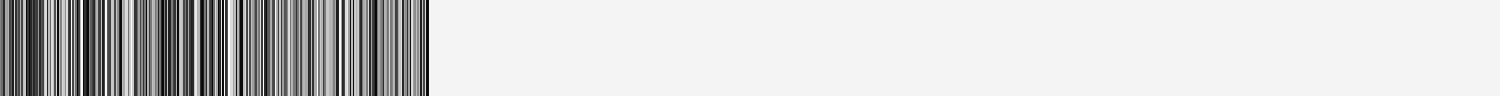

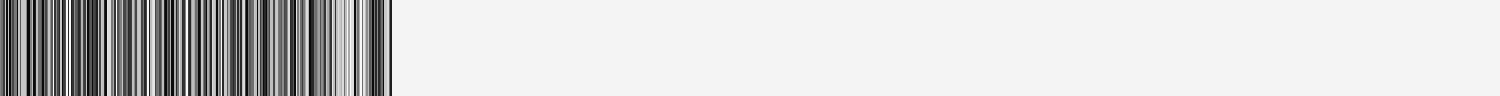

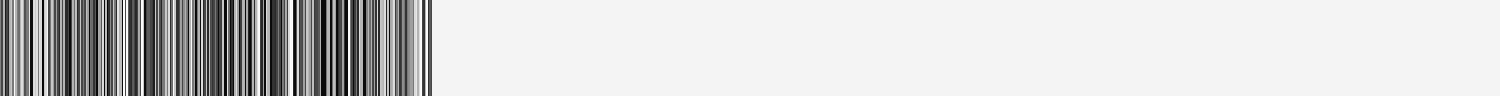

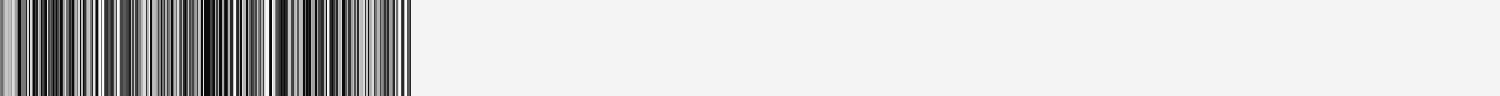

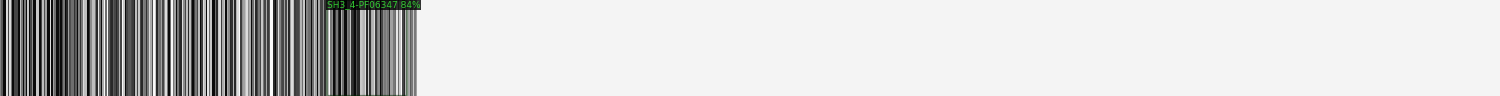

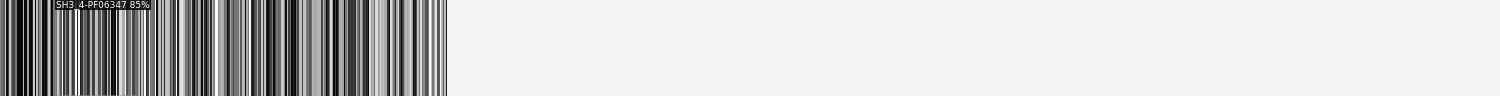

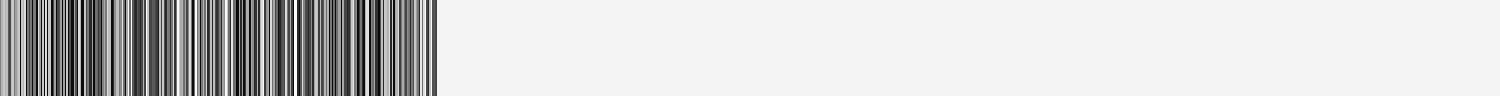

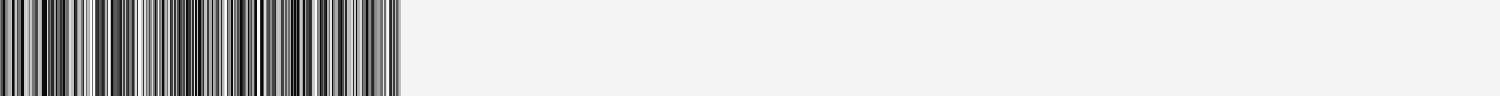

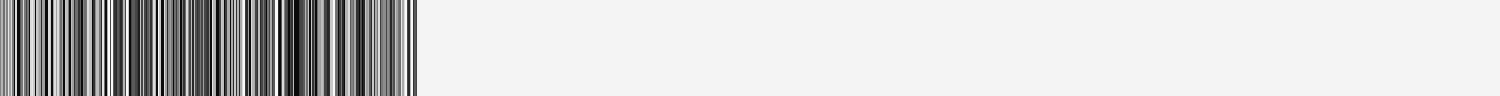

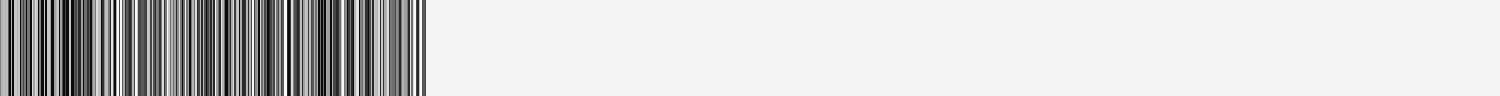

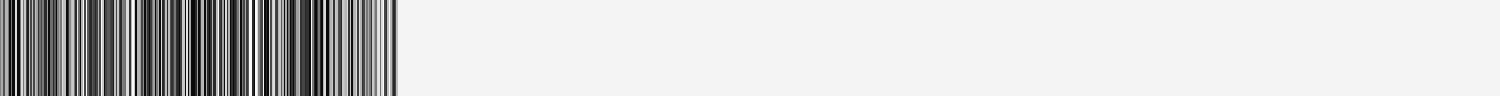

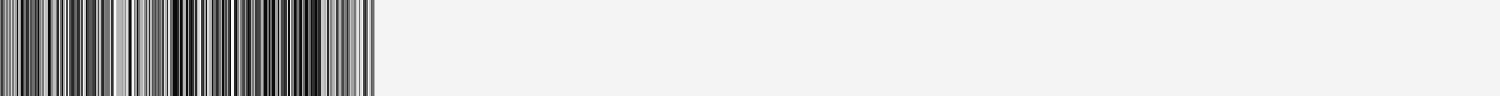

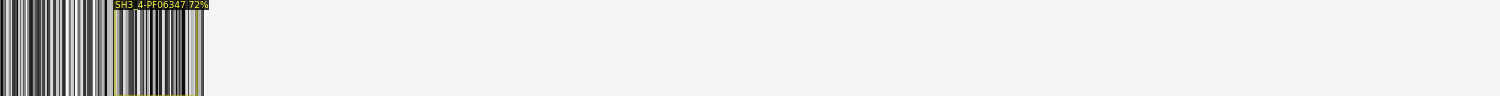

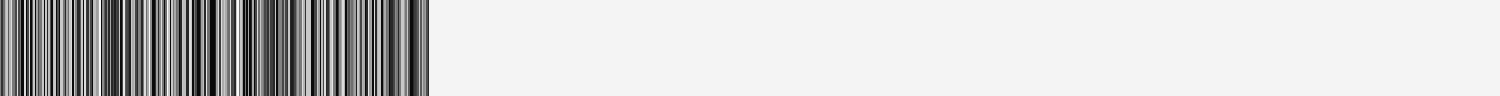

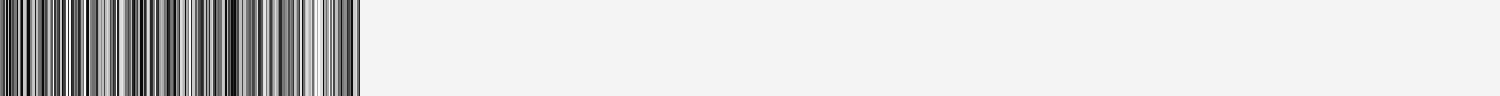

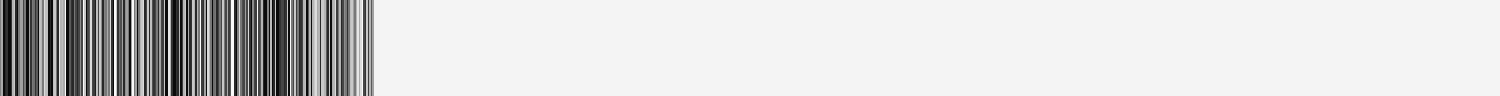

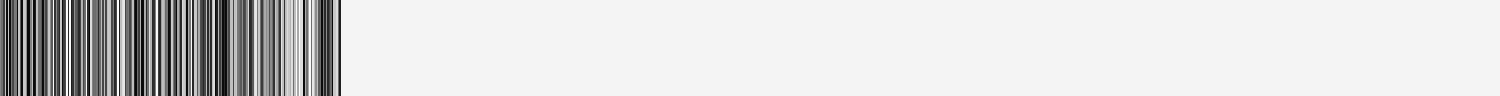

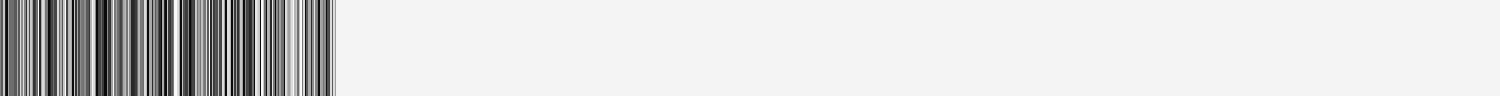

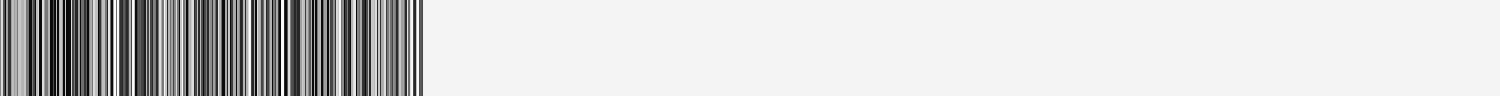

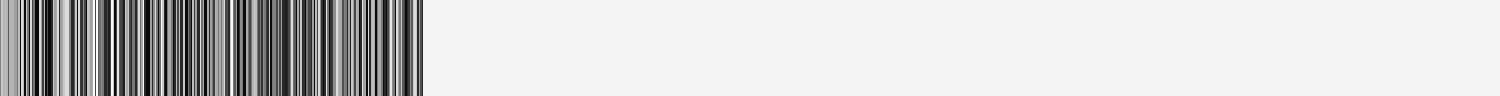

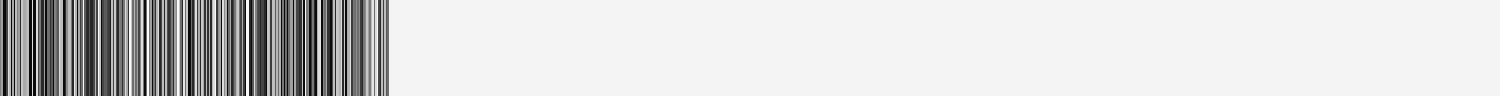

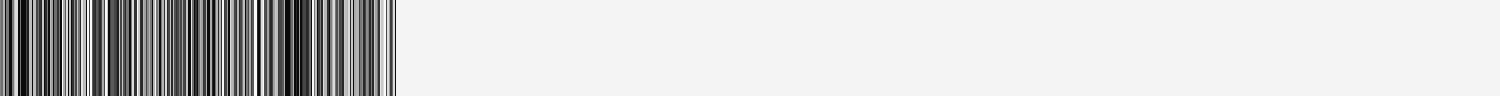

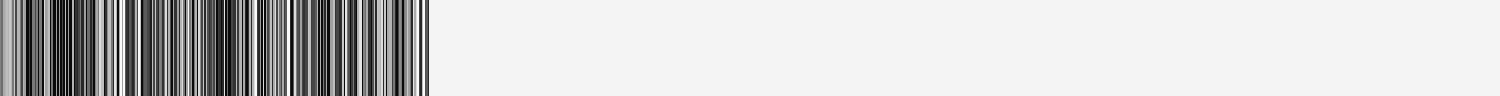

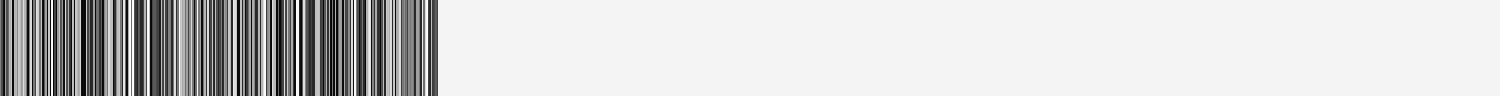

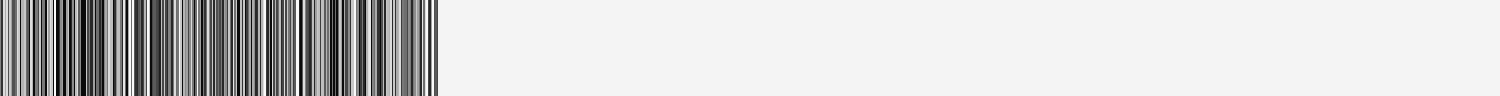

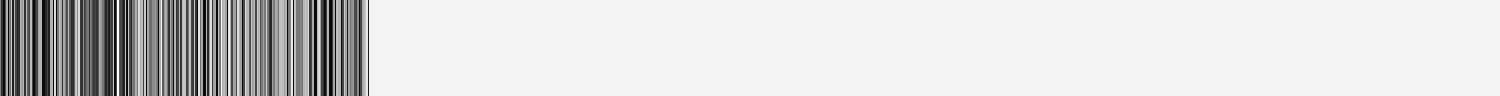

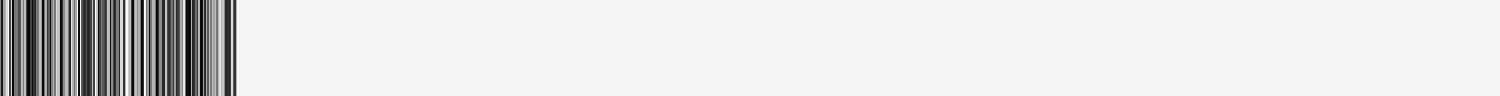

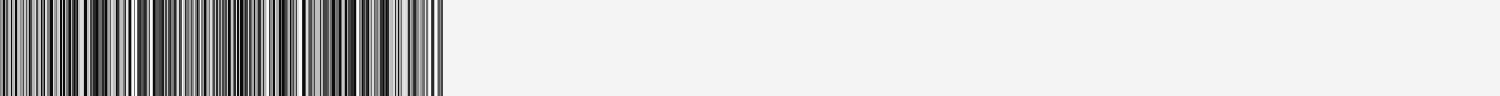

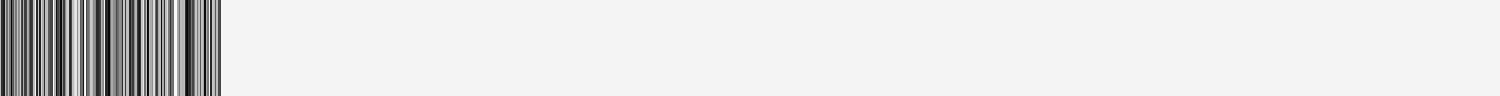

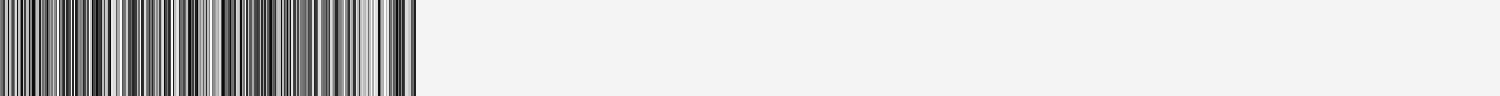

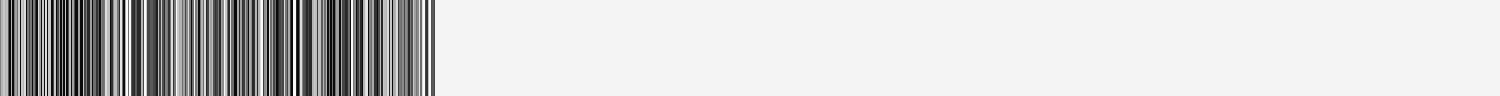

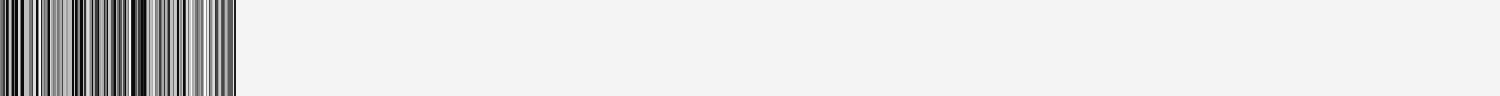

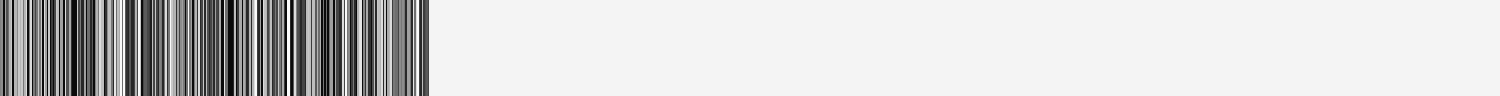

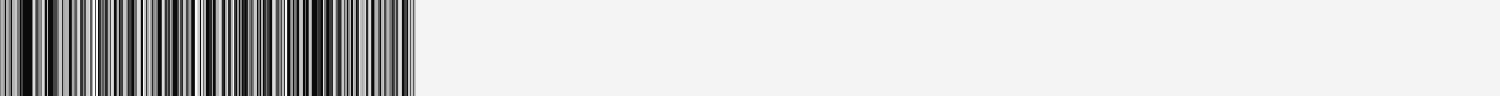

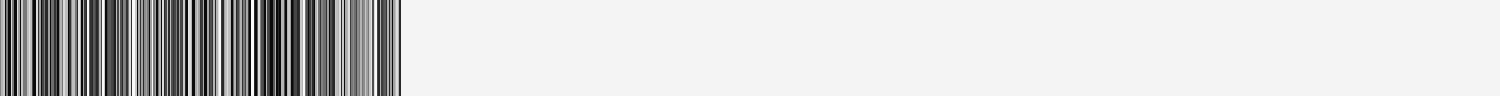

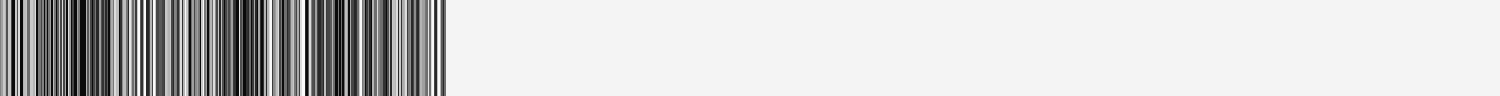

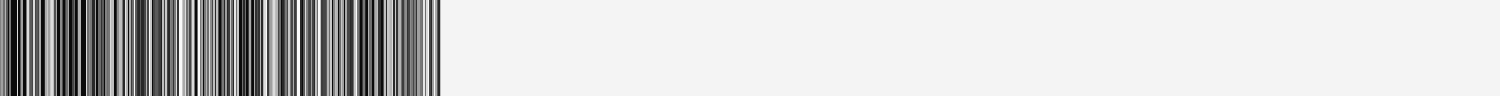

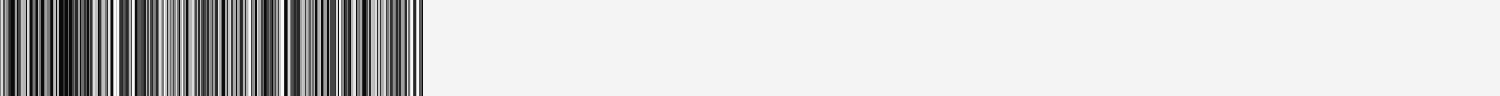

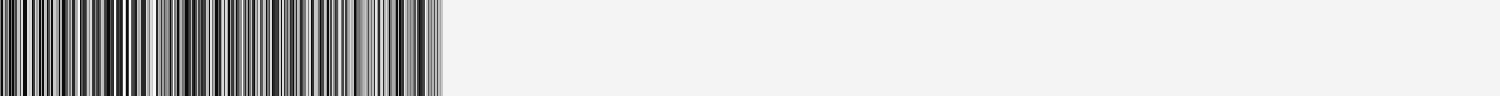

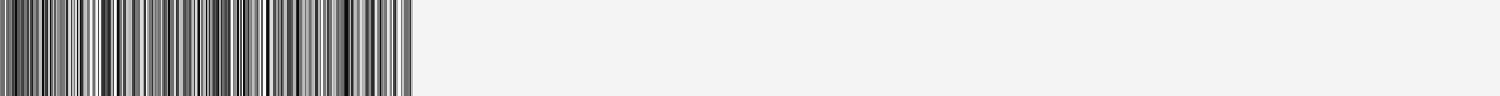

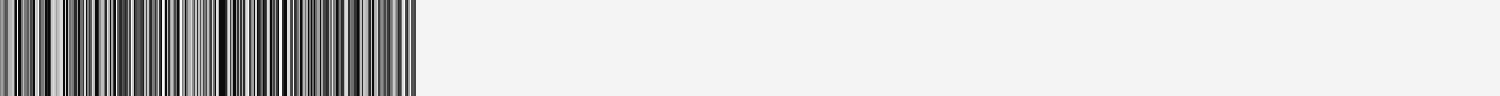

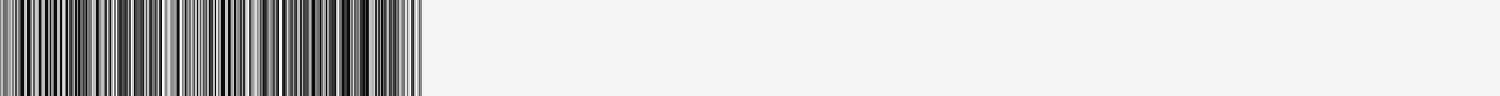

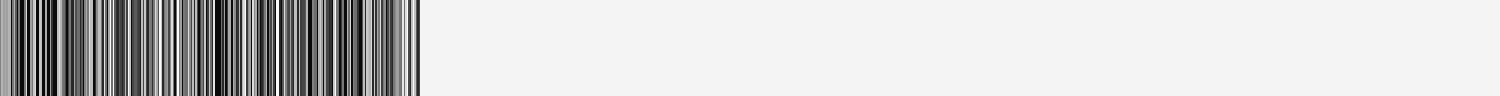

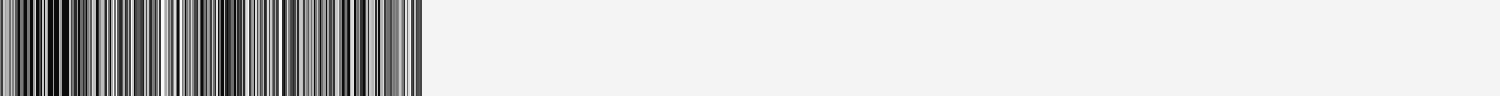

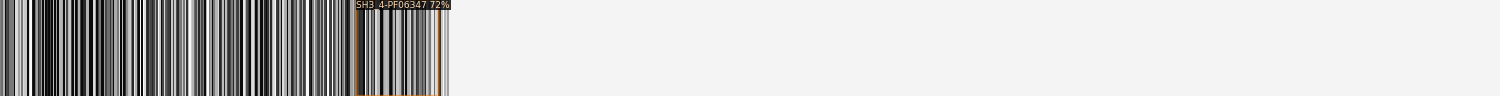

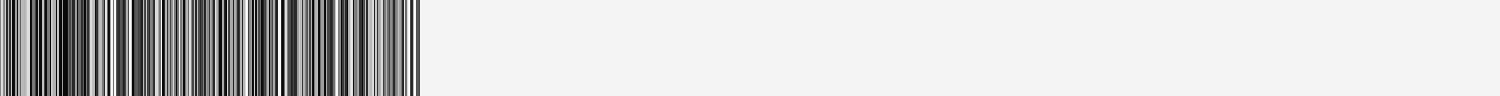

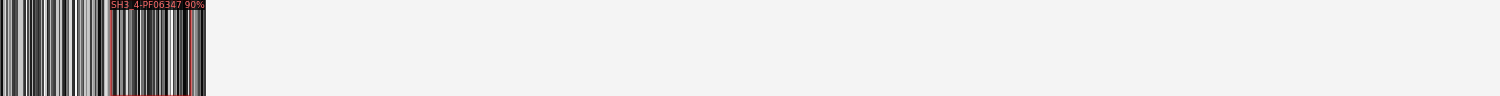

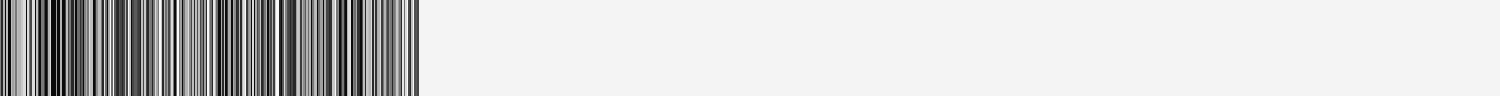

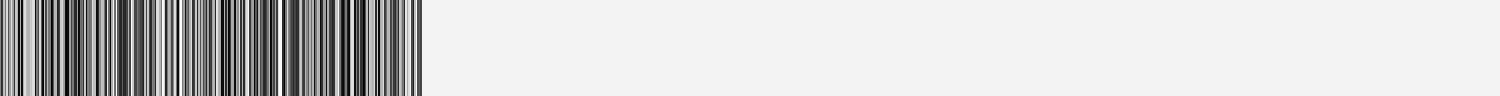

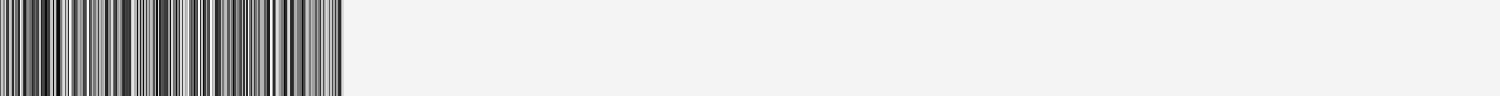

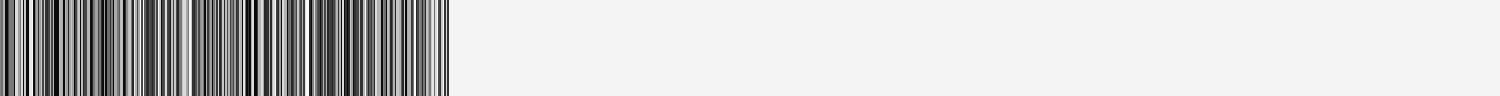

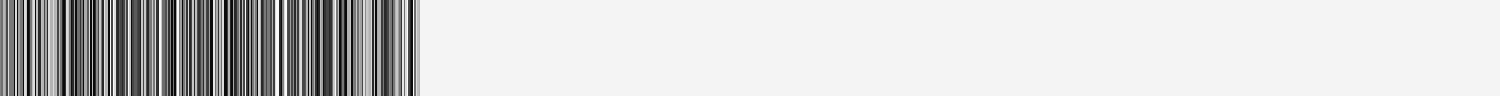

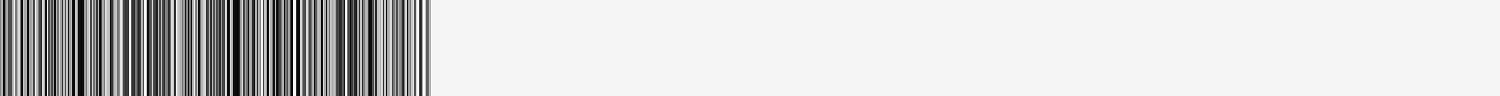

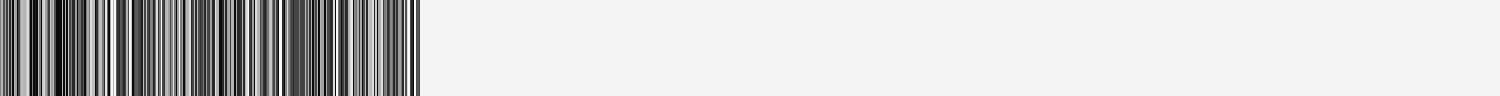

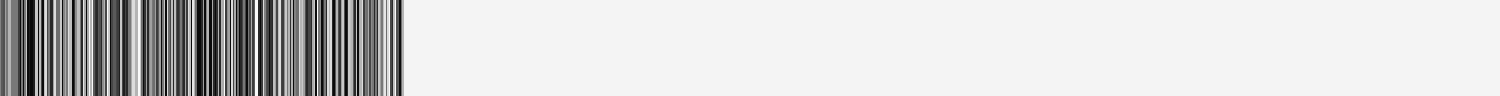

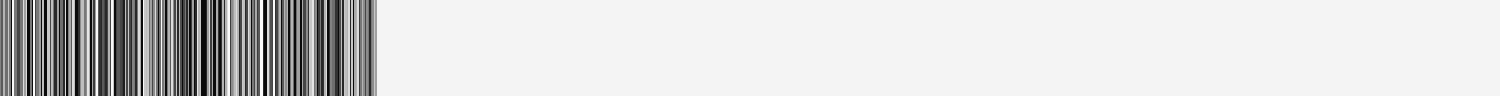

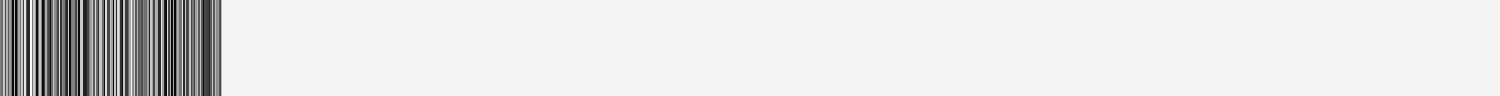

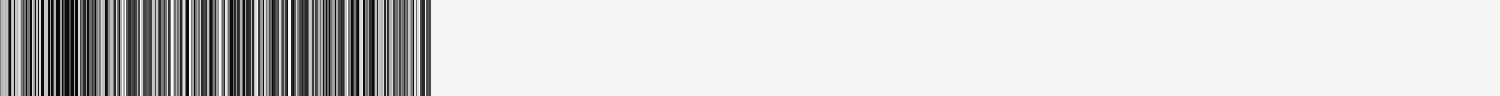

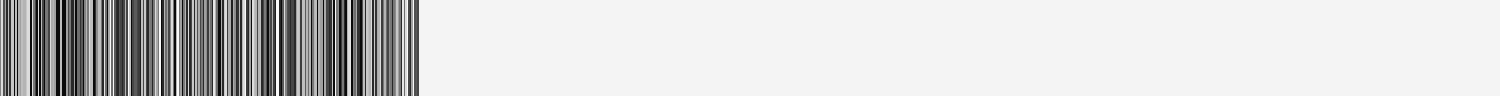

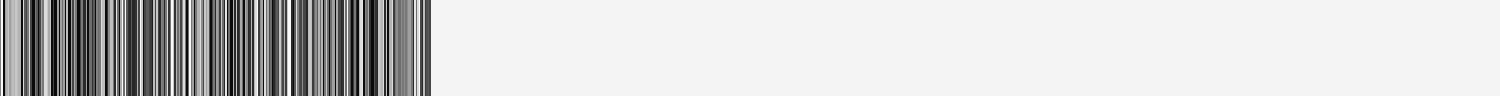

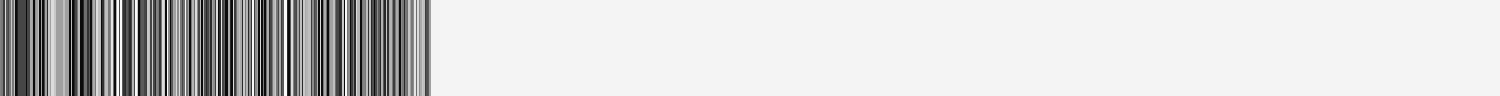

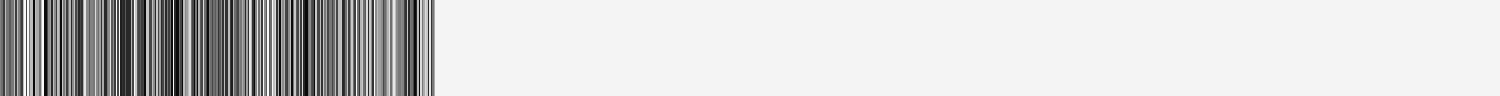

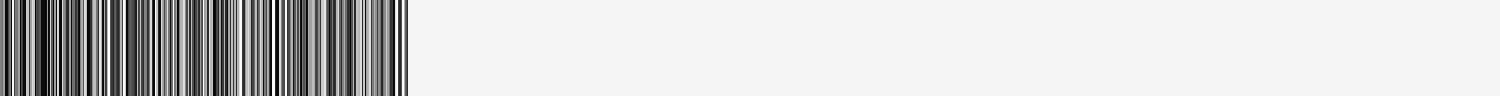

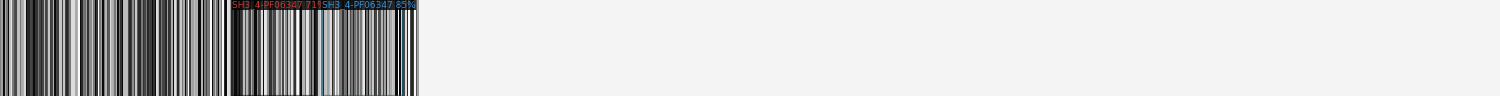

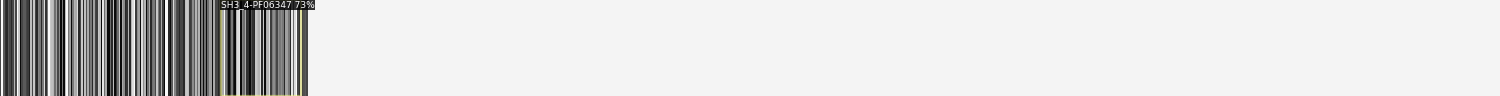

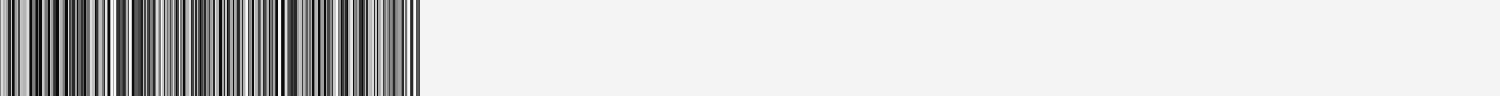

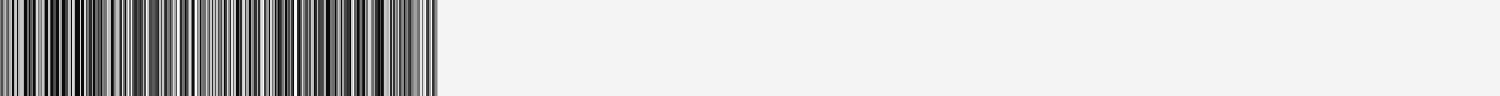

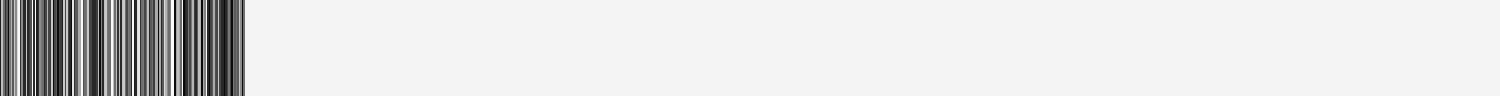

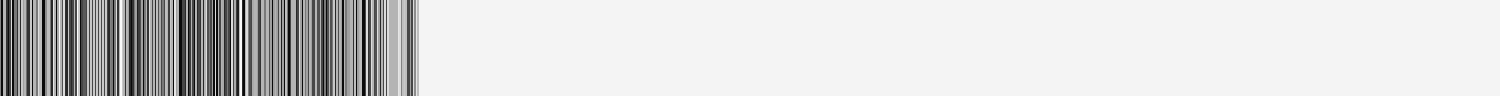

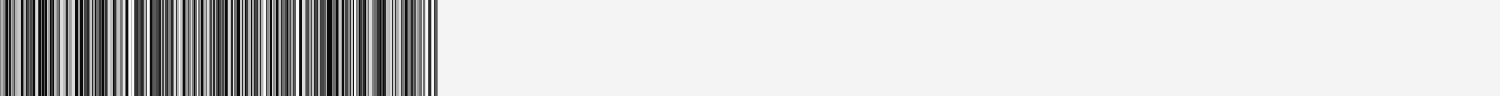

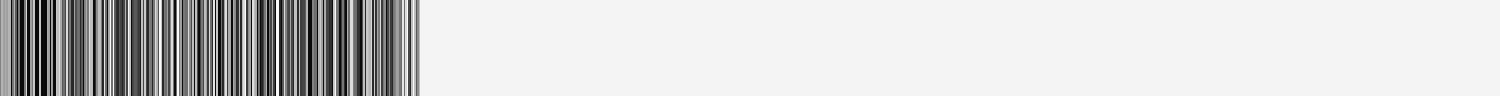

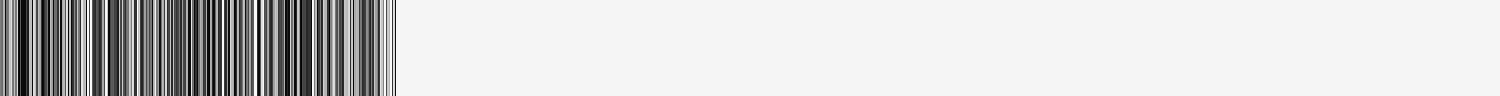

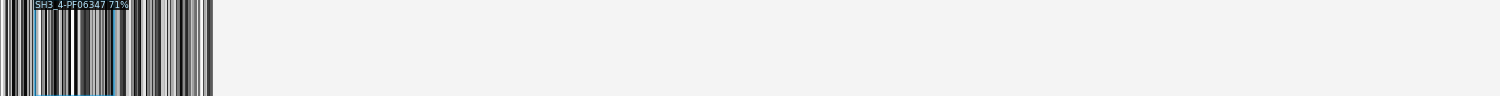

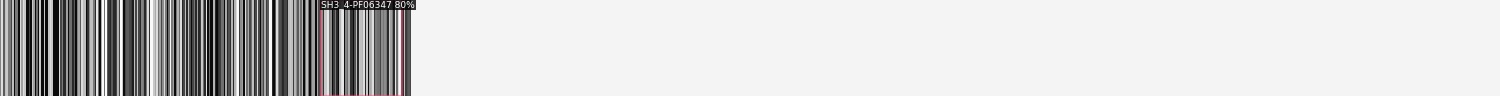

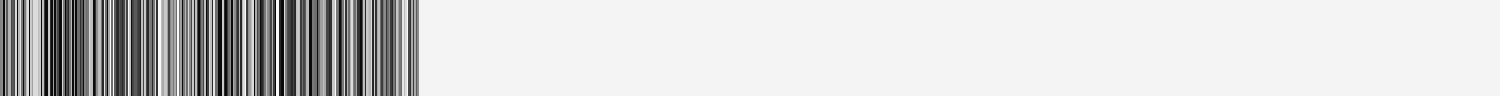

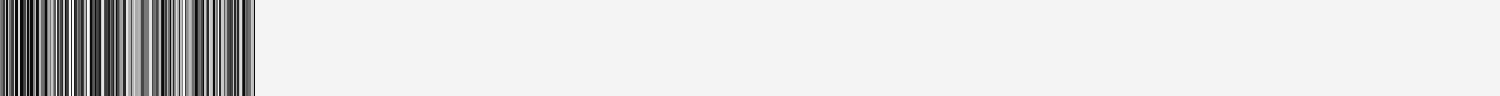

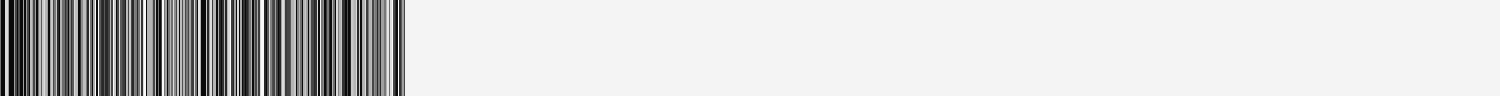

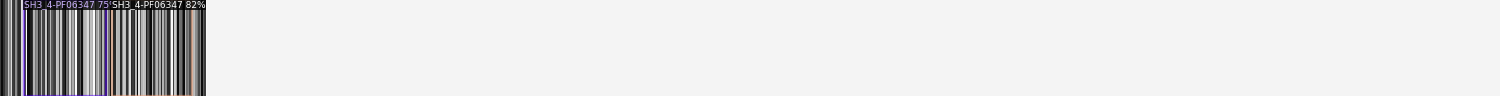

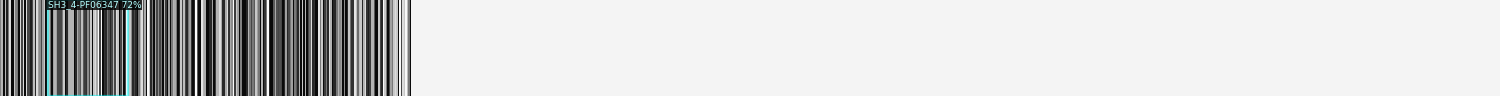

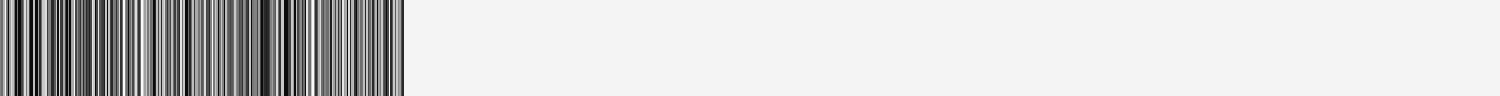

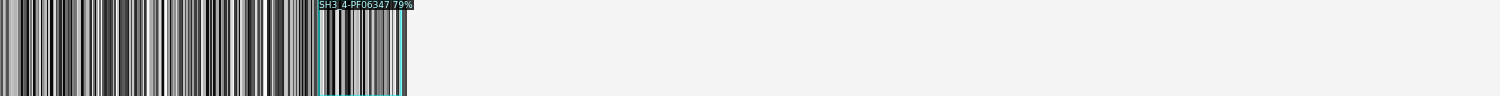

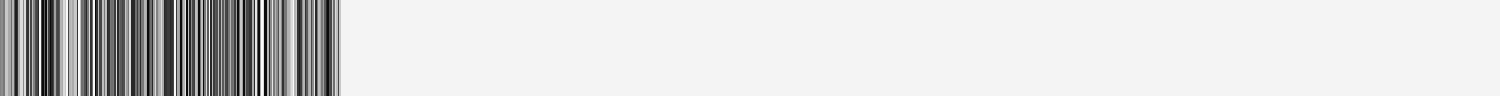

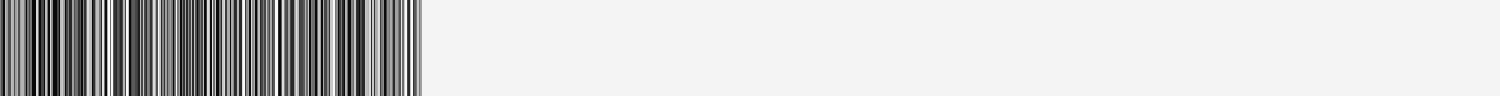

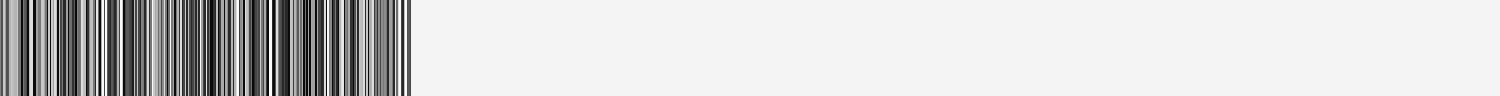

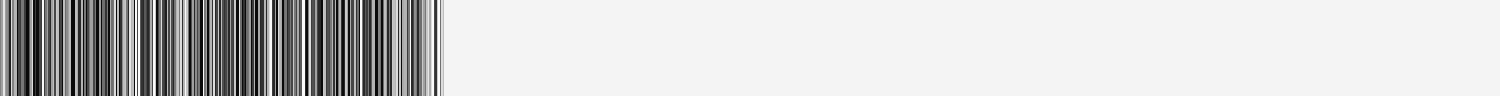

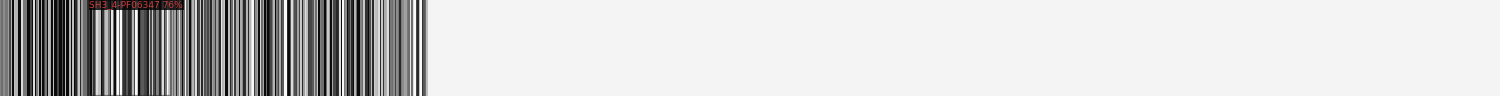

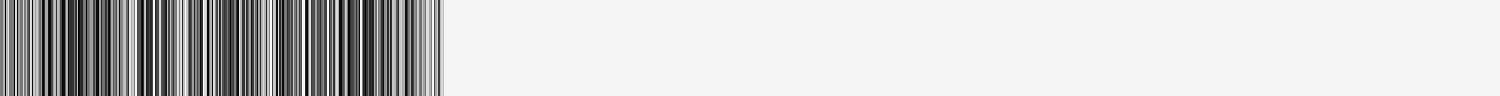

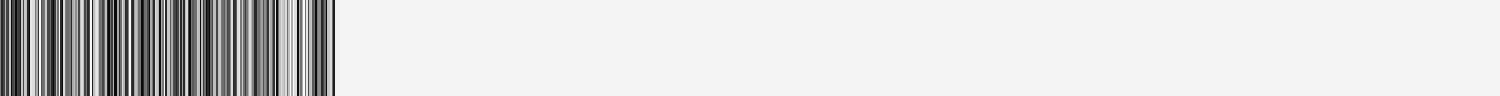

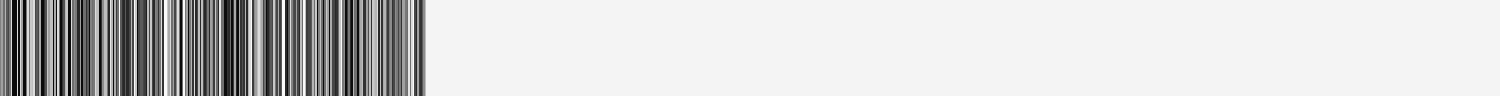

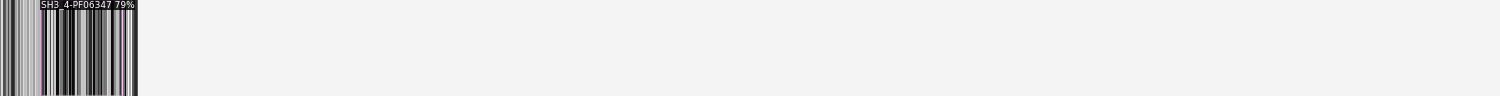

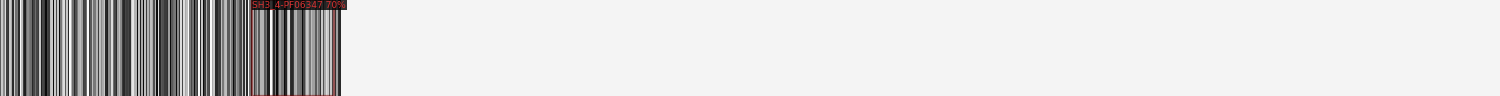

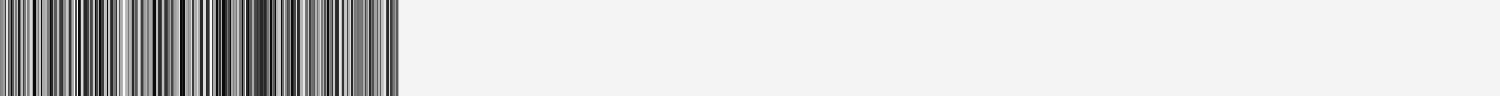

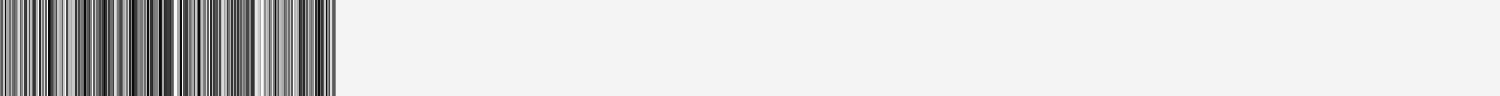

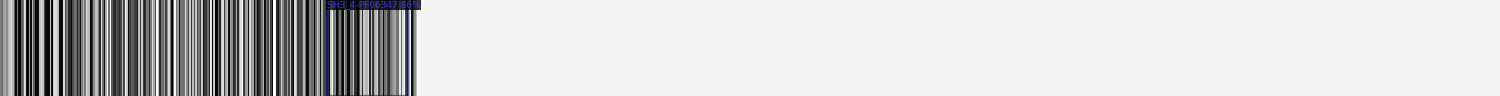

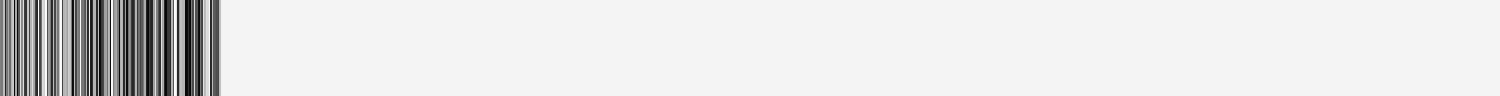

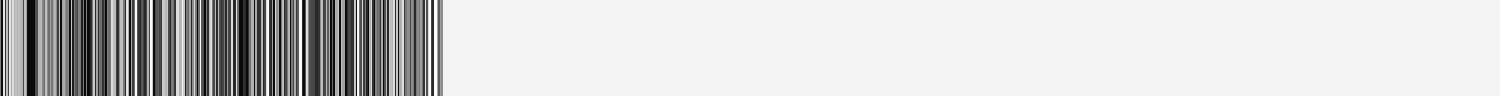

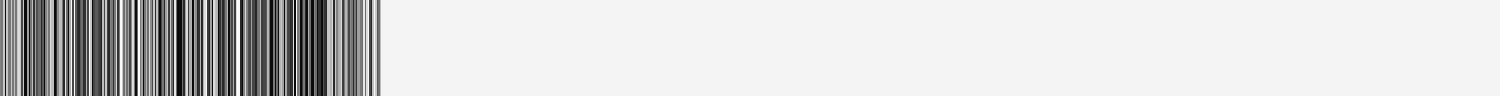

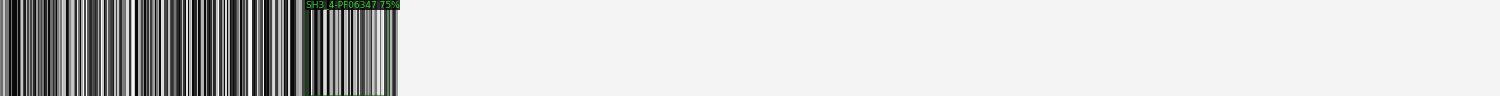

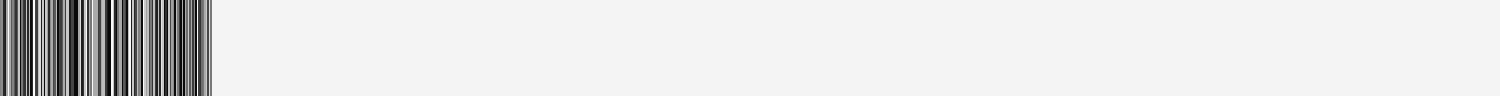

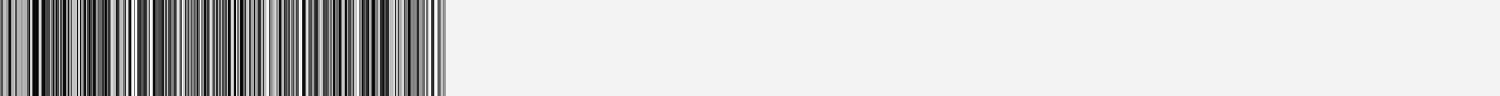

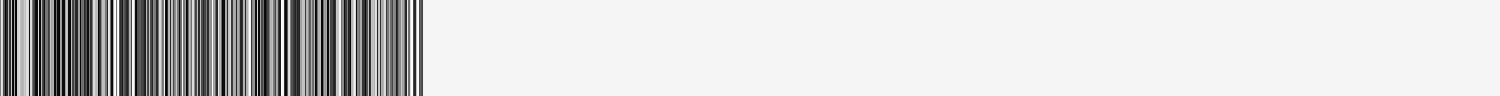

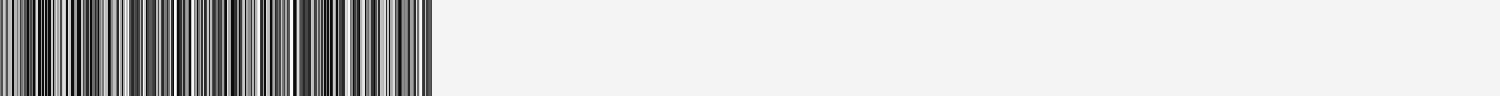

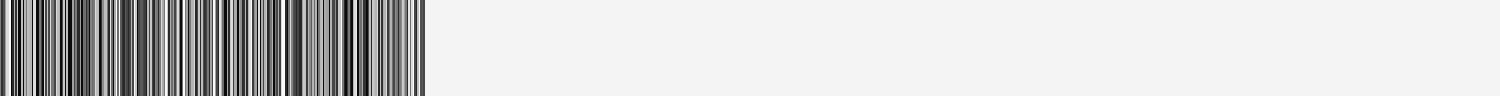

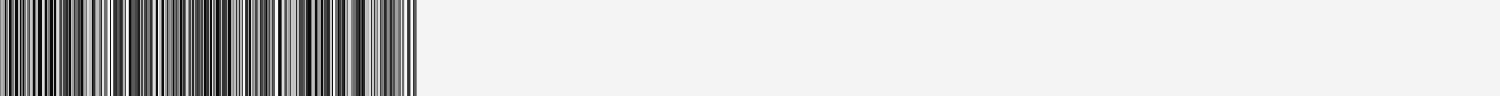

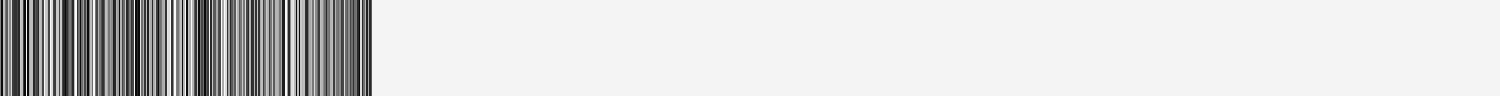

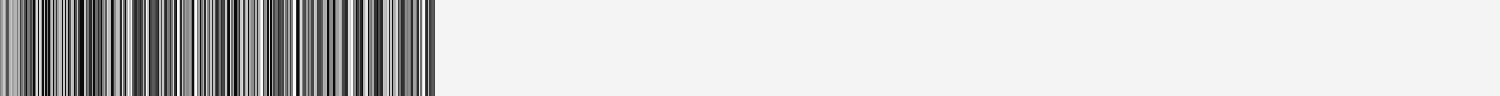

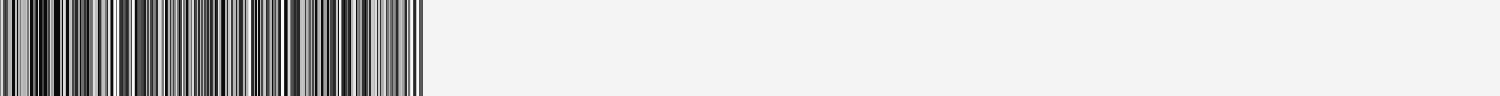

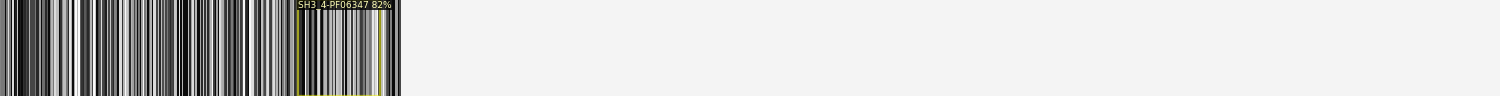

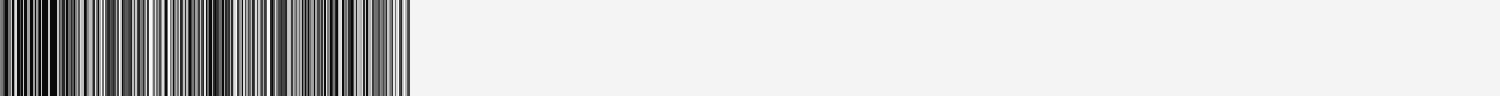

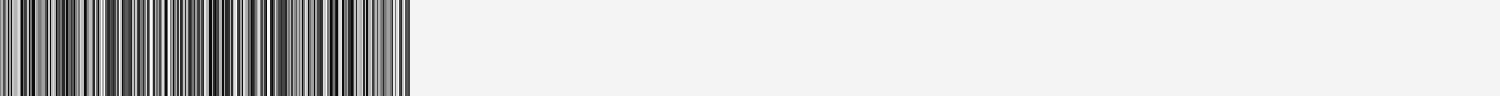

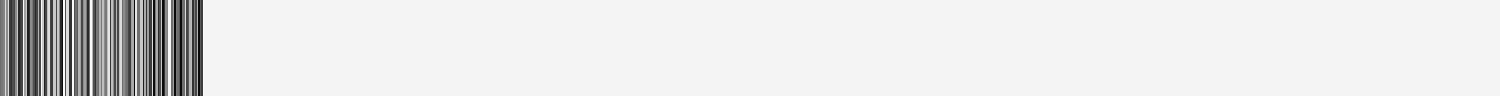

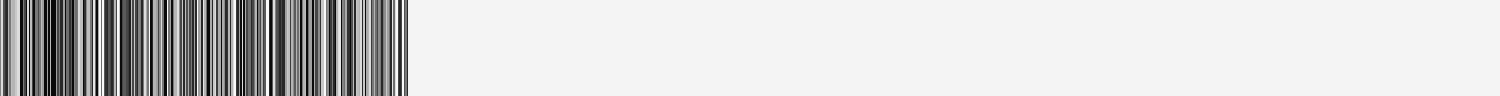

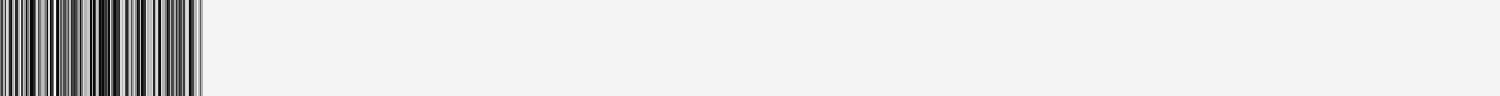

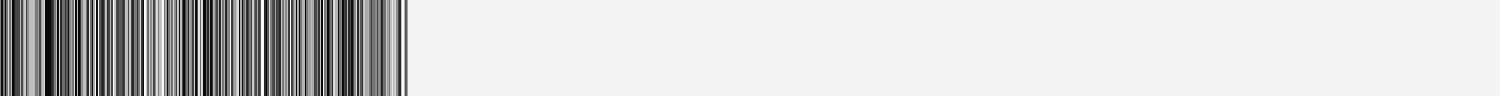

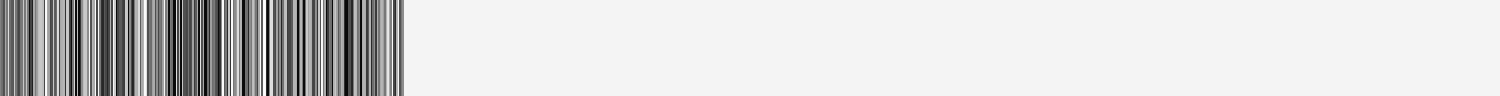

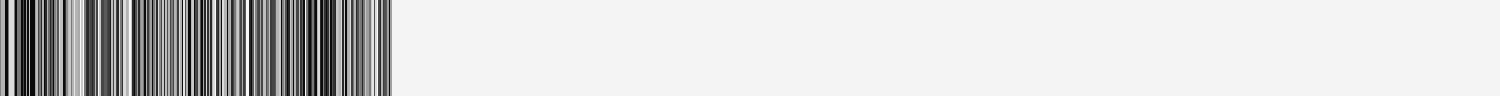

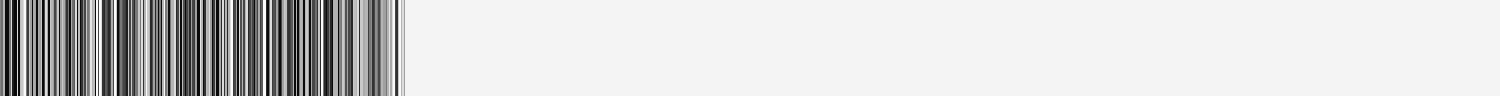

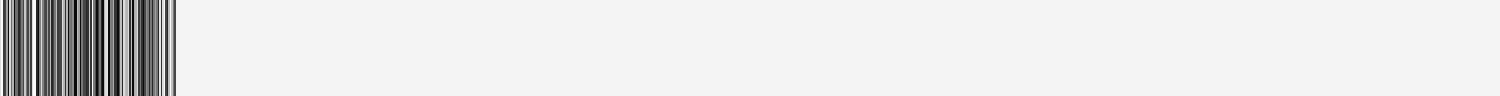

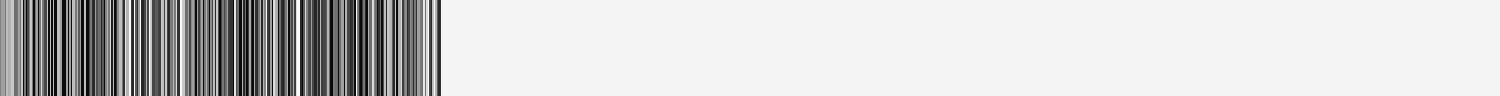

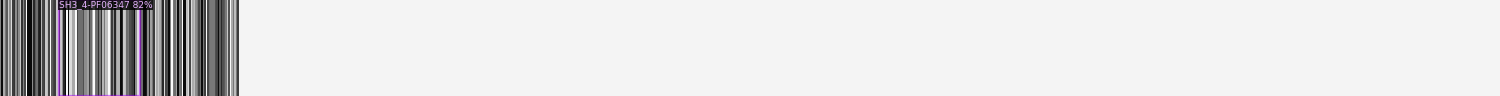

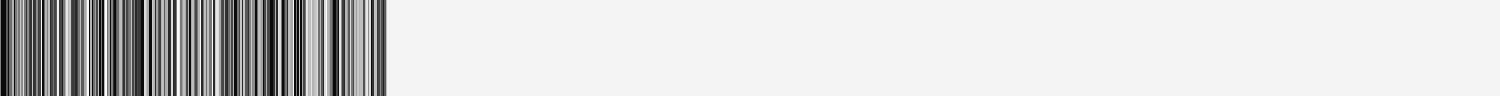

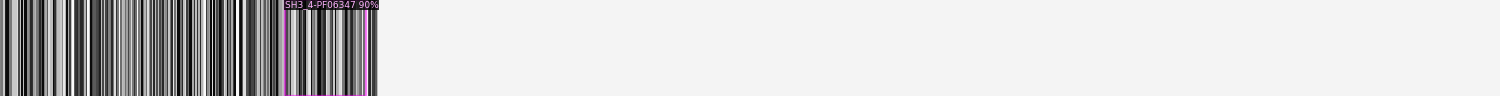

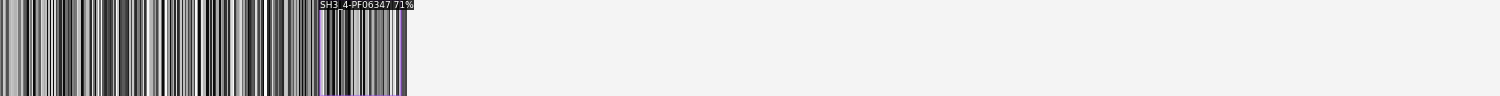

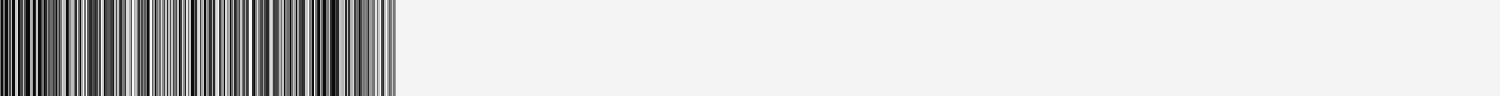

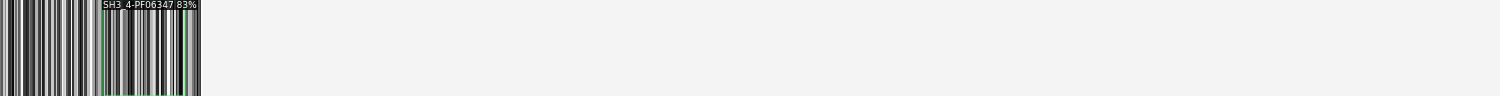

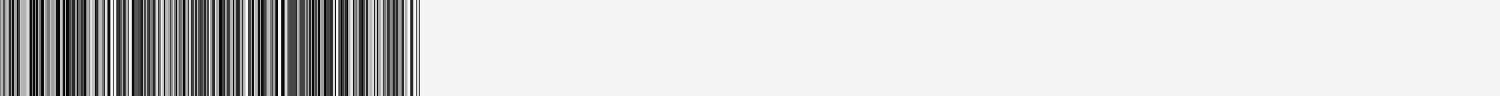

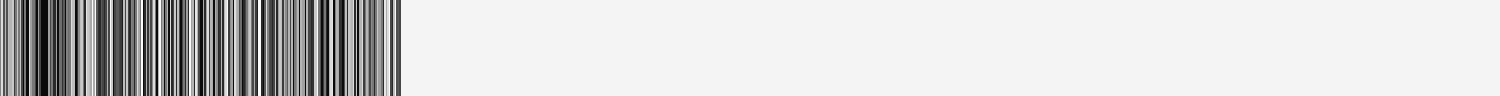

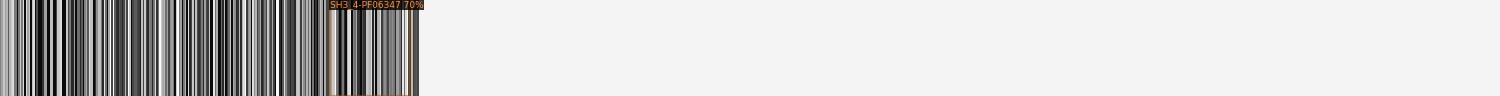

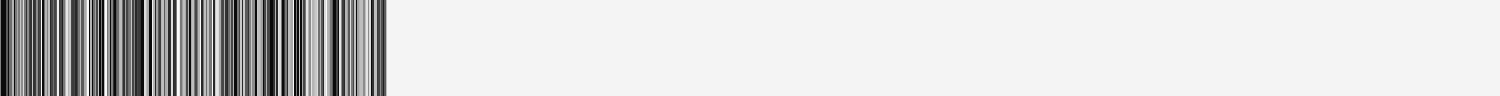

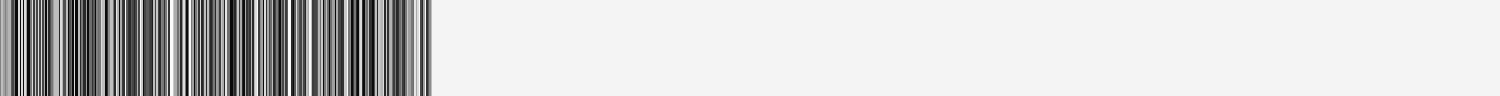

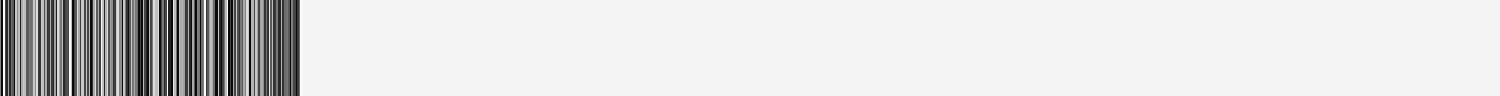

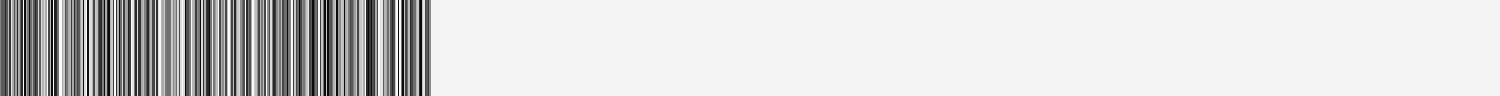

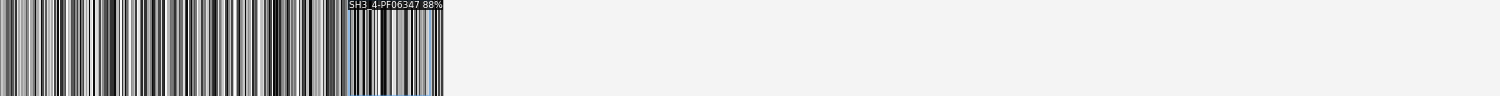

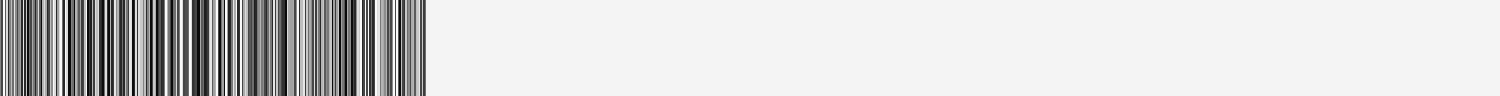

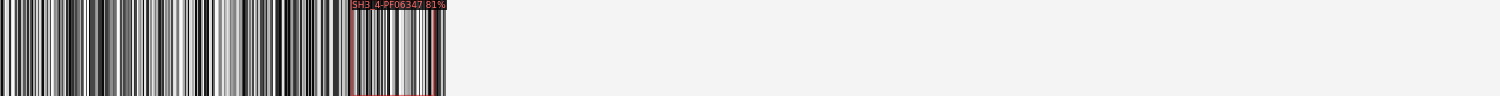

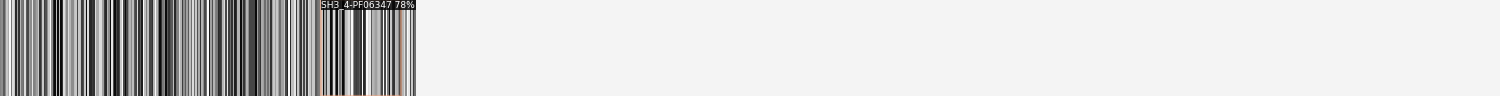

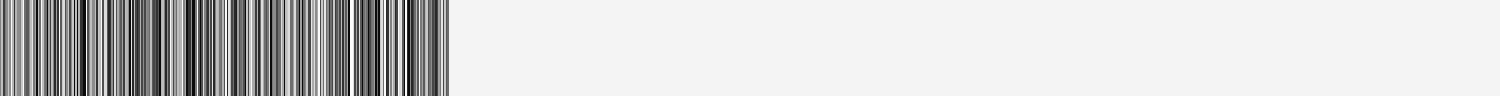

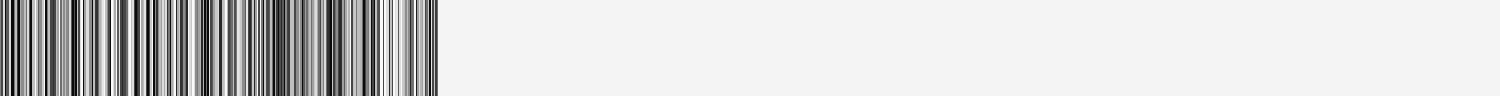

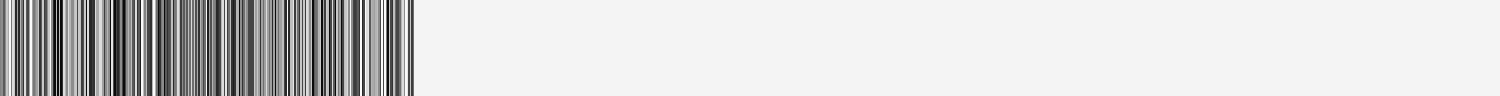

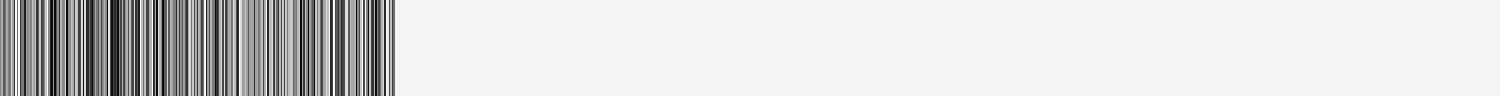

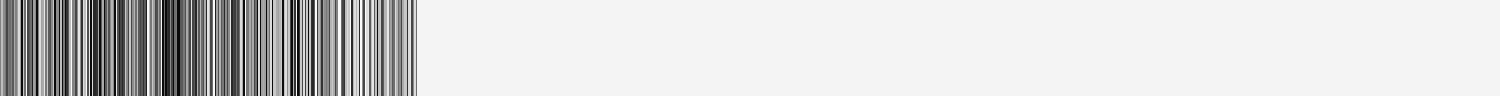

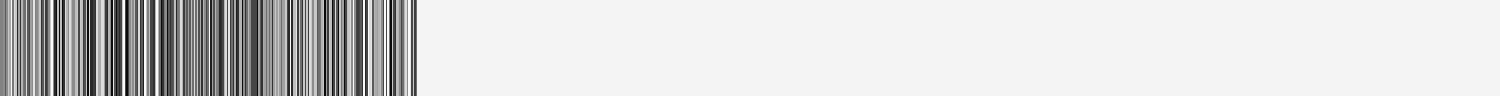

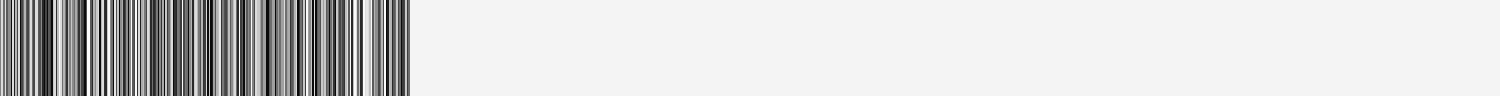

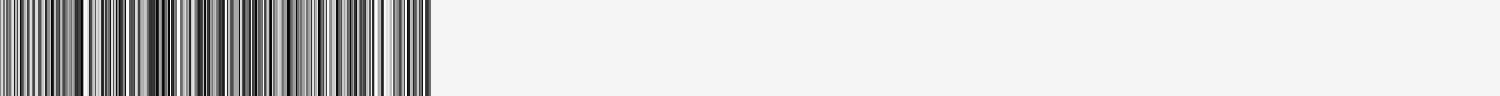

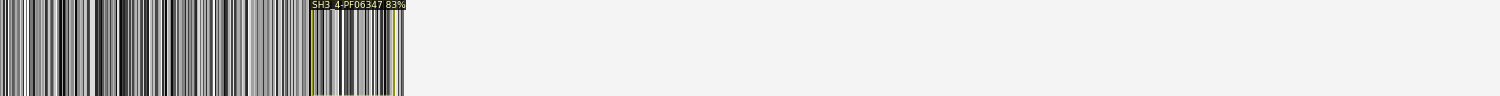

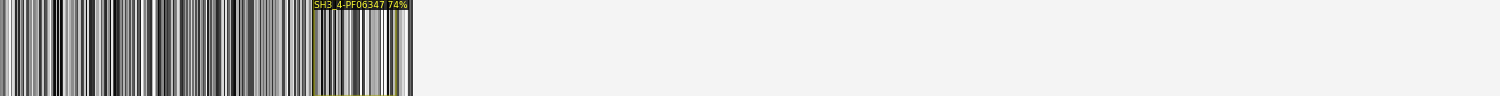

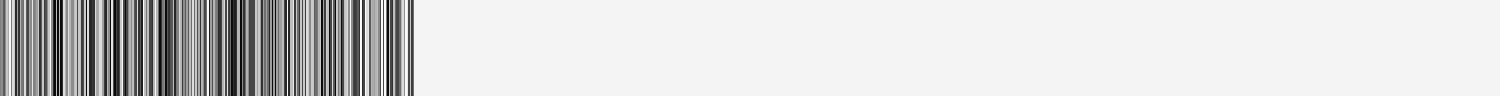

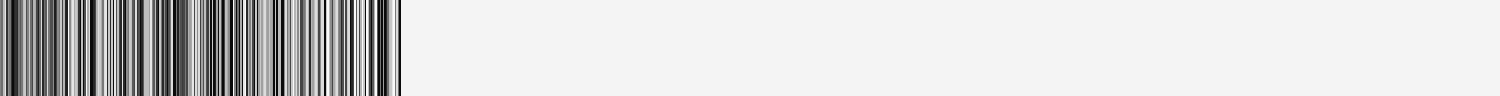

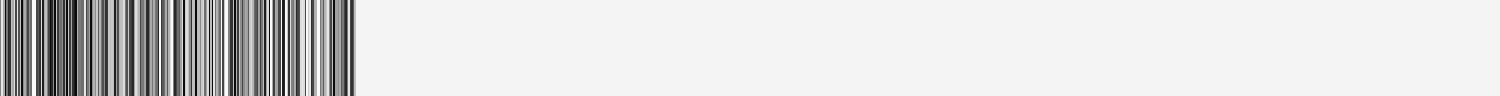

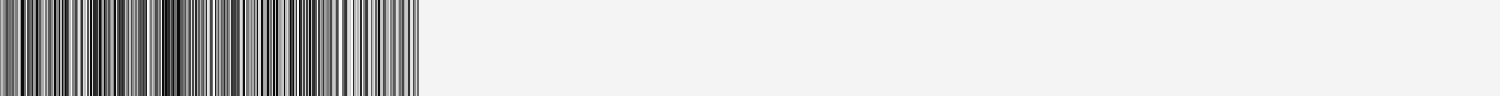

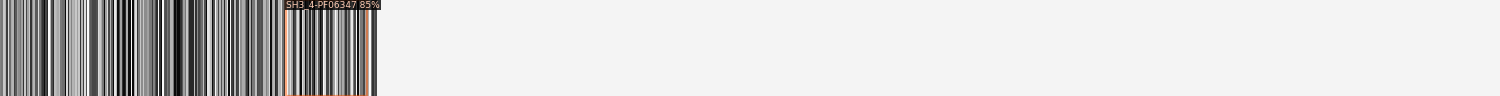

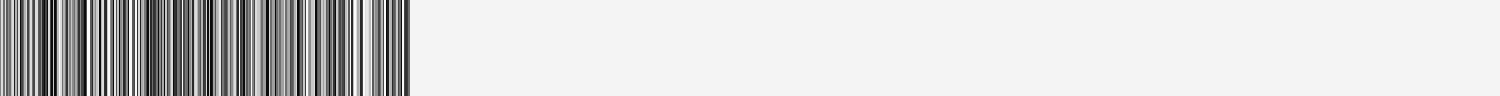

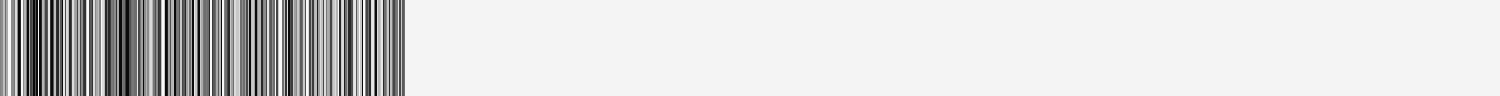

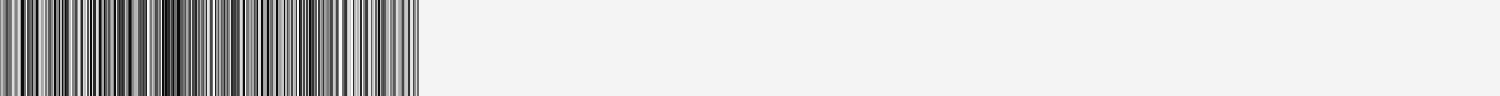

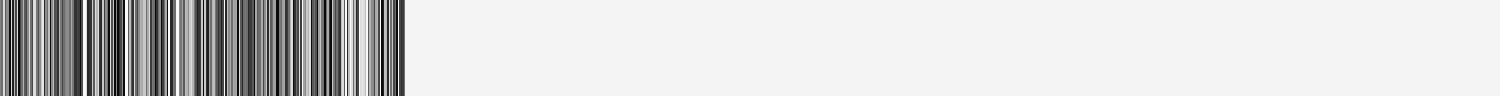

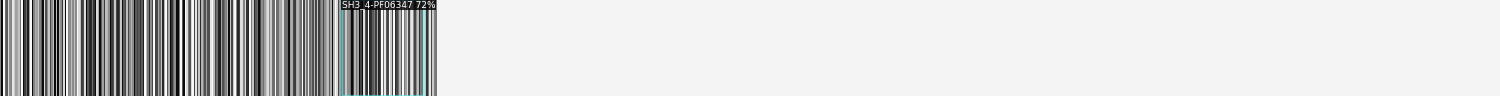

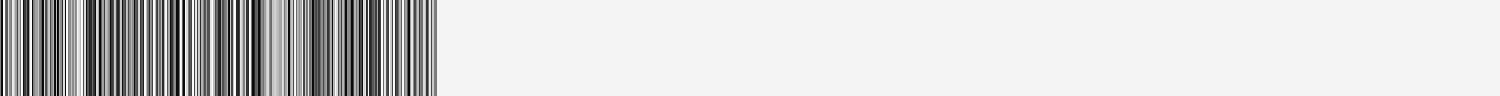

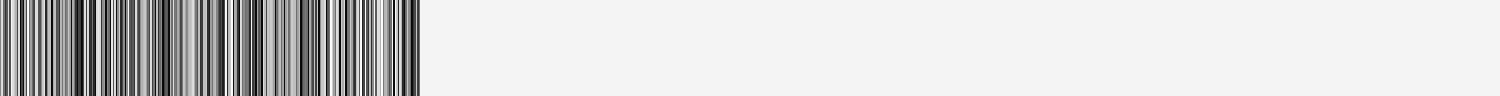

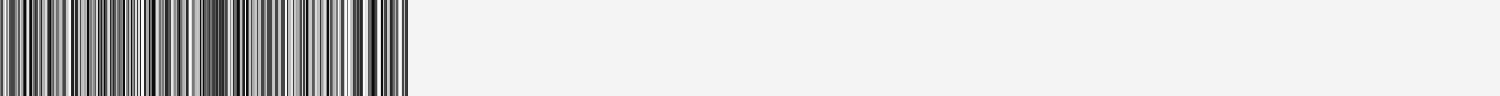

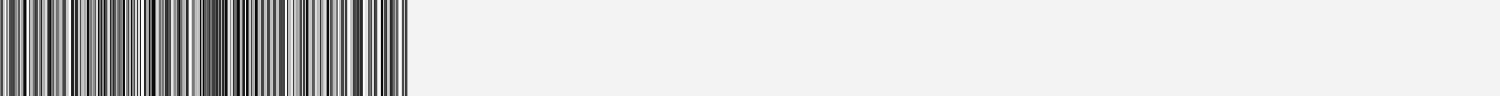

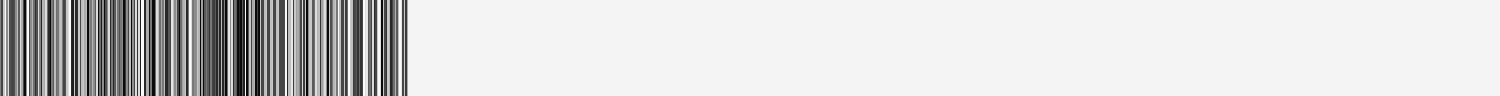

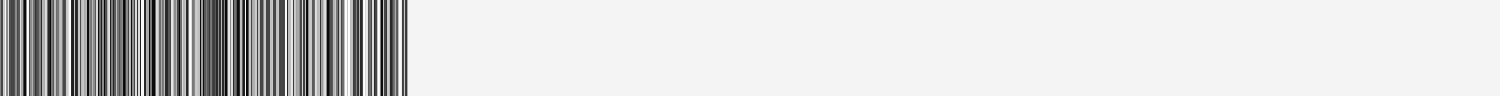

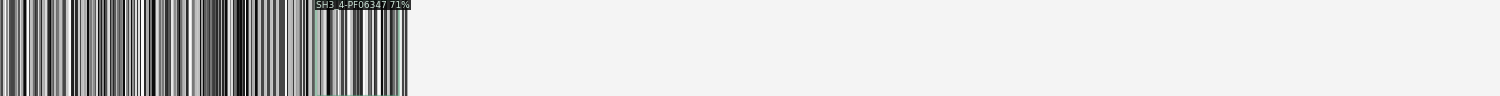

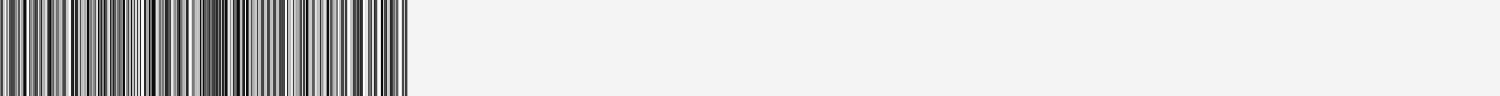

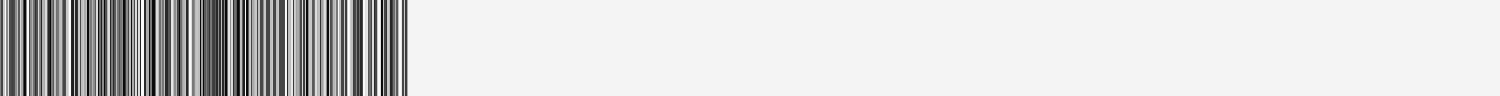

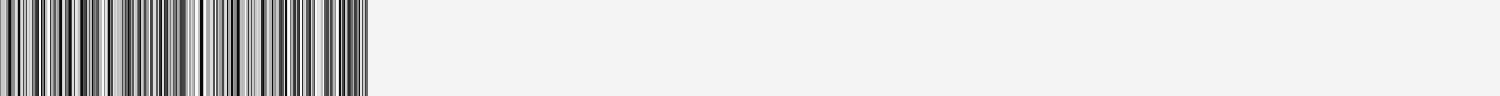

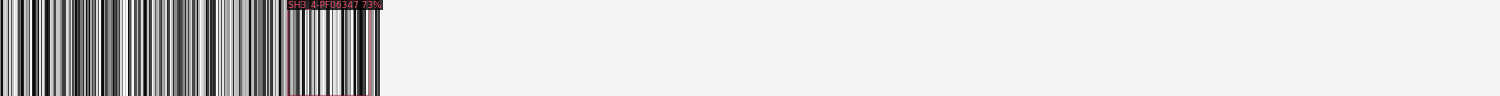

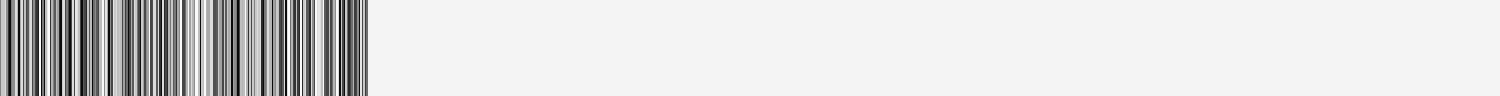

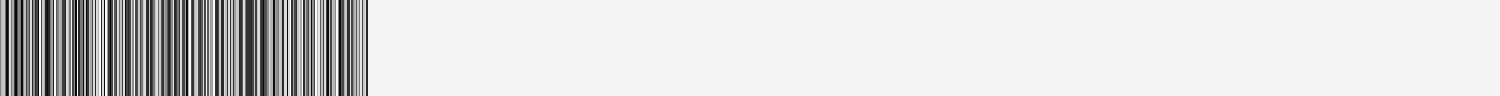

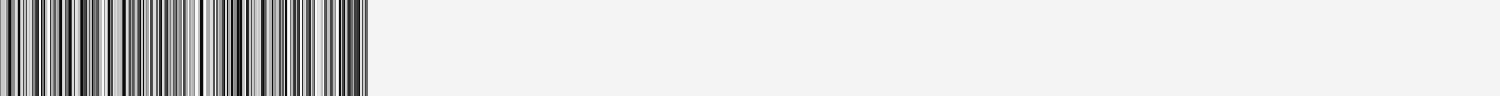

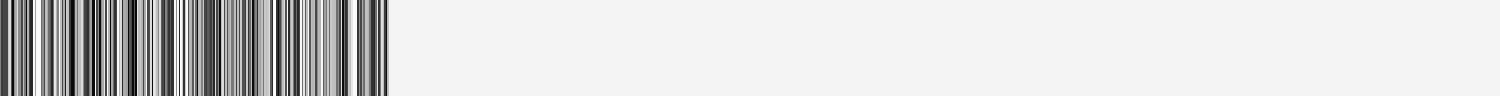

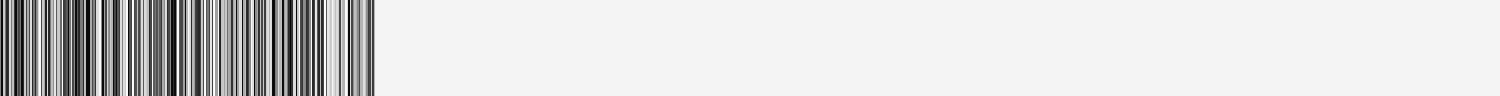

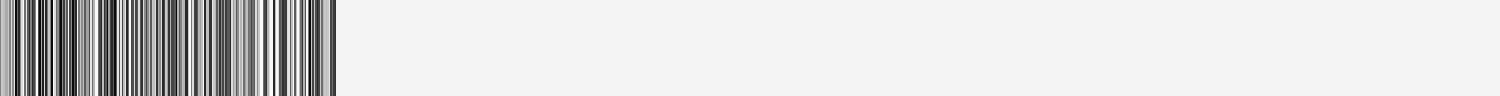

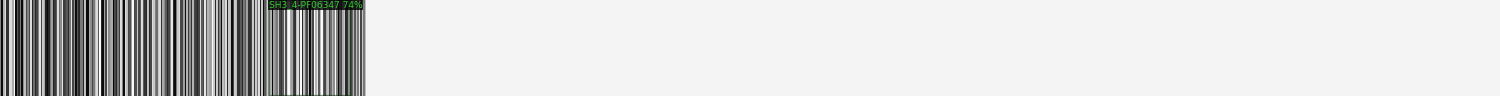

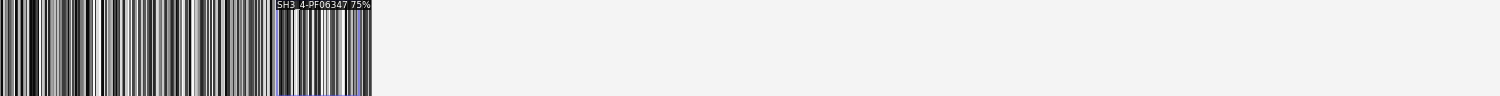

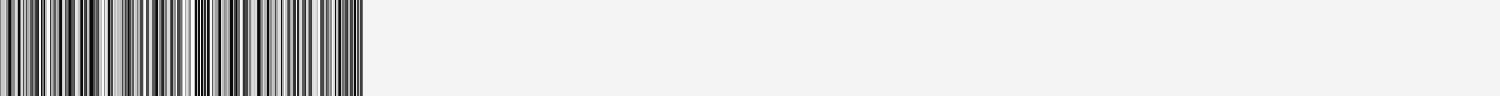

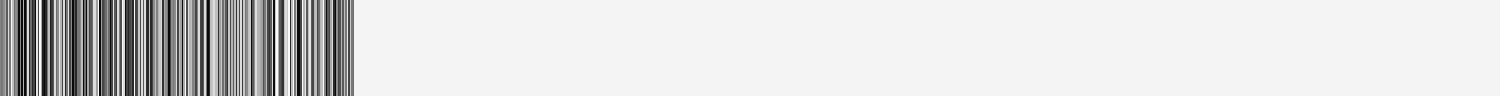

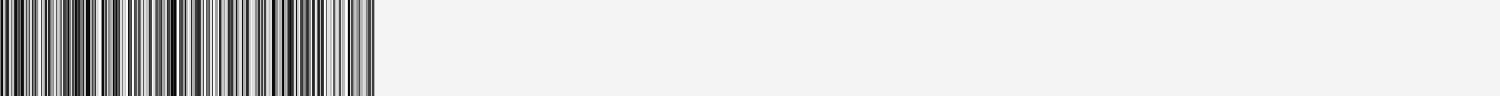

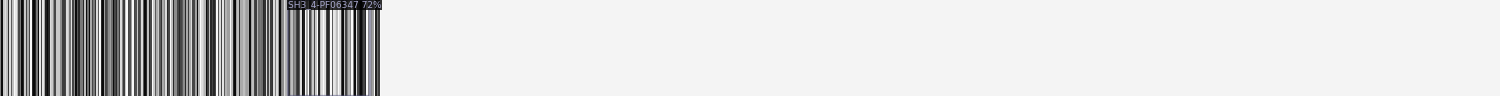

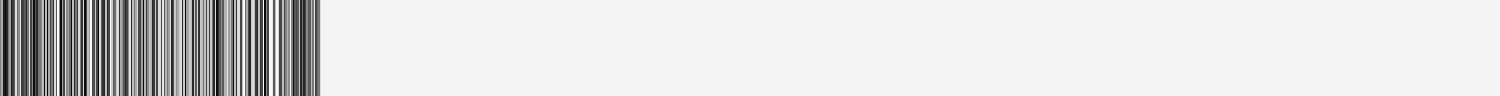

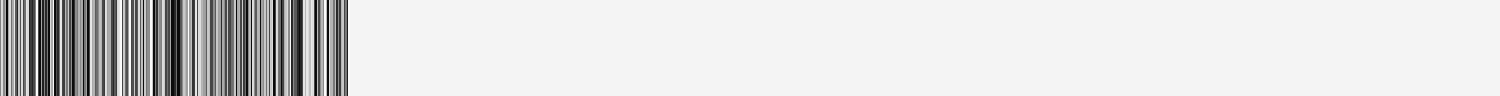

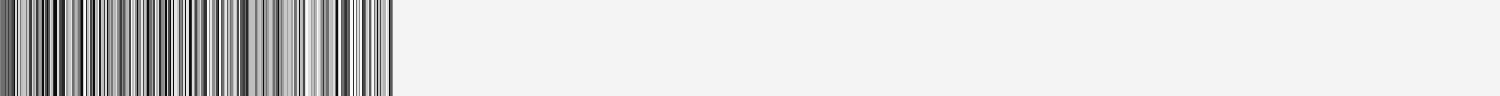

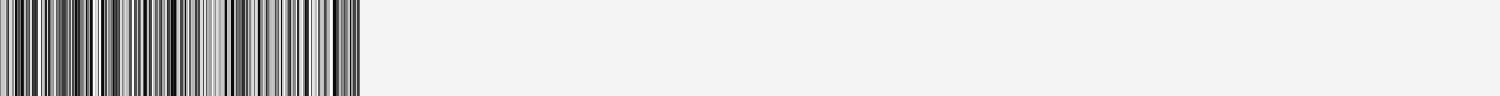

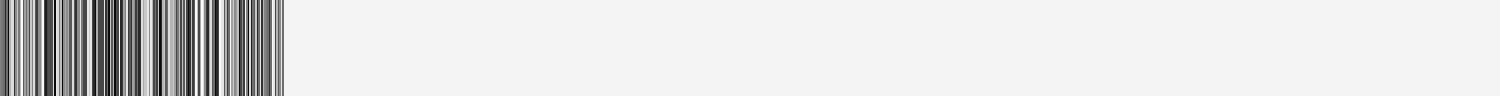

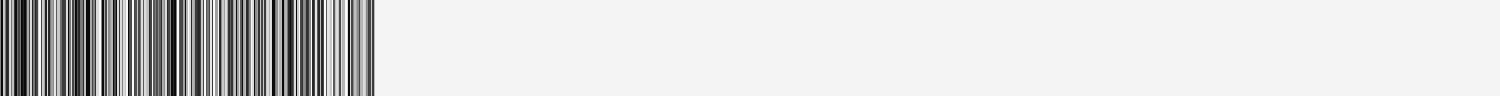

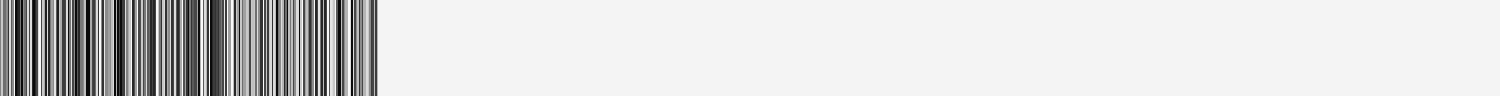

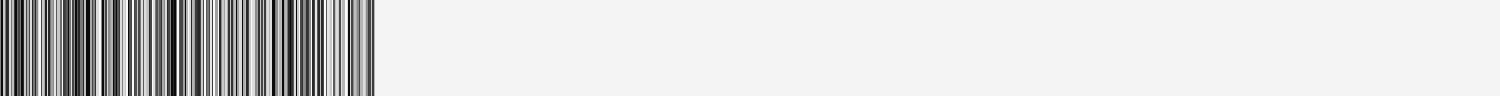

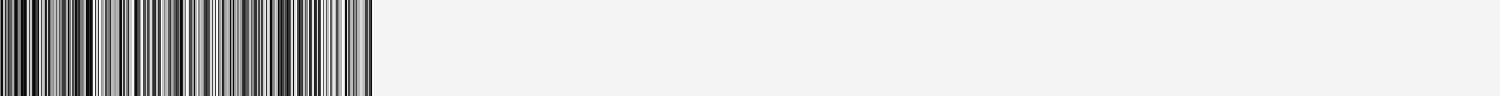

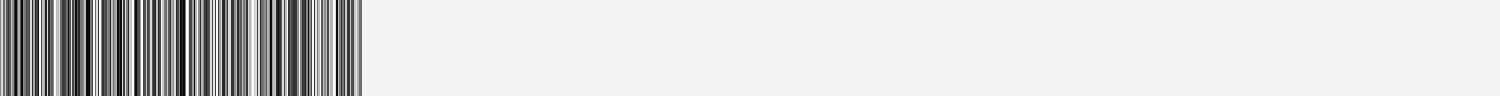

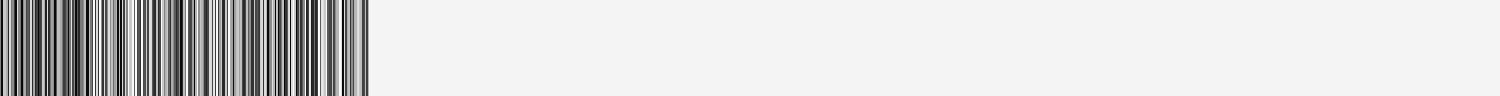

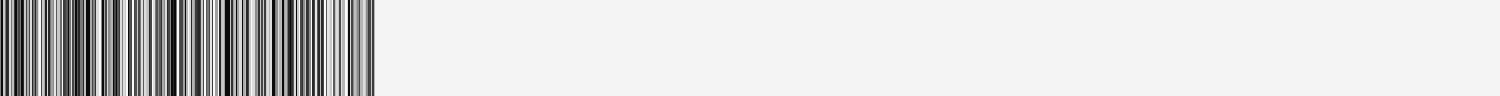

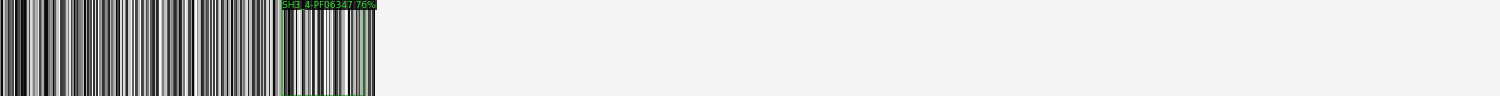

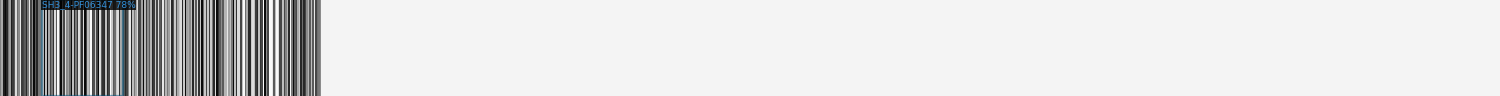

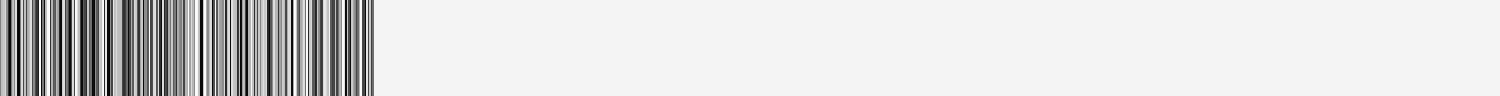

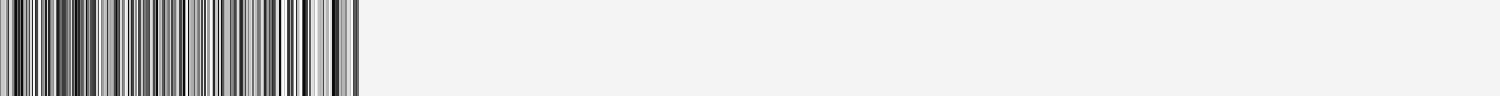

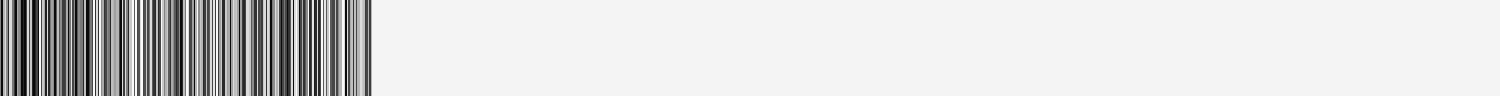

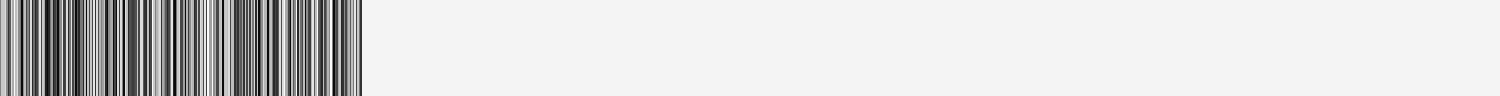

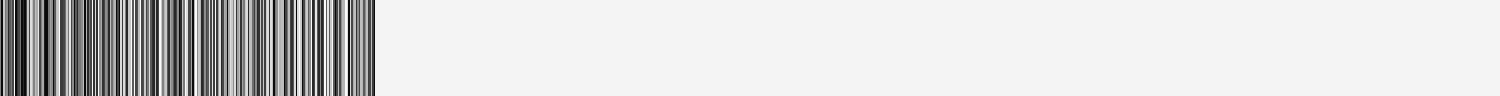

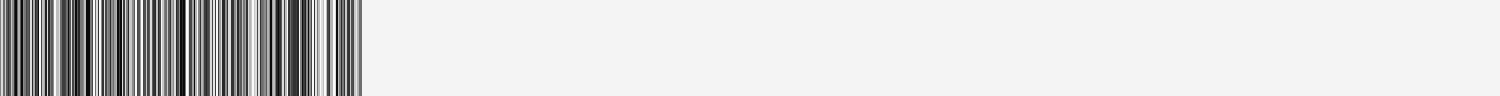

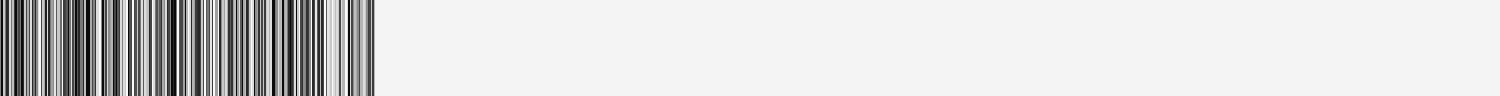

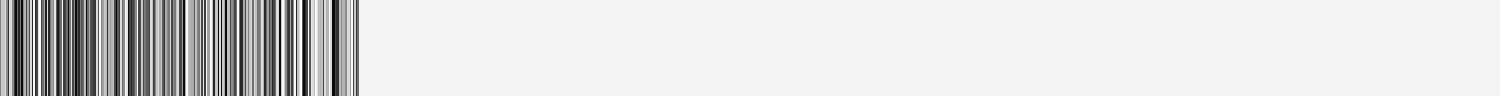

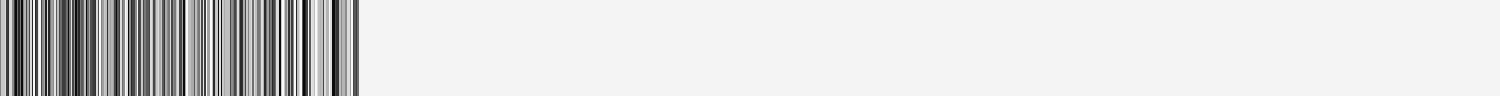

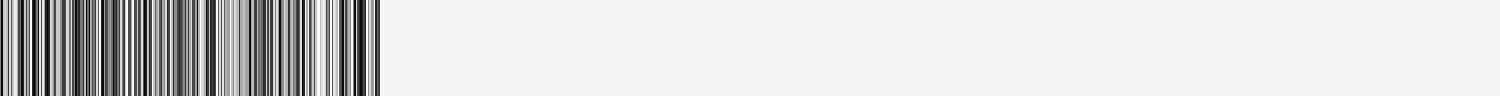

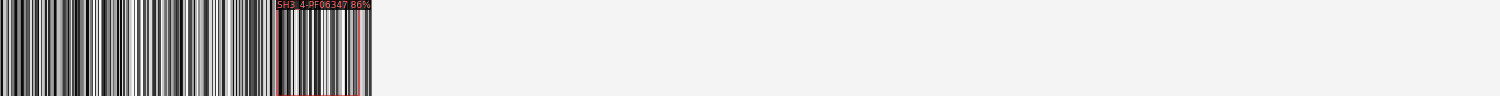

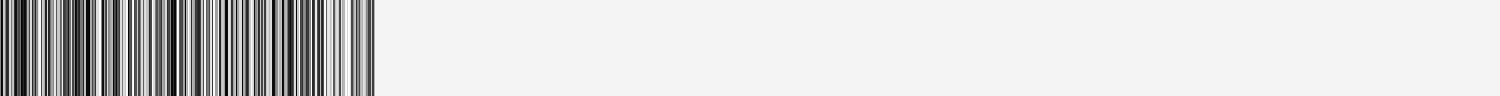

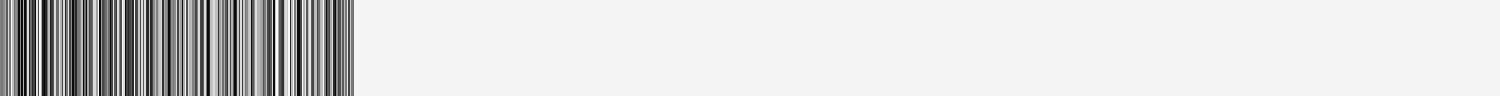

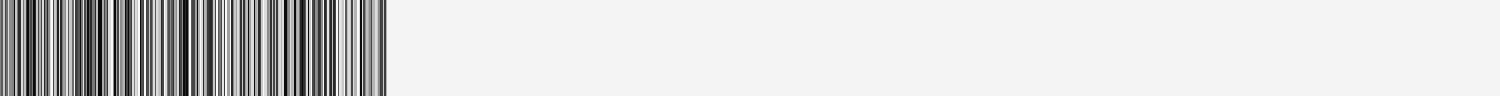

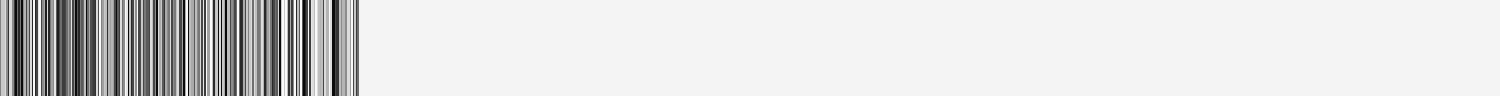

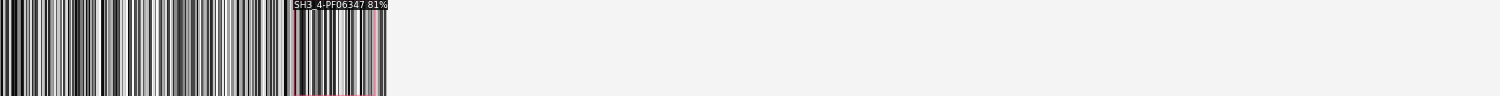

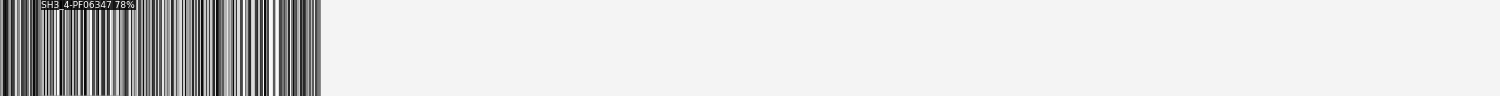

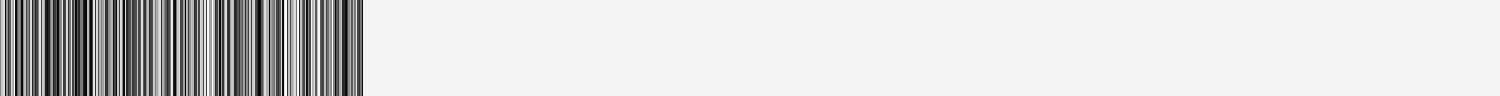

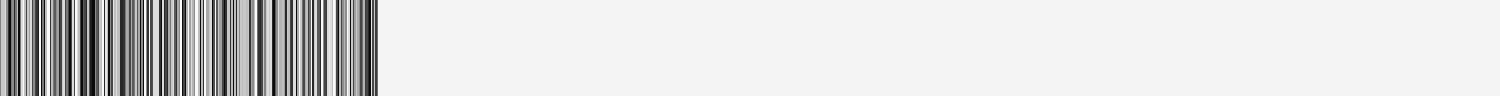

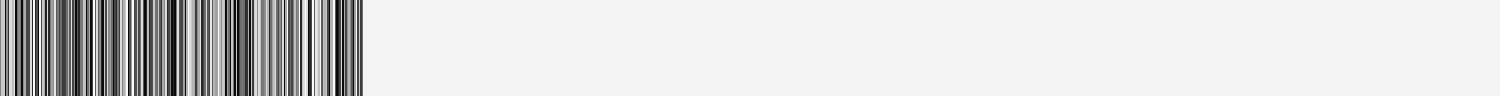

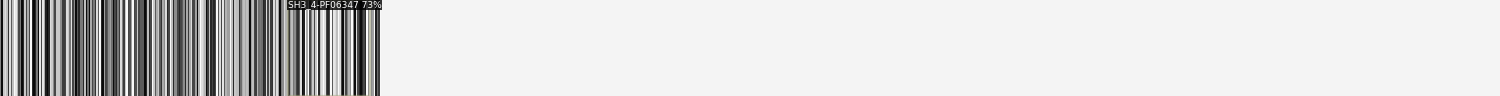

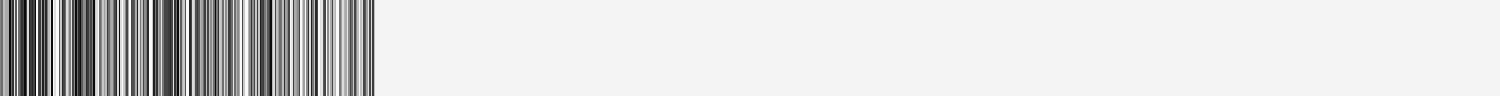

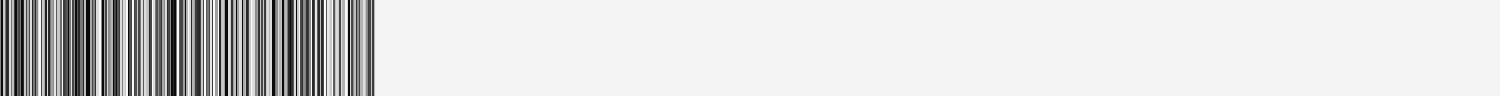

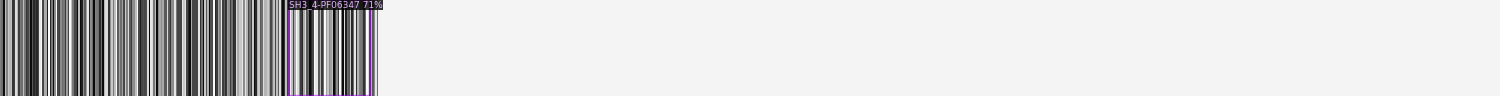

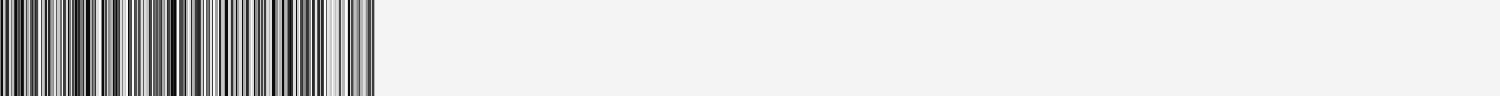

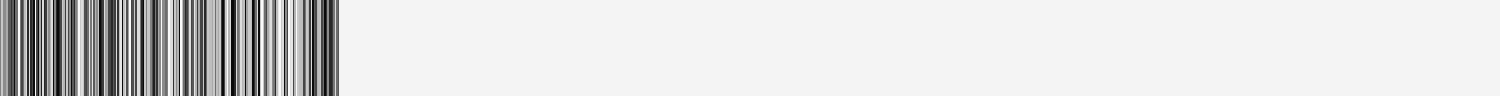

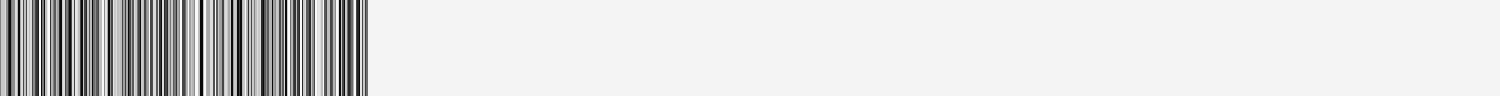

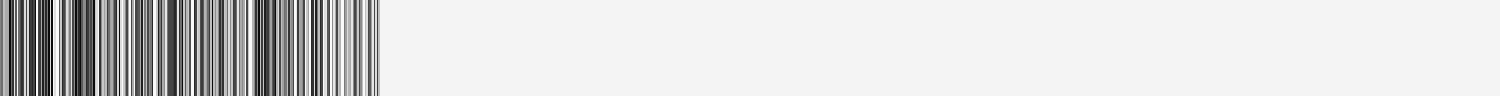

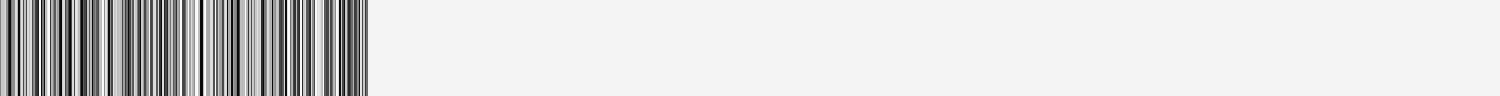

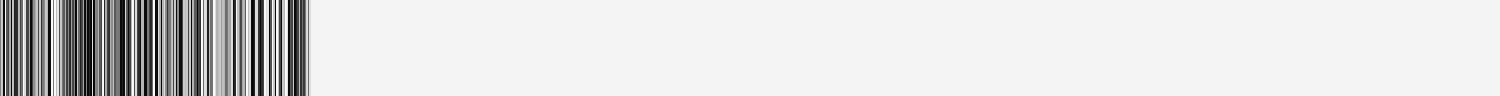

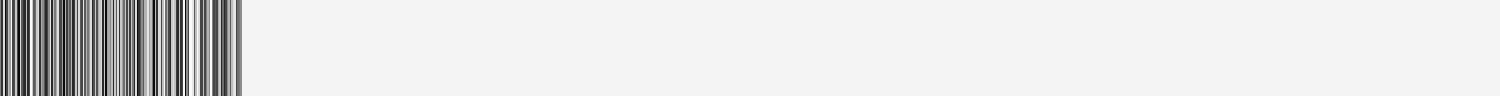

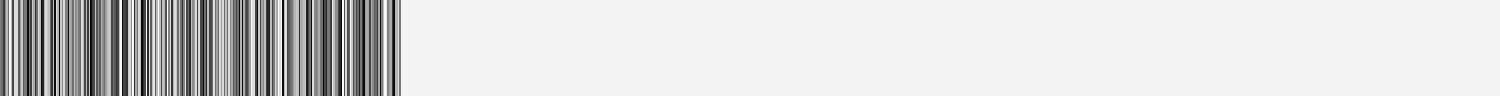

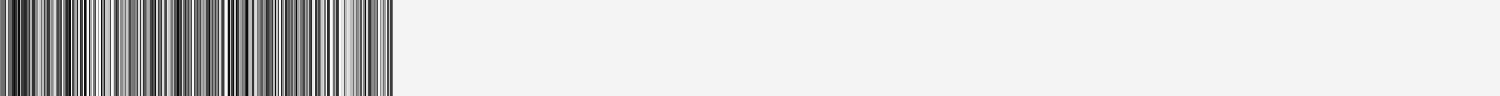

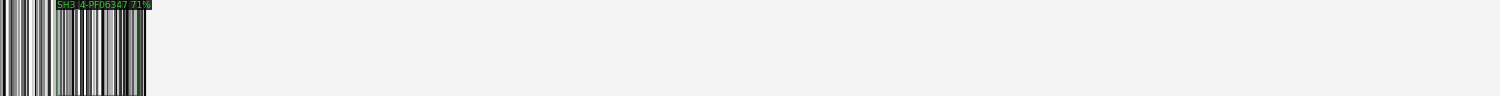

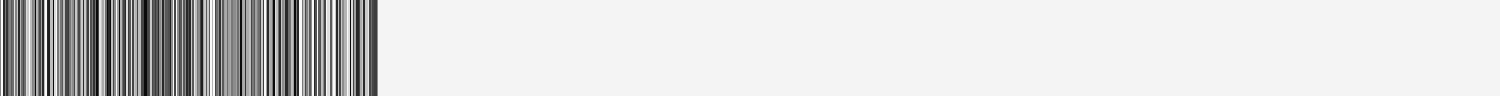

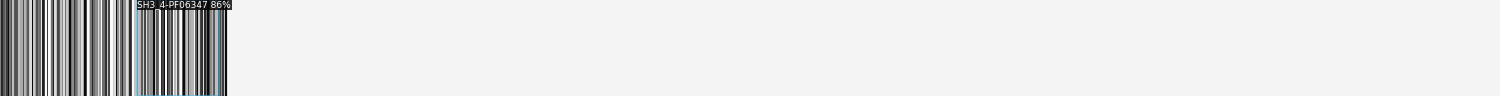

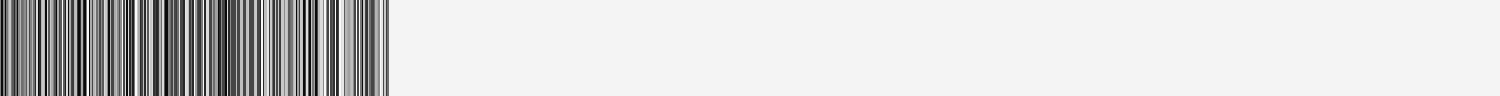

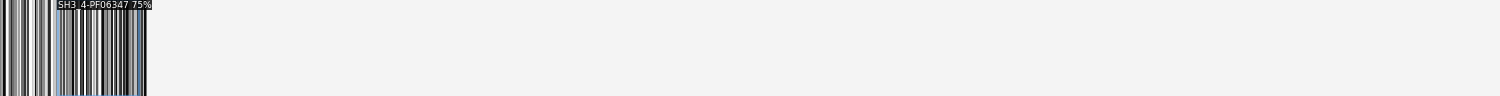

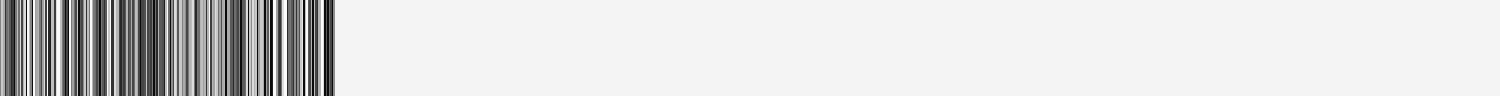

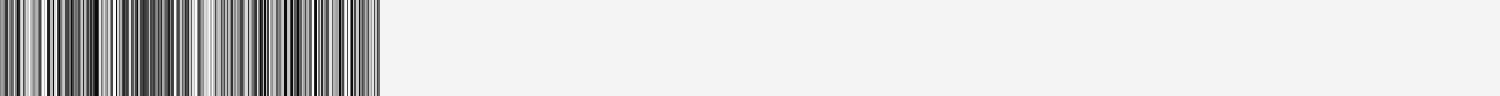

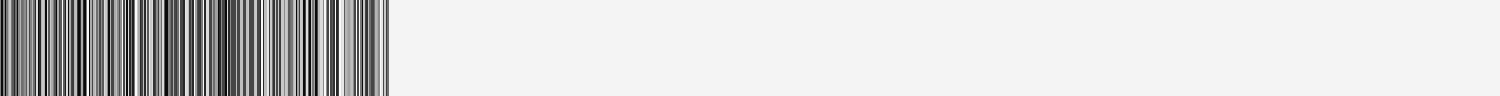

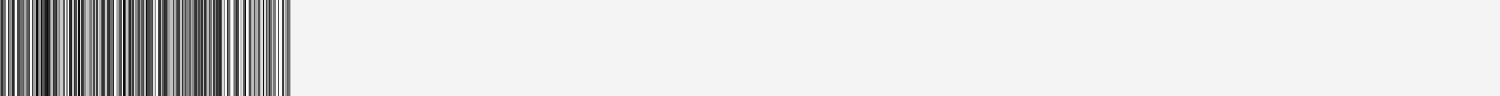

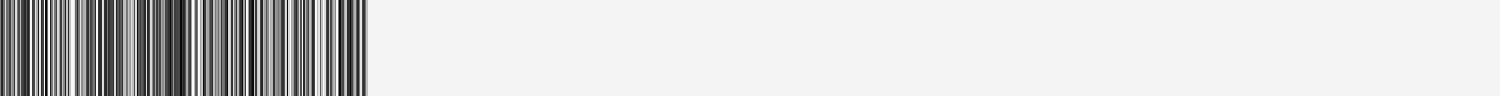

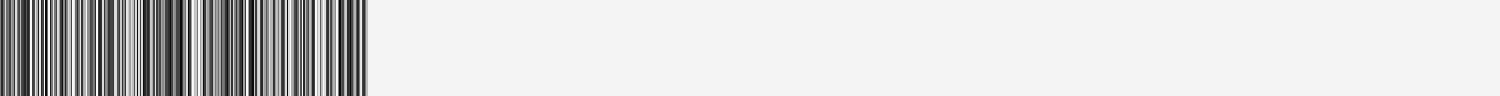

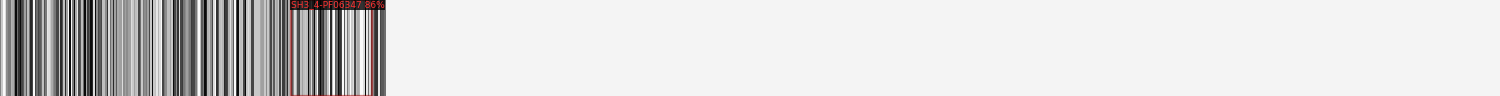

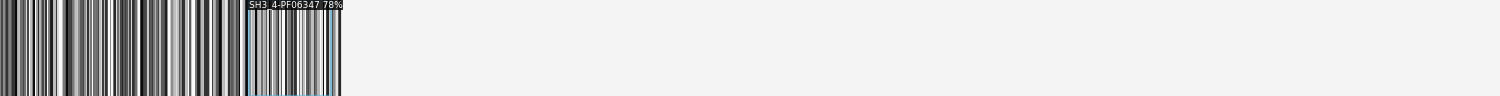

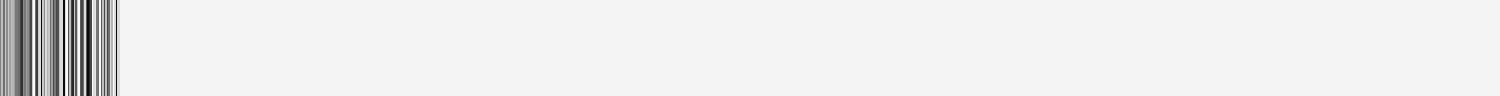

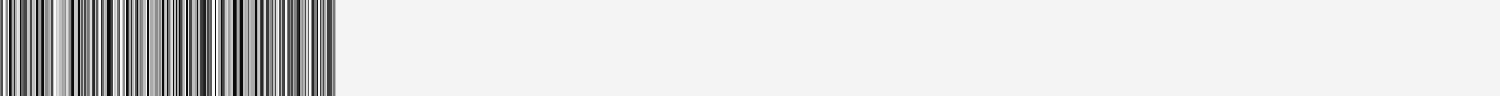

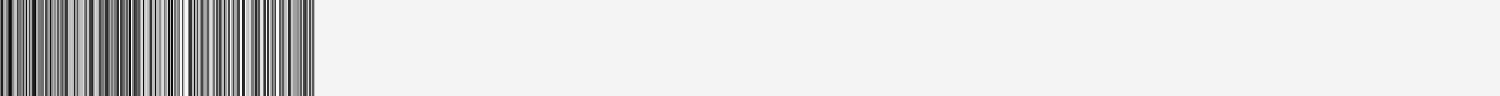

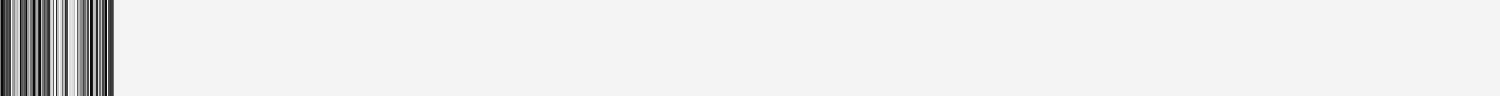

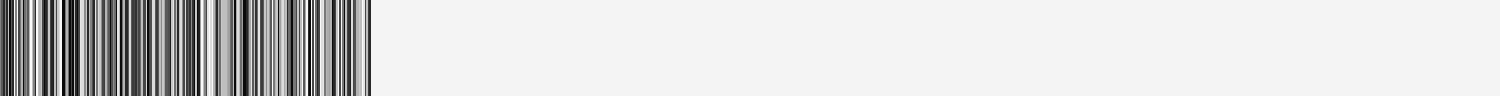

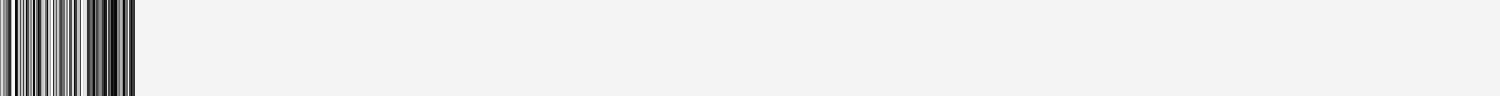

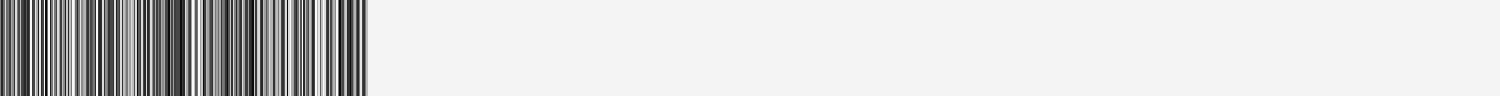

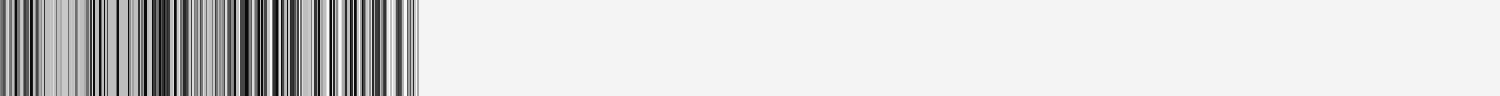

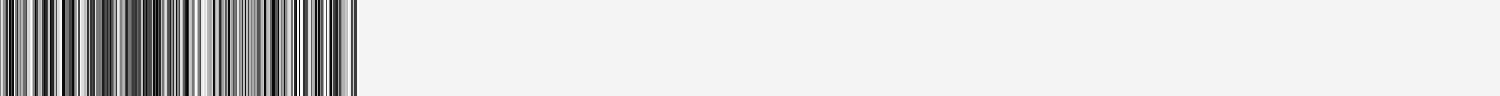

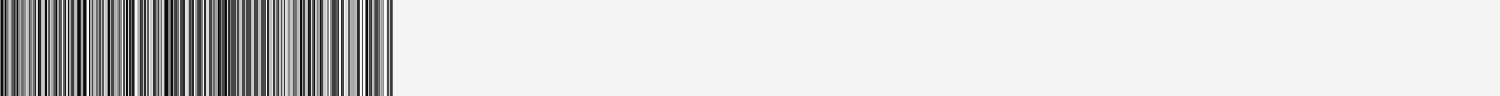

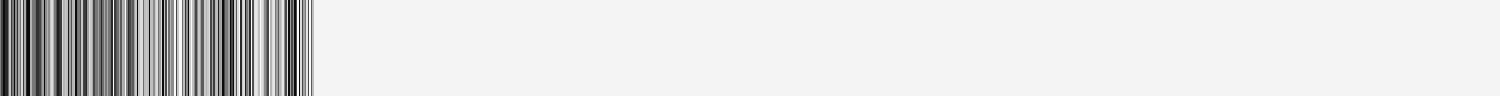

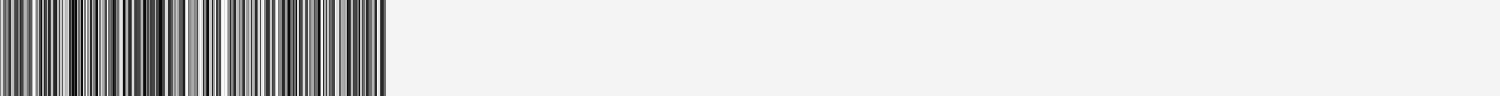

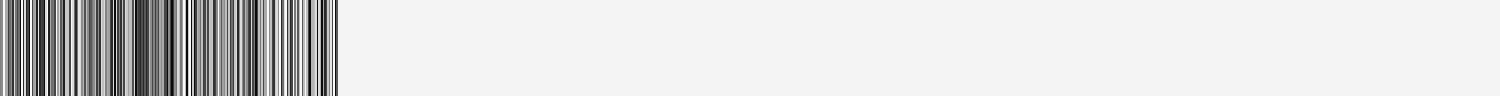

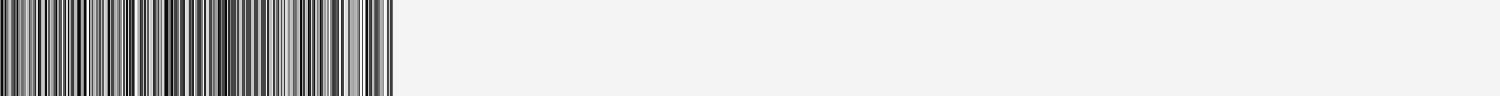

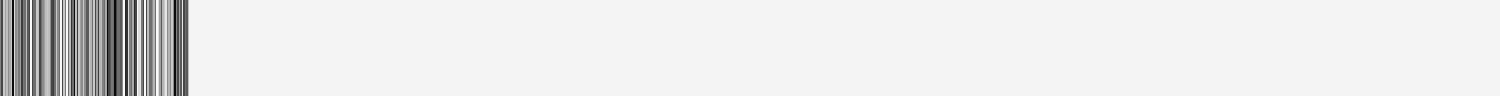

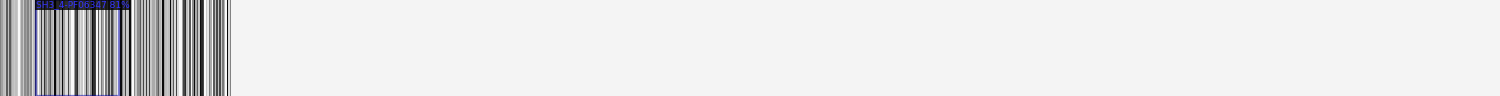

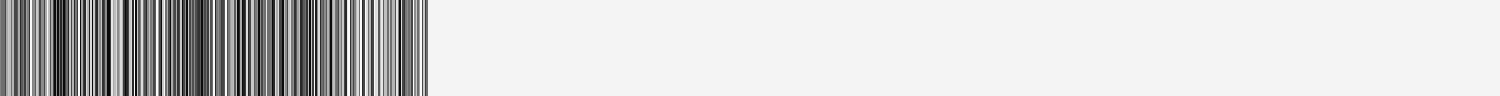

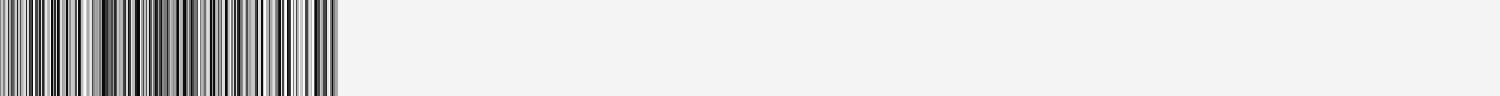

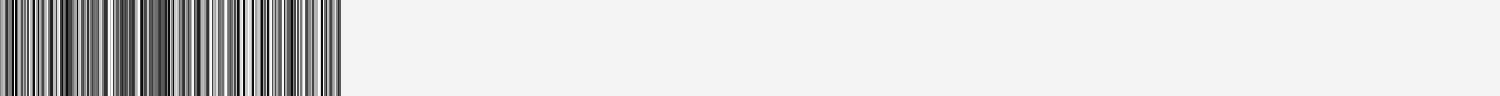

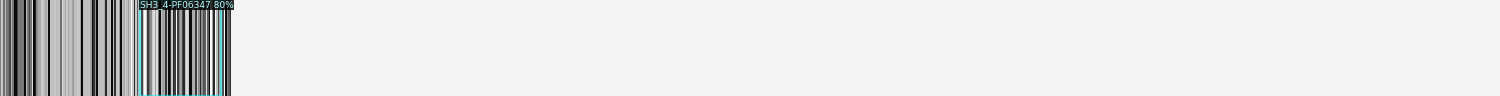

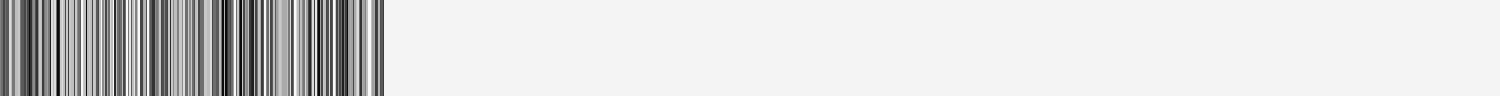

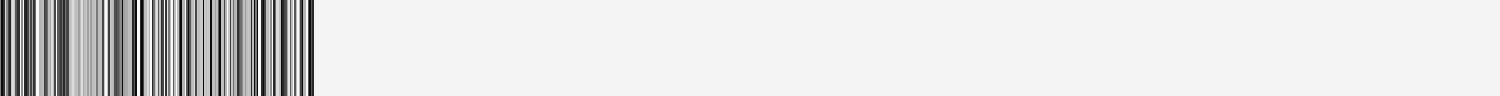

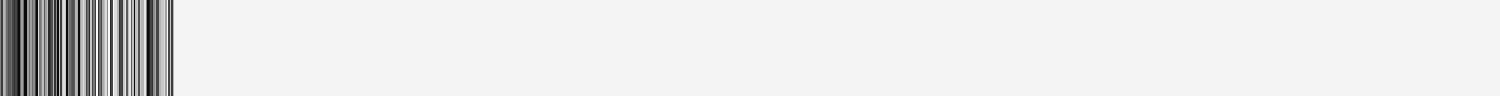

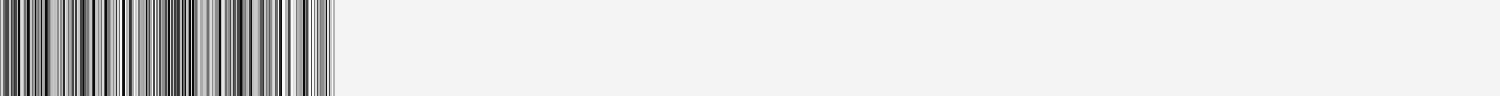

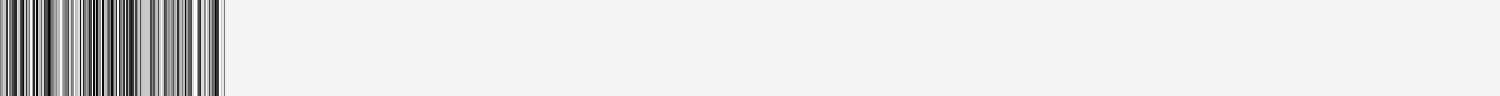

In [23]:
# countt on samples bigger than 600
import string
from PIL import Image
grt_thn_600 = pd.read_csv('/home/satish27may/ProteinDomainDetection/data/PfamData/seq_len_0-300_and_num_samples_0-1000_data.csv')
grt_thn_600 = grt_thn_600[grt_thn_600['SuperClass']!='SH3_4']
test_sequences = grt_thn_600['Sequence']
color_map = {}
index = 0
for amino_acid in string.ascii_uppercase:
    color_map[amino_acid] = (index+10, index+10, index+10)
    index = index+10
def create_protein_seq_image(sequence, img_name, color_map=color_map):
    """
    Create an image from a sequence
    """
    sequence
    image = np.full((64, 300,3), (500,500,500))
    for index in range(len(sequence)):
        image[:, index, :] = color_map[sequence[index]]
    pil_image = Image.fromarray(image.astype(np.uint8))
#     assert pil_image.size == (img_w, img_h), f"{pil_image.size}!=({img_w},{img_h})"
    pil_image.save(img_name)
    
count=0
for index,seq in enumerate(test_sequences):
    img_pth = Path('/tmp/{index}.png')
    create_protein_seq_image(seq, img_pth)
    im = cv2.imread(str(img_pth))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("train").set(thing_classes = ctrlr.classes), 
                   scale=1.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    try:
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        if len(outputs['instances'].get_fields()['pred_classes'])==0:
            count+=1
        cv2_imshow(out.get_image()[:, :, ::-1])
    except: 
        pass